In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [753]:
%load_ext autoreload
%autoreload 2
from dataset import *
from MapMatching import MapMatching
import copy
from tracker import StaticTracker
from dynamic_tracker import ClassicDBSCAN, DynamicTracker
from simulation import NuscenesSimulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [754]:
class RadarLocalizer():
    def __init__(self, **kwargs):
        self.static_tracker = StaticTracker()
        self.cluster_model = ClassicDBSCAN()
        self.dynamic_tracker = DynamicTracker()
        self.map_matching = MapMatching(N=200)
        self.mm = kwargs.pop('mm', False)
        self.estimated_relative_pos = np.array([0,0])
        
    def runDynamicTracker(self, dw, video_data, first_world_ref, imu_relative_ref):
        heading = np.deg2rad(video_data["heading_imu"]-90)
        Z, X = self.cluster_model.run(pc=dw, ego=video_data["pos_imu"], heading=heading) # Z in radar coordinates
        self.dynamic_tracker.run(Z, video_data["timestamp"], {"heading": heading, "T": video_data["pos_imu"]}, video_data["veh_speed"])
    
        return self.dynamic_tracker.getTracks(), {"Z": Z, "X": X}
    
    def runStaticTracker(self, zw, covw, prior, video_data, first_world_ref, imu_relative_ref):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, first_world_ref)
        prior_list = self.getPriorList(prior, first_world_ref[0:2] - imu_relative_ref + self.estimated_relative_pos)
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        print("video_data[pos]", video_data["pos"])
        points, polynoms = self.translateOutput(points, polynoms, -1*video_data["pos"][0:2] + imu_relative_ref) #output from ego(GT) prespective
        
        return points, polynoms, self.static_tracker.getDebugInfo()
        
    def runMapMatching(self, video_data, first_world_ref, imu_relative_ref, prior, nusc_map):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            dynamic_tracks = self.dynamic_tracker.getTracks()
            lanes = self.getLanes(prior, first_world_ref[0:2])
            imu_relative_ref_3d = np.array([imu_relative_ref[0], imu_relative_ref[1], np.deg2rad(video_data["heading_imu"]-90)])
            self.map_matching.run(extended_tracks, nusc_map, dynamic_tracks, lanes, first_world_ref, imu_relative_ref_3d)
            gt_relative_pos = np.array([video_data["pos"][0] - first_world_ref[0], video_data["pos"][1] - first_world_ref[1], video_data["pos"][2]]) 
            mm_results = self.map_matching.getResults(extended_tracks, dynamic_tracks, first_world_ref[0:2], gt_relative_pos, imu_relative_ref_3d, lanes)
            mm_results["pf_best_pos"] += first_world_ref[0:2]
            mm_results["pf_mean_pos"] += first_world_ref[0:2]
            
            return mm_results
        
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getLanes(self, prior, translate):
        prior_elements = []
        #lane_width = 5.
        #w = lane_width / 2.
        for pr in prior:
            prior_len = pr["x"].shape[0]
            elem = np.zeros([prior_len, 4])
            elem[:-1,2] = pr["dx"]
            elem[-1,2] = elem[-2,2]
            elem[:-1,3] = pr["dy"]
            elem[-1,3] = elem[-2,3]
            #grad = np.abs(elem[:,3] / (elem[:,2] + 1e-6))
            sx = -1.2#-1*np.sign(elem[:, 3]) * w * 1/np.sqrt(1+grad**2)
            sy = -1.2#np.sign(elem[:, 2]) * w * grad * 1/np.sqrt(1+grad**2)
            
            elem[:, 0] = pr["x"] - translate[0] + sx
            elem[:, 1] = pr["y"] - translate[1] + sy
            
            #debug_min_x = min(pr["x"])
            #debug_max_x = max(pr["x"])
            #debug_min_y = min(pr["y"])
            #debug_max_y = max(pr["y"])
            #if debug_min_x < 1130 and debug_max_y < 1590:
                #print(f"debug_min_x = {debug_min_x} debug_max_x = {debug_max_x} debug_min_y = {debug_min_y} debug_max_y = {debug_max_y}")
                #print(f"sx = {sx[0]} sy = {sy[0]}")
            prior_elements.append(elem)
            
        return prior_elements
    
    def getPriorList(self, prior, translation):            
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def run(self, static_data, dynamic_data, video_data, prior, first_world_ref, nusc_map):
        #run static tracker
        imu_relative_ref = video_data["pos_imu"][0:2]-first_world_ref
        points, polynoms, debug_info = self.runStaticTracker(static_data["zw"], static_data["covw"], prior, video_data, first_world_ref, imu_relative_ref)
        #run dynamic tracker
        dynamic_tracks, dynamic_clusters = self.runDynamicTracker(dynamic_data["dw"], video_data, first_world_ref, imu_relative_ref)
        #Run map-matching
        mm_results = self.runMapMatching(video_data, first_world_ref, imu_relative_ref, prior, nusc_map)
        self.estimated_relative_pos = mm_results["pf_mean_pos"] - first_world_ref
        return points, polynoms, dynamic_tracks, dynamic_clusters, debug_info, mm_results

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:308: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


frame 0


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 0
Number of extended tracks before run() 0
video_data[pos] [1114.93531372 1589.04348036    0.        ]
frame_idx = 1
Number of new plots 2
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
No handles with labels found to put in legend.


frame 1


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 45
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.89224991e+00 -1.07880762e+00  4.75946519e-03  3.69680995e+01
  5.33584103e+01] static_cars_flag True
video_data[pos] [1115.11507448 1588.94254053    0.        ]
frame_idx = 2
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.392833744074513] cost_mean [1.0750639893565708]
frame 2


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1115.29705166 1588.84075007    0.        ]
frame_idx = 3
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.3681971881624404] cost_mean [1.045455028495969]
frame 3


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1115.49526454 1588.72898093    0.        ]
frame_idx = 4
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.3833943578970083] cost_mean [1.021366043980264]
frame 4


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 89
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.8373928984688059, -0.8464994857998369, 0.009680788587807835) (0.0, -0.6251028227195852, -0.0007622680553885372)
video_data[pos] [1115.70495316 1588.6101875     0.        ]
frame_idx = 5
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.8178677713978006] cost_mean [1.3811091952441146]
frame 5


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 94
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1115.90972548 1588.49370469    0.        ]
frame_idx = 6
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.6791342606615425] cost_mean [1.1906186892482138]
frame 6


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1116.34017475 1588.2474085     0.        ]
frame_idx = 7
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.591451304444778] cost_mean [1.1465723273075132]
frame 7


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2167705358751626, -0.8818422384935478, 0.00957580434981549) (0.0, -0.6944707493642006, 0.00011318342234791343)
video_data[pos] [1116.56311837 1588.11957897    0.        ]
frame_idx = 8
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.657276789711065] cost_mean [1.272237300855716]
frame 8


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.50769296e+01  1.88090492e+00 -3.04440803e-02  2.64065263e+01
  3.39310534e+01] static_cars_flag False
video_data[pos] [1116.796688   1587.98595931    0.        ]
frame_idx = 9
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3188055888312775, 1.2007467773043674] cost_mean [0.9712420034103071, 1.000787928672144]
frame 9


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.47396883537794754, -0.8309384119774053, 0.008763073426729068) (0.0, -0.798440788281578, 0.005279223116964794)
video_data[pos] [1117.03905857 1587.84778252    0.        ]
frame_idx = 10
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5443308498777464, 1.3668897666490034] cost_mean [1.2201739945851633, 0.928316369371352]
frame 10


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1117.2879713  1587.70397448    0.        ]
frame_idx = 11
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.4050737760118992, 1.6988212617614726] cost_mean [1.090172015538236, 1.0656613980066103]
frame 11


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1117.81298521 1587.40070318    0.        ]
frame_idx = 12
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3890905000297122, 1.410277836083754] cost_mean [1.0007121067598843, 1.5418556366574518]
frame 12


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0038336056397327845, -0.819978230282294, 0.008083127001915442) (0.0, -0.7745314451743396, 0.0053625887183890285)
video_data[pos] [1118.06451708 1587.25413712    0.        ]
frame_idx = 13
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.6974081457610788, 1.3292559557306225] cost_mean [1.2147855680167552, 1.5214558256622803]
frame 13


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1118.3272308  1587.10161028    0.        ]
frame_idx = 14
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5514691071777928, 2.0315246158758224] cost_mean [1.2631375171784585, 1.532230913079073]
frame 14


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1118.57059801 1586.95978858    0.        ]
frame_idx = 15
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.1871135239027728, 1.7081404726496432] cost_mean [0.9205350904218482, 1.229502415646288]
n_tracks 1 cost_dyn_true [2.483925026789345] cost_dyn_mean [1.2145167371162848]
abs_vel =[6.11159991]
xlim [1134.3062632267572, 1139.4511165057859] ylim [1575.688683078875, 1578.4702189207512]
abs_vel =[6.11159991]
frame 15


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1118.81884931 1586.81577536    0.        ]
frame_idx = 16
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5729522112006067, 1.4858880755980435] cost_mean [1.2073658046091604, 0.924218933090868]
n_tracks 1 cost_dyn_true [2.830484894758509] cost_dyn_mean [1.4035455941916672]
abs_vel =[6.13661083]
xlim [1135.4313629222477, 1139.8050467480853] ylim [1575.462608356746, 1578.0275920530673]
abs_vel =[6.13661083]
frame 16


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2256266428025161, -0.7800146621072832, 0.00786065302668389) (0.0, -0.5599485283536374, -0.006011569099290664)
video_data[pos] [1119.06940426 1586.66822155    0.        ]
frame_idx = 17
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.6602808310367907, 1.9150906879718763] cost_mean [1.2684238934273941, 1.2418206733013364]
n_tracks 1 cost_dyn_true [3.0481233145418134] cost_dyn_mean [1.505556624862041]
abs_vel =[6.16512053]
xlim [1135.7152488683387, 1140.2167408171806] ylim [1575.2203046206218, 1577.830926334071]
abs_vel =[6.16512053]
frame 17


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1119.58251405 1586.36396304    0.        ]
frame_idx = 18
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3541634804920832, 2.2000723468124344] cost_mean [0.9661068684239517, 1.4327818345136625]
n_tracks 1 cost_dyn_true [3.397384743849159] cost_dyn_mean [1.7314251734054396]
abs_vel =[6.20010019]
xlim [1136.0598199287813, 1141.088564052499] ylim [1574.71627998167, 1577.62705879075]
abs_vel =[6.20010019]
frame 18


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1119.85097248 1586.2015602     0.        ]
frame_idx = 19
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.441837261408612, 1.776039155327339] cost_mean [1.0565426509123186, 1.207556888292828]
n_tracks 1 cost_dyn_true [3.904262701162679] cost_dyn_mean [2.016745345413523]
abs_vel =[6.23638003]
xlim [1136.5324816586935, 1141.5289155224134] ylim [1574.4638144126127, 1577.2835676016125]
abs_vel =[6.23638003]
frame 19


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.7891784660701537, -0.9007384931267259, 0.00837595743679193) (0.0, -0.5801517992655872, -0.0019280359278954335)
video_data[pos] [1120.1493746  1586.02029652    0.        ]
frame_idx = 20
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3783716436742206, 2.866183975077772] cost_mean [1.1092220543646838, 1.9651000386521587]
n_tracks 1 cost_dyn_true [4.163760679752395] cost_dyn_mean [2.138616929894332]
abs_vel =[6.27481604]
xlim [1136.911700626001, 1142.0106015969948] ylim [1574.1723987641979, 1577.0375096319533]
abs_vel =[6.27481604]
frame 20


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1120.43533146 1585.8470435     0.        ]
frame_idx = 21
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.2842006691804662, 1.9653047979368192] cost_mean [0.9728264963298765, 1.4221985053865667]
n_tracks 2 cost_dyn_true [2.2032461035471966, 4.076053421727255] cost_dyn_mean [2.8888831555977603, 2.1825933015526533]
abs_vel =[4.7362435]
abs_vel =[6.31401922]
xlim [1126.4682061961576, 1142.9985084398836] ylim [1573.4161887367363, 1586.1142697775247]
abs_vel =[4.7362435]
abs_vel =[6.31401922]
frame 21


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.48108462115260364, -0.8477505043958091, 0.008256361105205097) (0.0, -0.7773317997210978, 0.005396818906884417)
video_data[pos] [1120.72447961 1585.67295092    0.        ]
frame_idx = 22
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3543889755898348, 2.718382157270025] cost_mean [1.043497835557784, 1.8488974911016953]
n_tracks 2 cost_dyn_true [2.8226844589398823, 4.063478574614626] cost_dyn_mean [3.833614113035467, 2.187852433216365]
abs_vel =[4.78887681]
abs_vel =[6.35298846]
xlim [1126.7739531106201, 1143.459728033529] ylim [1573.1103850288212, 1585.995054138838]
abs_vel =[4.78887681]
abs_vel =[6.35298846]
frame 22


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1121.00597933 1585.50045994    0.        ]
frame_idx = 23
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.675934323961812, 1.107801520469418] cost_mean [1.2417247619482517, 1.1455850294688414]
n_tracks 2 cost_dyn_true [4.463686608922882, 3.9834880551866725] cost_dyn_mean [5.710616756419, 2.2060706578883362]
abs_vel =[4.83959055]
abs_vel =[6.3914047]
xlim [1127.1443034481283, 1143.8984666927547] ylim [1572.7800316771843, 1585.8392962818705]
abs_vel =[4.83959055]
abs_vel =[6.3914047]
frame 23


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1121.59877381 1585.13572642    0.        ]
frame_idx = 24
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3675755420528686, 2.718171838177243] cost_mean [1.0006192123765918, 2.337818703856411]
n_tracks 2 cost_dyn_true [6.962935076768199, 4.444459585702903] cost_dyn_mean [8.340018104030353, 2.404543708507591]
abs_vel =[4.8899207]
abs_vel =[6.43426531]
xlim [1127.4499161347765, 1144.9412948039371] ylim [1572.165595409101, 1585.7102476652688]
abs_vel =[4.8899207]
abs_vel =[6.43426531]
frame 24


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1121.89222911 1584.95440207    0.        ]
frame_idx = 25
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.2481273473100694, 2.5449148107087316] cost_mean [0.9140314089527726, 2.0817323031925015]
n_tracks 2 cost_dyn_true [9.907570655382735, 5.126638736146152] cost_dyn_mean [11.591098940442492, 2.8296674587085615]
abs_vel =[4.93885153]
abs_vel =[6.47716638]
xlim [1128.0110552885005, 1145.429428313522] ylim [1571.8688198823102, 1585.4462899533628]
abs_vel =[4.93885153]
abs_vel =[6.47716638]
frame 25


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1122.17495431 1584.77950386    0.        ]
frame_idx = 26
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.4850765524845546, 2.344410682098767] cost_mean [1.2068371003700733, 1.5818934895976051]
n_tracks 2 cost_dyn_true [12.910421341496495, 5.089530858645505] cost_dyn_mean [14.75952382771231, 2.8235600503247684]
abs_vel =[4.98591346]
abs_vel =[6.52034658]
xlim [1128.460951227582, 1145.8819899308396] ylim [1571.4782031850834, 1585.1755181405777]
abs_vel =[4.98591346]
abs_vel =[6.52034658]
frame 26


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1122.45918703 1584.60421754    0.        ]
frame_idx = 27
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.2290579219437665, 3.1229054012476336] cost_mean [0.9294752604830913, 2.376462255119983]
n_tracks 2 cost_dyn_true [16.403113626907107, 5.013310451449451] cost_dyn_mean [18.074508567952435, 2.8315816232869384]
abs_vel =[5.03107534]
abs_vel =[6.56159512]
xlim [1129.2359334864395, 1146.3417124320076] ylim [1571.168935729129, 1584.7436766888277]
abs_vel =[5.03107534]
abs_vel =[6.56159512]
frame 27


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1122.74934937 1584.42421968    0.        ]
frame_idx = 28
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.728349610309474, 0.9740423526971816] cost_mean [1.2943777406158443, 0.9464474575574803]
n_tracks 2 cost_dyn_true [19.89095241855862, 4.9946524859994135] cost_dyn_mean [19.935401828442895, 2.7983273328000497]
abs_vel =[5.07418227]
abs_vel =[6.60268532]
xlim [1129.6284310571864, 1146.8339400435984] ylim [1570.8501048596609, 1584.4830940610375]
abs_vel =[5.07418227]
abs_vel =[6.60268532]
frame 28


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1123.33753395 1584.05797841    0.        ]
frame_idx = 29
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.658956883380964, 3.182884330969582] cost_mean [1.177075464640027, 2.5438764741946933]
n_tracks 2 cost_dyn_true [22.57156854619481, 4.985459839084081] cost_dyn_mean [20.47308879080248, 2.9210137663982287]
abs_vel =[5.1143175]
abs_vel =[6.64533549]
xlim [1129.9923811183055, 1147.847518634201] ylim [1570.2274571400212, 1584.193216134734]
abs_vel =[5.1143175]
abs_vel =[6.64533549]
frame 29


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1123.63336215 1583.87446367    0.        ]
frame_idx = 30
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.078416579190579, 2.181447371964566] cost_mean [0.8230739029569513, 1.4943240720282325]
n_tracks 2 cost_dyn_true [23.533631278647043, 5.007283112044476] cost_dyn_mean [20.93698642490143, 3.1317064332039393]
abs_vel =[5.15507866]
abs_vel =[6.68736697]
xlim [1130.3450105761513, 1148.3555541023964] ylim [1569.9289270269783, 1583.917499671426]
abs_vel =[5.15507866]
abs_vel =[6.68736697]
frame 30


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8793820240040295, -0.8412856826867214, 0.007876451987216928) (0.0, -0.6483414106661268, -0.0007203604331430119)
video_data[pos] [1123.9652574  1583.66993403    0.        ]
frame_idx = 31
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3922264416671433, 3.055411528972403] cost_mean [1.0012299477425926, 2.105052608728571]
n_tracks 2 cost_dyn_true [23.95872808058901, 5.000144959500108] cost_dyn_mean [21.141726355740705, 3.126521811787101]
abs_vel =[5.19529648]
abs_vel =[6.72853494]
xlim [1130.7656542499435, 1148.896276893349] ylim [1569.5698433120924, 1583.5057114794001]
abs_vel =[5.19529648]
abs_vel =[6.72853494]
frame 31


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.24865976734203787, -0.8412346030662308, 0.007876451987216903) (0.0, -0.7155115557457938, 0.002734199435613237)
video_data[pos] [1124.27370459 1583.47999435    0.        ]
frame_idx = 32
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3370220265023178, 1.4074994389748763] cost_mean [0.9775004108373061, 1.5323475107611488]
n_tracks 3 cost_dyn_true [24.561935347331662, 4.993237002745969, 17.04211137806717] cost_dyn_mean [21.504433004110677, 3.0978006418802098, 15.390642453431912]
abs_vel =[5.2345686]
abs_vel =[6.76879187]
abs_vel =[3.02449813]
xlim [1131.1009629169616, 1149.3986753152267] ylim [1569.0984913194884, 1585.6990360318728]
abs_vel =[5.2345686]
abs_vel =[6.76879187]
abs_vel =[3.02449813]
frame 32


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1124.58784465 1583.28616087    0.        ]
frame_idx = 33
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.6954894269029768, 1.4299796845667472] cost_mean [1.3458024734039542, 0.9219423963366142]
n_tracks 3 cost_dyn_true [24.847559729390532, 4.990763285182814, 16.861032348775318] cost_dyn_mean [21.61497315294585, 3.057960963481987, 15.306947507782876]
abs_vel =[5.27281716]
abs_vel =[6.80796994]
abs_vel =[3.03077502]
xlim [1131.836884510409, 1149.904467461965] ylim [1568.7789268238605, 1585.6139530671662]
abs_vel =[5.27281716]
abs_vel =[6.80796994]
abs_vel =[3.03077502]
frame 33


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1124.88190275 1583.10468502    0.        ]
frame_idx = 34
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5734144849337106, 2.493504109723887] cost_mean [1.2368622460150727, 1.7090509290869398]
n_tracks 3 cost_dyn_true [24.96508243263259, 4.980768109146695, 16.905361959574762] cost_dyn_mean [21.799701916401585, 3.0526026556062633, 15.560952756120054]
abs_vel =[5.30988344]
abs_vel =[6.84607807]
abs_vel =[3.03629566]
xlim [1132.2193527491938, 1150.3929325329516] ylim [1568.4549249188972, 1585.6308898177608]
abs_vel =[5.30988344]
abs_vel =[6.84607807]
abs_vel =[3.03629566]
frame 34


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.1653948354627435, -0.8110957391809245, 0.007968204020492992) (0.0, -0.6164108758769073, -0.0024639688537456653)
video_data[pos] [1125.55350569 1582.68575351    0.        ]
frame_idx = 35
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.2430630971154295, 2.675165605800414] cost_mean [0.9885608084619748, 1.970490437179928]
n_tracks 3 cost_dyn_true [24.84264894815955, 4.778507768783413, 17.346021156690814] cost_dyn_mean [21.72246134453653, 2.9965144367781607, 14.289858794649842]
abs_vel =[5.34763235]
abs_vel =[6.88694538]
abs_vel =[3.04118298]
xlim [1132.5568783957688, 1151.5321824683979] ylim [1567.694087656476, 1585.6458858640815]
abs_vel =[5.34763235]
abs_vel =[6.88694538]
abs_vel =[3.04118298]
frame 35


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.3641750398903953, -0.8064909306772603, 0.007968204020493133) (0.0, -0.7544408056327205, 0.005273642673471659)
video_data[pos] [1125.88994758 1582.47362754    0.        ]
frame_idx = 36
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5622202133909038, 1.0863963995109418] cost_mean [1.1310009302524295, 0.9195492889395871]
n_tracks 3 cost_dyn_true [25.314465744821597, 4.7137959886848755, 15.605386414191017] cost_dyn_mean [21.97017213725536, 2.9641907780841725, 12.468615342155596]
abs_vel =[5.38396958]
abs_vel =[6.92862239]
abs_vel =[3.04553011]
xlim [1132.9306567947644, 1152.102719060608] ylim [1567.3042672462163, 1585.6686637735277]
abs_vel =[5.38396958]
abs_vel =[6.92862239]
abs_vel =[3.04553011]
frame 36


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1126.21714686 1582.26747532    0.        ]
frame_idx = 37
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5268062444045258, 1.8897589125397647] cost_mean [1.1130529663083177, 1.3682527496386772]
n_tracks 3 cost_dyn_true [25.21462535685672, 5.183936853184832, 15.240429497684833] cost_dyn_mean [23.048611330446985, 2.978624533431633, 12.462757598066322]
abs_vel =[5.41876359]
abs_vel =[6.96845585]
abs_vel =[3.04946154]
xlim [1133.3456869206166, 1152.6500888693633] ylim [1566.9676733827346, 1585.6681088594773]
abs_vel =[5.41876359]
abs_vel =[6.96845585]
abs_vel =[3.04946154]
frame 37


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.4923323178614072, -0.8041762847335464, 0.007968204020493133) (0.0, -0.7775214240273893, 0.0037785601497426573)
video_data[pos] [1126.54293268 1582.06042376    0.        ]
frame_idx = 38
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.539608687553002, 1.7995766467342347] cost_mean [1.2193046643893117, 1.3535930842740589]
n_tracks 2 cost_dyn_true [25.702018686069103, 5.451186270035579] cost_dyn_mean [24.606455726991914, 2.972679851941586]
abs_vel =[5.45220699]
abs_vel =[7.00656823]
xlim [1134.1577176756273, 1153.144754088886] ylim [1566.7971164391029, 1581.0961568546443]
abs_vel =[5.45220699]
abs_vel =[7.00656823]
frame 38


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.87432933e+01  1.19282198e+00 -2.41332958e-02  2.94629509e+01
  3.97224784e+01] static_cars_flag True
video_data[pos] [1126.84615394 1581.86897248    0.        ]
frame_idx = 39
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [1.261248210033629, 2.153467052278436, 1.1392755601441722] cost_mean [0.9544020037224483, 1.3691740920487292, 0.9424281610635834]
n_tracks 2 cost_dyn_true [26.827583271446372, 5.805582866840927] cost_dyn_mean [26.14674653453213, 3.110500566494013]
abs_vel =[5.48406236]
abs_vel =[7.04304276]
xlim [1134.5952525459497, 1153.6486366376378] ylim [1566.4810696534737, 1580.829091131983]
abs_vel =[5.48406236]
abs_vel =[7.04304276]
frame 39


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1127.17026109 1581.66549265    0.        ]
frame_idx = 40
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [1.3248445853240471, 2.765559967981892, 3.007662363989032] cost_mean [1.0342475557072952, 1.8228750472699824, 2.88516858416899]
n_tracks 2 cost_dyn_true [27.04605838969416, 5.992436658356215] cost_dyn_mean [26.07096705216081, 3.1438003722270507]
abs_vel =[5.51476225]
abs_vel =[7.07785573]
xlim [1135.0728861710468, 1154.1702895346837] ylim [1566.1124407601042, 1580.527758274144]
abs_vel =[5.51476225]
abs_vel =[7.07785573]
frame 40


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7142603196067263, -0.83727756245611, 0.007847207237395753) (0.0, -0.6444000306047969, -0.000952647484678553)
video_data[pos] [1127.8306326  1581.24393721    0.        ]
frame_idx = 41
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [1.206800320545754, 1.5424800476469422, 3.6389205189537317] cost_mean [0.9102774207163122, 1.221584942659376, 3.3219188716377057]
n_tracks 2 cost_dyn_true [26.46394366063833, 5.937001452453217] cost_dyn_mean [26.04609725493082, 3.215664091880009]
abs_vel =[5.5468794]
abs_vel =[7.11421366]
xlim [1135.428371982494, 1155.323787977338] ylim [1565.3846539759663, 1580.3207067312367]
abs_vel =[5.5468794]
abs_vel =[7.11421366]
frame 41


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 7.33096158e+01 -2.25501434e+00  1.39482552e-02  5.20111317e+01
  6.08266067e+01] static_cars_flag True
video_data[pos] [1128.12378242 1581.0607716     0.        ]
frame_idx = 42
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.4573463649747036, 2.8727728852457592, 5.199792924318932, 10.121484813052751] cost_mean [1.1938506968109692, 2.1248233992694643, 4.81305047419349, 9.006428841265555]
n_tracks 2 cost_dyn_true [26.29470920442779, 6.523999605144446] cost_dyn_mean [26.00957327784226, 3.5937340441782966]
abs_vel =[5.57877397]
abs_vel =[7.14890535]
xlim [1135.8329107285945, 1155.8443224972361] ylim [1565.1321782255118, 1580.029899209692]
abs_vel =[5.57877397]
abs_vel =[7.14890535]
frame 42


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.3476985095308076, -0.8010115044315559, 0.007847207237395872) (0.0, -0.5433274024734712, -0.00353665115128917)
video_data[pos] [1128.47467572 1580.836461      0.        ]
frame_idx = 43
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.0720593710482886, 1.9865070003172287, 1.9406713260922288, 8.02307617128799] cost_mean [0.8528960201282285, 1.5577560020347303, 1.7203038932074608, 7.328766910848753]
n_tracks 2 cost_dyn_true [26.200864380837007, 7.09676639559531] cost_dyn_mean [25.984091790145072, 3.9985407306278136]
abs_vel =[5.60988936]
abs_vel =[7.18433905]
xlim [1136.2114211708765, 1156.4754601003497] ylim [1564.735992282248, 1579.7894412496735]
abs_vel =[5.60988936]
abs_vel =[7.18433905]
frame 43


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6948842286307548, -0.8311251820085708, 0.007657832965165884) (0.0, -0.6683966422124349, 0.00048437035979941755)
video_data[pos] [1128.80696694 1580.6211474     0.        ]
frame_idx = 44
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.4116275824539701, 2.6779287479527105, 2.564401693766963, 7.855172467908588] cost_mean [1.1271186656687546, 2.1226250881416795, 2.402608102767182, 6.965410127876597]
n_tracks 2 cost_dyn_true [25.813051067973838, 7.27965364648474] cost_dyn_mean [25.73805308948848, 4.129273356381212]
abs_vel =[5.64007229]
abs_vel =[7.21939618]
xlim [1137.139735664876, 1157.0266398044457] ylim [1564.4014372184372, 1579.1412885384532]
abs_vel =[5.64007229]
abs_vel =[7.21939618]
frame 44


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.9038689579112709, -0.7607866141990298, 0.00761564967036389) (0.0, -0.6652595067178717, 4.450841097467141e-05)
video_data[pos] [1129.14333116 1580.40674376    0.        ]
frame_idx = 45
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.2977914083099342, 1.1710614249242854, 3.705182891254453, 8.871681665527092] cost_mean [1.014741532278296, 1.0522632776101912, 3.4515631191435068, 7.9036724866626225]
n_tracks 2 cost_dyn_true [25.92163387145352, 7.363666865732203] cost_dyn_mean [25.80977274221278, 4.33159402424794]
abs_vel =[5.66948538]
abs_vel =[7.25390804]
xlim [1137.5788273025948, 1157.5982953637242] ylim [1564.0159560097763, 1578.9055878180209]
abs_vel =[5.66948538]
abs_vel =[7.25390804]
frame 45


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1129.78607272 1579.99208573    0.        ]
frame_idx = 46
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.3731199071015072, 1.7333612291161555, 3.887028151216597, 9.013848841966476] cost_mean [1.1111211965181087, 1.5208428414183257, 3.7750745572966045, 8.175277997254689]
n_tracks 2 cost_dyn_true [26.138665746193173, 7.695374199280057] cost_dyn_mean [25.905624024868203, 4.696238986297237]
abs_vel =[5.69873221]
abs_vel =[7.28867952]
xlim [1138.0002425103398, 1158.755926581056] ylim [1563.3324215974321, 1578.6940555159929]
abs_vel =[5.69873221]
abs_vel =[7.28867952]
frame 46


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.48958221760041476, -0.8306101114588471, 0.007567942365373669) (0.0, -0.6101403238320072, -0.0003328854281756086)
video_data[pos] [1130.12862207 1579.77539866    0.        ]
frame_idx = 47
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.3302114145518813, 1.8818115311322385, 2.824967048576839, 8.460704087652328] cost_mean [1.1508123738859928, 1.584975135017055, 2.7648091437017936, 7.719566083201098]
n_tracks 2 cost_dyn_true [26.260007664522263, 8.315731683029924] cost_dyn_mean [25.927293077897527, 5.1393685928512]
abs_vel =[5.72751348]
abs_vel =[7.32281835]
xlim [1138.4544213375323, 1159.3443313000023] ylim [1562.9707980755165, 1578.4650797333525]
abs_vel =[5.72751348]
abs_vel =[7.32281835]
frame 47


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1130.4788176  1579.55156831    0.        ]
frame_idx = 48
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.0593133262586552, 2.3857998972081305, 2.046190866717432, 8.239593499914747] cost_mean [0.8576507805071357, 1.929120950855778, 1.9553895361199722, 7.628920792810643]
n_tracks 2 cost_dyn_true [25.951324103705847, 8.694171191134657] cost_dyn_mean [25.366760072413786, 5.442867508050369]
abs_vel =[5.75563248]
abs_vel =[7.35618999]
xlim [1138.8924621394751, 1159.940951695059] ylim [1562.5986410155062, 1578.2529641194749]
abs_vel =[5.75563248]
abs_vel =[7.35618999]
frame 48


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1130.82905101 1579.32654968    0.        ]
frame_idx = 49
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.4314751283526137, 0.9223883942276081, 2.8025090480917365, 8.12725372529305] cost_mean [1.1762530810067362, 0.8195871904809918, 2.75084173758535, 7.389091205965768]
n_tracks 2 cost_dyn_true [22.43473834303129, 8.91938575760891] cost_dyn_mean [21.791176182679493, 5.6192669896967775]
abs_vel =[5.78323833]
abs_vel =[7.38876737]
xlim [1139.2614128736755, 1160.5427265118847] ylim [1562.2389015477397, 1577.9724709593113]
abs_vel =[5.78323833]
abs_vel =[7.38876737]
frame 49


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6645770852305795, -0.814873732112428, 0.006792141158520237) (0.0, -0.5673527671263351, -0.002712778563519864)
video_data[pos] [1131.16800172 1579.10852657    0.        ]
frame_idx = 50
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.099488844655678, 1.3450333917983182, 3.6488715179875677, 9.30155900215965] cost_mean [0.9358867367320893, 1.3228162775370222, 3.709150911295006, 8.42014303345892]
n_tracks 2 cost_dyn_true [19.352338216253862, 9.688752616298] cost_dyn_mean [19.09890003832085, 6.318270137885726]
abs_vel =[5.81013539]
abs_vel =[7.41934856]
xlim [1140.3039744441771, 1161.1018643604993] ylim [1561.9663079316929, 1577.4537077940922]
abs_vel =[5.81013539]
abs_vel =[7.41934856]
frame 50


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1131.53067834 1578.87477643    0.        ]
frame_idx = 51
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.0026579057114022, 1.3946757063608348, 3.138613497036485, 9.590237053514837] cost_mean [0.8998036800713656, 1.3637009543442495, 3.1079921833857083, 8.807362597365582]
n_tracks 2 cost_dyn_true [19.329344501352416, 10.376524230285188] cost_dyn_mean [19.100881100842322, 6.913132590267217]
abs_vel =[5.83652245]
abs_vel =[7.44966618]
xlim [1140.6928367313324, 1161.7272320614607] ylim [1561.57430829002, 1577.193959473924]
abs_vel =[5.83652245]
abs_vel =[7.44966618]
frame 51


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.4424630621509302, -0.7567369261535928, 0.0067921411585204) (0.0, -0.6775512736407883, 0.0012491264407770953)
video_data[pos] [1132.18286794 1578.4560309     0.        ]
frame_idx = 52
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.1282879847048661, 2.5016161655610705, 2.87899873876266, 7.288309078942506] cost_mean [0.948028538526948, 2.40139699033552, 2.8423061220125967, 6.609906580783807]
n_tracks 2 cost_dyn_true [19.26111693038005, 10.753015996535545] cost_dyn_mean [19.014836144228752, 7.30920437533117]
abs_vel =[5.86277764]
abs_vel =[7.48118738]
xlim [1141.101444308631, 1162.8799620779662] ylim [1560.8533739595114, 1576.9512791331124]
abs_vel =[5.86277764]
abs_vel =[7.48118738]
frame 52


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1132.52828432 1578.23108556    0.        ]
frame_idx = 53
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.0811912269605508, 1.0116244217563979, 2.4574462359764793, 8.498304618797695] cost_mean [0.9033621800468093, 0.8858840214613473, 2.3536873280281045, 7.833486601619141]
n_tracks 2 cost_dyn_true [19.18224673053207, 10.956486734699174] cost_dyn_mean [18.91785335113743, 7.527121636067795]
abs_vel =[5.88863775]
abs_vel =[7.51267121]
xlim [1141.513510317813, 1163.488131180706] ylim [1560.4443330454378, 1576.7322303567532]
abs_vel =[5.88863775]
abs_vel =[7.51267121]
frame 53


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.49622068e+00 -8.17371530e-01  1.33896244e-03  4.55553308e+01
  7.72560631e+01] static_cars_flag True
video_data[pos] [1132.85777731 1578.01553244    0.        ]
frame_idx = 54
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1061659873881695, 1.470646846384851, 3.540194150536359, 8.646767180236226, 3.60458799455431] cost_mean [0.9605189936848253, 1.351538437960481, 3.4349961870089705, 7.938070859555432, 2.9359627552984184]
n_tracks 2 cost_dyn_true [19.110559777019308, 10.778400426862573] cost_dyn_mean [18.868918431864934, 7.546217194397624]
abs_vel =[5.91400357]
abs_vel =[7.5436368]
xlim [1141.9779262845864, 1164.0488161962264] ylim [1560.052172748389, 1576.4205236974008]
abs_vel =[5.91400357]
abs_vel =[7.5436368]
frame 54


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1133.16484631 1577.81335057    0.        ]
frame_idx = 55
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.0784167270579645, 1.5147984897751072, 1.971149439935508, 8.03828060975944, 2.9508576766883325] cost_mean [0.985583097390352, 1.4887542797108622, 1.8958501700048112, 7.554522672880298, 2.377263471208786]
n_tracks 2 cost_dyn_true [19.08782102238011, 10.976525373076827] cost_dyn_mean [18.8493775179693, 7.662814825172296]
abs_vel =[5.9400986]
abs_vel =[7.57388576]
xlim [1142.8486602493774, 1164.5767096102343] ylim [1559.7324337560951, 1575.9109169578994]
abs_vel =[5.9400986]
abs_vel =[7.57388576]
frame 55


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3677941835195849, -0.6837776066951533, 0.0011756619979540125) (0.0, -0.5900085951563272, -0.0018839639069381105)
video_data[pos] [1133.49508157 1577.59270425    0.        ]
frame_idx = 56
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9924661698511854, 1.9656115974796369, 1.8197877423693287, 7.689046614422635, 3.479924358359771] cost_mean [0.8887966421188522, 1.6930247257954767, 1.7113096965953543, 7.258855436354017, 2.81722028225545]
n_tracks 2 cost_dyn_true [19.141593334393193, 11.105714001316636] cost_dyn_mean [18.84131612085238, 7.763026170589095]
abs_vel =[5.96643936]
abs_vel =[7.60331762]
xlim [1143.2763038533612, 1165.1641393224104] ylim [1559.3499126367713, 1575.612753386851]
abs_vel =[5.96643936]
abs_vel =[7.60331762]
frame 56


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5067837160459723, -0.8116068121999112, 0.006761034086317643) (0.0, -0.5365001850819224, -0.0033786170933971945)
video_data[pos] [1133.80928586 1577.38341911    0.        ]
frame_idx = 57
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1835903252605746, 0.8252641691441094, 2.3238573571381598, 7.693326484713278, 3.42161989285374] cost_mean [0.9951220875431204, 0.928651776675184, 2.157135588320853, 7.105406871175901, 2.883286253883949]
n_tracks 2 cost_dyn_true [17.86405126211827, 11.183534973033005] cost_dyn_mean [16.852952525207748, 8.04807243483664]
abs_vel =[5.99249162]
abs_vel =[7.63322519]
xlim [1143.7260738814239, 1165.7342913910727] ylim [1558.988224039853, 1575.3780446622095]
abs_vel =[5.99249162]
abs_vel =[7.63322519]
frame 57


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1134.50967116 1576.9211939     0.        ]
frame_idx = 58
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1073225558013446, 3.115658995662361, 5.4824993855478015, 8.846027234569735, 3.368131106602754] cost_mean [0.9752203092751583, 2.5635778312686592, 5.004470213237509, 8.25753974770583, 2.858022591185064]
n_tracks 2 cost_dyn_true [19.563917800419894, 11.305942328501821] cost_dyn_mean [20.328659541526406, 8.44728727141289]
abs_vel =[6.01854854]
abs_vel =[7.66392492]
xlim [1144.1575194710292, 1167.003838842363] ylim [1558.164935940327, 1575.1221205827699]
abs_vel =[6.01854854]
abs_vel =[7.66392492]
frame 58


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.9502741097285874, -0.8449017533503531, 0.006778883183682943) (0.0, -0.6640106510908411, 0.001607343073942016)
video_data[pos] [1134.85473913 1576.69437808    0.        ]
frame_idx = 59
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.2878304782664944, 1.4783636709561176, 1.6581265881412648, 6.730589079175989, 3.2714574129890814] cost_mean [1.2122396205304973, 1.4737046382467844, 1.5676699289446525, 6.435033457951322, 2.7001173731656403]
n_tracks 2 cost_dyn_true [27.356576270557063, 11.53820676761548] cost_dyn_mean [27.945747420249184, 8.376418009578497]
abs_vel =[6.04409407]
abs_vel =[7.69435034]
xlim [1144.6591749753477, 1167.6054918511416] ylim [1557.7507466070356, 1574.9227644565574]
abs_vel =[6.04409407]
abs_vel =[7.69435034]
frame 59


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.1637256853253316, -0.6515893907909862, 0.0002326789035110081) (0.0, -0.6151884855636754, -0.0009429590864568557)
video_data[pos] [1135.1995926 1576.4664466    0.       ]
frame_idx = 60
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9491333088880134, 1.117309554443937, 2.5981914151961756, 7.981063917292159, 3.2424835906429954] cost_mean [0.8635494858781745, 1.06559221472957, 2.3775526779708183, 7.463325193556887, 2.704691191104945]
n_tracks 2 cost_dyn_true [32.17383761811047, 11.371761878844024] cost_dyn_mean [32.72814623598738, 8.385862428433299]
abs_vel =[6.06912421]
abs_vel =[7.72418294]
xlim [1145.1235204960985, 1168.2014690322537] ylim [1557.3408005285526, 1574.6278269773597]
abs_vel =[6.06912421]
abs_vel =[7.72418294]
frame 60


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1135.53858907 1576.23852195    0.        ]
frame_idx = 61
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.142738488849417, 0.9973324819576117, 2.102459953713788, 8.013854190567047, 3.1627484941139716] cost_mean [1.0516057424203051, 0.9550747815359367, 2.0669342415116834, 7.569897456435718, 2.7309179936352743]
n_tracks 2 cost_dyn_true [36.93577669595058, 11.285247110755723] cost_dyn_mean [37.0217314558775, 8.310862999883327]
abs_vel =[6.09360058]
abs_vel =[7.75345334]
xlim [1146.0753100261636, 1168.7763424461155] ylim [1556.9445836302743, 1574.0092553638792]
abs_vel =[6.09360058]
abs_vel =[7.75345334]
frame 61


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.6772014594309974, -0.7763515129227573, 0.006778883183682886) (0.0, -0.6462442353591608, 6.878833470025063e-05)
video_data[pos] [1135.89401466 1575.99571608    0.        ]
frame_idx = 62
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9792104761336282, 1.3525054421012004, 3.7587860700769973, 7.962005098584825, 3.277698265673361] cost_mean [0.9095719540825886, 1.3803837250728324, 3.6180904371572162, 7.5771210979836905, 2.7364003849641505]
n_tracks 2 cost_dyn_true [40.95621464182566, 11.310339627487444] cost_dyn_mean [41.38239550123204, 8.485271969524733]
abs_vel =[6.11756921]
abs_vel =[7.78216162]
xlim [1146.535595318243, 1169.4348109390862] ylim [1556.5506785047326, 1573.6611704249951]
abs_vel =[6.11756921]
abs_vel =[7.78216162]
frame 62


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.24530741017707314, -0.6388542322060007, 0.000644357399235262) (0.0, -0.6703385966571251, 0.0002247221401911681)
video_data[pos] [1136.55910534 1575.54524708    0.        ]
frame_idx = 63
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.967307921509141, 1.9352272388690126, 4.430860862299768, 7.095285757087225, 2.6985678329321354] cost_mean [0.9483730896913264, 1.8352752718389496, 3.9760247409515856, 6.820026808831178, 2.257109610774145]
n_tracks 2 cost_dyn_true [44.48615334476159, 11.513817600365376] cost_dyn_mean [45.26224150684605, 8.680536637176251]
abs_vel =[6.14309385]
abs_vel =[7.81049617]
xlim [1146.8906521785752, 1170.6526271312564] ylim [1555.7759995181825, 1573.369302154896]
abs_vel =[6.14309385]
abs_vel =[7.81049617]
frame 63


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.4351824115434044, -0.7768832388243342, 0.00671554576447856) (0.0, -0.5876250424742113, -0.0024913398925251605)
video_data[pos] [1136.89979185 1575.31560197    0.        ]
frame_idx = 64
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.994534362408471, 0.9839155171524031, 2.6099121949725697, 7.105834039845901, 3.0405117406393045] cost_mean [0.9286161615208355, 0.8827695479043033, 2.505897269785432, 6.810350687477369, 2.6495637957498546]
n_tracks 2 cost_dyn_true [46.563025200937574, 11.708434746508551] cost_dyn_mean [46.88350736519071, 8.882452329849455]
abs_vel =[6.16907704]
abs_vel =[7.83822683]
xlim [1147.3584218389494, 1171.245736656068] ylim [1555.362782865321, 1573.0899366904212]
abs_vel =[6.16907704]
abs_vel =[7.83822683]
frame 64


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.46662024903480415, -0.639513704876567, 0.0005012023424517674) (0.0, -0.7049610420318767, 0.001942805926894764)
video_data[pos] [1137.2513308  1575.07678801    0.        ]
frame_idx = 65
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.2954351477895456, 1.6115250488310762, 4.118910302654738, 8.432072686851813, 2.988341783366599] cost_mean [1.2480414795662231, 1.5273494964235788, 3.8706425538809497, 8.110511326088579, 2.606192857765295]
n_tracks 2 cost_dyn_true [46.05674292352298, 11.787770008394492] cost_dyn_mean [46.77912695927944, 8.973642612351751]
abs_vel =[6.19503817]
abs_vel =[7.86462477]
xlim [1147.8366317245288, 1171.869619420967] ylim [1554.9811388058026, 1572.7554455556317]
abs_vel =[6.19503817]
abs_vel =[7.86462477]
frame 65


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.1850719374716754, -0.8054245651653367, 0.006715545764478587) (0.0, -0.6123326940957209, -0.001017979768456178)
video_data[pos] [1137.59975669 1574.84173731    0.        ]
frame_idx = 66
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9836311706718646, 1.6687044232749197, 3.520354124543944, 8.391731273800257, 3.459004577882837] cost_mean [0.9155710495512809, 1.5348510830577677, 3.2402103881311306, 8.227065654845, 2.8990978788686164]
n_tracks 2 cost_dyn_true [46.016397808607095, 11.95036305403067] cost_dyn_mean [46.653948647001, 9.088290297222628]
abs_vel =[6.22064933]
abs_vel =[7.89132892]
xlim [1148.25073948842, 1172.4940997405708] ylim [1554.5564344908798, 1572.5353282307262]
abs_vel =[6.22064933]
abs_vel =[7.89132892]
frame 66


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.12203966e+00 -6.14900050e-01 -1.42233950e-04  5.00409696e+01
  8.61431143e+01] static_cars_flag True
video_data[pos] [1137.94524425 1574.60926317    0.        ]
frame_idx = 67
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.18082398503223, 1.4852433388831268, 1.8433881024116783, 7.45263149067958, 2.9974974982769056, 3.131208321333218] cost_mean [1.157656628784823, 1.3874986364394535, 1.7507893564148016, 7.636585097669725, 2.6100752288561404, 2.5598927690508995]
n_tracks 2 cost_dyn_true [46.51047699353804, 11.93278658314604] cost_dyn_mean [46.96546148547061, 9.083121644162244]
abs_vel =[6.24588141]
abs_vel =[7.91770458]
xlim [1149.3328623819516, 1173.077557682807] ylim [1554.1726321433362, 1571.8618457605805]
abs_vel =[6.24588141]
abs_vel =[7.91770458]
frame 67


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1138.64182227 1574.13862136    0.        ]
frame_idx = 68
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [0.8187374209467304, 0.7032662162739768, 2.3012101602971295, 7.497232917821822, 2.657153278644252, 2.858587708258203] cost_mean [0.7973981794964404, 0.7433160000391029, 2.2995358288701984, 7.359561458114666, 2.353057561288682, 2.3703976848193276]
n_tracks 2 cost_dyn_true [46.12994686509326, 12.097242793522453] cost_dyn_mean [47.27601411877316, 9.460762732216821]
abs_vel =[6.27112407]
abs_vel =[7.94365649]
xlim [1149.7730008289293, 1174.3530199682111] ylim [1553.3720641543653, 1571.620144912086]
abs_vel =[6.27112407]
abs_vel =[7.94365649]
frame 68


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.00063342e+00 -8.58794472e-01  1.66200775e-03  5.38414017e+01
  7.91936211e+01] static_cars_flag True
video_data[pos] [1138.98324154 1573.90932132    0.        ]
frame_idx = 69
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.1078597570048112, 1.9332239023948283, 3.637544127132749, 8.689966508504252, 2.9982891055706196, 3.2199424184360597, 3.2275964792635268] cost_mean [1.0813656974932553, 1.7866523607727909, 3.3511542540816603, 8.507864981062532, 2.622290702530346, 2.706714886874276, 2.7008707361462663]
n_tracks 2 cost_dyn_true [46.48910438400058, 12.51724788186266] cost_dyn_mean [47.90295544259029, 10.027852484202217]
abs_vel =[6.29599676]
abs_vel =[7.96906105]
xlim [1150.2204617785192, 1174.9701892568578] ylim [1552.9798551545898, 1571.3070540811314]
abs_vel =[6.29599676]
abs_vel =[7.96906105]
frame 69


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.25038065599988, -0.6575895156116772, 0.0006112351108665938) (0.0, -0.5933640971995676, -0.00122840916818418)
video_data[pos] [1139.35914585 1573.6623333     0.        ]
frame_idx = 70
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [0.7996765560314368, 1.2971129295112722, 1.3905160131012126, 6.65455499112343, 2.903428127013709, 2.935761819641955, 3.023306962588485] cost_mean [0.7939616213628119, 1.4456770950067244, 1.4468512273211982, 6.625196243213708, 2.569732358313314, 2.5419845382068607, 2.6349712124573546]
n_tracks 2 cost_dyn_true [47.70575611931919, 13.057541074162966] cost_dyn_mean [48.94698363268452, 10.52009026414811]
abs_vel =[6.3204721]
abs_vel =[7.99314265]
xlim [1150.68604908392, 1175.6184702464975] ylim [1552.6185782169532, 1571.0392072068291]
abs_vel =[6.3204721]
abs_vel =[7.99314265]
frame 70


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3154072429488295, -0.6491006579863364, 0.0006230750992397299) (0.0, -0.6526678889756226, 0.00023441616130111205)
video_data[pos] [1139.68894015 1573.44543426    0.        ]
frame_idx = 71
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [0.9086809637282736, 1.9081413720282814, 1.7197492379501222, 6.595742795968983, 3.1773153390100752, 3.219032544068101, 3.2753240650721085] cost_mean [0.8928618967996323, 1.9756972099585195, 1.7077297522341082, 6.580030826712784, 2.838342997935765, 2.822254705006244, 2.879138026429287]
n_tracks 2 cost_dyn_true [48.579186121965265, 13.940826807487436] cost_dyn_mean [49.91362040214332, 11.265807254571317]
abs_vel =[6.34458168]
abs_vel =[8.0163304]
xlim [1151.1908968082703, 1176.1775890207882] ylim [1552.3153962547594, 1570.716232424374]
abs_vel =[6.34458168]
abs_vel =[8.0163304]
frame 71


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.715254182790352, -0.7717489071916637, 0.00644636184748941) (0.0, -0.6493749709742528, -0.0002668257685653782)
video_data[pos] [1140.04597982 1573.2107701     0.        ]
frame_idx = 72
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [0.8716481710958304, 1.1043323473306288, 2.29209035916671, 7.857735132313778, 2.6954405681950644, 2.9115640670748943, 2.8163168792679856] cost_mean [0.8731988684471811, 1.0809015994057811, 2.244922395058773, 7.838207998744622, 2.5182481081254466, 2.5727677594126113, 2.4470736413710426]
n_tracks 2 cost_dyn_true [49.0090231411885, 14.17044423178793] cost_dyn_mean [50.790116374174985, 11.74215479076561]
abs_vel =[6.36841937]
abs_vel =[8.03959751]
xlim [1152.2117767839677, 1176.7752389405236] ylim [1551.9130504797572, 1570.0142614065578]
abs_vel =[6.36841937]
abs_vel =[8.03959751]
frame 72


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.1415842246840251, -0.6607400631161713, 0.0006439585424623292) (0.0, -0.62673279334438, -0.0002821670544110429)
video_data[pos] [1140.40343407 1572.97588698    0.        ]
frame_idx = 73
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [0.8107111263719691, 1.0934668420532017, 2.2508382386370003, 7.7597124269597675, 2.9639308372171254, 3.1037575409685, 3.1721307011236224] cost_mean [0.806856923414415, 0.97649217526156, 2.2903113647197486, 7.841423425801166, 2.7268563837552398, 2.7701948655175364, 2.8746768998345336]
n_tracks 2 cost_dyn_true [50.584334743855194, 13.91684759791272] cost_dyn_mean [52.6838586181173, 11.683648808981175]
abs_vel =[6.39178339]
abs_vel =[8.06341385]
xlim [1152.633046645332, 1177.4007778781317] ylim [1551.4216749147088, 1569.672841350436]
abs_vel =[6.39178339]
abs_vel =[8.06341385]
frame 73


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1141.14769164 1572.48619118    0.        ]
frame_idx = 74
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.1149039674093326, 1.269316100338692, 1.6781041287021699, 5.444519520444384, 2.6585602083232494, 2.7154191893020228, 2.6985027997839173] cost_mean [1.1093727790300576, 1.6447143628012804, 1.680586008180695, 5.810672531842897, 2.4671453105308356, 2.411666726443358, 2.4140584252405506]
n_tracks 2 cost_dyn_true [51.54503937352709, 13.330654206545017] cost_dyn_mean [54.41603151115183, 11.707975604897955]
abs_vel =[6.41503988]
abs_vel =[8.08624783]
xlim [1153.1123241922737, 1178.7051416369522] ylim [1550.5637445098755, 1569.2839224014217]
abs_vel =[6.41503988]
abs_vel =[8.08624783]
frame 74


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2090187026953707, -0.6577317550175501, 0.0006449155533581725) (0.0, -0.6494292942956574, 1.1941766257278863e-05)
video_data[pos] [1141.51196565 1572.24753652    0.        ]
frame_idx = 75
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.0449142863048366, 0.9006806095016261, 1.6575276964615113, 6.82668485167024, 2.9246203607920123, 3.109318465791758, 2.896186176675988] cost_mean [1.0941383013929373, 0.8670133077720515, 1.784136488610959, 7.047343847854156, 2.7775452030303964, 2.819415851899543, 2.567317321971196]
n_tracks 2 cost_dyn_true [50.97990239966756, 13.02245699756801] cost_dyn_mean [54.340408145616806, 11.675194854440633]
abs_vel =[6.4380534]
abs_vel =[8.108416]
xlim [1153.6296965903741, 1179.3168496353683] ylim [1550.1307734370735, 1568.9735549825425]
abs_vel =[6.4380534]
abs_vel =[8.108416]
frame 75


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 7
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1141.885822   1572.00656994    0.        ]
frame_idx = 76
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [0.8876464856804083, 1.0703465992722534, 2.0695150173341514, 8.023009309605477, 2.7311753993573222, 2.9001988442744198, 2.9177878452233705] cost_mean [0.9262387651763371, 1.1462626364035369, 2.1839917768779564, 8.150479267678614, 2.5794706678327604, 2.6168584876625607, 2.6445006797220625]
n_tracks 2 cost_dyn_true [50.50915016222281, 12.801687249216055] cost_dyn_mean [54.30945283423836, 11.662259309097994]
abs_vel =[6.46065577]
abs_vel =[8.12994304]
xlim [1154.1309311378789, 1179.9542977914286] ylim [1549.7202600254184, 1568.6718141065408]
abs_vel =[6.46065577]
abs_vel =[8.12994304]
frame 76


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.33152476685636767, -0.6675707294989208, 0.0006660817715162737) (0.0, -0.6512027599960906, 0.00014349603701593593)
video_data[pos] [1142.25074482 1571.76793531    0.        ]
frame_idx = 77
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [0.8128010137649749, 1.2036766464171567, 2.2212830870874307, 7.972305872205668, 2.8724580973866516, 3.0132405938469, 3.168798522255347] cost_mean [0.8375421040343419, 1.3679550377077903, 2.372400706996925, 8.368041432821686, 2.6540950752301273, 2.7054294246771904, 2.916621676621799]
n_tracks 2 cost_dyn_true [49.95475747664102, 12.664523563711573] cost_dyn_mean [54.16467085432684, 11.594601984192874]
abs_vel =[6.48286388]
abs_vel =[8.15089401]
xlim [1155.1308053201665, 1180.5457446329754] ylim [1549.3247339792338, 1568.0063648465266]
abs_vel =[6.48286388]
abs_vel =[8.15089401]
frame 77


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7047691151616302, -0.6428131064493408, 0.000665352020473933) (0.0, -0.6687624836397617, 0.0008863934904746191)
video_data[pos] [1142.60796608 1571.53614986    0.        ]
frame_idx = 78
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [0.7986165464098091, 1.2826313026307947, 1.257078863976455, 5.978084264906434, 2.7875575517068527, 2.799967196110288, 2.8911076590192137] cost_mean [0.834886534135645, 1.4753734463453727, 1.44132077280151, 6.246696540723468, 2.659215482851324, 2.6182983735688734, 2.6671907384216134]
n_tracks 2 cost_dyn_true [49.458980794194346, 12.728592488063176] cost_dyn_mean [54.02938571906034, 11.53298431262736]
abs_vel =[6.50492207]
abs_vel =[8.17128604]
xlim [1155.7040954630547, 1181.1547119462657] ylim [1548.934254538373, 1567.667543048662]
abs_vel =[6.50492207]
abs_vel =[8.17128604]
frame 78


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.59923684521064, -0.6652297936798098, 0.0006653520204739338) (0.0, -0.7200334118939753, 0.004731065212581692)
video_data[pos] [1142.97700967 1571.29541634    0.        ]
frame_idx = 79
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [0.8204054014220934, 1.0687752418028718, 1.5552193851767102, 7.047247618283071, 2.344264995947156, 2.653289466362545, 2.404817733393581] cost_mean [0.8761019656254263, 1.1931658508983678, 1.667373822221041, 7.296932315005387, 2.3659452408460875, 2.444554380819824, 2.2481616443913848]
n_tracks 2 cost_dyn_true [48.891624447404595, 12.764494263256726] cost_dyn_mean [53.88243337977704, 11.473642495141878]
abs_vel =[6.52684961]
abs_vel =[8.19091882]
xlim [1156.2250435236092, 1181.7739478646129] ylim [1548.5278246572861, 1567.3641142969523]
abs_vel =[6.52684961]
abs_vel =[8.19091882]
frame 79


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 7
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6217744109956325, -0.6463108958768755, 0.0006653520204739389) (0.0, -0.6219821683089803, -0.00041547467400120314)
video_data[pos] [1143.72018804 1570.81526749    0.        ]
frame_idx = 80
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.139160621113363, 2.0977666252261398, 6.803878278382781, 2.6233076963664717, 2.720894350827729, 2.6417440023281307] cost_mean [1.2239051168525945, 2.3151577974991273, 7.255030954074244, 2.6699170225938476, 2.663976448887088, 2.5474941191870637]
n_tracks 2 cost_dyn_true [47.78062007393971, 12.962902960747064] cost_dyn_mean [53.88321433823519, 12.000371119903498]
abs_vel =[6.54872257]
abs_vel =[8.2101491]
xlim [1156.6547386062496, 1183.0638269847545] ylim [1547.7346931758063, 1567.0759999245756]
abs_vel =[6.54872257]
abs_vel =[8.2101491]
frame 80


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3547633203686456, -0.6653368586654039, 0.0006653520204739404) (0.0, -0.6565115711865487, 0.00012757450951607905)
video_data[pos] [1144.10511995 1570.56565897    0.        ]
frame_idx = 81
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [0.9152580012602213, 1.1127347705693527, 6.330222361320464, 2.2485749346880737, 2.2953799190625572, 2.288362684677419] cost_mean [0.9626285368635525, 1.3028132781312909, 6.586050813941499, 2.2462357584714843, 2.1785801598123222, 2.2189349210888016]
n_tracks 2 cost_dyn_true [47.53252991363911, 13.643765620850768] cost_dyn_mean [53.80715677060047, 12.657951385869922]
abs_vel =[6.57033022]
abs_vel =[8.22870859]
xlim [1157.1893351206106, 1183.701252000401] ylim [1547.340619244135, 1566.7453836625268]
abs_vel =[6.57033022]
abs_vel =[8.22870859]
frame 81


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 6
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6702114219365143, -0.6396538020747281, 0.0004331337474080033) (0.0, -0.6353424305656473, -0.00011906728531115779)
video_data[pos] [1144.49142119 1570.32009418    0.        ]
frame_idx = 82
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.146710215658601, 1.3651279384675636, 6.1587069976017, 3.025358412320589, 2.9926154451636062, 3.130656732938675] cost_mean [1.177714437479649, 1.609290248146584, 6.654407501335936, 3.0258811159653822, 2.914648511503725, 3.0762204462791782]
n_tracks 2 cost_dyn_true [47.36695830764877, 13.930250553475929] cost_dyn_mean [53.703625916943295, 13.093985279488477]
abs_vel =[6.59076353]
abs_vel =[8.24679769]
xlim [1157.7463007808135, 1184.3311278286906] ylim [1546.9398743855663, 1566.4758451597083]
abs_vel =[6.59076353]
abs_vel =[8.24679769]
frame 82


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.33354184231616657, -0.6638164915799062, 0.0006536461715019582) (0.0, -0.6478183588981525, -0.0001228325101709102)
video_data[pos] [1144.87655896 1570.07564364    0.        ]
frame_idx = 83
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [0.8316285489232249, 1.4603802397832062, 7.280053216694801, 2.4440857441423063, 2.688871957783118, 2.6758274237588733] cost_mean [0.8749123502577272, 1.746133381069744, 7.686676502908298, 2.566045991022033, 2.6526334209320424, 2.7144508346472462]
n_tracks 2 cost_dyn_true [47.14140824994409, 14.217693526372269] cost_dyn_mean [53.29063161843378, 13.414447975073871]
abs_vel =[6.61047272]
abs_vel =[8.26443455]
xlim [1158.842807132898, 1184.9320420553834] ylim [1546.5624339877359, 1565.766954777744]
abs_vel =[6.61047272]
abs_vel =[8.26443455]
frame 83


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5533584805320562, -0.6401949744029755, 0.00043313374740800716) (0.0, -0.6000829520218549, -0.0006977202458942503)
video_data[pos] [1145.30063367 1569.81622693    0.        ]
frame_idx = 84
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [0.572101560400055, 1.6861857756686711, 7.309282272394006, 2.6529502570250645, 2.6943195619543485, 2.921569742648805] cost_mean [0.6477800074010834, 1.9788726084505555, 7.959493720730875, 2.670236925743937, 2.634219336497905, 2.9503096809342515]
n_tracks 2 cost_dyn_true [46.92438462695647, 14.576306099798092] cost_dyn_mean [52.563348052593824, 13.778367387002255]
abs_vel =[6.62966695]
abs_vel =[8.28163535]
xlim [1159.361714312028, 1185.6164972156853] ylim [1546.1455963132755, 1565.3560747111876]
abs_vel =[6.62966695]
abs_vel =[8.28163535]
frame 84


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.32028892109707324, -0.6649846983963977, 0.0006493498097501904) (0.0, -0.6418179268723228, -0.0001782164278124166)
video_data[pos] [1146.04940361 1569.35121124    0.        ]
frame_idx = 85
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.7445121016862964, 5.038971444831937, 2.333574104726357, 2.3627450446124763, 2.4585187846967105] cost_mean [0.7614797079852877, 5.719527147913047, 2.4000483552380243, 2.361805630479823, 2.5213305078100983]
n_tracks 2 cost_dyn_true [46.70310936499692, 14.906953497227322] cost_dyn_mean [53.002803075305074, 14.591886160936408]
abs_vel =[6.648646]
abs_vel =[8.2981652]
xlim [1159.7401834280092, 1186.8581671087734] ylim [1545.3876432848367, 1565.0317606634724]
abs_vel =[6.648646]
abs_vel =[8.2981652]
frame 85


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8177207583564532, -0.6576937579258565, 0.0006493498097501931) (0.0, -0.6449035376682186, 8.008386097511892e-05)
video_data[pos] [1146.47024671 1569.08797418    0.        ]
frame_idx = 86
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9885189253682419, 6.247606549016752, 2.5830837826725537, 2.856994196903024, 2.8178610571696376] cost_mean [1.0737944884286774, 7.032129590269305, 2.7555600953116928, 2.878244694321631, 2.938598937504909]
n_tracks 2 cost_dyn_true [47.00616015828854, 15.328676076475842] cost_dyn_mean [53.150967502544866, 15.008647516823505]
abs_vel =[6.66743742]
abs_vel =[8.31433299]
xlim [1160.2705853266657, 1187.5658513716767] ylim [1544.9124762174783, 1564.654764915373]
abs_vel =[6.66743742]
abs_vel =[8.31433299]
frame 86


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.025429945726753278, -0.6607751171379803, 0.0006427911163804024) (0.0, -0.6244082562831524, -0.00012230074811177025)
video_data[pos] [1146.85943391 1568.84169071    0.        ]
frame_idx = 87
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.8623121499822605, 7.5129101515715195, 2.3031362366971893, 2.6605511636698345, 2.5583754221153763] cost_mean [0.9527250831263071, 8.099934500109208, 2.384000895218243, 2.5938364311155113, 2.6089817443611105]
n_tracks 2 cost_dyn_true [46.769583182668626, 15.08389523806833] cost_dyn_mean [52.929964257469756, 14.8882001344803]
abs_vel =[6.68509488]
abs_vel =[8.32964129]
xlim [1160.778729967202, 1188.1982526705926] ylim [1544.467520378858, 1564.2583104789885]
abs_vel =[6.68509488]
abs_vel =[8.32964129]
frame 87


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.47454610e+00 -7.81643202e-01  8.91531028e-04  7.07589113e+01
  9.98714318e+01] static_cars_flag True
video_data[pos] [1147.25180484 1568.59846702    0.        ]
frame_idx = 88
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [0.8804873565403005, 5.64612941257805, 2.314730721653489, 2.2558646373852747, 2.3730641784467803, 3.591538602317992] cost_mean [0.8931820230932924, 6.029013215300948, 2.3682671191683258, 2.291380393232024, 2.4640836658188667, 3.246889197282139]
n_tracks 2 cost_dyn_true [46.60667910642208, 15.055520737117721] cost_dyn_mean [53.23343280618958, 14.936720885324059]
abs_vel =[6.70200403]
abs_vel =[8.34458861]
xlim [1161.309691660349, 1188.8168515110037] ylim [1544.0797102082174, 1563.8819092994277]
abs_vel =[6.70200403]
abs_vel =[8.34458861]
frame 88


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7158712980578015, -0.6518836071417448, 0.0006427911163803724) (0.0, -0.723388052129773, 0.0031736076671237978)
video_data[pos] [1147.64054975 1568.35955745    0.        ]
frame_idx = 89
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [0.7553629185090687, 5.284861334152066, 2.4607887590746422, 2.497387858006113, 2.610511582272209, 4.039282739420728] cost_mean [0.8282644744132073, 6.147819820169057, 2.618461385497093, 2.5916101581088933, 2.7403763426383043, 3.7842955659764064]
n_tracks 2 cost_dyn_true [46.793088558398445, 15.697252004981166] cost_dyn_mean [53.63139866468332, 15.637320530412934]
abs_vel =[6.71835178]
abs_vel =[8.35820421]
xlim [1162.4369090725281, 1189.3675541201255] ylim [1543.799604205097, 1563.2177595479568]
abs_vel =[6.71835178]
abs_vel =[8.35820421]
frame 89


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8315246738550943, -0.645983025654899, 0.0006427911163803805) (0.0, -0.6469675269189815, 0.000416436382765022)
video_data[pos] [1148.02795182 1568.12049129    0.        ]
frame_idx = 90
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [6.673460543178995, 2.0448691651023, 2.244894867019031, 2.1637634299769006, 4.306828465239265] cost_mean [7.202676223955761, 2.2771008444360903, 2.326669138653945, 2.340132432556442, 3.973982210772404]
n_tracks 2 cost_dyn_true [47.12149655728827, 16.537516886600297] cost_dyn_mean [54.03477448246984, 16.39428598045874]
abs_vel =[6.73429488]
abs_vel =[8.37150587]
xlim [1162.9033078475622, 1189.9763672763797] ylim [1543.4195271925, 1562.9409182357556]
abs_vel =[6.73429488]
abs_vel =[8.37150587]
frame 90


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.2008939764840925, -0.6413537955847485, 0.00038406838699825364) (0.0, -0.6342633528664611, 0.0002778777455466579)
video_data[pos] [1148.8526118  1567.61391828    0.        ]
frame_idx = 91
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [6.262574677642415, 2.4550073587263626, 2.7067521633268017, 2.6802831772987554, 4.072785848880267] cost_mean [7.047876271275606, 2.640026869303071, 2.7985565154285856, 2.8139571622128443, 3.9363895632001946]
n_tracks 2 cost_dyn_true [47.79992638053288, 17.07546128117791] cost_dyn_mean [55.32010611824383, 16.99547415408082]
abs_vel =[6.7494418]
abs_vel =[8.38450469]
xlim [1163.4317549280224, 1191.2761846858314] ylim [1542.6126365840641, 1562.5948918331028]
abs_vel =[6.7494418]
abs_vel =[8.38450469]
frame 91


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1149.22687336 1567.38279823    0.        ]
frame_idx = 92
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [5.6824614829705835, 2.4303971962395647, 2.3807468292065987, 2.5016600827104987, 3.8405484535489127] cost_mean [6.369838369369361, 2.607780659328368, 2.5232043913032935, 2.662264763482184, 3.583136956906471]
n_tracks 2 cost_dyn_true [48.275312008935664, 17.770078610106502] cost_dyn_mean [56.19292345411306, 17.845711425152928]
abs_vel =[6.76363405]
abs_vel =[8.39540737]
xlim [1163.9131776545064, 1191.8025489894262] ylim [1542.3079907553915, 1562.2588615618981]
abs_vel =[6.76363405]
abs_vel =[8.39540737]
frame 92


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7149476753706419, -0.6587898838919459, 0.000642791116380392) (0.0, -0.6622741234457281, 0.00031519214601900196)
video_data[pos] [1149.64125929 1567.12712828    0.        ]
frame_idx = 93
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [5.407546247771257, 2.176833831033843, 2.335189444869327, 2.4606078876181985, 4.016398678370602] cost_mean [6.318266867339247, 2.4972320617177433, 2.5105738829215665, 2.779727944978522, 3.806595943314814]
n_tracks 2 cost_dyn_true [47.80776761758301, 18.124543507762002] cost_dyn_mean [56.03364220718502, 18.468190211763183]
abs_vel =[6.77728738]
abs_vel =[8.40606768]
xlim [1164.4309945647647, 1192.4227168479936] ylim [1541.9240135674745, 1561.8973157354974]
abs_vel =[6.77728738]
abs_vel =[8.40606768]
frame 93


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.8078063631540933, -0.6651817880103154, 0.0006427911163803866) (0.0, -0.6437896717795203, 0.001263074456724022)
video_data[pos] [1150.04917964 1566.87184058    0.        ]
frame_idx = 94
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.0783697849987774, 2.385403530077503, 2.2513164799055416, 3.7499155853407697] cost_mean [2.383244424467433, 2.534752230635659, 2.5295547904311837, 3.6279309691656643]
n_tracks 2 cost_dyn_true [47.3642390911942, 19.23209078546639] cost_dyn_mean [55.90162149296623, 19.630137644357212]
abs_vel =[6.79060338]
abs_vel =[8.41511576]
xlim [1165.5467702156222, 1192.991515755519] ylim [1541.6590285699276, 1561.1872208952213]
abs_vel =[6.79060338]
abs_vel =[8.41511576]
frame 94


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6829116870396126, -0.6487815257922762, 0.0006382264901047536) (0.0, -0.6338738771105186, 0.0005813063288964588)
video_data[pos] [1150.4873983  1566.59826227    0.        ]
frame_idx = 95
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.1998553147075004, 2.7380125434010734, 2.478214237049405, 4.403778660837263] cost_mean [2.473919925312811, 2.843043709339986, 2.751680949113433, 4.349983511327542]
n_tracks 2 cost_dyn_true [47.134823752876954, 20.21760444875123] cost_dyn_mean [55.893534543892955, 20.950179324378105]
abs_vel =[6.80364251]
abs_vel =[8.42396699]
xlim [1166.099990740627, 1193.6359336739915] ylim [1541.2594183548993, 1560.8126532994816]
abs_vel =[6.80364251]
abs_vel =[8.42396699]
frame 95


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.533451268416032, -0.641120280985965, 0.0003882837905682413) (0.0, -0.5985566808942832, -0.000540408653041144)
video_data[pos] [1151.30409461 1566.09492139    0.        ]
frame_idx = 96
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.008847293942033, 2.0667409385487208, 2.175437904047433, 4.048694603052834] cost_mean [2.3004323934581854, 2.2702586524597863, 2.4987593202835616, 3.8374292235806657]
n_tracks 2 cost_dyn_true [47.09940555503779, 20.99247285505836] cost_dyn_mean [55.9413352638817, 21.927430392360414]
abs_vel =[6.8167116]
abs_vel =[8.4306326]
xlim [1166.5286366687321, 1194.8042493311734] ylim [1540.5801063538381, 1560.4960490483782]
abs_vel =[6.8167116]
abs_vel =[8.4306326]
frame 96


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3551634991218453, -0.6574215581052046, 0.0006406093832598418) (0.0, -0.6299499108570036, -5.478022501775622e-05)
video_data[pos] [1151.7166907  1565.83958296    0.        ]
frame_idx = 97
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.232727454706055, 2.43845054647622, 2.5551889375619368, 3.875679176926739] cost_mean [2.6600912952484514, 2.7371157858679918, 2.9826623176660103, 3.7866214442914803]
n_tracks 2 cost_dyn_true [47.113459207376295, 21.545616195772446] cost_dyn_mean [55.93273167549608, 22.543990657102363]
abs_vel =[6.82977142]
abs_vel =[8.43637555]
xlim [1167.046649160332, 1195.3599302529599] ylim [1540.1750267738385, 1560.1695819307063]
abs_vel =[6.82977142]
abs_vel =[8.43637555]
frame 97


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.8800351352784244, -0.6398188091168129, 0.0003655481905800918) (0.0, -0.685944666249963, 0.0010711779166465711)
video_data[pos] [1152.1301475  1565.58747169    0.        ]
frame_idx = 98
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.246037739075122, 2.4870480907654597, 2.3969729487722296, 3.9084731955529217] cost_mean [2.4865970512414437, 2.628338696101666, 2.645255913341467, 3.888261727649114]
n_tracks 2 cost_dyn_true [46.87803314709231, 21.53133612335592] cost_dyn_mean [55.84512188568267, 22.49700090039598]
abs_vel =[6.84277931]
abs_vel =[8.44100618]
xlim [1167.5631894352, 1195.9222886757295] ylim [1539.8137583192115, 1559.8376698846253]
abs_vel =[6.84277931]
abs_vel =[8.44100618]
frame 98


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.9440685202088801, -0.6518976795314388, 0.0006406093832598466) (0.0, -0.6662286658918647, 0.0006063429813878574)
video_data[pos] [1152.54138953 1565.33556094    0.        ]
frame_idx = 99
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.20361358710947, 2.2503074996929358, 2.4097174806605164, 3.839856290039141] cost_mean [2.521417575887457, 2.503454071102488, 2.767885911796458, 3.801315466192134]
n_tracks 2 cost_dyn_true [46.6057343446014, 21.790538488581173] cost_dyn_mean [55.93277242325978, 22.832780877894447]
abs_vel =[6.8557428]
abs_vel =[8.44457946]
xlim [1168.067493045532, 1196.484791995044] ylim [1539.4845468211875, 1559.526935082931]
abs_vel =[6.8557428]
abs_vel =[8.44457946]
frame 99


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.026594126139459, -0.6486725515533918, 0.000640609383259833) (0.0, -0.6876353838341248, 0.0010679351821806641)
video_data[pos] [1152.95913002 1565.07459743    0.        ]
frame_idx = 100
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7643458969694603, 1.9225721588297826, 2.0123228182687676, 3.999589127316584] cost_mean [2.176455498123619, 2.207339213146062, 2.4333525719864086, 3.908527047403454]
n_tracks 2 cost_dyn_true [46.17832185004788, 21.853175362003807] cost_dyn_mean [55.96096053572251, 23.24829118451884]
abs_vel =[6.86866442]
abs_vel =[8.44710643]
xlim [1169.1915029340353, 1196.9969396657245] ylim [1539.1264636623225, 1558.840682905216]
abs_vel =[6.86866442]
abs_vel =[8.44710643]
frame 100


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.56571678e+01 -7.04529226e-01  3.97856685e-04  5.17153726e+01
  6.49484522e+01] static_cars_flag True
video_data[pos] [1153.36901331 1564.81951125    0.        ]
frame_idx = 101
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.087320169734129, 2.178952102253286, 2.1693767655757226, 3.343915523069948, 1.656899837229616] cost_mean [2.5246031862659235, 2.491100356512666, 2.5276942839106447, 3.4042604093654134, 1.9072339557768476]
n_tracks 2 cost_dyn_true [45.75792465960157, 22.535670052872035] cost_dyn_mean [55.890668735603896, 24.121020521432044]
abs_vel =[6.88155915]
abs_vel =[8.44871855]
xlim [1169.6098691863535, 1197.5461924117387] ylim [1538.859835824222, 1558.544140641911]
abs_vel =[6.88155915]
abs_vel =[8.44871855]
frame 101


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0587204481669501, -0.6305511147376542, 0.0002257070944882757) (0.0, -0.5985534077865825, -0.0006807928447023557)
video_data[pos] [1154.2167678  1564.28617353    0.        ]
frame_idx = 102
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.736618112876863, 1.7245933036783758, 1.821615876951577, 3.5067430860976616, 1.5958983113251561] cost_mean [2.081985715475911, 2.0148813921878297, 2.191772484456447, 3.491230110800988, 1.9140775200424087]
n_tracks 2 cost_dyn_true [45.067525090851476, 24.104142232040417] cost_dyn_mean [55.6102137239073, 26.00765486027388]
abs_vel =[6.89467328]
abs_vel =[8.44803676]
xlim [1170.1080626561484, 1198.6593967905685] ylim [1538.2363397257398, 1558.1710196680435]
abs_vel =[6.89467328]
abs_vel =[8.44803676]
frame 102


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8082764927383881, -0.645641451499343, 0.000643525715441318) (0.0, -0.6712928262072998, 0.0007764685883164226)
video_data[pos] [1154.62604967 1564.02934268    0.        ]
frame_idx = 103
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8789872339901332, 2.024299878932858, 2.131838989468646, 4.13962409607301, 1.4413410044355575] cost_mean [2.3640169892085336, 2.3656441912196255, 2.58919192069726, 4.126546654040377, 1.7120347146833328]
n_tracks 2 cost_dyn_true [45.28317089368111, 25.799281429675958] cost_dyn_mean [55.5513242285719, 27.779708871659643]
abs_vel =[6.90773075]
abs_vel =[8.44619704]
xlim [1170.5343334089998, 1199.1637777767141] ylim [1537.9623903838835, 1557.8627111681049]
abs_vel =[6.90773075]
abs_vel =[8.44619704]
frame 103


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6972273567070282, -0.6386349534797985, 0.00036335332552761405) (0.0, -0.6250751827363733, 0.00016330082752419092)
video_data[pos] [1155.04122658 1563.76610394    0.        ]
frame_idx = 104
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.1488661451810214, 2.205930427842197, 2.3691270405701728, 3.3614999625143, 1.423705169826842] cost_mean [2.510147485444533, 2.5380855781030576, 2.7934557399525595, 3.5245399170991156, 1.6563919425507883]
n_tracks 2 cost_dyn_true [45.73495508844453, 26.914545449237412] cost_dyn_mean [56.02786851107285, 29.45171335603211]
abs_vel =[6.9207513]
abs_vel =[8.44328047]
xlim [1171.1022061343854, 1199.6454991724302] ylim [1537.7246539494238, 1557.4974915413657]
abs_vel =[6.9207513]
abs_vel =[8.44328047]
frame 104


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1155.46719552 1563.49943838    0.        ]
frame_idx = 105
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8400475717241485, 1.8778875184468253, 1.9260247109333708, 3.188014394207973, 1.4187298283586631] cost_mean [2.24065913383344, 2.2180337947775173, 2.3583007032636414, 3.364728260428117, 1.6744350921690763]
n_tracks 2 cost_dyn_true [45.97092453921117, 27.373600277187705] cost_dyn_mean [56.64098874857174, 29.926503994541186]
abs_vel =[6.93370032]
abs_vel =[8.43939404]
xlim [1172.128571553757, 1200.131368745143] ylim [1537.3751495005463, 1556.8431134138193]
abs_vel =[6.93370032]
abs_vel =[8.43939404]
frame 105


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7237698013788707, -0.6484967621378565, 0.0006435257154413313) (0.0, -0.6127722914733863, -0.0004328413377320261)
video_data[pos] [1155.88990337 1563.23172672    0.        ]
frame_idx = 106
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8092948012864032, 1.860019157428861, 1.9113918837831285, 3.6589757507253124, 1.2954534143372878] cost_mean [2.2425973742820733, 2.19167071610605, 2.333285140698503, 3.7026724389214363, 1.4576076243053413]
n_tracks 2 cost_dyn_true [46.27504353354698, 27.34999337647314] cost_dyn_mean [57.37174583686823, 30.11253817277994]
abs_vel =[6.94661179]
abs_vel =[8.43483773]
xlim [1172.6965815706728, 1200.6021321268356] ylim [1537.0816698087874, 1556.4423243562794]
abs_vel =[6.94661179]
abs_vel =[8.43483773]
frame 106


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5428405658896844, -0.6458404233966111, 0.0006435257154413009) (0.0, -0.6307226330653906, 0.0003446211805688032)
video_data[pos] [1156.314968   1562.96036555    0.        ]
frame_idx = 107
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.9713149315817162, 2.2216631101510886, 2.0582319994005958, 3.7324807606637225, 1.5127379595942834] cost_mean [2.5134772190584407, 2.603714038078236, 2.579056106340657, 3.8563829848559203, 1.7657170911171818]
n_tracks 2 cost_dyn_true [46.634929568987005, 27.593157961128902] cost_dyn_mean [57.79122170548031, 30.255487065230888]
abs_vel =[6.9594926]
abs_vel =[8.43036902]
xlim [1173.1342659145912, 1201.1189485957595] ylim [1536.7565722526579, 1556.1376251426457]
abs_vel =[6.9594926]
abs_vel =[8.43036902]
frame 107


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.03627910e+01  4.34197550e-02 -2.64704368e-03  1.21288856e+02
  1.37687660e+02] static_cars_flag True
video_data[pos] [1157.21235774 1562.38974426    0.        ]
frame_idx = 108
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6804170342523754, 2.1045499708552793, 1.857624319355267, 3.4642859348089687, 1.4307569175906534, 2.3504134705849653] cost_mean [2.1141460032318227, 2.403495404423464, 2.2858971787503912, 3.659269808285326, 1.7646126045872492, 2.160936568425459]
n_tracks 2 cost_dyn_true [46.8201690062488, 27.222140649139604] cost_dyn_mean [58.703844420375425, 30.462774141649493]
abs_vel =[6.9724527]
abs_vel =[8.42384987]
xlim [1173.7119792228511, 1202.166215815323] ylim [1536.0353965993531, 1555.7400285374606]
abs_vel =[6.9724527]
abs_vel =[8.42384987]
frame 108


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6533287673516242, -0.6456603446620851, 0.00064352571544132) (0.0, -0.6022002260914449, -0.0021485739162460794)
video_data[pos] [1157.64096395 1562.11812933    0.        ]
frame_idx = 109
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.9089552218176173, 1.9647097500031336, 2.0171612558792487, 3.631891727207056, 1.4609373970489077, 2.0680212446565625] cost_mean [2.4452295352856153, 2.410867942455358, 2.5569069823774124, 3.841856956295277, 1.7242921574615406, 1.9473617413515285]
n_tracks 2 cost_dyn_true [46.884418389236345, 26.868199891296] cost_dyn_mean [59.050496411230064, 30.426292983420133]
abs_vel =[6.98535888]
abs_vel =[8.41619514]
xlim [1174.160939558957, 1202.6318791535577] ylim [1535.69264226802, 1555.4215547136423]
abs_vel =[6.98535888]
abs_vel =[8.41619514]
frame 109


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.38552996712643406, -0.6395626968057736, 0.0003773580152504191) (0.0, -0.5906446697673161, -0.0005265337706746078)
video_data[pos] [1158.06942783 1561.84797484    0.        ]
frame_idx = 110
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6923661723223795, 1.7913239302191049, 2.8725812397263057, 1.3184618923018154, 2.253927800199519] cost_mean [2.2135533128780684, 2.2272047685896377, 3.1454679486049972, 1.669745282133962, 2.1000475266165854]
n_tracks 2 cost_dyn_true [46.81049028057495, 26.54806261309956] cost_dyn_mean [59.03677672974049, 30.29188379101532]
abs_vel =[6.99811631]
abs_vel =[8.4077864]
xlim [1174.7453482092562, 1203.0867679306705] ylim [1535.363823832568, 1555.0223316678007]
abs_vel =[6.99811631]
abs_vel =[8.4077864]
frame 110


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6367191458723642, -0.6457036038943978, 0.0006435257154413253) (0.0, -0.6312301596828149, 5.549048701030965e-05)
video_data[pos] [1158.49321449 1561.58059782    0.        ]
frame_idx = 111
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8854476516341658, 2.2453431385176157, 3.442222302157832, 1.67867254635285, 2.4898639387469053] cost_mean [2.3900923010348456, 2.6164193523287755, 3.774976689813515, 2.1136185252863946, 2.2913007898775173]
n_tracks 2 cost_dyn_true [47.03745193347296, 26.224146647838186] cost_dyn_mean [59.35604645975219, 30.10416507762804]
abs_vel =[7.0106866]
abs_vel =[8.39860825]
xlim [1175.8062182471592, 1203.5153006035096] ylim [1535.0745955283812, 1554.3312354801114]
abs_vel =[7.0106866]
abs_vel =[8.39860825]
frame 111


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7099501707133129, -0.6381371136892658, 0.00028355370138939093) (0.0, -0.6681356325853666, 0.0012827718174386368)
video_data[pos] [1158.92228104 1561.30926317    0.        ]
frame_idx = 112
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.4647471995343093, 1.5551221957074082, 3.1519037734470925, 1.3298783935658824, 2.0323417581209853] cost_mean [1.9437369805262212, 1.9758925515429502, 3.339247904336031, 1.5414648599448812, 1.8517528656473845]
n_tracks 2 cost_dyn_true [47.38133304290305, 26.10883370588316] cost_dyn_mean [59.89878088211198, 30.01156509523411]
abs_vel =[7.02304454]
abs_vel =[8.38959867]
xlim [1176.3812990319773, 1203.9879316236163] ylim [1534.7722952901327, 1553.9729908485988]
abs_vel =[7.02304454]
abs_vel =[8.38959867]
frame 112


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1159.78136227 1560.7635094     0.        ]
frame_idx = 113
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.865211167759912, 3.2732918744227004, 1.3776932242459903, 2.1905261554459914] cost_mean [2.3671449417493813, 3.563843212721494, 1.8394219893459542, 2.0529640876247317]
n_tracks 2 cost_dyn_true [47.278717681395946, 25.568466859043006] cost_dyn_mean [60.244005638963756, 29.954634865317622]
abs_vel =[7.03531515]
abs_vel =[8.37849846]
xlim [1176.8800346582925, 1204.9046842987918] ylim [1534.142012541155, 1553.648513114209]
abs_vel =[7.03531515]
abs_vel =[8.37849846]
frame 113


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8473723742186046, -0.6424297247915993, 0.00035120576160330266) (0.0, -0.6355865977315099, 0.0001154982261548811)
video_data[pos] [1160.2152962  1560.48766853    0.        ]
frame_idx = 114
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.8092085676634038, 2.9409556149615863, 1.6552357805605784, 2.3972599389659948] cost_mean [2.1947879446357628, 3.285014029503258, 2.0499199810904445, 2.2392916672388665]
n_tracks 2 cost_dyn_true [47.14631514289346, 25.328314117188047] cost_dyn_mean [60.077175552044004, 29.806912823789958]
abs_vel =[7.04664903]
abs_vel =[8.36649896]
xlim [1177.4277489676285, 1205.3360651593514] ylim [1533.8503049602723, 1553.304549346301]
abs_vel =[7.04664903]
abs_vel =[8.36649896]
frame 114


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1160.65200976 1560.21272664    0.        ]
frame_idx = 115
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7305512381842096, 3.3855414484826025, 1.4173032380421131, 1.9923451059036568] cost_mean [2.205143317339437, 3.6371458218196597, 1.6548414663755358, 1.8401378320747959]
n_tracks 2 cost_dyn_true [46.85839726770365, 25.069204739587526] cost_dyn_mean [60.052292331856464, 29.791243329829392]
abs_vel =[7.05740155]
abs_vel =[8.3537852]
xlim [1177.9767226253368, 1205.7617633664167] ylim [1533.528479808368, 1552.9711996422648]
abs_vel =[7.05740155]
abs_vel =[8.3537852]
frame 115


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1161.08267004 1559.94191492    0.        ]
frame_idx = 116
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.5187580448681097, 3.0607052965427095, 1.2521611488805489, 2.143457336037403] cost_mean [2.006864732903494, 3.3413830234119435, 1.628778955306077, 2.028359325839217]
n_tracks 2 cost_dyn_true [46.92997335926703, 24.84816185952019] cost_dyn_mean [60.02291032018964, 29.681436404400717]
abs_vel =[7.06771423]
abs_vel =[8.34054822]
xlim [1178.5356360170092, 1206.1591923964183] ylim [1533.1836011773935, 1552.631451418994]
abs_vel =[7.06771423]
abs_vel =[8.34054822]
frame 116


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.33569403411680376, -0.6428034543786163, 0.0003512057616033105) (0.0, -0.5705948238107926, -0.0012097417970685933)
video_data[pos] [1161.53374339 1559.65679512    0.        ]
frame_idx = 117
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.9024105905079844, 3.236118794371242, 1.4689771314849998, 2.351233465828134] cost_mean [2.344589463305353, 3.608673052909783, 2.007577713883627, 2.2017963921926214]
n_tracks 2 cost_dyn_true [47.12451528300912, 24.600701967510275] cost_dyn_mean [60.44401882748065, 29.475653693716644]
abs_vel =[7.07764713]
abs_vel =[8.32664965]
xlim [1179.6356149906508, 1206.5650729595616] ylim [1532.8215414713945, 1551.9483284266748]
abs_vel =[7.07764713]
abs_vel =[8.32664965]
frame 117


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05022744975567939, -0.6064428027704853, -0.0004993602104973963) (0.0, -0.7149799896857348, 0.0026500411580863566)
video_data[pos] [1161.96037646 1559.38531669    0.        ]
frame_idx = 118
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7177323480449365, 2.9251670885739647, 1.2660029467266516, 2.5727451315670775] cost_mean [2.2359270547190078, 3.3165187394036897, 1.4851017982580577, 2.4376212958815384]
n_tracks 2 cost_dyn_true [47.04429227305823, 24.303946942881783] cost_dyn_mean [60.61596870797505, 29.096917722536812]
abs_vel =[7.08731351]
abs_vel =[8.31225632]
xlim [1180.2345225223391, 1206.9572773423408] ylim [1532.5252087257918, 1551.5371240542272]
abs_vel =[7.08731351]
abs_vel =[8.31225632]
frame 118


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1162.82298428 1558.83306464    0.        ]
frame_idx = 119
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.847653422064447, 3.0526425560404085, 1.3802057720585617, 2.093368444229003] cost_mean [2.433556110447512, 3.5179326187933313, 1.7708183103120212, 1.9826887480584903]
n_tracks 2 cost_dyn_true [46.71907404143808, 23.68205721935376] cost_dyn_mean [60.52803766463144, 28.877079565281896]
abs_vel =[7.09667689]
abs_vel =[8.29663644]
xlim [1180.7159027865334, 1207.796260497564] ylim [1531.9541589564842, 1551.2096246799415]
abs_vel =[7.09667689]
abs_vel =[8.29663644]
frame 119


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.0872309422103292, -0.6124289978956825, -0.0004897400666639357) (0.0, -0.5918016696404281, -0.0009915750971194182)
video_data[pos] [1163.26104519 1558.55051499    0.        ]
frame_idx = 120
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.0323538563520303, 2.9115533907609166, 1.562729332480403, 2.25568279095117] cost_mean [2.523677530850779, 3.34630098456716, 1.9477977890316764, 2.1918713309523894]
n_tracks 2 cost_dyn_true [46.863688217052676, 23.354676884864737] cost_dyn_mean [60.704682899331694, 28.77862847604471]
abs_vel =[7.10541689]
abs_vel =[8.28047236]
xlim [1181.2850193919833, 1208.19855444272] ylim [1531.643416260274, 1550.8606955885223]
abs_vel =[7.10541689]
abs_vel =[8.28047236]
frame 120


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3051893548473958, -0.5904328331966934, -0.0022731241476172137) (0.0, -0.6305657357307356, 0.0013246430552414142)
video_data[pos] [1163.67942955 1558.28474328    0.        ]
frame_idx = 121
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.4921842249333659, 3.0141987633298664, 1.3098541929622318, 1.8529680796587222] cost_mean [2.0072033549081794, 3.3865579063735334, 1.58349428019401, 1.7360113272345217]
n_tracks 2 cost_dyn_true [46.79927435878962, 23.170510472149694] cost_dyn_mean [60.92933442735398, 28.740835995531093]
abs_vel =[7.11340142]
abs_vel =[8.26392216]
xlim [1181.77119410327, 1208.5784480505713] ylim [1531.3638540521854, 1550.5544149122093]
abs_vel =[7.11340142]
abs_vel =[8.26392216]
frame 121


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7617760706442489, -0.6411785523054625, 0.00035813052308683314) (0.0, -0.6539400326271827, 0.0006240244013548987)
video_data[pos] [1164.1129464  1558.00653583    0.        ]
frame_idx = 122
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.5553740259025128, 3.1447454894168176, 1.4437418796143766, 2.0389743342081954] cost_mean [2.0855743968221896, 3.6167596713881993, 1.7240031958718356, 1.9957164142109665]
n_tracks 2 cost_dyn_true [46.536764511513695, 22.829960619583687] cost_dyn_mean [60.75376650511474, 28.60732317448656]
abs_vel =[7.12088558]
abs_vel =[8.24687777]
xlim [1182.9002371131526, 1208.9374091591976] ylim [1531.113776240364, 1549.8195802878513]
abs_vel =[7.12088558]
abs_vel =[8.24687777]
frame 122


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.35588134378427405, -0.6178844775883683, -0.0005236744796580253) (0.0, -0.6638400102358644, 0.0006052340312052804)
video_data[pos] [1164.54672833 1557.72902655    0.        ]
frame_idx = 123
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.6858247636571135, 2.8854341131168546, 1.367272522051244, 2.198636911489902] cost_mean [2.2906545196281662, 3.3548244288648434, 1.8928494771013675, 2.1374158171466724]
n_tracks 2 cost_dyn_true [46.233354215981976, 22.369269362053743] cost_dyn_mean [60.76445114865111, 28.424550420182577]
abs_vel =[7.12768117]
abs_vel =[8.22928887]
xlim [1183.4285972269804, 1209.311514807828] ylim [1530.8459304002167, 1549.4511180689203]
abs_vel =[7.12768117]
abs_vel =[8.22928887]
frame 123


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1165.40129804 1557.17946876    0.        ]
frame_idx = 124
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.5203903048030327, 2.5599000480374623, 1.3301311795528192, 2.378369846603864] cost_mean [2.046372577360096, 3.072537084710069, 1.7052132491547978, 2.3324107403960426]
n_tracks 2 cost_dyn_true [46.31280307284027, 20.926894764908006] cost_dyn_mean [61.17552552429248, 27.198106154793372]
abs_vel =[7.13334112]
abs_vel =[8.21071697]
xlim [1183.9497309700077, 1210.0678404727757] ylim [1530.3098021941812, 1549.088679919098]
abs_vel =[7.13334112]
abs_vel =[8.21071697]
frame 124


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0000147586518287, -0.6383348968246751, 0.00035813052308682805) (0.0, -0.64721608023091, 0.00012197899053462995)
video_data[pos] [1165.83644235 1556.89731905    0.        ]
frame_idx = 125
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.2678675321502626, 3.1273629913690923, 1.2572452970314005, 1.93546139930998] cost_mean [1.8473584807334567, 3.5897109632872413, 1.6932039815912725, 1.9730795558493381]
n_tracks 2 cost_dyn_true [47.40132301028401, 19.40584733929419] cost_dyn_mean [62.73688910856754, 25.666791979541983]
abs_vel =[7.13809501]
abs_vel =[8.19152934]
xlim [1184.43704584309, 1210.4280662153672] ylim [1530.0693858969037, 1548.7695586504149]
abs_vel =[7.13809501]
abs_vel =[8.19152934]
frame 125


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.58189173e+00 -4.53174849e-01 -9.75562194e-04  7.11383158e+01
  1.05120675e+02] static_cars_flag True
video_data[pos] [1166.25948701 1556.62444604    0.        ]
frame_idx = 126
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.993130245801654, 2.980402435707055, 1.5302150835795623, 2.346560904709787, 3.2598270927108395] cost_mean [2.5222027233925073, 3.591343985813893, 2.0667268762715056, 2.3119615546404964, 3.77547829417398]
n_tracks 2 cost_dyn_true [47.99599242785301, 18.372784778221273] cost_dyn_mean [63.495814903729055, 24.448260132170283]
abs_vel =[7.14208322]
abs_vel =[8.17218256]
xlim [1185.03654573933, 1210.7738263764875] ylim [1529.8281469410163, 1548.3910028511023]
abs_vel =[7.14208322]
abs_vel =[8.17218256]
frame 126


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1166.68658562 1556.34863682    0.        ]
frame_idx = 127
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.3074482529118077, 2.7055532590535263, 1.281591226743438, 2.326216099371234, 3.0498032230231775] cost_mean [1.8334952765241799, 3.163506247181886, 1.5130869267109437, 2.341541812842949, 3.4568267618032857]
n_tracks 2 cost_dyn_true [48.0896652404857, 17.993393917917196] cost_dyn_mean [63.482769050276424, 23.960660340700684]
abs_vel =[7.14557565]
abs_vel =[8.15288004]
xlim [1185.5519781559938, 1211.1360552836302] ylim [1529.5989383273468, 1548.0374238964819]
abs_vel =[7.14557565]
abs_vel =[8.15288004]
frame 127


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2533766898775909, -0.6104878225482239, -0.0005289243883386085) (0.0, -0.6086958144511988, -0.0005184069166772057)
video_data[pos] [1167.10945001 1556.07366517    0.        ]
frame_idx = 128
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.881820468236134, 3.0697464132249492, 1.4308873646402995, 1.8854159080658661, 3.238083274948096] cost_mean [2.482999890268476, 3.6877827902129554, 1.5251839235994684, 1.906571525636467, 3.759746502197451]
n_tracks 2 cost_dyn_true [48.06252125379028, 17.686018453130337] cost_dyn_mean [63.802628892357106, 23.68030414282346]
abs_vel =[7.14847354]
abs_vel =[8.13361216]
xlim [1186.595373678457, 1211.4535070299887] ylim [1529.3638377397774, 1547.3600731989072]
abs_vel =[7.14847354]
abs_vel =[8.13361216]
frame 128


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1167.53710184 1555.79784488    0.        ]
frame_idx = 129
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.5313459226557973, 2.615148614036746, 1.3220166834814389, 2.0452140721075205, 2.8205095529886215] cost_mean [2.1615883244634944, 3.151827060263635, 1.8083178932170643, 2.0551993355803777, 3.3336116763997126]
n_tracks 2 cost_dyn_true [47.82736593354621, 17.343323137305987] cost_dyn_mean [63.56804446367995, 23.048855595911597]
abs_vel =[7.15069889]
abs_vel =[8.11434658]
xlim [1187.1708537298446, 1211.7759836701434] ylim [1529.0954227857412, 1546.9875617573355]
abs_vel =[7.15069889]
abs_vel =[8.11434658]
frame 129


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5412589631520524, -0.6393136114401509, 0.00031003735275524427) (0.0, -0.6276754747104092, 1.824097821859764e-05)
video_data[pos] [1167.96690834 1555.52110192    0.        ]
frame_idx = 130
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.021581028675112, 2.750519570381601, 1.3073417002375154, 2.220775756838388, 2.850936924907165] cost_mean [2.5960943677228516, 3.350538629476678, 1.634837671669013, 2.225038594267257, 3.3356657290327854]
n_tracks 2 cost_dyn_true [47.42125780929622, 17.030132369249603] cost_dyn_mean [63.462899896695575, 22.809865454696492]
abs_vel =[7.15251272]
abs_vel =[8.09526837]
xlim [1187.6696496468492, 1212.1480163130138] ylim [1528.8079742444525, 1546.66079247967]
abs_vel =[7.15251272]
abs_vel =[8.09526837]
frame 130


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.027482381200281403, -0.6042554580111716, -0.0006135341301329321) (0.0, -0.6204979483549684, 7.43497539974811e-05)
video_data[pos] [1168.81709791 1554.97816427    0.        ]
frame_idx = 131
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.4443239717243601, 2.8823147099855766, 1.322548238938726, 1.8632346276467646, 3.2836855166026018] cost_mean [2.084174702119187, 3.479511962111294, 1.641317999992135, 1.858301630180116, 3.7733813144912824]
n_tracks 2 cost_dyn_true [46.92448259397669, 16.65274681101263] cost_dyn_mean [63.29455582459072, 22.60265446254451]
abs_vel =[7.1535652]
abs_vel =[8.07575309]
xlim [1188.1008081252385, 1212.8454163410372] ylim [1528.3484051726393, 1546.3580174123467]
abs_vel =[7.1535652]
abs_vel =[8.07575309]
frame 131


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6071244532168096, 1.7224225510818152, -0.010548439163522055) (0.0, 1.2654128268530336, 0.043812670123817364)
video_data[pos] [1169.24606209 1554.70121422    0.        ]
frame_idx = 132
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.606189101395762, 2.684566276794011, 1.3566908186351228, 2.1617172941900975, 2.965529279353582] cost_mean [2.2691544695514274, 3.351908282293023, 1.9406078576098456, 2.221732479699184, 3.581233861930928]
n_tracks 2 cost_dyn_true [46.56508858993533, 16.441449987545184] cost_dyn_mean [63.23877603457574, 22.466074478928736]
abs_vel =[7.15396891]
abs_vel =[8.05654054]
xlim [1188.648664873014, 1213.180290853119] ylim [1528.1146374970383, 1545.9880538792063]
abs_vel =[7.15396891]
abs_vel =[8.05654054]
frame 132


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.15997207253535706, -0.6179248543454642, -0.0005585876695445112) (0.0, -0.6436743754112045, -0.00046014006902408446)
video_data[pos] [1169.68621473 1554.41833435    0.        ]
frame_idx = 133
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1858088016258412, 2.4256729035327655, 1.3772731240494824, 2.238241098205243, 2.80456323347603] cost_mean [1.726289746191145, 2.9604384979995215, 1.7985924427393332, 2.2134739579410243, 3.2731882762861715]
n_tracks 2 cost_dyn_true [46.4436766099344, 16.21924644512132] cost_dyn_mean [63.16398735871044, 22.418499492399285]
abs_vel =[7.15403122]
abs_vel =[8.03720892]
xlim [1189.6078277167371, 1213.4971435577834] ylim [1527.8127635327573, 1545.4030395580269]
abs_vel =[7.15403122]
abs_vel =[8.03720892]
frame 133


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1170.10387768 1554.14888151    0.        ]
frame_idx = 134
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6200180489719058, 2.696106366597576, 1.30615312550623, 1.858023561695891, 3.1991775442046735] cost_mean [2.3469367675989314, 3.417044567229718, 1.7958648503671293, 1.867197547385288, 3.7865518406060406]
n_tracks 2 cost_dyn_true [46.234517985466205, 15.95876905512489] cost_dyn_mean [62.98130606917374, 22.304914636017973]
abs_vel =[7.15394266]
abs_vel =[8.01798064]
xlim [1190.1506894454399, 1213.8079112222042] ylim [1527.6313136489928, 1545.1079343124798]
abs_vel =[7.15394266]
abs_vel =[8.01798064]
frame 134


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.2677563196709833, -0.639675612937061, 0.0003113495700318232) (0.0, -0.6747077996512727, 0.0021471602528661347)
video_data[pos] [1170.5272804  1553.87393331    0.        ]
frame_idx = 135
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.3285194943941856, 2.883202502791159, 1.3087366998142604, 1.9579312918007585, 3.1467141207297473] cost_mean [1.9642161619275242, 3.4555379113649343, 1.6027738364010895, 1.9899350794491204, 3.6843740418470885]
n_tracks 2 cost_dyn_true [45.85371421253922, 15.751562888402544] cost_dyn_mean [62.86089973519674, 22.122057597222692]
abs_vel =[7.15323209]
abs_vel =[7.99904555]
xlim [1190.620913944113, 1214.1332219602982] ylim [1527.4008027178777, 1544.7992605273766]
abs_vel =[7.15323209]
abs_vel =[7.99904555]
frame 135


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.18307521489452672, -0.6104730267727244, -0.0005591584426020314) (0.0, -0.6264529754623521, -0.000161287055358709)
video_data[pos] [1171.34859618 1553.33324226    0.        ]
frame_idx = 136
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7545669462852587, 2.642823141367329, 2.1114063071727935, 2.7060116794650533] cost_mean [2.377889018462622, 3.307791317447746, 2.177167262540274, 3.29645796247247]
n_tracks 2 cost_dyn_true [45.379380933431136, 15.266798433835486] cost_dyn_mean [62.654849824387895, 21.981796435102897]
abs_vel =[7.15196878]
abs_vel =[7.98033596]
xlim [1190.9382884499375, 1214.7645970702124] ylim [1526.9051451520697, 1544.5848866344465]
abs_vel =[7.15196878]
abs_vel =[7.98033596]
frame 136


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.39945639756700757, -0.6204806185986822, -0.0005591584426020368) (0.0, -0.5676240130454635, -0.0031703788702259466)
video_data[pos] [1171.76957249 1553.05756579    0.        ]
frame_idx = 137
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.2987502620445688, 2.806807800475598, 1.9258335741335462, 2.926306704384357] cost_mean [1.9419523352054164, 3.544190159596846, 1.9574758693790508, 3.656582974375468]
n_tracks 2 cost_dyn_true [45.366301421419124, 14.783586537749386] cost_dyn_mean [62.60186696754373, 21.43522784998177]
abs_vel =[7.15052418]
abs_vel =[7.96196838]
xlim [1191.4495068129224, 1215.0766468564009] ylim [1526.650691076652, 1544.24344168539]
abs_vel =[7.15052418]
abs_vel =[7.96196838]
frame 137


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.26806006576217634, -0.6203127153390623, -0.0005591584426020357) (0.0, -0.6499293145396008, 0.0006984219733361226)
video_data[pos] [1172.2005466  1552.77196494    0.        ]
frame_idx = 138
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.4638633096186828, 2.659762999020817, 2.068492056566299, 2.8308941169754096] cost_mean [2.158399493237311, 3.4113890331598453, 2.0800727500963907, 3.493765203743612]
n_tracks 2 cost_dyn_true [45.132778523194176, 14.108167880384343] cost_dyn_mean [62.55390422417414, 20.8646216845498]
abs_vel =[7.14868392]
abs_vel =[7.94403879]
xlim [1191.8342766831688, 1215.4014353805042] ylim [1526.391477507689, 1543.9670882450655]
abs_vel =[7.14868392]
abs_vel =[7.94403879]
frame 138


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.30944562e+00 -3.89048004e-01 -8.36133551e-04  1.21634144e+02
  1.41222716e+02] static_cars_flag True
video_data[pos] [1172.64393269 1552.48212387    0.        ]
frame_idx = 139
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.3865285729565153, 2.296336006863675, 2.256889434896023, 2.5051679392570074, 2.1037254459408437] cost_mean [2.057271960980751, 3.003116227130922, 2.2978387283686885, 3.059449836022116, 2.147447299014822]
n_tracks 2 cost_dyn_true [45.07145886556021, 13.746679485201616] cost_dyn_mean [62.61747811759828, 20.607954747758832]
abs_vel =[7.14635662]
abs_vel =[7.92651438]
xlim [1192.3512921732486, 1215.7489135592714] ylim [1526.0875390439826, 1543.6151295338873]
abs_vel =[7.14635662]
abs_vel =[7.92651438]
frame 139


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.18686320008392876, -0.6052310966799346, -0.000966207281056768) (0.0, -0.6408689093614368, -0.00018658839751386694)
video_data[pos] [1173.06980727 1552.20077713    0.        ]
frame_idx = 140
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.4386597621465946, 2.4364955070462413, 1.8604135165738056, 2.849706800418891, 1.8253173754858967] cost_mean [2.201952134497777, 3.2176768442988704, 1.9107101521687502, 3.4975996780885925, 1.8222804495594773]
n_tracks 2 cost_dyn_true [44.78438773175252, 13.443828517627974] cost_dyn_mean [62.673176883106706, 20.614217719809602]
abs_vel =[7.14376999]
abs_vel =[7.90922867]
xlim [1193.2526336969836, 1216.0397760319763] ylim [1525.8442295953298, 1543.013230052171]
abs_vel =[7.14376999]
abs_vel =[7.90922867]
frame 140


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.5646702445254768, -0.6102611568050583, -0.0005666149252356114) (0.0, -0.661115169343547, 0.00027205677942736885)
video_data[pos] [1173.50162327 1551.91537555    0.        ]
frame_idx = 141
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1420097408467558, 2.6686311088381687, 2.014105997645815, 2.863967162757586, 1.8589204153985648] cost_mean [1.8968967668032533, 3.3664346422359794, 2.0923431087953928, 3.509133618937863, 1.9669299741801916]
n_tracks 2 cost_dyn_true [44.28670289955203, 12.973694322038744] cost_dyn_mean [62.60006495902803, 20.126257054361723]
abs_vel =[7.14099697]
abs_vel =[7.89230994]
xlim [1193.6881267934855, 1216.3651017978314] ylim [1525.5896978056069, 1542.7029899503416]
abs_vel =[7.14099697]
abs_vel =[7.89230994]
frame 141


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.28295858298697585, -0.5828367478733307, -0.001959553697475674) (0.0, -0.5849382967844022, 0.0009077581315199728)
video_data[pos] [1174.37951184 1551.3361839     0.        ]
frame_idx = 142
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.5834345703671102, 2.691212748952985, 2.1662107720467434, 2.8988837148639823, 2.0807393266677368] cost_mean [2.3399782536180247, 3.5839630503233324, 2.256085872176729, 3.668677416418042, 2.1314643429621234]
n_tracks 2 cost_dyn_true [43.22905568299623, 12.177026139124731] cost_dyn_mean [62.52750913988132, 19.50381925261941]
abs_vel =[7.13804033]
abs_vel =[7.87595308]
xlim [1194.141177213004, 1217.0621968728096] ylim [1525.0576328597688, 1542.3919258466626]
abs_vel =[7.13804033]
abs_vel =[7.87595308]
frame 142


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.5311379818332345, -0.6097071363985302, -0.0005871247454267791) (0.0, -0.577754401946138, -0.0013862175648980666)
video_data[pos] [1174.82471897 1551.04503909    0.        ]
frame_idx = 143
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1915024381383599, 2.5197724468686165, 1.8432574017304066, 2.7439779519868464, 1.7283338531153434] cost_mean [1.9491530543914204, 3.3820847590765415, 1.9235895065927395, 3.5393248129394714, 1.816710136078568]
n_tracks 2 cost_dyn_true [42.94756105831449, 11.972212499001497] cost_dyn_mean [62.521797412099716, 19.50443999628605]
abs_vel =[7.13440179]
abs_vel =[7.86013525]
xlim [1194.6002304699991, 1217.4178036925473] ylim [1524.8031227019724, 1542.0779410944388]
abs_vel =[7.13440179]
abs_vel =[7.86013525]
frame 143


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.22104004e+00 -3.56414559e-01 -6.55903751e-04  1.32284643e+02
  1.60858813e+02] static_cars_flag True
video_data[pos] [1175.25566051 1550.76525625    0.        ]
frame_idx = 144
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.281314089931761, 2.4451565840272287, 2.005309795893269, 2.5817443356595704, 1.8375783899695946, 2.1056453934265087] cost_mean [2.0232007666736513, 3.2815764126595517, 2.052394519879241, 3.334513749852433, 1.9786475931910956, 2.0121192132847208]
n_tracks 2 cost_dyn_true [42.78493052534599, 11.574165744248255] cost_dyn_mean [62.41293770197885, 18.89265181949833]
abs_vel =[7.13040235]
abs_vel =[7.84484095]
xlim [1195.0274101955672, 1217.7392230871674] ylim [1524.5420481594676, 1541.7710440494914]
abs_vel =[7.13040235]
abs_vel =[7.84484095]
frame 144


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.454223090193163, -0.6155709377220513, -0.0006061057085181594) (0.0, -0.5781235211884279, -0.0016687854369588416)
video_data[pos] [1175.68584734 1550.48397696    0.        ]
frame_idx = 145
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.475363622519713, 2.297639396693966, 2.054828845968697, 2.4038208729603485, 1.9547332861175108, 2.1301208636987368] cost_mean [2.16666546301113, 3.145946099191588, 2.260346937864936, 3.131836075319622, 2.0641777478129897, 2.0896822388761818]
n_tracks 2 cost_dyn_true [42.700734737873944, 10.735176547767978] cost_dyn_mean [62.499284093298, 18.151293514619923]
abs_vel =[7.12618858]
abs_vel =[7.82997561]
xlim [1195.974407790632, 1218.0521419963939] ylim [1524.304338468461, 1541.1715579900567]
abs_vel =[7.12618858]
abs_vel =[7.82997561]
frame 145


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1176.12653386 1550.1939308     0.        ]
frame_idx = 146
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.2805835768707035, 2.5046936796688386, 1.7586830779717695, 2.9206092157820267, 1.734409933721444, 1.7747234621572459] cost_mean [2.0602977701425025, 3.451631291636014, 1.849347976500096, 3.7216194266586857, 1.7955323548120516, 1.7885879931788253]
n_tracks 2 cost_dyn_true [42.313640507882866, 10.050491008979328] cost_dyn_mean [62.31961791564302, 17.551867936003873]
abs_vel =[7.12186159]
abs_vel =[7.81525558]
xlim [1196.3887654038913, 1218.4047644090779] ylim [1524.0070005662524, 1540.8936271795083]
abs_vel =[7.12186159]
abs_vel =[7.81525558]
frame 146


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3294430882195645, -0.6180644065060575, -0.000604415993189312) (0.0, -0.5901573198218228, -0.0016356374998903898)
video_data[pos] [1176.59870233 1549.88276805    0.        ]
frame_idx = 147
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.2315710639381507, 2.5100297598101244, 1.9149518276576292, 2.6296443066452326, 1.7905800910929728, 1.9066863950917772] cost_mean [1.8953324549585457, 3.300609846308908, 2.0620438899725104, 3.3711140367043106, 1.8460884122788441, 1.8511707499714143]
n_tracks 2 cost_dyn_true [41.73912068329348, 9.280457730184573] cost_dyn_mean [62.32022330036161, 16.893433130297048]
abs_vel =[7.11747323]
abs_vel =[7.80088052]
xlim [1196.868514937969, 1218.7726026438665] ylim [1523.7378707816642, 1540.5685352098878]
abs_vel =[7.11747323]
abs_vel =[7.80088052]
frame 147


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.3172950530858465, -0.6332865869509019, 0.0003111919953144066) (0.0, -0.6801044498875175, 0.005693355019779727)
video_data[pos] [1177.49222668 1549.29985203    0.        ]
frame_idx = 148
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.2813891408890767, 2.5002943671711844, 1.9893225369372205, 2.7016290807370207, 1.9364662880014663, 2.0482866585440753] cost_mean [2.0883156834260928, 3.515219341811977, 2.2028840380637233, 3.5987553576892695, 2.0584995626131364, 2.0666165414302817]
n_tracks 2 cost_dyn_true [40.77939162930953, 8.310209272089834] cost_dyn_mean [62.282580865192, 16.22267084808137]
abs_vel =[7.11301952]
abs_vel =[7.78666654]
xlim [1197.252084162625, 1219.5316788130403] ylim [1523.2450239519014, 1540.3032729892436]
abs_vel =[7.11301952]
abs_vel =[7.78666654]
frame 148


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.20248350872746812, -0.6182933380765605, -0.000599979371702697) (0.0, -0.6273632393018693, -0.00019030147396706783)
video_data[pos] [1177.94150011 1549.00935347    0.        ]
frame_idx = 149
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.2282015544120033, 1.839489161735862, 2.4125849391761185, 1.776588950654223, 1.838596934422407] cost_mean [3.2141360973033097, 1.9897884549819493, 3.3041893164071667, 1.874352916482989, 1.8991792416734792]
n_tracks 2 cost_dyn_true [40.349193033233334, 7.866049332847191] cost_dyn_mean [61.924078007044685, 15.545774515673621]
abs_vel =[7.10795704]
abs_vel =[7.77246843]
xlim [1197.6822495156005, 1219.8903255113541] ylim [1522.9983544994761, 1539.9967760884808]
abs_vel =[7.10795704]
abs_vel =[7.77246843]
frame 149


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1178.38421494 1548.72370904    0.        ]
frame_idx = 150
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.134309026374484, 1.7867774415289295, 2.2214384782093726, 1.7538574011754644, 1.9352223063045424] cost_mean [3.084352579306027, 2.015570925906837, 3.0723936232412825, 1.8456955300775513, 1.9719216435555562]
n_tracks 2 cost_dyn_true [39.93053036708478, 7.499389572741645] cost_dyn_mean [61.850312121119195, 14.829860915246446]
abs_vel =[7.10256508]
abs_vel =[7.75817843]
xlim [1198.0906866394596, 1220.239437591142] ylim [1522.7269556373617, 1539.6993922021068]
abs_vel =[7.10256508]
abs_vel =[7.75817843]
frame 150


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3024344407842836, -0.6205680425477773, -0.0005870831544331964) (0.0, -0.5822973898815043, -0.0023630151487518923)
video_data[pos] [1178.82487925 1548.44112612    0.        ]
frame_idx = 151
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.871787738923516, 1.9546425533361238, 2.338156464012944, 1.8528323362409083, 1.9622403010404565] cost_mean [2.850569186822891, 2.198910647993338, 3.193637409204832, 1.9935278890061705, 1.983948425496049]
n_tracks 2 cost_dyn_true [39.57076660400047, 7.246699439478041] cost_dyn_mean [61.73432677329281, 14.345184624650194]
abs_vel =[7.0970216]
abs_vel =[7.74376792]
xlim [1198.9915791125095, 1220.544912483815] ylim [1522.4626617623596, 1539.1063963349975]
abs_vel =[7.0970216]
abs_vel =[7.74376792]
frame 151


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.5170908143322004, -0.5786997205710923, -0.0022468975763410646) (0.0, -0.5244292705998409, -0.0023847731815704806)
video_data[pos] [1179.25640619 1548.16154403    0.        ]
frame_idx = 152
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.17825381753178, 1.7165683574529353, 2.564906566459849, 1.643625843581634, 1.7209770546554113] cost_mean [3.1783501127788347, 1.853653935319398, 3.4576199726523664, 1.709296050894471, 1.8019493278089218]
n_tracks 2 cost_dyn_true [39.14656646627837, 6.757040546110592] cost_dyn_mean [61.38951741117248, 13.861077825805104]
abs_vel =[7.09158506]
abs_vel =[7.72957599]
xlim [1199.4089250598236, 1220.8822842989084] ylim [1522.2232757934294, 1538.8308993195835]
abs_vel =[7.09158506]
abs_vel =[7.72957599]
frame 152


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.77331798e+01 -2.65320456e-01 -2.05414333e-03  8.21947949e+01
  1.00736598e+02] static_cars_flag True
video_data[pos] [1180.10861633 1547.61011753    0.        ]
frame_idx = 153
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.2046587623687413, 1.7942066704303974, 2.3116368575005763, 1.7439753884470557, 1.7992151966683934, 2.3716288009397273] cost_mean [3.04720687773185, 1.9639605479759559, 3.1217238081320042, 1.846171931426643, 1.7669751583718483, 3.2273877634912473]
n_tracks 2 cost_dyn_true [38.30322756457959, 6.123557463994777] cost_dyn_mean [61.514445490121325, 13.554763654499428]
abs_vel =[7.08578167]
abs_vel =[7.71549519]
xlim [1199.7433339574334, 1221.5658155979356] ylim [1521.722138923991, 1538.5951899418365]
abs_vel =[7.08578167]
abs_vel =[7.71549519]
frame 153


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.40657658951830467, -0.6153593539507367, -0.0005898564476858533) (0.0, -0.7019930738441026, 0.00514592319843456)
video_data[pos] [1180.54898128 1547.32859451    0.        ]
frame_idx = 154
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.180534726470589, 2.0496335764222215, 2.255127869232542, 1.9345157784010374, 2.020294749803889, 2.205074148128601] cost_mean [3.2412059826277173, 2.3444758866780564, 3.1982231943368915, 2.0794923431899237, 2.07747134327318, 3.1226176298783903]
n_tracks 2 cost_dyn_true [37.93684727653244, 5.927200120077818] cost_dyn_mean [61.3861807564316, 13.399273247406562]
abs_vel =[7.07982853]
abs_vel =[7.70181973]
xlim [1200.2055779872735, 1221.921394421146] ylim [1521.5060113952197, 1538.293819776172]
abs_vel =[7.07982853]
abs_vel =[7.70181973]
frame 154


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.4892339682521918, -0.6260927112872396, -0.0005898564476858598) (0.0, -0.5400012468473776, -0.005465493432765878)
video_data[pos] [1181.00536177 1547.03615015    0.        ]
frame_idx = 155
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.3834268559986596, 1.7491144825412437, 2.534616317238811, 1.6829906413602558, 1.7728657516404502, 2.7979533436798874] cost_mean [3.551208996612149, 1.8917426678770413, 3.543169425873548, 1.7869359770563848, 1.811828631415937, 3.789814004559741]
n_tracks 2 cost_dyn_true [37.5047095269842, 5.767238883350512] cost_dyn_mean [61.0440016326737, 13.334270515752237]
abs_vel =[7.07374931]
abs_vel =[7.68811759]
xlim [1200.6099280849403, 1222.2823576224712] ylim [1521.2510906110656, 1538.0096934393741]
abs_vel =[7.07374931]
abs_vel =[7.68811759]
frame 155


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.725692103372907, 1.7155891585714738, -0.010185112991424465) (0.0, 1.4137656687819349, 0.03905448867128329)
video_data[pos] [1181.4222228  1546.76995177    0.        ]
frame_idx = 156
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.9672563692649487, 1.8727776373661384, 2.0112171437898008, 1.8019775386891728, 1.8164456862309686, 1.8584761271553236] cost_mean [2.9482318841991413, 2.0453611320049503, 2.877476008363942, 1.85549020351049, 1.86550212467786, 2.6343395524715825]
n_tracks 2 cost_dyn_true [37.07140683191605, 5.711410885029027] cost_dyn_mean [60.533750020919825, 13.306121575809243]
abs_vel =[7.0676008]
abs_vel =[7.67404153]
xlim [1200.9568738871094, 1222.6012765239036] ylim [1521.0167618203739, 1537.767378649277]
abs_vel =[7.0676008]
abs_vel =[7.67404153]
frame 156


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.41708447161614615, -0.6180445942535414, -0.0005894158545319522) (0.0, -0.5886294733047721, -0.000982679037510195)
video_data[pos] [1181.85361877 1546.49177692    0.        ]
frame_idx = 157
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6436577353668151, 1.9318818379701816, 2.0432717050849227, 1.892609884513626, 2.05141421362729, 1.8339838676633322] cost_mean [2.6540731727262283, 2.293464209003759, 2.9244159251037365, 2.1007405166824014, 2.1311533346412332, 2.795059956222008]
n_tracks 2 cost_dyn_true [36.422287740040474, 5.597942940868537] cost_dyn_mean [59.815061732245496, 13.237326194813932]
abs_vel =[7.06138314]
abs_vel =[7.65956128]
xlim [1201.7731235083506, 1222.8786900379348] ylim [1520.7441353631614, 1537.1974910374238]
abs_vel =[7.06138314]
abs_vel =[7.65956128]
frame 157


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.3780208293680205, -0.47668207770816706, -0.004821040202920804) (0.0, -0.5399627166217253, -0.005925182667058571)
video_data[pos] [1182.26557313 1546.22693993    0.        ]
frame_idx = 158
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.8943317663144772, 1.7571523132491575, 2.3043434657236257, 1.6921369229494727, 1.6909881158635398, 2.2730458943804233] cost_mean [2.9493920115644694, 1.8825742831162469, 3.2636270072423805, 1.736123370844091, 1.6946060628642468, 3.3072420127410402]
n_tracks 2 cost_dyn_true [35.65710053829664, 5.419442733756872] cost_dyn_mean [59.016606097330126, 13.003396069578638]
abs_vel =[7.05509395]
abs_vel =[7.64511351]
xlim [1202.2052979176024, 1223.1723640280375] ylim [1520.504635624856, 1536.891045912251]
abs_vel =[7.05509395]
abs_vel =[7.64511351]
frame 158


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.34605967711420327, -0.6211202302831896, -0.0005910076920626095) (0.0, -0.5995854447317696, -0.0008779216688659856)
video_data[pos] [1183.10293287 1545.69279014    0.        ]
frame_idx = 159
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.0652288854595366, 1.8321313944798066, 2.265011736781727, 1.7345795092184377, 1.7026119770712567, 2.3001592448486985] cost_mean [3.248445911443677, 1.8757927446184028, 3.3079992051331693, 1.7596734882721656, 1.7590511752397413, 3.3368183728567837]
n_tracks 2 cost_dyn_true [34.573528433614534, 5.045283154922603] cost_dyn_mean [58.02591896307146, 12.593322321968149]
abs_vel =[7.04859193]
abs_vel =[7.63051801]
xlim [1202.5006158215788, 1223.821014043136] ylim [1520.001757691707, 1536.6443542995721]
abs_vel =[7.04859193]
abs_vel =[7.63051801]
frame 159


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06266646928949271, -0.6156186643782621, -0.0007622556202769473) (0.0, -0.6582197484670522, 8.282973309003499e-06)
video_data[pos] [1183.55460944 1545.40224928    0.        ]
frame_idx = 160
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.96351724485343, 1.9510035273247486, 1.9993480539695994, 1.8750122663064124, 1.9331429070864588, 1.8925391661146598] cost_mean [3.0410753485222597, 2.190120565478341, 2.942498904538603, 1.997144429296041, 2.030298790475687, 2.861263278938168]
n_tracks 2 cost_dyn_true [33.82349934299909, 4.911202225390096] cost_dyn_mean [57.292595035024604, 12.46420302368966]
abs_vel =[7.04193192]
abs_vel =[7.61583281]
xlim [1202.879891695764, 1224.1451614402054] ylim [1519.7249312361994, 1536.3762606988985]
abs_vel =[7.04193192]
abs_vel =[7.61583281]
frame 160


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1183.94589284 1545.14965517    0.        ]
frame_idx = 161
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.0748358138291603, 1.7594380759588424, 2.454492723163385, 1.6802383060710953, 1.6996884555593417, 2.4867678206015937] cost_mean [3.253309972528693, 1.8605136000404439, 3.5231369055075294, 1.7564125409295355, 1.7526133235120462, 3.617567953731053]
n_tracks 2 cost_dyn_true [33.1335869228503, 4.796112876781348] cost_dyn_mean [56.421542945397604, 12.369961284148609]
abs_vel =[7.03514847]
abs_vel =[7.60073648]
xlim [1203.2826557279063, 1224.4059753476056] ylim [1519.4765970378971, 1536.0738930643552]
abs_vel =[7.03514847]
abs_vel =[7.60073648]
frame 161


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1184.36400415 1544.87925856    0.        ]
frame_idx = 162
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.04591522454271, 1.7678064447885555, 2.17427820442516, 1.7159860380945458, 1.7646433545988478, 2.2323581123015788] cost_mean [3.041018806874127, 1.972110091016042, 3.115702134163355, 1.8350637028449768, 1.7840162739507077, 3.1317884893180348]
n_tracks 2 cost_dyn_true [32.58649858908691, 4.618898136917267] cost_dyn_mean [55.86133371112028, 12.353566979289035]
abs_vel =[7.02845868]
abs_vel =[7.58600944]
xlim [1204.1172390324152, 1224.7063897080438] ylim [1519.2351567629573, 1535.5041918107117]
abs_vel =[7.02845868]
abs_vel =[7.58600944]
frame 162


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.4146944709807592, -0.6212699606432888, -0.0005961889074875451) (0.0, -0.5784897275808076, -0.0018309316438818088)
video_data[pos] [1184.77990028 1544.61029831    0.        ]
frame_idx = 163
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.1440601810666675, 1.8829349395523014, 2.226028031438677, 1.8241914240869328, 1.9042981247075674, 1.8493561070949673] cost_mean [3.3279843920619063, 2.1582787249560997, 3.267122508942971, 1.9775506309876714, 2.0103263526093387, 2.8204923204263452]
n_tracks 2 cost_dyn_true [32.00733319780964, 4.559051042683292] cost_dyn_mean [55.011725206778365, 12.269407335088562]
abs_vel =[7.02155084]
abs_vel =[7.57113162]
xlim [1204.460510533911, 1224.9913492986323] ylim [1518.9577824714058, 1535.2500041846074]
abs_vel =[7.02155084]
abs_vel =[7.57113162]
frame 163


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 6
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1185.63166475 1544.05881789    0.        ]
frame_idx = 164
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6366694214846864, 1.855707631627287, 1.9511546723908775, 1.821404900949685, 2.044255572669527, 1.944703024501802] cost_mean [2.724343738783462, 2.1739351483908327, 3.0494830024018986, 2.049312789643521, 2.1948195396643153, 3.0040348774462977]
n_tracks 2 cost_dyn_true [31.25492017100438, 4.326282746273721] cost_dyn_mean [54.50588793643653, 12.116724024025746]
abs_vel =[7.01427771]
abs_vel =[7.55684024]
xlim [1204.7936845608895, 1225.6608639334304] ylim [1518.423313489394, 1534.9842538177327]
abs_vel =[7.01427771]
abs_vel =[7.55684024]
frame 164


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1186.02363721 1543.8062456     0.        ]
frame_idx = 165
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.7512732472501442, 1.8251690697568066, 1.8273989450643475, 1.8053833875081264, 1.724808763972898] cost_mean [2.853314133307088, 1.9002994489827756, 2.8452901789827907, 1.8270446051461267, 2.685587476341856]
n_tracks 2 cost_dyn_true [30.94360916037263, 3.9371985252762105] cost_dyn_mean [54.17670532550882, 11.578619683640962]
abs_vel =[7.00683263]
abs_vel =[7.54202045]
xlim [1205.2243394676664, 1225.9082034493422] ylim [1518.151303879995, 1534.677614143663]
abs_vel =[7.00683263]
abs_vel =[7.54202045]
frame 165


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.12037232676873089, -0.6154809913919033, -0.000750522140813534) (0.0, -0.6427621220666507, -0.000498236687777253)
video_data[pos] [1186.47915748 1543.51269326    0.        ]
frame_idx = 166
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.095173754973796, 1.8580064947314803, 2.0018866334590526, 1.7825293382467455, 1.92098928875367] cost_mean [3.1825777976192615, 2.1162434862400286, 3.038682911234699, 1.9556406109912166, 2.832489473962678]
n_tracks 3 cost_dyn_true [30.61531454923493, 3.4161816775076446, 2564.35730689996] cost_dyn_mean [54.221034277406886, 10.942895584466363, 2790.6004357925794]
abs_vel =[6.99931185]
abs_vel =[7.52770611]
abs_vel =[4.14674497]
xlim [1200.9169023860413, 1325.3386077638024] ylim [1454.6540546126853, 1537.4045800485594]
abs_vel =[6.99931185]
abs_vel =[7.52770611]
abs_vel =[4.14674497]
frame 166


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.3681282330779259, -0.4889128616920312, -0.00541335197753226) (0.0, -0.6805487506042216, 0.0020580329993002936)
video_data[pos] [1186.90178758 1543.23805915    0.        ]
frame_idx = 167
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8234705732853773, 1.6254629096877071, 2.1968432386893655, 1.591871672530625, 2.1484913272870387] cost_mean [3.0231718603008306, 1.7469865198475718, 3.3374296001814674, 1.6833564955158424, 3.3828135939712167]
n_tracks 3 cost_dyn_true [30.215138821251628, 3.0790404891035728, 2664.378529315228] cost_dyn_mean [54.28237470083167, 10.57344664043007, 2880.309507225308]
abs_vel =[6.99171158]
abs_vel =[7.5133677]
abs_vel =[4.21020903]
xlim [1201.3163509081262, 1325.6820845326938] ylim [1454.433124927027, 1537.1376168248255]
abs_vel =[6.99171158]
abs_vel =[7.5133677]
abs_vel =[4.21020903]
frame 167


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.14372481900873701, -0.6189714599523803, -0.0007505660863866677) (0.0, -0.6270989050496518, -0.002425203880232568)
video_data[pos] [1187.31195839 1542.97110373    0.        ]
frame_idx = 168
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.7698529051396605, 1.7455591538052933, 1.9470776781877346, 1.6597147341141125, 1.9849370303371572] cost_mean [2.975348482450837, 1.9371035481550753, 3.0837718727056593, 1.8269253942650505, 3.145356280629635]
n_tracks 3 cost_dyn_true [29.878714152364978, 2.7591390018656146, 2753.3109840369707] cost_dyn_mean [54.26392839422151, 10.23955890886217, 2973.4158904682627]
abs_vel =[6.98406205]
abs_vel =[7.49905007]
abs_vel =[4.27669199]
xlim [1202.0865464927363, 1326.0362363109573] ylim [1454.231316233195, 1536.6373417413017]
abs_vel =[6.98406205]
abs_vel =[7.49905007]
abs_vel =[4.27669199]
frame 168


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013547712275935877, 1.7169508974215009, -0.009212663807943373) (0.0, 1.0222394480792671, 0.12129870421642387)
video_data[pos] [1188.13084792 1542.43431471    0.        ]
frame_idx = 169
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.960461969967265, 1.8440063372928368, 1.990024114506976, 1.7742272858577819, 1.63472780949222] cost_mean [3.185786882715527, 2.017094839526823, 3.095072919229027, 1.93669284234152, 2.6235036617776983]
n_tracks 3 cost_dyn_true [28.925068542365164, 2.3426495306799087, 2910.3875286941443] cost_dyn_mean [53.86378498599478, 9.684333406957817, 3125.3047511397936]
abs_vel =[6.9762333]
abs_vel =[7.48510953]
abs_vel =[4.33579344]
xlim [1202.4843343350763, 1326.7460475720075] ylim [1453.773015340812, 1536.3319029866134]
abs_vel =[6.9762333]
abs_vel =[7.48510953]
abs_vel =[4.33579344]
frame 169


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2682656487811226, -0.6152134862353689, -0.0007387003541660645) (0.0, -0.5775397540477751, -0.0038251808819259755)
video_data[pos] [1188.53988878 1542.17107778    0.        ]
frame_idx = 170
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.814243667251604, 1.6055948549899883, 1.8780353054839223, 1.5701973830432958, 1.7392831859116455] cost_mean [3.0903776616484144, 1.72496619058341, 3.0698342906087372, 1.620657785483699, 2.8843993817165425]
n_tracks 3 cost_dyn_true [28.854664322929352, 2.1415060683443645, 3056.6884444444663] cost_dyn_mean [53.548116885008355, 9.098051136523061, 3277.705019704404]
abs_vel =[6.96833208]
abs_vel =[7.4715336]
abs_vel =[4.38866867]
xlim [1202.8153094859942, 1327.0956459243005] ylim [1453.5531980603075, 1536.0782636086997]
abs_vel =[6.96833208]
abs_vel =[7.4715336]
abs_vel =[4.38866867]
frame 170


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3660220444912561, -0.6219123483127952, -0.0007387003541660989) (0.0, -0.5423504634491315, -0.005506384291813984)
video_data[pos] [1188.95334222 1541.90309461    0.        ]
frame_idx = 171
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.9896076630515593, 1.6479598543453198, 2.1935345057414906, 1.6019378290722894, 2.312832267656419] cost_mean [3.3294408947838767, 1.8463742618475243, 3.442979067168134, 1.804382673024399, 3.55350710002621]
n_tracks 3 cost_dyn_true [28.987883546161818, 1.7910092919298581, 3159.722303197371] cost_dyn_mean [53.358336553760616, 8.575010385290545, 3386.590580764189]
abs_vel =[6.96040205]
abs_vel =[7.45810508]
abs_vel =[4.43625199]
xlim [1203.158070121886, 1327.4502562956413] ylim [1453.3264503132464, 1535.8533516233388]
abs_vel =[6.96040205]
abs_vel =[7.45810508]
abs_vel =[4.43625199]
frame 171


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1189.36493877 1541.63229995    0.        ]
frame_idx = 172
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6276980288429406, 1.8099726763448942, 1.653890816150189, 1.6980323898564553, 1.4852643332074091] cost_mean [2.8086245922284245, 2.070891194281472, 2.7360162114763047, 1.93439504294362, 2.505348914669588]
n_tracks 3 cost_dyn_true [29.03846517088121, 1.4668742598575142, 3273.178512933282] cost_dyn_mean [53.29324977509976, 8.085900675552873, 3487.2582950285323]
abs_vel =[6.95245659]
abs_vel =[7.44483697]
abs_vel =[4.47930225]
xlim [1203.5876764589088, 1327.7996607388543] ylim [1453.100160137921, 1535.545534476926]
abs_vel =[6.95245659]
abs_vel =[7.44483697]
abs_vel =[4.47930225]
frame 172


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.4518301265012603, -0.6216505924779853, -0.0007387003541660612) (0.0, -0.5616624377141022, -0.0038457223345193165)
video_data[pos] [1189.78043941 1541.3619586     0.        ]
frame_idx = 173
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.125308572960398, 1.8300377454720334, 2.199071282446385, 1.7242896581689753, 1.750152107409179] cost_mean [3.519744591797955, 2.1929022026020153, 3.4269650739639994, 2.0753237165323344, 2.9015772713857837]
n_tracks 3 cost_dyn_true [29.047089050482356, 1.1290262151038153, 3374.313262184605] cost_dyn_mean [53.62193180189887, 7.494611659914308, 3596.280861680296]
abs_vel =[6.94494907]
abs_vel =[7.43172539]
abs_vel =[4.51843849]
xlim [1204.3807455187207, 1328.1366246393616] ylim [1452.8854098035758, 1534.9951477347502]
abs_vel =[6.94494907]
abs_vel =[7.43172539]
abs_vel =[4.51843849]
frame 173


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2878610567494997, -0.6151642261770226, -0.0007387003541660753) (0.0, -0.5815249722144452, -0.002396373868382624)
video_data[pos] [1190.19432328 1541.09094221    0.        ]
frame_idx = 174
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.574237520154879, 1.6356561567382935, 1.9327564705572826, 1.6027887882699992, 1.8202853909388588] cost_mean [2.842776442689434, 1.7833063390816335, 3.1622884124650272, 1.6934900575109848, 3.1328585981876067]
n_tracks 2 cost_dyn_true [29.035990190913576, 0.9051902913131635] cost_dyn_mean [53.81785967955945, 6.840040386262974]
abs_vel =[6.93777906]
abs_vel =[7.41877067]
xlim [1209.4925292567048, 1229.1354996976015] ylim [1515.5764973326404, 1531.746881324614]
abs_vel =[6.93777906]
abs_vel =[7.41877067]
frame 174


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1191.01774868 1540.55080302    0.        ]
frame_idx = 175
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.767787828794443, 1.6423363454925848, 1.8353945150721702, 1.7911447620001653] cost_mean [3.2385534371005273, 1.935937208679534, 3.197614300039772, 3.1095261823285143]
n_tracks 2 cost_dyn_true [28.399067140084657, 0.7662858228933722] cost_dyn_mean [53.70124378709225, 6.271696156198791]
abs_vel =[6.93091818]
abs_vel =[7.40597025]
xlim [1209.8597995944428, 1229.8019983420133] ylim [1515.0566232481033, 1531.4631032368695]
abs_vel =[6.93091818]
abs_vel =[7.40597025]
frame 175


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1191.41431055 1540.2923671     0.        ]
frame_idx = 176
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [1.3018760090802581, 1.5606864244784107, 1.4569947894086857] cost_mean [2.466839885377813, 2.689588505385005, 2.5959824254740838]
n_tracks 2 cost_dyn_true [28.199365380944577, 0.7073537680212805] cost_dyn_mean [53.64666068414979, 5.790977796664014]
abs_vel =[6.9242217]
abs_vel =[7.39331874]
xlim [1210.1575504304453, 1230.1142995749265] ylim [1514.8126418126853, 1531.2379556619392]
abs_vel =[6.9242217]
abs_vel =[7.39331874]
frame 176


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 194
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.95039610e+01 -2.59791359e-01 -1.92493614e-03  9.39812355e+01
  1.07212886e+02] static_cars_flag True
video_data[pos] [1191.83824217 1540.01479609    0.        ]
frame_idx = 177
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.505835597523023, 1.8380203139122755, 1.5552187914988778, 2.005917456329773] cost_mean [2.8592235053645516, 3.0826647549837856, 2.8982717646974603, 3.2843809596490163]
n_tracks 1 cost_dyn_true [27.870791363980274] cost_dyn_mean [53.495278085042216]
abs_vel =[6.91765072]
xlim [1211.2428873668841, 1215.735956522779] ylim [1527.4982239630085, 1530.3551078384319]
abs_vel =[6.91765072]
frame 177


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1192.23226754 1539.75720555    0.        ]
frame_idx = 178
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7834711905034126, 1.8958127729347432, 2.0171809623824046, 1.7853962782053294] cost_mean [3.0572136787323125, 3.133085660103022, 3.195070104924691, 3.007736987302293]
n_tracks 1 cost_dyn_true [27.64315783110354] cost_dyn_mean [53.342672725165]
abs_vel =[6.91116353]
xlim [1211.995575003292, 1216.075695792149] ylim [1527.2633801755626, 1529.8790870487805]
abs_vel =[6.91116353]
frame 178


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 196
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1192.63871688 1539.48961429    0.        ]
frame_idx = 179
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.9226552974142566, 1.86460843469128, 1.6189152719319713, 1.666541164503902] cost_mean [3.341366971462128, 3.1380622821471937, 2.6040891264985078, 2.961987030201119]
n_tracks 1 cost_dyn_true [27.54015260739882] cost_dyn_mean [53.321865274450396]
abs_vel =[6.90492604]
xlim [1212.333676307238, 1216.4553714823783] ylim [1527.0148912063037, 1529.6596531379148]
abs_vel =[6.90492604]
frame 179


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1193.04865096 1539.22367656    0.        ]
frame_idx = 180
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.417523138477325, 1.7857730879814606, 1.631856482479638, 1.8871728052653487] cost_mean [2.6867129376307695, 3.0289338356188167, 2.9287342009320114, 3.055235930765376]
n_tracks 1 cost_dyn_true [27.714031144383526] cost_dyn_mean [53.09503248183391]
abs_vel =[6.89905944]
xlim [1212.7534476411313, 1216.8506267849568] ylim [1526.7700737201008, 1529.3995344079972]
abs_vel =[6.89905944]
frame 180


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 193
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.12207563013612255, -0.6159099507943249, -0.0007511931744628378) (0.0, -0.5809505799706083, -0.0045269952679469995)
video_data[pos] [1193.84439899 1538.70208225    0.        ]
frame_idx = 181
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7873715744704848, 1.819100529077568, 1.6741625857504225, 1.691630327242721] cost_mean [3.241916095508283, 3.1719122606716175, 3.019922038340002, 2.9029651303319217]
n_tracks 1 cost_dyn_true [27.486948184548673] cost_dyn_mean [52.90977371136138]
abs_vel =[6.89347151]
xlim [1213.0636538297986, 1217.621134650508] ylim [1526.2468085194876, 1529.1976721422839]
abs_vel =[6.89347151]
frame 181


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1194.24399405 1538.441127      0.        ]
frame_idx = 182
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.659281512678975, 1.6876906645409773, 1.4823225271801972, 1.521656768935884] cost_mean [2.9868964968002047, 2.919610479885306, 2.557953221252441, 2.826206647561486]
n_tracks 2 cost_dyn_true [27.244178983189734, 39.206708642522266] cost_dyn_mean [52.89026140079707, 34.619635164450045]
abs_vel =[6.8880159]
abs_vel =[6.233149]
xlim [1212.5598465829933, 1235.3282832980153] ylim [1514.7169411213083, 1529.5370526053316]
abs_vel =[6.8880159]
abs_vel =[6.233149]
frame 182


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 196
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1194.64352145 1538.18131428    0.        ]
frame_idx = 183
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.3548936049491784, 1.750481698039753, 1.413515555198706, 2.0199098498551247] cost_mean [2.699457481659872, 3.017985984229834, 2.6953082470342276, 3.2590391832233467]
n_tracks 2 cost_dyn_true [27.30158479601154, 37.321670228990826] cost_dyn_mean [52.89817219910175, 36.3348793449297]
abs_vel =[6.88263]
abs_vel =[6.23009892]
xlim [1212.9946460740935, 1235.7139037290933] ylim [1514.4509181567819, 1529.2500767006852]
abs_vel =[6.88263]
abs_vel =[6.23009892]
frame 183


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 205
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.22323045430131927, -0.6259571429172697, -0.000754580983498687) (0.0, -0.5535159023100432, -0.009736307535605487)
video_data[pos] [1195.03615225 1537.92230068    0.        ]
frame_idx = 184
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.5891592760203672, 1.9333580549402354, 1.8171621868983974, 1.930401605334463] cost_mean [3.0172005319421813, 3.335942013115462, 3.2867627857476416, 3.177360886216298]
n_tracks 2 cost_dyn_true [27.02640961237188, 35.438702098698535] cost_dyn_mean [52.82362752200193, 39.08963446310154]
abs_vel =[6.87728364]
abs_vel =[6.23168514]
xlim [1213.7322893700648, 1236.0708940467678] ylim [1514.1845949672486, 1528.7525619469588]
abs_vel =[6.87728364]
abs_vel =[6.23168514]
frame 184


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 203
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1195.41685305 1537.67207299    0.        ]
frame_idx = 185
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.8304274679497408, 1.827698688207792, 1.8056532684221243, 1.3795838269186946] cost_mean [2.9408041547744213, 2.978493508348333, 2.9250620623592303, 2.5903103472305]
n_tracks 2 cost_dyn_true [26.83633050605892, 35.71720567991623] cost_dyn_mean [52.651979044448936, 42.55226419890838]
abs_vel =[6.87195319]
abs_vel =[6.23802306]
xlim [1214.1337156956042, 1236.4488605726285] ylim [1513.909664257187, 1528.4848421096854]
abs_vel =[6.87195319]
abs_vel =[6.23802306]
frame 185


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 210
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 8.63196596e-01 -7.43343116e-01  5.93854758e-04  8.86351599e+01
  1.10523956e+02] static_cars_flag False
video_data[pos] [1196.1721093  1537.17636226    0.        ]
frame_idx = 186
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8537195754109967, 1.7739986812116055, 1.412915051175684, 1.5920162187037419, 1.1270965905279389] cost_mean [3.2397342403400766, 3.08543921171375, 2.46283589401337, 2.775794182009935, 1.84083359726082]
n_tracks 2 cost_dyn_true [26.548245170347755, 37.82936919568195] cost_dyn_mean [52.44767995615058, 49.9446195259268]
abs_vel =[6.86714434]
abs_vel =[6.25459566]
xlim [1214.4705700954387, 1237.2448779323715] ylim [1513.3368059873847, 1528.2404759861397]
abs_vel =[6.86714434]
abs_vel =[6.25459566]
frame 186


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.09608148506140246, -0.6298574852644455, -0.0007444838664985619) (0.0, -0.6248497164919914, -0.006539983817799889)
video_data[pos] [1196.55359358 1536.92681363    0.        ]
frame_idx = 187
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6568925106457975, 1.6130531576555236, 1.5326229226325534, 1.5583294031863169, 1.2431010413415786] cost_mean [3.114529543993902, 3.00006205617536, 2.8721859369783544, 2.761117256153377, 2.2791519223617183]
n_tracks 3 cost_dyn_true [26.678893993635477, 39.45095256786183, 6432.972223812143] cost_dyn_mean [52.62811483412227, 59.41926859913941, 6718.646345469732]
abs_vel =[6.86253515]
abs_vel =[6.27606426]
abs_vel =[7.3270876]
xlim [1210.0049909199436, 1337.727219883355] ylim [1448.9366795518918, 1531.0905069291305]
abs_vel =[6.86253515]
abs_vel =[6.27606426]
abs_vel =[7.3270876]
frame 187


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1196.96481713 1536.65942271    0.        ]
frame_idx = 188
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.9880263950300252, 2.1172289023899196, 2.112974414194787, 1.7333748561795663, 1.1954566396191166] cost_mean [3.3136767845896706, 3.3429233274337387, 3.2847518608386115, 2.8412817620824375, 2.013051773607718]
n_tracks 3 cost_dyn_true [26.756674772217877, 42.171002452872074, 6685.708304006237] cost_dyn_mean [52.840268057251215, 65.51024899834152, 6976.17118985502]
abs_vel =[6.85802412]
abs_vel =[6.30089919]
abs_vel =[7.40049391]
xlim [1210.3990390817844, 1338.3460775451683] ylim [1448.5478509799293, 1530.84105766836]
abs_vel =[6.85802412]
abs_vel =[6.30089919]
abs_vel =[7.40049391]
frame 188


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 206
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.72445328e+02 -2.70560590e+00  7.23828286e-03  1.44343997e+02
  1.54444673e+02] static_cars_flag False
video_data[pos] [1197.34911532 1536.41014195    0.        ]
frame_idx = 189
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.7234239617559342, 1.5596773137609148, 1.2490728633478534, 1.2737207493014404, 0.9865934893787675, 1.7671103695800132] cost_mean [2.99640095654201, 2.803198116317462, 2.425023558770079, 2.3525357831814357, 1.996746484975494, 1.7980968305279488]
n_tracks 3 cost_dyn_true [27.094853641585104, 42.60202885520562, 6939.788980887248] cost_dyn_mean [52.84045164710737, 67.1166158903672, 7225.821299882311]
abs_vel =[6.85353749]
abs_vel =[6.32818816]
abs_vel =[7.46472316]
xlim [1210.7648723717532, 1338.8950418250542] ylim [1448.1966670780328, 1530.620100134913]
abs_vel =[6.85353749]
abs_vel =[6.32818816]
abs_vel =[7.46472316]
frame 189


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1197.72546302 1536.16261592    0.        ]
frame_idx = 190
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.226991848973172, 1.4898862948269738, 1.284437874298779, 1.8049769976115613, 1.1843944309970562, 1.8772685789679315] cost_mean [2.5905369336037842, 2.8884766943222626, 2.592293933836025, 3.162948600180197, 2.112961064869278, 2.1167385984673324]
n_tracks 3 cost_dyn_true [27.2535656795523, 42.33386734731849, 7186.479427284516] cost_dyn_mean [52.77461724495579, 67.0425152349683, 7482.94030113633]
abs_vel =[6.84905303]
abs_vel =[6.35956395]
abs_vel =[7.53342632]
xlim [1211.5048236999307, 1339.487176089795] ylim [1447.8226656538568, 1530.1287517638598]
abs_vel =[6.84905303]
abs_vel =[6.35956395]
abs_vel =[7.53342632]
frame 190


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 205
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.21450695e+01  4.36586563e-01 -2.89174096e-03  1.64705888e+02
  1.81883100e+02] static_cars_flag True
video_data[pos] [1198.09847106 1535.91788241    0.        ]
frame_idx = 191
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.4334716095855808, 1.8213008564504478, 1.69530650285793, 1.829582112357249, 0.9269588403347355, 1.5508591182534075, 6.865588356891731] cost_mean [2.9162861089668506, 3.2096944738461084, 3.137785357536365, 3.1154304472675896, 1.5717141679113105, 1.767522295593965, 7.000510702609369]
n_tracks 3 cost_dyn_true [27.280590128123258, 42.20018305248549, 7453.2854133288565] cost_dyn_mean [52.758914128700326, 67.02719616426342, 7748.479074953444]
abs_vel =[6.84451938]
abs_vel =[6.39183352]
abs_vel =[7.59449308]
xlim [1211.974741049766, 1340.036592183715] ylim [1447.4696784913976, 1529.8211334458947]
abs_vel =[6.84451938]
abs_vel =[6.39183352]
abs_vel =[7.59449308]
frame 191


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 200
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1198.84224315 1535.43154614    0.        ]
frame_idx = 192
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.8599908388747253, 1.818796861387358, 1.7634458254426362, 1.4695351306273903, 0.9792331976016113, 1.7073124442807406, 4.673355788150303] cost_mean [2.9802622911774774, 2.967972809930232, 2.8978476850943733, 2.5069185255321593, 1.875373632505821, 1.822968191675268, 4.816682563404941]
n_tracks 3 cost_dyn_true [27.0333714507395, 41.824574708149946, 7829.299534498292] cost_dyn_mean [52.64755241789513, 66.92644344542583, 8132.131432342294]
abs_vel =[6.839864]
abs_vel =[6.42929996]
abs_vel =[7.64912976]
xlim [1212.2150301260938, 1341.1717831991018] ylim [1446.742037471766, 1529.6562010233793]
abs_vel =[6.839864]
abs_vel =[6.42929996]
abs_vel =[7.64912976]
frame 192


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 207
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1199.20526091 1535.19407422    0.        ]
frame_idx = 193
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.1555644406526249, 1.4310970246775776, 1.3816329412919879, 1.5850281180232892, 0.916950850117865, 1.8156318213031233, 4.360057997794452] cost_mean [2.480660325532165, 2.732691573426605, 2.689541947532047, 2.7499684820860626, 1.7707564651967345, 2.097077261841889, 4.565664207556409]
n_tracks 3 cost_dyn_true [26.896831148569195, 41.58765433554976, 8212.214935812137] cost_dyn_mean [52.57624107379756, 66.83862324420812, 8539.58075941373]
abs_vel =[6.83515826]
abs_vel =[6.4667936]
abs_vel =[7.69830101]
xlim [1212.5817533495933, 1341.719420106513] ylim [1446.3912012265507, 1529.4120097562707]
abs_vel =[6.83515826]
abs_vel =[6.4667936]
abs_vel =[7.69830101]
frame 193


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 207
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1199.59626953 1534.94007649    0.        ]
frame_idx = 194
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.4336295345083772, 1.820825160140242, 1.4811920638689315, 2.193466811625334, 1.3043190923517967, 1.6347918140923816, 5.47573445409508] cost_mean [2.9571642809877563, 3.2099410186140824, 3.0101150517064497, 3.39849441039296, 2.113449752895587, 1.6903766136087277, 5.580194884109776]
n_tracks 3 cost_dyn_true [26.804182762305327, 41.44856348847386, 8487.300387062687] cost_dyn_mean [52.56734719491374, 66.83775542917459, 8825.25909441738]
abs_vel =[6.83064535]
abs_vel =[6.5028416]
abs_vel =[7.74278721]
xlim [1212.9048044128576, 1342.310601824765] ylim [1446.014372825992, 1529.1928204358953]
abs_vel =[6.83064535]
abs_vel =[6.5028416]
abs_vel =[7.74278721]
frame 194


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 207
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1199.94662866 1534.71171918    0.        ]
frame_idx = 195
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.0320291004802673, 2.0737833750428747, 1.6850320755235455, 1.0258080266339455, 1.7079666334333015, 7.053016005917979] cost_mean [3.274221578638593, 3.2462140980118264, 2.778257499397215, 1.7964020716646814, 1.8015850072963302, 7.168878459755914]
n_tracks 3 cost_dyn_true [26.713049243978098, 41.333068022154556, 8759.82031883329] cost_dyn_mean [52.488611891294, 66.77042714483287, 9099.31240694265]
abs_vel =[6.82604616]
abs_vel =[6.54021846]
abs_vel =[7.78322804]
xlim [1213.6865694461135, 1342.813370255736] ylim [1445.6932391242883, 1528.6778628866673]
abs_vel =[6.82604616]
abs_vel =[6.54021846]
abs_vel =[7.78322804]
frame 195


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2884226496359137, -0.629855268968913, -0.0007643058182867074) (0.0, -0.5898167660307826, -0.006147053145205805)
video_data[pos] [1200.3490364  1534.45139516    0.        ]
frame_idx = 196
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.4403422188093344, 1.1940513487837454, 1.1839896845267168, 0.8567861058044564, 1.6159605201180278, 4.609773858009293] cost_mean [2.6937368196774836, 2.363251358921284, 2.240973045205457, 1.4693417513256566, 1.8943879474517042, 4.803029698291585]
n_tracks 2 cost_dyn_true [26.65179652507407, 41.25765371420582] cost_dyn_mean [52.30473021789349, 66.5758101927041]
abs_vel =[6.82176479]
abs_vel =[6.5774884]
xlim [1218.916772804292, 1242.1129353486156] ylim [1509.6984800767443, 1525.3506074544007]
abs_vel =[6.82176479]
abs_vel =[6.5774884]
frame 196


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 191
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.09831270486816601, -0.5864370719363221, 0.0010716034363792996) (0.0, -0.6164323930881174, 0.0019340266999066328)
video_data[pos] [1200.71521123 1534.21278006    0.        ]
frame_idx = 197
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.4098619734707516, 1.2127941512711569, 1.7434171932937292, 0.8471222262224938, 1.80881899805584, 4.009911360906701] cost_mean [2.6906232342556726, 2.521639390985363, 2.964384901255032, 1.537321127969768, 2.1523764235234943, 4.142096156575361]
n_tracks 2 cost_dyn_true [27.005911173304362, 41.196183354992826] cost_dyn_mean [68.82943923944262, 66.37871147702086]
abs_vel =[6.81772789]
abs_vel =[6.61374129]
xlim [1219.3492695786163, 1242.5669389098543] ylim [1509.3450739404643, 1525.0706507255725]
abs_vel =[6.81772789]
abs_vel =[6.61374129]
frame 197


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.07265712e+01 -4.23563401e-01 -3.67789733e-04  1.44571928e+02
  1.52267741e+02] static_cars_flag True
video_data[pos] [1201.43169486 1533.74612757    0.        ]
frame_idx = 198
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.7457391625904501, 1.6157522554112465, 1.763878076130255, 0.8180860278521447, 1.5994484579763124, 6.360278348066444, 0.6739307107625361] cost_mean [3.148670005417769, 3.0495470074412294, 3.040059635879554, 1.1176849638026967, 1.788525768034385, 6.576907817147133, 0.7347808444307198]
n_tracks 2 cost_dyn_true [27.881555455154995, 40.41504349326884] cost_dyn_mean [51.10137383895035, 65.12860971114833]
abs_vel =[6.8139366]
abs_vel =[6.6532892]
xlim [1219.661488235628, 1243.5075575877886] ylim [1508.6506440691494, 1524.8977722731377]
abs_vel =[6.8139366]
abs_vel =[6.6532892]
frame 198


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1201.78538384 1533.51557599    0.        ]
frame_idx = 199
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.554528411302834, 1.3813051255064324, 1.5340776389179522, 0.8119566741844941, 1.728206924621649, 5.392046217485783, 0.8325163052699242] cost_mean [2.889750619034353, 2.6925788883841926, 2.6712304343770255, 1.2139108533398228, 1.9228036001227158, 5.377887018934547, 0.9932451050329263]
n_tracks 2 cost_dyn_true [28.643131993630377, 39.84061860326466] cost_dyn_mean [49.492671541566104, 64.23888318127527]
abs_vel =[6.81029681]
abs_vel =[6.69259498]
xlim [1220.0008202498827, 1243.9615745152512] ylim [1508.2998487847863, 1524.6579302743469]
abs_vel =[6.81029681]
abs_vel =[6.69259498]
frame 199


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 190
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.42619556e+01 -1.01419885e-02 -2.00435609e-03  1.25066526e+02
  1.43309251e+02] static_cars_flag False
video_data[pos] [1202.14279206 1533.2818954     0.        ]
frame_idx = 200
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.3836204742611684, 1.3371342895625509, 1.3849154742095555, 0.7494572064815624, 1.6835926311850484, 4.014790136722554, 0.8933603521885947, 1.6782611425426575] cost_mean [2.655568995374209, 2.6256145030415197, 2.579907832938538, 1.2871742374977955, 1.9354116930500695, 4.225664922321417, 1.0057433914219616, 1.9558200107107517]
n_tracks 2 cost_dyn_true [28.731186244625313, 39.56212466129178] cost_dyn_mean [47.540229877687324, 63.63844516236841]
abs_vel =[6.80677053]
abs_vel =[6.72918601]
xlim [1220.36390862857, 1244.432797951762] ylim [1507.9709189093653, 1524.4235401259423]
abs_vel =[6.80677053]
abs_vel =[6.72918601]
frame 200


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 8
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1202.50888678 1533.04228426    0.        ]
frame_idx = 201
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.6644140231664928, 1.440793734273918, 2.058573739908037, 1.1238967139878955, 1.6044869807300726, 5.1171381472645985, 0.6992773616567423, 1.655477021009375] cost_mean [3.141122492242174, 2.92276821430091, 3.335227645842917, 1.7244433084468855, 1.618930314017877, 5.28786832290179, 0.829056672917204, 1.656055044317203]
n_tracks 2 cost_dyn_true [28.79423196545504, 39.42545636040119] cost_dyn_mean [45.332998256181575, 63.57012629946659]
abs_vel =[6.80335841]
abs_vel =[6.76822899]
xlim [1221.0788637812673, 1244.9165546007628] ylim [1507.6233357118053, 1523.8933549224578]
abs_vel =[6.80335841]
abs_vel =[6.76822899]
frame 201


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 8
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1202.88948697 1532.79459779    0.        ]
frame_idx = 202
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.0228524255377596, 2.04014164629758, 1.659734138753379, 0.9979025119407551, 1.6202375546271715, 6.307483644253001, 0.7449907071715507, 1.5985533263937513] cost_mean [3.2158137218877285, 3.1976280783868596, 2.715460049496917, 1.3964019371958531, 1.766781647994992, 6.464540980270499, 0.8654782059769225, 1.76565620252727]
n_tracks 2 cost_dyn_true [29.06880083845121, 39.31720252810878] cost_dyn_mean [43.777446356250195, 58.60116146437447]
abs_vel =[6.80000624]
abs_vel =[6.80475406]
xlim [1221.4999667857107, 1245.41863731823] ylim [1507.2758064706945, 1523.6072433672718]
abs_vel =[6.80000624]
abs_vel =[6.80475406]
frame 202


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3236528079441512, -0.5134281474060485, -0.000728133770887639) (0.0, -0.5491700709812941, -0.00013703243100131158)
video_data[pos] [1203.64412656 1532.30641318    0.        ]
frame_idx = 203
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.5867209589748652, 1.3204549628766662, 1.1699384647075302, 0.7129781156694465, 1.632845660267894, 4.341515207670301, 0.6792039902480448, 1.6417848819715006] cost_mean [2.7185552704420055, 2.4906414213675507, 2.1582693154961143, 1.0449803625694676, 1.8052540701755626, 4.645045562814419, 0.8379869740131088, 1.863231507570175]
n_tracks 2 cost_dyn_true [29.533052711907107, 38.8894250582061] cost_dyn_mean [43.47528304112384, 49.031944023765206]
abs_vel =[6.79675896]
abs_vel =[6.83899569]
xlim [1221.8665577205745, 1246.4348749577264] ylim [1506.5767444437652, 1523.331920122338]
abs_vel =[6.79675896]
abs_vel =[6.83899569]
frame 203


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 8
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1204.02245291 1532.05892557    0.        ]
frame_idx = 204
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.6876338461944345, 1.5638905807786743, 1.6920926715655293, 1.0114027235608565, 1.6187037322332414, 4.154483996243766, 0.6219768658738993, 1.7173682544105149] cost_mean [3.0947387181509938, 3.0035455994454106, 2.96981025755516, 1.6703234017853383, 1.6754710720210055, 4.273693725062044, 0.7393184578417045, 1.6892365814499057]
n_tracks 2 cost_dyn_true [29.820943682819767, 38.175084123516385] cost_dyn_mean [44.91740659074324, 48.136273391542176]
abs_vel =[6.79359845]
abs_vel =[6.88152071]
xlim [1222.189982860411, 1247.0010991812496] ylim [1506.154051308925, 1523.1366820043177]
abs_vel =[6.79359845]
abs_vel =[6.88152071]
frame 204


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 8
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6007535654650575, -0.5064597327929575, -0.0008505717755556204) (0.0, -0.5825202480663205, 0.0009225424354233309)
video_data[pos] [1204.40692066 1531.81134009    0.        ]
frame_idx = 205
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.890730498487785, 1.8549442898849808, 1.7545590136973261, 0.9229369619030746, 1.605974294954166, 4.134723389271419, 0.7959653079211313, 1.683935523739625] cost_mean [3.058882803594418, 2.939058876290321, 2.745903857910719, 1.2917112434466425, 1.6945655875578254, 4.259339401651781, 0.9427760225783102, 1.7086062276842247]
n_tracks 2 cost_dyn_true [30.22762983283956, 37.60081125976005] cost_dyn_mean [46.8145189141868, 50.92204195108455]
abs_vel =[6.79048261]
abs_vel =[6.92154105]
xlim [1222.6088123049076, 1247.5278132100023] ylim [1505.792217259552, 1522.8667656777955]
abs_vel =[6.79048261]
abs_vel =[6.92154105]
frame 205


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 8
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1204.82199381 1531.54352783    0.        ]
frame_idx = 206
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.3444735461053317, 1.4862933495556638, 0.8243174079204605, 1.65150264758522, 5.409913849133076, 0.7665285913429303, 1.663280721154559] cost_mean [2.6472835967693773, 2.515114780201089, 0.9757436133376562, 1.8689838609441345, 5.391984835297444, 0.9630849292434771, 1.9061810255831886]
n_tracks 2 cost_dyn_true [30.774421818458364, 36.73664010694427] cost_dyn_mean [49.39031351554677, 50.8208681428897]
abs_vel =[6.78743552]
abs_vel =[6.95927111]
xlim [1222.9880220649163, 1248.0975739448468] ylim [1505.3987853694537, 1522.6588622647935]
abs_vel =[6.78743552]
abs_vel =[6.95927111]
frame 206


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1205.20867009 1531.29457452    0.        ]
frame_idx = 207
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.2914377137407513, 1.328890212204909, 0.668695743957923, 1.6108512467004323, 4.003181209032779, 0.8633662973795682, 1.7693201163465482] cost_mean [2.553080164266879, 2.5025207810856163, 1.1913339033925556, 1.9327453450390246, 4.151671458986412, 0.9844426880438222, 1.964420343802813]
n_tracks 2 cost_dyn_true [31.079724634943112, 34.9168696858394] cost_dyn_mean [60.16591243265037, 50.803120196992765]
abs_vel =[6.78447245]
abs_vel =[6.99490349]
xlim [1223.7547638930441, 1248.6072658616458] ylim [1505.0469026610024, 1522.1882445707863]
abs_vel =[6.78447245]
abs_vel =[6.99490349]
frame 207


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1205.59025692 1531.04868694    0.        ]
frame_idx = 208
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.4499342130870252, 1.604160071446999, 0.9862934689565096, 1.6172239240100623, 5.097056658245744, 0.6930210852498779, 1.781788997637154] cost_mean [2.72210314593265, 2.885996736310914, 1.28651395839625, 1.7386285828040764, 5.233271478450244, 0.8149067146805393, 1.7523897961875774]
n_tracks 2 cost_dyn_true [31.324784932052665, 33.20401461935938] cost_dyn_mean [49.63319936947592, 50.609083379351496]
abs_vel =[6.78162177]
abs_vel =[7.02860282]
xlim [1224.1988471500754, 1249.1249787119443] ylim [1504.6912360387837, 1521.892324397569]
abs_vel =[6.78162177]
abs_vel =[7.02860282]
frame 208


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6448420914866655, -0.49355965755042197, -0.0010821723232679094) (0.0, -0.546935650554293, -0.0009487427466463711)
video_data[pos] [1206.37682985 1530.54881741    0.        ]
frame_idx = 209
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.056858813461598, 1.633394574819323, 1.002488832569676, 1.5990028000542011, 5.763741041723718, 0.9144491786651909, 1.9147064908311553] cost_mean [3.1628034965776837, 2.6734433035333844, 1.2122969942071469, 1.7579646791749326, 6.158148471559707, 0.8328909213916134, 1.73947121099637]
n_tracks 2 cost_dyn_true [31.767398876800314, 33.12158510149732] cost_dyn_mean [49.374089636003134, 50.27334523486614]
abs_vel =[6.77895403]
abs_vel =[7.06052549]
xlim [1224.5332111126818, 1250.2058918674095] ylim [1503.9573985448808, 1521.6657488550961]
abs_vel =[6.77895403]
abs_vel =[7.06052549]
frame 209


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1206.77305006 1530.29169669    0.        ]
frame_idx = 210
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.5038766200507996, 1.6900067509589671, 0.9660090489035361, 1.704644717076714, 3.823508576687673, 0.6573168697183525, 1.8378722344524245] cost_mean [2.8998310956352706, 2.839589995985878, 1.1741564415807135, 1.9293895231554148, 3.9599959743840882, 0.7297871663652258, 1.9921878232551984]
n_tracks 1 cost_dyn_true [31.952531463795296] cost_dyn_mean [49.32263978094731]
abs_vel =[6.77645803]
xlim [1225.8914580950504, 1230.7222558488934] ylim [1517.5217118547268, 1520.7215102969064]
abs_vel =[6.77645803]
frame 210


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.5316615857520063, 1.9730346679469632, -0.05480562377877811) (0.0, 0.9812477360972091, 0.20933300059903204)
video_data[pos] [1207.1511048 1530.0434027    0.       ]
frame_idx = 211
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.408053964895362, 1.130794350244236, 0.7862960804343415, 1.5921714343008233, 4.057545666188316, 0.6657684972579844, 1.7201738936804623] cost_mean [2.7601298063757516, 2.1460358188010007, 1.074134382026986, 1.6823155903390032, 4.242979261207189, 0.7344824548104772, 1.7149520601971264]
n_tracks 1 cost_dyn_true [31.857168350893517] cost_dyn_mean [49.59526295091625]
abs_vel =[6.77406937]
xlim [1226.2850656745748, 1231.1079808007746] ylim [1517.1861355710428, 1520.4769366252044]
abs_vel =[6.77406937]
frame 211


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.41162391062419523, -0.5036749621863696, -0.0008731345250697894) (0.0, -0.5529120980846358, -0.00027992021993490483)
video_data[pos] [1207.52187311 1529.79953946    0.        ]
frame_idx = 212
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.104674576143714, 0.7542341315532596, 1.6625075704873795, 5.350699737192947, 0.7552395762634015, 1.6624957927580444] cost_mean [2.132451938086883, 0.761027972689454, 1.622061789552596, 5.476640447391911, 0.9168022866716941, 1.7375616139431849]
n_tracks 1 cost_dyn_true [31.583628300488222] cost_dyn_mean [49.64880825608104]
abs_vel =[6.77165533]
xlim [1227.0447281626025, 1231.457312419324] ylim [1516.911191902338, 1519.9593063126174]
abs_vel =[6.77165533]
frame 212


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1207.89939462 1529.55152913    0.        ]
frame_idx = 213
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.4560400207551523, 0.8074846811065006, 1.599883671262266, 5.030886806798595, 0.7495360785077418, 1.6857151048974395] cost_mean [2.4325336613620565, 0.9156300259417229, 1.86017715571181, 5.2776722686848005, 0.93106056722853, 1.8544534313152683]
n_tracks 1 cost_dyn_true [31.45716701979197] cost_dyn_mean [49.80614684338552]
abs_vel =[6.76919547]
xlim [1227.4930467265187, 1231.8306490511075] ylim [1516.6258941060905, 1519.669802500158]
abs_vel =[6.76919547]
frame 213


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2302681054919088, -0.5114749268354772, -0.0008883522238680036) (0.0, -0.5744340558556033, 0.001441115713187369)
video_data[pos] [1208.27916459 1529.30688071    0.        ]
frame_idx = 214
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.2688961933014204, 0.8324969387930813, 1.651606372770208, 4.03232602014681, 0.50044004568924, 1.6554574568178544] cost_mean [2.342915744855956, 1.072830127877475, 1.8206116106494754, 4.164146624920057, 0.5612949654759921, 1.9473922100503587]
n_tracks 1 cost_dyn_true [31.26874455258484] cost_dyn_mean [49.95511717710893]
abs_vel =[6.76705221]
xlim [1227.8382875148418, 1232.2091241712183] ylim [1516.323748277004, 1519.4420500743379]
abs_vel =[6.76705221]
frame 214


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.16999464919843854, -0.36507494594840834, -0.009998859302138827) (0.0, -0.580248225837578, 0.004425861009020071)
video_data[pos] [1209.02763832 1528.82582838    0.        ]
frame_idx = 215
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.3600285079216805, 1.0427605619744753, 1.617113153575297, 3.9483870920935304, 0.6900150614383728, 1.8028243023036907] cost_mean [2.3189668036514655, 1.1007264219226336, 1.7134607257095873, 5.457746685994856, 0.7973440990073531, 1.7373551303267742]
n_tracks 1 cost_dyn_true [31.018157349435782] cost_dyn_mean [45.32623340036114]
abs_vel =[6.76524241]
xlim [1228.2367375677813, 1233.0059848085948] ylim [1515.7441014349615, 1519.2099993037762]
abs_vel =[6.76524241]
frame 215


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-2.88762005202411, 1.9982647661628694, -0.005799132023202141) (0.0, 0.8267273598634559, 0.11387718807922452)
video_data[pos] [1209.39886392 1528.5858675     0.        ]
frame_idx = 216
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.560094504256096, 0.8210622648527588, 1.6230085122031517, 3.0345864932278825, 0.8356099370933693, 1.685278626964394] cost_mean [2.709533683786399, 1.0126349868059084, 1.703510316207031, 3.143287649019682, 1.050059482057654, 1.7888444993361665]
n_tracks 1 cost_dyn_true [30.94705559593447] cost_dyn_mean [36.1828935209343]
abs_vel =[6.76358822]
xlim [1228.675641548476, 1233.381073278382] ylim [1515.4561213157708, 1518.8994234197298]
abs_vel =[6.76358822]
frame 216


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1209.77746126 1528.34137749    0.        ]
frame_idx = 217
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6534187180342728, 0.8488042030180538, 1.65771142294222, 3.8365792913189387, 0.6356784056848672, 1.7388538874371113] cost_mean [2.74396360832341, 0.9911199918392599, 1.9191917790777473, 3.946686235558701, 0.7112862150567664, 1.9481412114386534]
n_tracks 1 cost_dyn_true [30.760489625243647] cost_dyn_mean [33.76199208230069]
abs_vel =[6.762068]
xlim [1229.0028611499142, 1233.7758195977965] ylim [1515.1565823463823, 1518.6950338869872]
abs_vel =[6.762068]
frame 217


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1210.15915345 1528.09842628    0.        ]
frame_idx = 218
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.0998587937623583, 0.754021253186482, 1.690171642133286, 4.054184374026072, 0.495160595366744, 1.7205744016959348] cost_mean [2.0707961205126377, 0.9233801931110764, 1.637196297038629, 4.2661769140708765, 0.6276884760282592, 1.6377288576459743]
n_tracks 1 cost_dyn_true [30.765783632919067] cost_dyn_mean [34.28688278944526]
abs_vel =[6.76066632]
xlim [1229.8365375989797, 1234.1293002956802] ylim [1514.842956942666, 1518.1428775605048]
abs_vel =[6.76066632]
frame 218


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6515811277047782, -0.5022976712652191, -0.0009013282553536759) (0.0, -0.6281233522966555, 0.0034254965891561233)
video_data[pos] [1210.53123863 1527.86024341    0.        ]
frame_idx = 219
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.1315189428942698, 0.771511927646098, 1.633359404369216, 5.45864463633392, 0.7336352310840161, 1.6962949429950591] cost_mean [2.1928519436774687, 0.7719335794018416, 1.7805887009266521, 5.595657624320301, 0.8818110022464093, 1.7794774579573305]
n_tracks 1 cost_dyn_true [30.097761695246696] cost_dyn_mean [35.03050922722162]
abs_vel =[6.75935384]
xlim [1230.2209835397991, 1234.5281283818317] ylim [1514.583484159377, 1517.8722913616182]
abs_vel =[6.75935384]
frame 219


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1211.27164571 1527.38508099    0.        ]
frame_idx = 220
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.4160924953884388, 0.8321528931017114, 1.6612497501131347, 5.597174239134833, 1.1079829816126021, 1.7751181081913792] cost_mean [2.367436191062088, 1.036013892334585, 1.804138579310561, 6.100928261478498, 0.885900956955617, 1.823928082277951]
n_tracks 1 cost_dyn_true [29.09867919462497] cost_dyn_mean [38.47622701862191]
abs_vel =[6.75821728]
xlim [1230.5086946774009, 1235.3257090975974] ylim [1514.028019437185, 1517.6078229463353]
abs_vel =[6.75821728]
frame 220


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7086970602075109, -0.4615714622323003, -0.002990962931457745) (0.0, -0.5856979283772078, 0.0009597026803791705)
video_data[pos] [1211.65229408 1527.14469757    0.        ]
frame_idx = 221
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.3835949936688041, 1.6650182143414798, 5.068320167806806, 0.6835929440618687, 1.6837295500681577] cost_mean [2.2250077609844507, 1.6849904471878543, 5.488345807567359, 0.759305501492714, 1.68499514288356]
n_tracks 1 cost_dyn_true [28.76661796176493] cost_dyn_mean [43.57385589101564]
abs_vel =[6.75722914]
xlim [1230.9425784717657, 1235.7438470455975] ylim [1513.76438252975, 1517.2848980751764]
abs_vel =[6.75722914]
frame 221


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.1366520767050565, 1.9671790655417285, -0.004649795215480643) (0.0, 1.3639201165125054, 0.052653151171697915)
video_data[pos] [1212.06187793 1526.88134463    0.        ]
frame_idx = 222
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.014391347017529, 1.7061895495368369, 4.275504963045755, 0.6928848756228824, 1.7042077366382018] cost_mean [1.830385203690985, 1.6971705518451612, 4.5919748041566, 0.7778960606922952, 1.7242734938974558]
n_tracks 1 cost_dyn_true [28.195527008700672] cost_dyn_mean [47.0637866994127]
abs_vel =[6.75636494]
xlim [1231.2818885092486, 1236.1769901551534] ylim [1513.4482999063057, 1517.027456280822]
abs_vel =[6.75636494]
frame 222


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1212.4371542 1526.6375219    0.       ]
frame_idx = 223
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.529574107155698, 1.6631301611991212, 3.8125305318858596, 0.811217927823889, 1.6780009483060279] cost_mean [2.5849763004242146, 1.8250351759789742, 4.025531498512242, 1.0139106513076825, 1.8898520506453298]
n_tracks 1 cost_dyn_true [27.61320010131307] cost_dyn_mean [48.58523353921328]
abs_vel =[6.75559619]
xlim [1231.6403768493958, 1236.574275032218] ylim [1513.172567406854, 1516.7360660281513]
abs_vel =[6.75559619]
frame 223


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1214.81561224 1525.09274376    0.        ]
frame_idx = 224
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.577427450825465, 1.656463396800057, 1.8508115278125148, 0.7588156389029158, 1.9366428091778858] cost_mean [2.682801200763136, 1.6574517396872663, 2.9977945356629077, 0.6761018690419098, 1.6788659946897968]
n_tracks 1 cost_dyn_true [26.632865383495727] cost_dyn_mean [47.691180363770414]
abs_vel =[6.75647104]
xlim [1232.2770350325238, 1239.1812334017818] ylim [1511.329197137949, 1516.2651640011586]
abs_vel =[6.75647104]
frame 224


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08506140443238164, -0.5186237520042248, -0.00181308710386028) (0.0, -0.6093232194171466, 0.004470251360466474)
video_data[pos] [1215.22530239 1524.82169531    0.        ]
frame_idx = 225
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9387187300276043, 1.6783397011743724, 3.1612822205192654, 1.1258786044318916, 1.6764621402791313] cost_mean [1.737426241032397, 1.703147579384571, 4.63549940517316, 0.9515479269624115, 1.729319771967291]
n_tracks 1 cost_dyn_true [26.272889979288117] cost_dyn_mean [47.40321334134272]
abs_vel =[6.75757175]
xlim [1232.6386764438919, 1239.6523994818745] ylim [1511.0078666114327, 1515.980265956213]
abs_vel =[6.75757175]
frame 225


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 193
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1215.63156248 1524.54887052    0.        ]
frame_idx = 226
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.5512733745909957, 1.6122650395700944, 2.8863371425201176, 0.6458032111315873, 1.6962970370959822] cost_mean [2.5199227137099283, 1.8111611604424576, 4.02741574773714, 0.7086325320386331, 1.8789917530069105]
n_tracks 1 cost_dyn_true [25.95916401175908] cost_dyn_mean [47.18889804874697]
abs_vel =[6.75922108]
xlim [1233.0901830973548, 1240.1315360691306] ylim [1510.6578177454278, 1515.6370033015562]
abs_vel =[6.75922108]
frame 226


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 203
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.18466364e+00 -3.87855395e-01 -5.86849333e-04  1.52494019e+02
  1.66443539e+02] static_cars_flag True
video_data[pos] [1216.04094611 1524.27734077    0.        ]
frame_idx = 227
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.2770778455640368, 1.7145679213049299, 3.472989929737976, 0.6550387203547742, 1.6967390179896764, 1.6155805511678327] cost_mean [2.3905707332654327, 1.6818081682537638, 4.1584843758542815, 0.677555259451341, 1.6477465487720462, 1.7289935819639979]
n_tracks 1 cost_dyn_true [25.914618560952782] cost_dyn_mean [46.740437985855614]
abs_vel =[6.76116264]
xlim [1233.4604011628776, 1240.6000974847673] ylim [1510.3400866617244, 1515.3041760769936]
abs_vel =[6.76116264]
frame 227


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1216.42569226 1524.02268803    0.        ]
frame_idx = 228
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.4219639287471766, 1.6367848031217915, 3.01197721252912, 0.6958121446636693, 1.7044983481645095, 1.6155331532087438] cost_mean [2.416239398784111, 1.6699990089211298, 5.585623794444839, 0.7992435895281196, 1.7680066425810637, 1.6864240581065444]
n_tracks 1 cost_dyn_true [25.930526416946886] cost_dyn_mean [46.52640170683068]
abs_vel =[6.76330507]
xlim [1233.8418625813931, 1241.04170738781] ylim [1510.0308140555608, 1515.05145596946]
abs_vel =[6.76330507]
frame 228


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 208
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1217.23400471 1523.48922187    0.        ]
frame_idx = 229
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.635747445935243, 2.123811573935665, 0.9813743497579094, 1.6455472052323072, 1.785022702240179] cost_mean [1.78844127928402, 4.550461132496082, 0.8022045729721504, 1.7465655665362931, 1.917017527583073]
n_tracks 1 cost_dyn_true [26.015473140561507] cost_dyn_mean [46.14924173065606]
abs_vel =[6.76543141]
xlim [1234.6576438443635, 1241.9444229544897] ylim [1509.3988005153676, 1514.4796120298213]
abs_vel =[6.76543141]
frame 229


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 210
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1217.64292982 1523.21673884    0.        ]
frame_idx = 230
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6963551393209846, 2.3303347762186704, 0.6785105403071264, 1.7827444994851978, 1.62302962065066] cost_mean [1.6473486772304193, 5.372945468261997, 0.7142110960268309, 1.6909806456021195, 1.633891505930299]
n_tracks 1 cost_dyn_true [25.928879578134413] cost_dyn_mean [45.86205420828153]
abs_vel =[6.76795574]
xlim [1235.0635666260123, 1242.4175039291695] ylim [1509.0464368491198, 1514.2162808906276]
abs_vel =[6.76795574]
frame 230


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 217
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1218.04989593 1522.94273834    0.        ]
frame_idx = 231
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6819582497370071, 2.0848632975251777, 0.7211221278293369, 1.671004121000746, 1.6412855238341135] cost_mean [1.705728755630048, 4.441978288574506, 0.7135935884289433, 1.6962652014179245, 1.8041448391207655]
n_tracks 1 cost_dyn_true [25.68244931428457] cost_dyn_mean [45.44188511310948]
abs_vel =[6.77106303]
xlim [1235.4646029179805, 1242.8755283202179] ylim [1508.6663611182764, 1513.9188199144617]
abs_vel =[6.77106303]
frame 231


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 215
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1218.48724875 1522.64327737    0.        ]
frame_idx = 232
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.657471718933565, 1.8501816462962843, 0.8152942521775122, 1.7437424927874239, 1.727574505956706] cost_mean [1.7806921640947062, 3.946258884889089, 1.0300135204641319, 1.823406095964561, 1.7944981357842056]
n_tracks 1 cost_dyn_true [25.424866206483156] cost_dyn_mean [45.00339153860353]
abs_vel =[6.77455534]
xlim [1235.8976427447226, 1243.4040586763165] ylim [1508.298146419606, 1513.6116073461476]
abs_vel =[6.77455534]
frame 232


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 219
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1218.91078041 1522.34724573    0.        ]
frame_idx = 233
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.793095231013013, 1.7931577121603481, 0.6516733837706982, 1.7674989848935685, 1.6358156986803714] cost_mean [1.6684814449251482, 4.8820206888674855, 0.6597777986115867, 1.6537969635693397, 1.7444523133550693]
n_tracks 1 cost_dyn_true [25.171160777806808] cost_dyn_mean [44.26443020740391]
abs_vel =[6.7782953]
xlim [1238.623032704732, 1243.8113381438166] ylim [1508.0380502043865, 1511.6767394202375]
abs_vel =[6.7782953]
frame 233


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 217
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28398264274656515, -0.5186115199175805, -0.0004986461722821983) (0.0, -0.5757764789099821, 0.0004021553169105324)
video_data[pos] [1219.34066461 1522.04381294    0.        ]
frame_idx = 234
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.7928195564691471, 1.6008066711109115, 1.1237690360566603, 1.7249149940762438, 1.6304238402040008] cost_mean [1.6134019179788852, 2.933442483506557, 0.777665673561042, 1.567597075946245, 1.6889952622123015]
n_tracks 1 cost_dyn_true [24.767321528580958] cost_dyn_mean [43.926779548618555]
abs_vel =[6.78221441]
xlim [1239.0663493452696, 1244.3481048774024] ylim [1507.689359466157, 1511.361281364437]
abs_vel =[6.78221441]
frame 234


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1220.19854884 1521.43377804    0.        ]
frame_idx = 235
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6932149729623764, 1.6399686730590064, 0.8524206739337551, 1.6993324554136335, 1.6523243472224252] cost_mean [1.6656441363615562, 1.8812799017412942, 0.7773640457792917, 1.7530737249462736, 1.7168438393142749]
n_tracks 1 cost_dyn_true [24.015783075750694] cost_dyn_mean [43.422343891758544]
abs_vel =[6.7863341]
xlim [1239.5137392701067, 1245.367501887523] ylim [1506.9598898652273, 1511.0091972179132]
abs_vel =[6.7863341]
frame 235


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.07289424734818506, -0.46539510461256967, -0.004510985200538938) (0.0, -0.4737612458811206, -0.005613077892529568)
video_data[pos] [1220.6336668  1521.12486022    0.        ]
frame_idx = 236
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7660143781861146, 1.6708907800198345, 0.6783431541528833, 1.744404215167961] cost_mean [1.6769508284416303, 3.0404440713090124, 0.6966605068029408, 1.654337808014485]
n_tracks 1 cost_dyn_true [23.67162977642476] cost_dyn_mean [43.34802342813412]
abs_vel =[6.79091925]
xlim [1239.992828138296, 1245.8918092661931] ylim [1506.5867803346407, 1510.671046819323]
abs_vel =[6.79091925]
frame 236


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1221.0597284  1520.81908971    0.        ]
frame_idx = 237
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7508256363740533, 1.6497153937252997, 0.6663021739060515, 1.6978396726178686] cost_mean [1.6440712851869879, 2.718716825983625, 0.7055539062438368, 1.752596901275962]
n_tracks 1 cost_dyn_true [23.299217080995994] cost_dyn_mean [41.0330810552493]
abs_vel =[6.7957683]
xlim [1240.462952934533, 1246.4190068389148] ylim [1506.2292460358244, 1510.3311307991191]
abs_vel =[6.7957683]
frame 237


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1221.48616591 1520.51160635    0.        ]
frame_idx = 238
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7051812759942997, 1.6112882514171087, 0.8981492137751047, 1.6798879071929718] cost_mean [1.6519638546565043, 2.360087962642374, 1.0645743332542053, 1.77131232490866]
n_tracks 2 cost_dyn_true [22.741971473219763, 25.370208924607592] cost_dyn_mean [38.36931924025683, 42.38263521285245]
abs_vel =[6.80076877]
abs_vel =[7.50244192]
xlim [1241.4198674761376, 1246.9540390698842] ylim [1505.8960097774543, 1509.7734812222138]
abs_vel =[6.80076877]
abs_vel =[7.50244192]
frame 238


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.20281937091290234, 1.8959193541536166, -0.003339663270908731) (0.0, 1.4551114515338648, 0.08000864717924273)
video_data[pos] [1221.91515756 1520.20220637    0.        ]
frame_idx = 239
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.8493590993106557, 1.7700520756618565, 0.6732888143699053, 1.7793741644455363] cost_mean [1.6590485739364038, 2.062070525630136, 0.6430832442928377, 1.6807170584416449]
n_tracks 2 cost_dyn_true [22.117513412094162, 24.776109505806257] cost_dyn_mean [38.2343048129063, 42.248745704416955]
abs_vel =[6.80586024]
abs_vel =[7.53579603]
xlim [1241.856450299089, 1247.4904625893719] ylim [1505.5423125126483, 1509.409265255323]
abs_vel =[6.80586024]
abs_vel =[7.53579603]
frame 239


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1222.35390569 1519.88325423    0.        ]
frame_idx = 240
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.850136600903664, 1.6073424708891273, 0.5118430928297991, 1.6921008594357239] cost_mean [1.6447139847398142, 1.9380948917782868, 0.5324507925412035, 1.7052570735211565]
n_tracks 2 cost_dyn_true [21.456055883708178, 24.242573243726653] cost_dyn_mean [38.00863021699672, 42.01646696820802]
abs_vel =[6.81103261]
abs_vel =[7.56682874]
xlim [1242.3993646174079, 1248.0286979926173] ylim [1505.129550218051, 1508.9848925643892]
abs_vel =[6.81103261]
abs_vel =[7.56682874]
frame 240


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1223.24489975 1519.23715629    0.        ]
frame_idx = 241
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.6920334929519782, 1.681535870084175, 0.6462795908182933, 1.6977376646173576] cost_mean [1.6998551025942419, 1.6878083921919795, 0.7984491483230415, 1.754422319709091]
n_tracks 2 cost_dyn_true [20.75844436593998, 23.433778881350246] cost_dyn_mean [37.63796871360553, 41.62586590622213]
abs_vel =[6.81669579]
abs_vel =[7.60184943]
xlim [1242.9528280889474, 1249.1788802631734] ylim [1504.3730666163985, 1508.570547293699]
abs_vel =[6.81669579]
abs_vel =[7.60184943]
frame 241


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.179511583953075, -0.4993922507552644, -0.0051333646397735) (0.0, -0.5345507107922856, -0.0008295235753594177)
video_data[pos] [1223.68368215 1518.919335      0.        ]
frame_idx = 242
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.9101834721833093, 1.6538500464112496, 0.668799195691464, 1.7452404204552565] cost_mean [1.6847338716052633, 1.9107438358608113, 0.7090670103868466, 1.6976839805072907]
n_tracks 2 cost_dyn_true [20.455515691894988, 23.106137671394315] cost_dyn_mean [37.538729941144, 41.522633482226695]
abs_vel =[6.82254175]
abs_vel =[7.63296633]
xlim [1243.4283840108235, 1249.7248797447405] ylim [1503.999566255628, 1508.2574677767452]
abs_vel =[6.82254175]
abs_vel =[7.63296633]
frame 242


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.22159515e+01  6.14034837e-01 -3.24925141e-03  1.80831588e+02
  1.89249937e+02] static_cars_flag True
video_data[pos] [1224.11931095 1518.60452706    0.        ]
frame_idx = 243
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.7476885305416736, 1.6694606300730037, 0.6685859104736925, 1.7100779349706898, 1.7425207531070068] cost_mean [1.6841787592800046, 1.9343348292171072, 0.7084276746305882, 1.7761267716368225, 1.6937154635950618]
n_tracks 2 cost_dyn_true [20.129495469745223, 22.795316803920684] cost_dyn_mean [37.285977268626866, 41.255872547605136]
abs_vel =[6.82847257]
abs_vel =[7.66421212]
xlim [1244.0292120810936, 1250.2754579634034] ylim [1503.6230959408733, 1507.8710740404656]
abs_vel =[6.82847257]
abs_vel =[7.66421212]
frame 243


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.56538980e+01  1.33332591e-01 -2.30858079e-03  1.42826614e+02
  1.58712527e+02] static_cars_flag True
video_data[pos] [1224.55758406 1518.28155796    0.        ]
frame_idx = 244
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.7273527410315972, 1.658665336360051, 0.8475801047354415, 1.6581719006942393, 1.6973186850157644, 48.328236355826874] cost_mean [1.7134669954580102, 1.7516988005886014, 0.8362230888906064, 1.8097378140570157, 1.732198558727844, 36.06040796070381]
n_tracks 2 cost_dyn_true [19.297943061777918, 22.10626704229938] cost_dyn_mean [37.07727351396147, 41.03228643772455]
abs_vel =[6.83475391]
abs_vel =[7.69232381]
xlim [1245.0196173600043, 1250.8154433838797] ylim [1503.2714244910019, 1507.1996517160092]
abs_vel =[6.83475391]
abs_vel =[7.69232381]
frame 244


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1224.96663007 1517.98169135    0.        ]
frame_idx = 245
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.9247109705273189, 1.827570412537443, 0.7208093946716304, 1.7400760723642728, 2.1545445526277884, 3.5745454283004214] cost_mean [1.7026726998284822, 1.6671455211255595, 0.6315119664975414, 1.7306188743137023, 1.7769350828211263, 1.509965369343854]
n_tracks 2 cost_dyn_true [18.982173308059764, 21.685961249289807] cost_dyn_mean [36.35207281786923, 40.15571501264402]
abs_vel =[6.84123691]
abs_vel =[7.72407781]
xlim [1245.4673344988337, 1251.3620299095548] ylim [1502.9066803736189, 1506.8826353579998]
abs_vel =[6.84123691]
abs_vel =[7.72407781]
frame 245


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1225.75409906 1517.40032461    0.        ]
frame_idx = 246
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.7719364244466842, 1.6959192881677967, 0.7351614870382832, 1.6370335867189636, 2.3780730317123346, 4.2480385089908035] cost_mean [1.6963914428746754, 1.6914679267711004, 0.65778516162154, 1.7707469718186453, 1.5089013656029961, 1.942241620487432]
n_tracks 2 cost_dyn_true [18.37918382984528, 21.100226207523946] cost_dyn_mean [35.63534404682518, 39.327371955361656]
abs_vel =[6.84787786]
abs_vel =[7.75662244]
xlim [1246.004188750804, 1252.4177158173472] ylim [1502.1779232228346, 1506.5066065393953]
abs_vel =[6.84787786]
abs_vel =[7.75662244]
frame 246


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1226.18501124 1517.07834589    0.        ]
frame_idx = 247
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.9595331159325324, 1.7414486364559343, 0.7318611746554357, 1.800248375808161, 1.975308296920086, 28.922030361240076] cost_mean [1.7133251730950878, 1.652995213044404, 0.6240585165677875, 1.6580439539656537, 1.7217551012386094, 31.667585077135975]
n_tracks 2 cost_dyn_true [17.948539777769103, 20.561949344874925] cost_dyn_mean [35.18264258342472, 38.79557542736087]
abs_vel =[6.85491786]
abs_vel =[7.78632411]
xlim [1246.4944562304288, 1253.0261737497547] ylim [1501.7814886069827, 1506.1876903266275]
abs_vel =[6.85491786]
abs_vel =[7.78632411]
frame 247


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1226.56793914 1516.78792305    0.        ]
frame_idx = 248
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.9394693105765761, 1.78158472624862, 0.9377077961129406, 1.7418629795175444, 1.8191220291330632, 2.7382619699185318] cost_mean [1.7333861695016572, 1.70464127686317, 0.6835627953822164, 1.674660052459489, 1.896048558380134, 2.0091495660822964]
n_tracks 2 cost_dyn_true [17.060212586416156, 19.56310263590376] cost_dyn_mean [33.62874848249281, 37.19577740049128]
abs_vel =[6.86213023]
abs_vel =[7.8135418]
xlim [1247.0332790258476, 1253.5636052111327] ylim [1501.4494368711007, 1505.8207745256543]
abs_vel =[6.86213023]
abs_vel =[7.8135418]
frame 248


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1226.98269228 1516.47855799    0.        ]
frame_idx = 249
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.7816275933265162, 1.7538586845372486, 0.6539334995400243, 1.6702609028530302, 1.6256671414289152, 47.35566973020408] cost_mean [1.6880852861585736, 1.6918706001550987, 0.7150385462763525, 1.7700908935772277, 1.7257027683448993, 37.63449210859271]
n_tracks 2 cost_dyn_true [16.03416409890623, 18.568761627814407] cost_dyn_mean [31.941071851942198, 35.527255992906134]
abs_vel =[6.86942605]
abs_vel =[7.84442084]
xlim [1247.4827088444213, 1254.1688665602371] ylim [1501.1206418932347, 1505.4540181995162]
abs_vel =[6.86942605]
abs_vel =[7.84442084]
frame 249


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.06297483790703762, -0.5272888343744888, -0.0004378569314845777) (0.0, -0.573223750609981, 0.000815663214669097)
video_data[pos] [1227.39295894 1516.16955157    0.        ]
frame_idx = 250
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.0280441619793796, 1.751964655363952, 0.620375582821046, 1.5463312273663465, 1.7672962256327653, 47.204060523787476] cost_mean [1.5876302253115593, 1.6395649381363144, 0.5451013148497684, 1.7086720680522205, 1.804528708276371, 35.61712933227028]
n_tracks 2 cost_dyn_true [15.285437093265228, 17.680119055551238] cost_dyn_mean [30.700402542865884, 34.124739639685316]
abs_vel =[6.87674755]
abs_vel =[7.87518679]
xlim [1248.6089062794401, 1254.709475266655] ylim [1500.7648414729165, 1504.7237652076974]
abs_vel =[6.87674755]
abs_vel =[7.87518679]
frame 250


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1227.79998183 1515.86388126    0.        ]
frame_idx = 251
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.9125427325275717, 1.8540236636490954, 0.6986041791211374, 1.757773344260267, 7.245307381108561, 6.192345195111109] cost_mean [1.6640907024818612, 1.7027150935418742, 0.6612256059421038, 1.6700599644403746, 7.722642869968081, 2.3037855652470576]
n_tracks 2 cost_dyn_true [14.661473414489482, 16.933035621582906] cost_dyn_mean [29.70727975101748, 32.93398116426696]
abs_vel =[6.88405883]
abs_vel =[7.90480796]
xlim [1249.1225334020014, 1255.2854811662548] ylim [1500.4043759395163, 1504.374321204214]
abs_vel =[6.88405883]
abs_vel =[7.90480796]
frame 251


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1228.62221035 1515.2432814     0.        ]
frame_idx = 252
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.8317353177414935, 1.704556249315895, 0.6906786051119308, 1.7273181904804527, 5.95998283539529, 29.193898023106613] cost_mean [1.672196619851687, 1.7219325529162253, 0.6537709687384904, 1.7465817810831867, 6.618461586484687, 31.446651869501654]
n_tracks 2 cost_dyn_true [13.717329375046775, 15.571929656339673] cost_dyn_mean [28.48841635143995, 31.16031935103308]
abs_vel =[6.89140452]
abs_vel =[7.93227795]
xlim [1249.611436144619, 1256.4566535704387] ylim [1499.6307102127812, 1504.0175016224155]
abs_vel =[6.89140452]
abs_vel =[7.93227795]
frame 252


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1229.02116981 1514.94606043    0.        ]
frame_idx = 253
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.9638402641826174, 1.8224532186497626, 0.7517343018463682, 1.7847286365345933, 8.664067436757206, 5.709604935578001] cost_mean [1.6846574151839246, 1.6622512337010713, 0.6468597720729373, 1.656319175969484, 9.406134398346147, 1.9555504265492787]
n_tracks 2 cost_dyn_true [13.299577200485123, 14.738413835697326] cost_dyn_mean [27.50114147690813, 29.57825009794857]
abs_vel =[6.89877605]
abs_vel =[7.95785713]
xlim [1250.1641669691178, 1257.0435945456284] ylim [1499.2931925893154, 1503.6614546762553]
abs_vel =[6.89877605]
abs_vel =[7.95785713]
frame 253


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1229.42154956 1514.6505216     0.        ]
frame_idx = 254
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.9470852250952926, 1.8009036164503176, 0.7051604037627427, 1.759401873838687, 5.411166297266974, 13.231843023187201] cost_mean [1.6104929365791358, 1.7405545457548761, 0.7117445086507571, 1.597752694264254, 6.145553824108325, 6.34021018650904]
n_tracks 2 cost_dyn_true [12.150012145338426, 13.627833212395675] cost_dyn_mean [25.60942790261712, 27.76242351420848]
abs_vel =[6.90616173]
abs_vel =[7.98420271]
xlim [1250.7539749890896, 1257.6161274034964] ylim [1498.9622932190575, 1503.2667591507854]
abs_vel =[6.90616173]
abs_vel =[7.98420271]
frame 254


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1229.81450102 1514.36016128    0.        ]
frame_idx = 255
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.8176810639004475, 1.694563853797576, 1.1447597939714602, 1.7870105024095653, 4.861395142989009, 61.47436147485699] cost_mean [1.6791450679848543, 1.70870956759505, 1.013536964418287, 1.6914013881703145, 5.1361129053553976, 42.11452544818962]
n_tracks 2 cost_dyn_true [11.100980798944496, 12.381926609597453] cost_dyn_mean [23.873593364155937, 25.76624669100744]
abs_vel =[6.91358535]
abs_vel =[8.01019517]
xlim [1251.7893422956176, 1258.148283315512] ylim [1498.6482646205407, 1502.5737765174422]
abs_vel =[6.91358535]
abs_vel =[8.01019517]
frame 255


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1230.23133409 1514.0536712     0.        ]
frame_idx = 256
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.1538916846131944, 1.9569948967949922, 0.7856035529520592, 1.834638189619996, 5.2436903506010735, 28.1245128419267] cost_mean [1.7103466923548203, 1.7004939441435791, 0.6419461067586407, 1.6782060819359104, 5.836657284214341, 29.48626971374375]
n_tracks 2 cost_dyn_true [10.982711500764292, 11.953599246044561] cost_dyn_mean [23.276071140890686, 24.70955308273432]
abs_vel =[6.92106382]
abs_vel =[8.03454571]
xlim [1252.3113394480513, 1258.7453232010234] ylim [1498.3048336840102, 1502.2204750509459]
abs_vel =[6.92106382]
abs_vel =[8.03454571]
frame 256


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1230.65110285 1513.7427666     0.        ]
frame_idx = 257
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.8404631194795305, 1.8882665857032306, 0.6845200615438591, 1.8284892849666285, 5.661357317260706, 12.667203064853725] cost_mean [1.7071076556758267, 1.7120682596496775, 0.6597784088478036, 1.735382737786014, 5.827038614056825, 6.117291479134801]
n_tracks 2 cost_dyn_true [10.671006858720158, 11.5346960308556] cost_dyn_mean [22.89132272520264, 24.084351541970104]
abs_vel =[6.92857073]
abs_vel =[8.05876216]
xlim [1252.8560568251874, 1259.3334771150908] ylim [1497.9547632010042, 1501.8397014934035]
abs_vel =[6.92857073]
abs_vel =[8.05876216]
frame 257


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.42831622e+00 -5.66977810e-01  4.01048495e-05  1.42952585e+02
  1.66366346e+02] static_cars_flag True
video_data[pos] [1231.49130108 1513.1135907     0.        ]
frame_idx = 258
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.8370161636546414, 1.675329547642384, 1.2234309839045563, 1.6714062717786613, 7.283185090036483, 47.993354421392155, 55.72851653218677] cost_mean [1.629276899718443, 1.683201559082065, 1.0349300248983258, 1.682358930252685, 7.606567687937987, 51.01564318752414, 40.29324678364592]
n_tracks 2 cost_dyn_true [10.235803551283741, 11.240520398690252] cost_dyn_mean [22.48507424221915, 23.856506491657107]
abs_vel =[6.93659738]
abs_vel =[8.08155438]
xlim [1253.444701952014, 1260.5551650454202] ylim [1497.1954966713502, 1501.5467016274758]
abs_vel =[6.93659738]
abs_vel =[8.08155438]
frame 258


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.589669319202534, 2.081150569436398, -0.009709542273589897) (0.0, 1.4493726468973809, 0.050022423255979546)
video_data[pos] [1231.89984613 1512.80726827    0.        ]
frame_idx = 259
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.8904233345102601, 1.729276892544648, 0.751419302306456, 1.798601096355152, 6.960484499490817, 12.240345939587046, 1.2181237749830178] cost_mean [1.6494331012937244, 1.7724816225883553, 0.6529834513795576, 1.6539938914781962, 7.076656650907944, 5.640800367258706, 1.3797087622140838]
n_tracks 2 cost_dyn_true [9.759040807164402, 10.823982797621722] cost_dyn_mean [21.685931960526958, 23.207663047319436]
abs_vel =[6.94485064]
abs_vel =[8.10849609]
xlim [1254.0042474084667, 1261.166254702662] ylim [1496.8611827021728, 1501.1918966955045]
abs_vel =[6.94485064]
abs_vel =[8.10849609]
frame 259


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.19524217006304498, 1.7684263461367378, 0.003524339957926023) (0.0, 1.4543785111450116, 0.033754752585821945)
video_data[pos] [1232.30688366 1512.50195129    0.        ]
frame_idx = 260
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.9484166608071045, 1.7711966568711244, 0.5531163689563733, 1.7641946982255228, 4.419440897714887, 42.01162687201719, 30.933061215018608] cost_mean [1.6299505413530604, 1.6787832421485591, 0.5427835206846009, 1.6388300441980772, 4.721025261479538, 35.1107163352709, 28.87129364996026]
n_tracks 2 cost_dyn_true [9.13093644501426, 10.017007347838383] cost_dyn_mean [20.338322172941435, 21.720848464052278]
abs_vel =[6.95324651]
abs_vel =[8.13623797]
xlim [1254.58118071437, 1261.7601601797016] ylim [1496.504905249058, 1500.8425217515548]
abs_vel =[6.95324651]
abs_vel =[8.13623797]
frame 260


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1232.72008874 1512.19389324    0.        ]
frame_idx = 261
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.18954840026864, 2.1336236247795237, 0.827849667498616, 2.0565545189048042, 5.42472769585252, 11.297796864655597, 1.833330899675833] cost_mean [1.8009633826939986, 1.8358513396773624, 0.6855873116231674, 1.796478225534393, 5.825481380740946, 4.650555041217904, 1.0715654318126537]
n_tracks 2 cost_dyn_true [8.44655883139609, 9.005147080133506] cost_dyn_mean [19.38531394265558, 20.350908824067808]
abs_vel =[6.96177913]
abs_vel =[8.16249444]
xlim [1255.7258378531606, 1262.3651910511742] ylim [1496.1708906102072, 1500.0695143797614]
abs_vel =[6.96177913]
abs_vel =[8.16249444]
frame 261


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1233.14064401 1511.88558592    0.        ]
frame_idx = 262
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.026547350580974, 1.8371224285730534, 0.8543398443343077, 1.8627815884664638, 4.457178764068339, 27.380317709287276, 24.84447100517299] cost_mean [1.6806297770718954, 1.7350932296019723, 0.6475753336639555, 1.6505462865993314, 5.14638264487303, 29.195196443162157, 27.595886606222848]
n_tracks 2 cost_dyn_true [8.332872655630768, 8.771639933642787] cost_dyn_mean [19.091092011673187, 19.776985523640093]
abs_vel =[6.97039253]
abs_vel =[8.18739462]
xlim [1256.2700216438836, 1262.9904286595327] ylim [1495.8232788958373, 1499.6985468409796]
abs_vel =[6.97039253]
abs_vel =[8.18739462]
frame 262


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.17224634481219514, -0.5740484813391872, 0.0007993124659699097) (0.0, -0.5713700459621549, 0.0003649532094114312)
video_data[pos] [1233.98636178 1511.250114      0.        ]
frame_idx = 263
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.8391628330385954, 1.8040812961057529, 0.6677600747908744, 1.8023825011804964, 4.294260860584458, 42.719283112822254, 37.57470284164457] cost_mean [1.650898841871132, 1.7037504554626752, 0.681154894057477, 1.7416875333672728, 4.931022140458081, 45.729621942942686, 38.34361114669233]
n_tracks 2 cost_dyn_true [7.793629383035892, 8.270760809304454] cost_dyn_mean [18.865022789345176, 19.638177871570157]
abs_vel =[6.97923617]
abs_vel =[8.21106905]
xlim [1256.8022563335735, 1264.257319567713] ylim [1495.0588706855988, 1499.399870636949]
abs_vel =[6.97923617]
abs_vel =[8.21106905]
frame 263


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.863094992819323, 1.7388491797057068, 0.00440687152680397) (0.0, 1.4996432944983753, 0.02403228648966697)
video_data[pos] [1234.42282903 1510.9286514     0.        ]
frame_idx = 264
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.194358803849028, 1.8925890310964923, 0.7638955569799345, 1.9728807147439005, 5.244888191102834, 9.771513481070938, 8.497901889812704] cost_mean [1.7352296761561576, 1.7514428720581476, 0.6622527313216209, 1.6917866910135768, 5.603946258281887, 3.532729951566355, 3.406173662420407]
n_tracks 2 cost_dyn_true [7.544692379302575, 7.90123566164986] cost_dyn_mean [18.385196638768235, 19.079023882045085]
abs_vel =[6.98818636]
abs_vel =[8.23811883]
xlim [1257.3778877827508, 1264.900305175534] ylim [1494.6995508820794, 1499.0674032974348]
abs_vel =[6.98818636]
abs_vel =[8.23811883]
frame 264


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (3.3972719848006303, -0.7747423740812566, 0.008396317908036462) (0.0, -0.362893197942797, -0.006924571757499128)
video_data[pos] [1234.85702714 1510.61018986    0.        ]
frame_idx = 265
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.8938126442138532, 1.6832730128820772, 0.7305541516457597, 1.6292904495016614, 5.222108876478334, 44.437582222451276, 38.077904678598756] cost_mean [1.6549970182131353, 1.7095075196978582, 0.6380408232731022, 1.6872847441297438, 6.031585962675695, 39.71797927850834, 34.620182837979556]
n_tracks 2 cost_dyn_true [7.486585563820029, 7.55290253677909] cost_dyn_mean [18.16443813016533, 18.378787728851208]
abs_vel =[6.99717953]
abs_vel =[8.26387852]
xlim [1257.9684349967035, 1265.527114962678] ylim [1494.331043276157, 1498.6648154663433]
abs_vel =[6.99717953]
abs_vel =[8.26387852]
frame 265


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2020949383737234, -0.5757002422110788, 0.0009108884806631311) (0.0, -0.5815415039050204, 0.001090270060987956)
video_data[pos] [1235.29514597 1510.29332671    0.        ]
frame_idx = 266
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.7749796976597736, 0.8561245202358793, 1.9082605689385854, 4.283863936587122, 53.02294397053764, 34.77577771592488] cost_mean [1.6540313342533792, 0.6993625360095596, 1.573285448075533, 4.873954237980707, 36.55372980470503, 31.842184560587857]
n_tracks 2 cost_dyn_true [7.268301139009073, 7.254437664851915] cost_dyn_mean [17.619621919809827, 18.036490727211888]
abs_vel =[7.00621224]
abs_vel =[8.29028589]
xlim [1258.558543271277, 1266.1543140015076] ylim [1493.9737706620804, 1498.3340399984716]
abs_vel =[7.00621224]
abs_vel =[8.29028589]
frame 266


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1235.73627187 1509.97400514    0.        ]
frame_idx = 267
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.068914108018803, 0.8884028152571288, 2.033622059284502, 5.433830027973768, 11.48662583345334, 7.071694976499231] cost_mean [1.8182349304245065, 0.6895383085399092, 1.7834687406590437, 6.01970032349107, 4.190329799005015, 2.29883647572126]
n_tracks 2 cost_dyn_true [7.651672660974537, 7.562615063376409] cost_dyn_mean [17.285998184157716, 17.643065744296088]
abs_vel =[7.01529494]
abs_vel =[8.31659012]
xlim [1259.73361677922, 1266.7901339176003] ylim [1493.6945858457925, 1497.5541751554645]
abs_vel =[7.01529494]
abs_vel =[8.31659012]
frame 267


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1236.1782883 1509.6540296    0.       ]
frame_idx = 268
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.8286580846971505, 0.6492471154798459, 1.7430503923246325, 4.560650340457414, 9.329682403147805, 4.78563292278215] cost_mean [1.6887642371977032, 0.5122665777721102, 1.692129543456434, 5.331508555287474, 3.2199224844757746, 2.08591041325059]
n_tracks 2 cost_dyn_true [7.9156176550527295, 8.068966933619063] cost_dyn_mean [17.426054280018963, 17.700608810529907]
abs_vel =[7.02443007]
abs_vel =[8.34258494]
xlim [1260.3940768636942, 1267.420374199604] ylim [1493.3413869774492, 1497.2329850338663]
abs_vel =[7.02443007]
abs_vel =[8.34258494]
frame 268


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.69588690e+00 -6.54979397e-01  3.52477661e-04  1.45860256e+02
  1.67434829e+02] static_cars_flag True
video_data[pos] [1237.0596488  1509.02328617    0.        ]
frame_idx = 269
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.9356535492289042, 0.9595216899162331, 1.8992246208192642, 4.135428889984375, 50.2734214269748, 44.800634236695, 38.61104461693854] cost_mean [1.6352405871985058, 0.7431527710584861, 1.5867607213127501, 4.704246472962689, 37.642929457705335, 37.34775213679019, 36.42504592279642]
n_tracks 2 cost_dyn_true [7.85184016178304, 8.018710017374037] cost_dyn_mean [17.577878133032545, 17.593722108453825]
abs_vel =[7.03372834]
abs_vel =[8.36745606]
xlim [1260.9954704330921, 1268.6979258346605] ylim [1492.629407935645, 1496.8742648696264]
abs_vel =[7.03372834]
abs_vel =[8.36745606]
frame 269


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 7
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1237.53779216 1508.68307937    0.        ]
frame_idx = 270
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.8175713039685504, 0.7831430552869404, 1.8829345534557045, 5.634721466334349, 9.469242779050782, 4.604496260159222, 1.2174860352530201] cost_mean [1.6825386881853637, 0.6770919880976539, 1.6845337540659946, 5.982481664391563, 2.953413926772887, 1.668445403114787, 1.4123397613978736]
n_tracks 2 cost_dyn_true [7.937228367355864, 7.85423573454323] cost_dyn_mean [17.54237081385231, 17.62136737958014]
abs_vel =[7.04308136]
abs_vel =[8.39293886]
xlim [1261.5499790218269, 1269.3826621714945] ylim [1492.2460359791232, 1496.5143895846795]
abs_vel =[7.04308136]
abs_vel =[8.39293886]
frame 270


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1237.97856883 1508.37101946    0.        ]
frame_idx = 271
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.6441443645042029, 1.170231478668367, 1.6384505218128924, 4.495844101420374, 51.05417172956104, 44.748845846152285, 52.46593836358104] cost_mean [1.7050354485495407, 0.8506491968880416, 1.7268887881413506, 5.270001205596899, 56.97317204488263, 40.489223406048204, 42.030086418067896]
n_tracks 2 cost_dyn_true [8.437122864373894, 8.735991361361394] cost_dyn_mean [18.16183635725642, 18.47015165969785]
abs_vel =[7.05242813]
abs_vel =[8.41792518]
xlim [1262.1145719541041, 1270.0459780565295] ylim [1491.963826868101, 1496.144361129102]
abs_vel =[7.05242813]
abs_vel =[8.41792518]
frame 271


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1238.4237496  1508.05784941    0.        ]
frame_idx = 272
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.95231662506648, 0.9178557408864014, 2.0742746926925357, 5.531996483207594, 11.3877009090986, 2.6102554631803883, 1.234022632548373] cost_mean [1.6838029986214864, 0.6960861117153947, 1.7408030058676731, 6.257454309520994, 3.890527715032232, 1.2052217892947719, 1.2310482401651022]
n_tracks 2 cost_dyn_true [8.914609002895013, 9.459857200771204] cost_dyn_mean [19.012483089472724, 19.753444677660067]
abs_vel =[7.0617762]
abs_vel =[8.44236686]
xlim [1263.347697385812, 1270.6523481682937] ylim [1491.6489888684048, 1495.3624129193522]
abs_vel =[7.0617762]
abs_vel =[8.44236686]
frame 272


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.13556644996045675, -0.5697599353368751, 0.000660228425730582) (0.0, -0.5533755399536455, -0.000223491536947908)
video_data[pos] [1238.85940586 1507.75062546    0.        ]
frame_idx = 273
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6500412907338378, 0.8886237665368719, 1.7867936976423124, 26.586307170196505, 24.53062824245683, 4.399350586471947] cost_mean [1.6912025185688704, 0.6656313453592465, 1.6150801184922539, 29.135308974559745, 27.88785108974964, 1.4463497529264533]
n_tracks 2 cost_dyn_true [9.093234556893295, 9.603158370485229] cost_dyn_mean [19.059300226748817, 19.877489707305777]
abs_vel =[7.07106262]
abs_vel =[8.46584894]
xlim [1263.9922222470864, 1271.266646252695] ylim [1491.2942140986547, 1495.0596106304038]
abs_vel =[7.07106262]
abs_vel =[8.46584894]
frame 273


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.17906878e+02  7.58063142e-01 -3.79297589e-03  1.71910047e+02
  1.83448609e+02] static_cars_flag False
video_data[pos] [1239.29930239 1507.44219225    0.        ]
frame_idx = 274
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.8515642583040213, 1.0434696946849733, 1.7753645439113972, 65.05885438861816, 34.89448230699035, 35.4379708399311, 244.8233434092974] cost_mean [1.6986868379344067, 0.7681405710912752, 1.6715067613835075, 45.276937182611846, 33.07338665772716, 38.69538628125916, 347.6807874825961]
n_tracks 2 cost_dyn_true [8.953572763454611, 9.4866664484295] cost_dyn_mean [19.046274451653908, 19.978663390157084]
abs_vel =[7.08028652]
abs_vel =[8.48842057]
xlim [1264.622509572534, 1271.8850481263694] ylim [1490.9430898994603, 1494.6692825228788]
abs_vel =[7.08028652]
abs_vel =[8.48842057]
frame 274


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1240.18330431 1506.82213495    0.        ]
frame_idx = 275
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.1040330155812905, 1.87953371083384, 26.294945755946014, 24.982512802858984, 4.693588488760177, 157.82834529443554] cost_mean [0.70257250349973, 1.642104178666673, 29.333660231379916, 29.143739720885602, 1.2914298560512685, 61.29236959113367]
n_tracks 2 cost_dyn_true [8.75223417938292, 9.268717104543036] cost_dyn_mean [18.78884312094917, 19.683902306585303]
abs_vel =[7.08944889]
abs_vel =[8.51013694]
xlim [1265.1818123119235, 1273.1533908537494] ylim [1490.2194755801893, 1494.3592951447515]
abs_vel =[7.08944889]
abs_vel =[8.51013694]
frame 275


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.35547014234228236, -0.5715635986740794, 0.0006602284257303414) (0.0, -0.5715370277941598, 9.798594438150474e-05)
video_data[pos] [1240.63290427 1506.5092606     0.        ]
frame_idx = 276
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.3172982917790688, 1.9067340544096258, 44.764861929711756, 45.22813020199132, 46.378815522542055, 38.16120584848099] cost_mean [0.9897914538772021, 1.6171628444220345, 50.02433831877573, 37.2211568952036, 40.795591087280414, 40.10904755815009]
n_tracks 2 cost_dyn_true [9.00236765904692, 9.584129316163166] cost_dyn_mean [19.00417558817918, 19.843595957657353]
abs_vel =[7.09881791]
abs_vel =[8.53255657]
xlim [1265.8661809520395, 1273.8072288652281] ylim [1489.8853464667554, 1494.1226805156143]
abs_vel =[7.09881791]
abs_vel =[8.53255657]
frame 276


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.09233582934326146, -0.5694324255015101, 0.0006602284257303812) (0.0, -0.560077811709448, 0.000798069231199278)
video_data[pos] [1241.07796942 1506.20143672    0.        ]
frame_idx = 277
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9419869769804732, 7.634589595270216, 1.645594889852656, 1.5748641347786942, 56.36048707414015] cost_mean [0.6170295192206723, 1.999913249147229, 1.4646409717392053, 1.66891376770376, 45.14247372282852]
n_tracks 2 cost_dyn_true [9.158136228918892, 9.756249126553953] cost_dyn_mean [19.35749407275988, 20.24852832311167]
abs_vel =[7.10812909]
abs_vel =[8.55418132]
xlim [1266.500136706859, 1274.4358410410284] ylim [1489.5326716352422, 1493.7916926751395]
abs_vel =[7.10812909]
abs_vel =[8.55418132]
frame 277


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1241.52360468 1505.89573322    0.        ]
frame_idx = 278
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9537983482757798, 10.935141918525341, 1.9868431576997323, 1.2683930597379005, 1.702174236692931] cost_mean [0.7267136596882332, 2.700798068339993, 1.2534012569993422, 1.2884377100042441, 1.8211941147644142]
n_tracks 2 cost_dyn_true [9.203881121981176, 9.82405587589615] cost_dyn_mean [19.346477496056337, 20.25836324707023]
abs_vel =[7.11738001]
abs_vel =[8.57503973]
xlim [1267.7230875324713, 1275.0359546181166] ylim [1489.2010027081687, 1493.0693583558198]
abs_vel =[7.11738001]
abs_vel =[8.57503973]
frame 278


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.61921879e+00 -5.75091088e-01  2.18549043e-05  1.54697151e+02
  1.73254807e+02] static_cars_flag True
video_data[pos] [1242.44192441 1505.2749435     0.        ]
frame_idx = 279
Number of new plots 2
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.3014661923587116, 25.915603955077714, 29.986143326363646, 31.686322095933928, 51.15824299332722, 36.63946356744295] cost_mean [0.8733537522394889, 36.47297753433115, 29.195466380553327, 32.70932252752407, 50.81129866277024, 39.4482436147919]
n_tracks 2 cost_dyn_true [9.098319798589134, 9.694292614939627] cost_dyn_mean [19.500818435499305, 20.42141562467545]
abs_vel =[7.12657218]
abs_vel =[8.59517791]
xlim [1268.378194613808, 1276.3546159567588] ylim [1488.473428880039, 1492.7087645933184]
abs_vel =[7.12657218]
abs_vel =[8.59517791]
frame 279


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1242.90420411 1504.96607226    0.        ]
frame_idx = 280
Number of new plots 2
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.1438817403632187, 5.953476696892473, 1.4680844936103457, 1.5770462260712017, 1.6339322794724538, 1.6062463430256815] cost_mean [0.7785828790083898, 1.6100840502817118, 1.5989446520636448, 1.6821474737433135, 1.636895724122017, 1.4001051220190412]
n_tracks 2 cost_dyn_true [9.358008009671103, 9.955875225938954] cost_dyn_mean [19.82916871298213, 20.67443979113579]
abs_vel =[7.13570452]
abs_vel =[8.61462597]
xlim [1269.141335177351, 1276.993952888846] ylim [1488.117960537869, 1492.4068147087323]
abs_vel =[7.13570452]
abs_vel =[8.61462597]
frame 280


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.08044070284402993, -0.5687643223363389, 0.00066022842573027) (0.0, -0.5180046356155938, -0.0021986038350404117)
video_data[pos] [1243.35759721 1504.65939799    0.        ]
frame_idx = 281
Number of new plots 3
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [0.8352059793390838, 59.35833913972641, 48.59544525067641, 52.68433815142264, 57.361102607948816, 47.52162539768122] cost_mean [0.7056370946575005, 45.352051492057065, 44.78127268154774, 52.619829281975456, 48.93785938173053, 49.72537911743448]
n_tracks 2 cost_dyn_true [9.742647480236727, 10.256426873617297] cost_dyn_mean [20.367881778081376, 21.2198859857481]
abs_vel =[7.1448806]
abs_vel =[8.63397457]
xlim [1269.7036999741815, 1277.6591531085357] ylim [1487.7983996941698, 1492.1202953110624]
abs_vel =[7.1448806]
abs_vel =[8.63397457]
frame 281


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1243.82140416 1504.35178216    0.        ]
frame_idx = 282
Number of new plots 2
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.3464537072112246, 22.807987091004986, 22.669811328678794, 1.7407705957998985, 44.9613061202315, 68.67158994475429] cost_mean [0.9146122395229458, 27.09519543971419, 26.26134140429181, 1.22878840483385, 47.219291611045996, 103.7335062394386]
n_tracks 2 cost_dyn_true [10.341851280306338, 10.939007538665662] cost_dyn_mean [21.44391053264834, 22.29656436833178]
abs_vel =[7.1540588]
abs_vel =[8.65298944]
xlim [1270.3993891814298, 1278.3373662750523] ylim [1487.480009151345, 1491.711175514459]
abs_vel =[7.1540588]
abs_vel =[8.65298944]
frame 282


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1244.28400241 1504.04974143    0.        ]
frame_idx = 283
Number of new plots 2
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.0497402790298882, 1.3965762282208125, 1.4084459748902907, 1.2999434753764354, 1.3384120107627717] cost_mean [0.7429317013292224, 1.3047221849253379, 1.3589068564434246, 1.3332661916058346, 1.2772108274064926]
n_tracks 2 cost_dyn_true [10.997484320244943, 11.495664995647385] cost_dyn_mean [22.232638919832358, 23.05215766581314]
abs_vel =[7.16318091]
abs_vel =[8.6714036]
xlim [1270.974518154192, 1278.9936513741648] ylim [1487.1521899125705, 1491.3871813665965]
abs_vel =[7.16318091]
abs_vel =[8.6714036]
frame 283


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1244.75060049 1503.74477577    0.        ]
frame_idx = 284
Number of new plots 2
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.0448322701605701, 40.40849715554953, 45.71213812464514, 53.96059176588925, 56.39011756062963] cost_mean [0.7260391065139721, 36.71622391521347, 41.04222878187373, 45.04918596706183, 86.02300380185301]
n_tracks 2 cost_dyn_true [11.476127284651447, 11.900618289312732] cost_dyn_mean [23.046617875142903, 23.68934338036231]
abs_vel =[7.1722239]
abs_vel =[8.68913346]
xlim [1272.3033996704576, 1279.610350212908] ylim [1486.8529331085472, 1490.6347407009146]
abs_vel =[7.1722239]
abs_vel =[8.68913346]
frame 284


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1245.68604882 1503.14565653    0.        ]
frame_idx = 285
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.207098570667324, 43.14339713845445, 46.42200394098191, 63.311619686257565, 46.93411444653135] cost_mean [0.8367426132490046, 46.984817872136325, 41.25368662428334, 51.47822642257492, 43.20552056319653]
n_tracks 2 cost_dyn_true [12.189510107026255, 12.49528963316951] cost_dyn_mean [24.286073364251312, 24.795885688865184]
abs_vel =[7.18122005]
abs_vel =[8.7063508]
xlim [1272.9779711620795, 1280.9400773709967] ylim [1486.1734372071016, 1490.289414226841]
abs_vel =[7.18122005]
abs_vel =[8.7063508]
frame 285


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1246.20394351 1502.81693999    0.        ]
frame_idx = 286
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [0.9439038129756596, 1.8397703179318994, 1.988424416433134, 52.808300334259016, 1.9099953531968452] cost_mean [0.7385348191530478, 1.9185881110620886, 2.0632346588280517, 50.730014619582505, 1.9117337562605243]
n_tracks 2 cost_dyn_true [12.6822401104953, 12.966235760987278] cost_dyn_mean [25.038589143323414, 25.46774386626185]
abs_vel =[7.1901873]
abs_vel =[8.72316724]
xlim [1273.5967786420745, 1281.6483261082785] ylim [1485.7999633497172, 1489.9473263937482]
abs_vel =[7.1901873]
abs_vel =[8.72316724]
frame 286


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1246.65107505 1502.53575066    0.        ]
frame_idx = 287
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.514525518722747, 44.55848627981153, 49.53299378402495, 44.29323015600758, 55.21530858247775] cost_mean [0.9850147085347702, 40.3409424653824, 45.927538509353845, 41.08158312634825, 77.49350590210112]
n_tracks 2 cost_dyn_true [12.84202067463753, 13.047663941441655] cost_dyn_mean [25.258662548309424, 25.571762940491652]
abs_vel =[7.19913443]
abs_vel =[8.73964196]
xlim [1274.280580954865, 1282.2452324438527] ylim [1485.4705445047198, 1489.5663582019645]
abs_vel =[7.19913443]
abs_vel =[8.73964196]
frame 287


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1247.16734949 1502.21309231    0.        ]
frame_idx = 288
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1816628767422632, 1.6775119448682392, 1.7410659006768858, 43.517509537170845, 20.976389889574587] cost_mean [0.7898760318834099, 1.5899164665884074, 1.6546248792686278, 51.68565502722444, 24.55496988136387]
n_tracks 2 cost_dyn_true [13.133408552437505, 13.263553657812405] cost_dyn_mean [25.721116239422052, 25.933190451217406]
abs_vel =[7.20808281]
abs_vel =[8.75588422]
xlim [1275.6120930371505, 1282.933176762922] ylim [1485.126805656921, 1488.8389551390947]
abs_vel =[7.20808281]
abs_vel =[8.75588422]
frame 288


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1247.6554091  1501.90929216    0.        ]
frame_idx = 289
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1774852613776665, 22.34350041648919, 1.392067125265974, 1.795997173009017, 1.6901396442579897] cost_mean [0.7915407070969068, 25.401151581596856, 1.287708366685543, 1.823492336043336, 1.6187617026814474]
n_tracks 2 cost_dyn_true [13.928158949994222, 14.054046834844772] cost_dyn_mean [26.720328430209435, 26.952152599031116]
abs_vel =[7.21703307]
abs_vel =[8.77190695]
xlim [1276.1948540931355, 1283.6294666248587] ylim [1484.8088842538557, 1488.5215928123796]
abs_vel =[7.21703307]
abs_vel =[8.77190695]
frame 289


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.07642618896731435, -0.571602277391239, 3.412273318111435e-05) (0.0, -0.5330429225008047, -0.0009616658383570906)
video_data[pos] [1248.62081601 1501.30969879    0.        ]
frame_idx = 290
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.336288081960433, 33.693157747472256, 33.432172016075285, 45.00290920681923, 35.75461391179344] cost_mean [0.8499331781881004, 30.696699973674683, 35.13774828185905, 44.32651111748156, 40.11555323890425]
n_tracks 2 cost_dyn_true [15.300980545730877, 14.99473147908173] cost_dyn_mean [28.857339382833157, 28.557706796584363]
abs_vel =[7.22602752]
abs_vel =[8.78749993]
xlim [1276.8711181671933, 1285.0117385469898] ylim [1484.1479139073556, 1488.1784652687936]
abs_vel =[7.22602752]
abs_vel =[8.78749993]
frame 290


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 5
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1249.11091705 1501.0074365     0.        ]
frame_idx = 291
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.1168479736277257, 1.6304800982652081, 1.6471718548441627, 1.7614437799377676, 1.7176196687962433] cost_mean [0.7705063130569422, 1.5895849503329949, 1.672585952274164, 1.644288229087793, 1.6517648721143685]
n_tracks 2 cost_dyn_true [16.414141046084136, 15.755347525618816] cost_dyn_mean [30.421547056048063, 29.513701573287975]
abs_vel =[7.23503469]
abs_vel =[8.80325075]
xlim [1277.5621050808127, 1285.6872700988256] ylim [1483.7948752796835, 1487.8498082242338]
abs_vel =[7.23503469]
abs_vel =[8.80325075]
frame 291


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.57278344e-01 -5.99301135e-01  1.34248240e-04  1.71873928e+02
  1.83640190e+02] static_cars_flag True
video_data[pos] [1249.58060084 1500.71891044    0.        ]
frame_idx = 292
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.117796100728075, 1.479495033680353, 1.5171732206708568, 1.4356408136539196, 1.5610841904941966, 1.4157487012784327] cost_mean [0.7728682513869289, 1.1091858345614558, 1.1200989382610336, 1.0966036699856907, 1.1322007237222214, 1.1114109830317702]
n_tracks 2 cost_dyn_true [16.991976088077227, 16.32270559836791] cost_dyn_mean [31.09602227919229, 30.240576812036387]
abs_vel =[7.24404534]
abs_vel =[8.81854815]
xlim [1278.1925426894702, 1286.3440193077445] ylim [1483.468686869501, 1487.5263304450311]
abs_vel =[7.24404534]
abs_vel =[8.81854815]
frame 292


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06560308723026553, -0.568356291855824, 0.0004685095226656038) (0.0, -0.5629834620167914, 0.0006098999711024593)
video_data[pos] [1250.05985087 1500.42497552    0.        ]
frame_idx = 293
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.3406695850214383, 1.44423108242371, 1.3040377114287662, 1.3546305440326392, 1.3834898566044882, 1.3163088063898176] cost_mean [0.8391966688180286, 1.082401423475219, 1.0114542632812646, 1.066017900538451, 1.028092839751287, 1.0863428943764828]
n_tracks 2 cost_dyn_true [17.42735308426449, 16.833495121596854] cost_dyn_mean [31.675278820687865, 30.852767918250812]
abs_vel =[7.25304862]
abs_vel =[8.83386991]
xlim [1278.8390726678276, 1287.011890285785] ylim [1483.1187657784792, 1487.2052588790489]
abs_vel =[7.25304862]
abs_vel =[8.83386991]
frame 293


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.80971658e+01  4.52785831e-01 -2.89885702e-03  1.56397655e+02
  1.64115861e+02] static_cars_flag False
video_data[pos] [1250.53297854 1500.13626921    0.        ]
frame_idx = 294
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.3905694055410966, 1.4193603559029457, 1.313269181584213, 1.156002329272749, 1.3025096239241005, 1.1503933564023223, 1.6009840857067497] cost_mean [0.877099385019279, 1.0689689668933948, 1.0617025001515012, 1.1195547746858991, 1.0483485958090482, 1.12648625462312, 1.7996658868145508]
n_tracks 2 cost_dyn_true [18.176449471616003, 17.492762349394106] cost_dyn_mean [32.528013379041994, 31.643093905318484]
abs_vel =[7.26206177]
abs_vel =[8.84914849]
xlim [1280.1160326981928, 1287.6488927611792] ylim [1482.8093691705194, 1486.5548349397259]
abs_vel =[7.26206177]
abs_vel =[8.84914849]
frame 294


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05041779513960097, -0.5893377462220283, 0.0005111006102625514) (0.0, -0.5228420580771169, -0.003412876301093077)
video_data[pos] [1251.48503421 1499.55423192    0.        ]
frame_idx = 295
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.6246700326632517, 1.5491634085654329, 1.7379103819632042, 1.558100478693844, 1.729053476852071, 1.547621842029628, 1.742718842397737] cost_mean [0.7523466631908013, 1.8141002328497928, 2.038788883179418, 1.1371995218485265, 1.9032865859141, 1.166420423264574, 2.0093035807682504]
n_tracks 2 cost_dyn_true [19.175997907294832, 18.533818888605683] cost_dyn_mean [33.95889701091436, 33.16499507360972]
abs_vel =[7.27116941]
abs_vel =[8.86401878]
xlim [1280.7943509356878, 1288.9949274495752] ylim [1482.1425134720491, 1486.1748698541262]
abs_vel =[7.27116941]
abs_vel =[8.86401878]
frame 295


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 7
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.25049910560346866, -0.5629450573811445, 0.00045045897279486917) (0.0, -0.555170960388259, 3.259824429935966e-05)
video_data[pos] [1252.01108182 1499.23301887    0.        ]
frame_idx = 296
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.5322057857472744, 1.5638496247702942, 1.6494212716201029, 1.2676174022939155, 1.5864569708716851, 1.214990340938556, 1.672713685313104] cost_mean [0.7479424545977867, 1.736393457860144, 2.0157891569333595, 1.0353237117227676, 1.7103767957229454, 1.0888836894220548, 1.828834113068607]
n_tracks 2 cost_dyn_true [19.88128871377543, 19.519231817853175] cost_dyn_mean [35.07103327111314, 34.63376796733974]
abs_vel =[7.28032442]
abs_vel =[8.87848628]
xlim [1281.3154895397363, 1289.7130937606048] ylim [1481.7644347562236, 1485.8766143532048]
abs_vel =[7.28032442]
abs_vel =[8.87848628]
frame 296


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1252.47214533 1498.95343253    0.        ]
frame_idx = 297
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.3120945954377916, 1.3691760495233813, 1.3762810642205405, 1.567898182254425, 1.411818560003197, 1.6458850547700958, 1.5426522492723413] cost_mean [0.8284790901442654, 1.0514095609214062, 1.2746892993389136, 1.8282125307170023, 1.460103059646876, 1.8556526026920743, 1.8950675641426762]
n_tracks 2 cost_dyn_true [20.091138318792893, 20.33720391049486] cost_dyn_mean [35.06756244727892, 35.43291985011544]
abs_vel =[7.28953371]
abs_vel =[8.8925624]
xlim [1282.023084925028, 1290.3535992699788] ylim [1481.4068837305854, 1485.516236275866]
abs_vel =[7.28953371]
abs_vel =[8.8925624]
frame 297


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.17780054802922418, -0.5635472690151471, 0.00045045897279478574) (0.0, -0.5430014910805278, -0.0005000322320363496)
video_data[pos] [1253.01213805 1498.62425045    0.        ]
frame_idx = 298
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6286168067570652, 1.4162539579569395, 1.4171556290445926, 1.5027516561051748, 1.505345089141076, 1.811366362860965] cost_mean [1.0408102721802304, 1.061166776120593, 1.0250663061901435, 1.1357703887652837, 1.1442264168485632, 2.088152505193365]
n_tracks 2 cost_dyn_true [20.163982372959733, 21.039363661471633] cost_dyn_mean [35.24020691337266, 36.42332817247285]
abs_vel =[7.29877199]
abs_vel =[8.90626737]
xlim [1282.7467526171085, 1291.0975167708807] ylim [1480.9960542199262, 1485.172510665619]
abs_vel =[7.29877199]
abs_vel =[8.90626737]
frame 298


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.4961878652485354, -0.5536647475265634, 0.0005246748465682092) (0.0, -0.5996699600984078, 0.001964985080616206)
video_data[pos] [1253.52004405 1498.31728142    0.        ]
frame_idx = 299
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.564044221655213, 1.556039850422734, 1.4692164541937127, 1.3078859774169254, 1.2948002913192254, 1.5061157105444447] cost_mean [0.9802535655867451, 1.096291427034617, 1.0866855419572894, 1.0611098362212918, 1.0987833140433254, 1.705708232806871]
n_tracks 2 cost_dyn_true [20.26120430225364, 21.29430623675006] cost_dyn_mean [35.4641330549491, 36.73687298774871]
abs_vel =[7.30799292]
abs_vel =[8.92098595]
xlim [1284.08397026957, 1291.7466495419392] ylim [1480.6391245365746, 1484.5243580877348]
abs_vel =[7.30799292]
abs_vel =[8.92098595]
frame 299


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1254.01563245 1498.01873577    0.        ]
frame_idx = 300
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.2406954610077625, 1.5883217400548688, 1.707188346155788, 1.8521405892625153, 1.6854599979228972, 1.6853927493684913] cost_mean [0.8053793070646573, 1.7331441876516158, 1.8940087345178722, 1.9232715576006236, 1.9395648141414539, 1.8907790046204342]
n_tracks 2 cost_dyn_true [20.654149042179, 21.32216376708675] cost_dyn_mean [35.79389907377407, 36.912092806636835]
abs_vel =[7.31718017]
abs_vel =[8.9357195]
xlim [1284.75874367261, 1292.4219335238333] ylim [1480.2920633620638, 1484.1807029134463]
abs_vel =[7.31718017]
abs_vel =[8.9357195]
frame 300


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.19841908943262254, -0.5527022825781, 0.0002996626536589442) (0.0, -0.5485402742571577, -0.0006121147230993084)
video_data[pos] [1254.98698509 1497.43181684    0.        ]
frame_idx = 301
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5206966376401425, 1.583853463667759, 1.587180535329625, 1.535083376191166, 1.5426510379206866, 1.7984342836070135] cost_mean [0.7596001678147771, 1.2303186461999502, 1.2685978029663034, 1.144209199815101, 1.1506219723229956, 2.1844042792830516]
n_tracks 2 cost_dyn_true [21.515829400494603, 21.911437813675157] cost_dyn_mean [37.11464577044729, 37.89436866224833]
abs_vel =[7.32598735]
abs_vel =[8.94892171]
xlim [1285.3927422756847, 1293.7865050457813] ylim [1479.6086663558044, 1483.8390444946567]
abs_vel =[7.32598735]
abs_vel =[8.94892171]
frame 301


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.59602077e+02 -5.24616587e+00  1.23298488e-02  1.86244192e+02
  1.91743996e+02] static_cars_flag False
video_data[pos] [1255.478391   1497.13695054    0.        ]
frame_idx = 302
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.579565527654504, 1.5424395566075997, 1.4336467423997699, 1.2511254485004142, 1.2295829465802883, 1.5993557044253635, 1.3167599622609922] cost_mean [0.9342700039595685, 1.0598907899703585, 1.0442475206949127, 1.0366062626891541, 1.0355758430399609, 1.9313193248097975, 1.6713257437118145]
n_tracks 2 cost_dyn_true [22.51847165103397, 22.797434491774695] cost_dyn_mean [38.199674509298994, 38.57756241639275]
abs_vel =[7.33458378]
abs_vel =[8.96127072]
xlim [1285.9888948073983, 1294.4426268021878] ylim [1479.260855395021, 1483.540060321615]
abs_vel =[7.33458378]
abs_vel =[8.96127072]
frame 302


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.375592394215817, 1.7212759578250763, 0.0009570707274136672) (0.0, 1.9385750808047555, -0.04138684672354169)
video_data[pos] [1255.96943336 1496.84016772    0.        ]
frame_idx = 303
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.1828741321366019, 1.575688432612561, 1.5983167258756055, 1.5816140859365178, 1.6411850592833508, 1.7927842379374692, 1.7187160355142035] cost_mean [0.7802441216381394, 1.0838952333171967, 1.083113511561756, 1.267478120636718, 1.2120834006811305, 1.9586446630963341, 1.4657475515564735]
n_tracks 2 cost_dyn_true [22.71098329970134, 22.698242372028634] cost_dyn_mean [38.448275099826276, 38.46300172062098]
abs_vel =[7.3430231]
abs_vel =[8.97296986]
xlim [1286.7396450022763, 1295.079023452245] ylim [1478.9076206146783, 1483.1675690262891]
abs_vel =[7.3430231]
abs_vel =[8.97296986]
frame 303


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06979662514336127, -0.551789235458624, 1.2274878321528784e-05) (0.0, -0.5233521673518825, -0.0011439535595735792)
video_data[pos] [1256.47001217 1496.54225294    0.        ]
frame_idx = 304
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.896244271211596, 1.57226361910731, 1.637007778422468, 1.4839777999421973, 1.5051465839937002, 1.7945951693876274, 1.7439097130744203] cost_mean [1.1558364866200392, 1.3455075450956986, 1.2828086525248192, 1.0910894658052628, 1.1316236066602288, 2.269581933273996, 1.5146003065293918]
n_tracks 2 cost_dyn_true [23.22625078652257, 23.054573959162582] cost_dyn_mean [39.09622740517382, 38.920471534719255]
abs_vel =[7.35140829]
abs_vel =[8.9843817]
xlim [1288.098665762137, 1295.7211252250088] ylim [1478.588781362003, 1482.4963840673356]
abs_vel =[7.35140829]
abs_vel =[8.9843817]
frame 304


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.53406901e+02 -6.29213686e+00  1.47588449e-02  1.90344314e+02
  1.98360244e+02] static_cars_flag False
video_data[pos] [1256.961965   1496.24930968    0.        ]
frame_idx = 305
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.56867874431809, 1.6212437944313494, 1.6633973564280782, 1.534015165815955, 1.3478885697290113, 1.417307825317052, 1.3676770247485477] cost_mean [0.8757951150626937, 1.7186891803810487, 1.8475679659643174, 1.3415865157311366, 1.0145390292764118, 1.5884086780580766, 1.0823231898884356]
n_tracks 2 cost_dyn_true [24.666554028723834, 24.661063515687452] cost_dyn_mean [40.966792529197576, 40.959381612752225]
abs_vel =[7.35966026]
abs_vel =[8.99526257]
xlim [1288.8496333900225, 1296.4145016240948] ylim [1478.3093991918222, 1482.1061864616343]
abs_vel =[7.35966026]
abs_vel =[8.99526257]
frame 305


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017215770912351325, -0.5850144512079877, 0.00012927127720914253) (0.0, -0.5652619833616905, 0.0005698604845525687)
video_data[pos] [1257.98660941 1495.64267147    0.        ]
frame_idx = 306
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.6433931217146787, 1.4850588008619539, 1.3643107329209863, 1.5529726116259233, 1.6172001018433158, 1.9599067767207081, 1.3175557969427] cost_mean [0.8213141872102374, 1.0392310315776434, 1.2125135627973682, 1.3813159141021634, 1.1566099078032896, 1.7920821667107607, 1.0810276505255119]
n_tracks 2 cost_dyn_true [26.34960251121074, 26.309228315415858] cost_dyn_mean [43.21571556792523, 43.368711432300096]
abs_vel =[7.36775311]
abs_vel =[9.00551488]
xlim [1289.4661294066966, 1297.8123035808273] ylim [1477.606710906575, 1481.7901621398178]
abs_vel =[7.36775311]
abs_vel =[9.00551488]
frame 306


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1258.51865849 1495.32902082    0.        ]
frame_idx = 307
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.816336404616877, 1.5048904452854615, 1.4472301788088335, 1.4322505560384848, 1.6785590408720943, 1.1018723752599553] cost_mean [1.084954554668094, 1.099326244904965, 1.0798432992423177, 1.1151634339141043, 1.6240025382871162, 1.0323340410254302]
n_tracks 2 cost_dyn_true [27.33531352924687, 27.619001987361337] cost_dyn_mean [44.48746984470668, 44.882001956382894]
abs_vel =[7.37573942]
abs_vel =[9.01552591]
xlim [1290.1682391644463, 1298.510081608847] ylim [1477.2291368687004, 1481.4470852374052]
abs_vel =[7.37573942]
abs_vel =[9.01552591]
frame 307


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1258.98686503 1495.0505961     0.        ]
frame_idx = 308
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.4433737991267133, 1.616671634408952, 1.730773768225535, 1.6872117009956924, 1.4638209111351344, 1.5697283705924303] cost_mean [0.8320431997309807, 1.846415026799628, 1.9151294308927278, 1.8325157032889388, 1.525449819846611, 1.2011292216109988]
n_tracks 2 cost_dyn_true [27.18456963422411, 27.530671292978838] cost_dyn_mean [44.195788099440236, 44.64877457939137]
abs_vel =[7.38363796]
abs_vel =[9.02505119]
xlim [1290.91750878202, 1299.0946734928948] ylim [1476.8735053140288, 1481.01290985145]
abs_vel =[7.38363796]
abs_vel =[9.02505119]
frame 308


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10389212923767, -0.5515308835511696, -3.616373412490623e-05) (0.0, -0.48748040076053634, -0.00383378717608577)
video_data[pos] [1259.52029336 1494.73470057    0.        ]
frame_idx = 309
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.4459490262658503, 1.5926903217496584, 1.5871049063796527, 1.5587612938421096, 1.9151379105796422, 1.3013865053356175] cost_mean [0.8672652108998509, 1.343646265070159, 1.2155650285259598, 1.1839084602502865, 1.5393600636361269, 1.0490018934493763]
n_tracks 2 cost_dyn_true [26.8811514720063, 27.182776180394736] cost_dyn_mean [44.1660561084437, 44.525517030898996]
abs_vel =[7.39146027]
abs_vel =[9.03423197]
xlim [1291.5663597110542, 1299.7943987020817] ylim [1476.4759100459933, 1480.667974610224]
abs_vel =[7.39146027]
abs_vel =[9.03423197]
frame 309


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1260.00710477 1494.44610226    0.        ]
frame_idx = 310
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.739540775713138, 1.5686198033330563, 1.568607385923565, 1.5707135790414137, 1.6404009625958393, 1.2904866467840923] cost_mean [1.0081595015974105, 1.7033445697145904, 1.3546746923033721, 1.1590487536959464, 1.4748304127116896, 1.0291491509284987]
n_tracks 2 cost_dyn_true [26.764338139381465, 27.39472226729162] cost_dyn_mean [43.79526554254102, 44.48602879450562]
abs_vel =[7.39920667]
abs_vel =[9.04320668]
xlim [1292.9193135258367, 1300.4005010378794] ylim [1476.1273439927666, 1479.991842323794]
abs_vel =[7.39920667]
abs_vel =[9.04320668]
frame 310


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.1880219547990507, -0.5846175500840933, 0.00010397438814403395) (0.0, -0.5353897850414566, -0.0007234962941300109)
video_data[pos] [1260.48967781 1494.16125265    0.        ]
frame_idx = 311
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.8538653006735348, 1.5196320895528366, 1.4719492708443165, 1.4784315131107129, 1.176890394151595, 1.773458408647548] cost_mean [1.041501882962941, 1.085858587185348, 1.2608634072917437, 1.5830725970277382, 1.5556737195872632, 1.777043851179684]
n_tracks 2 cost_dyn_true [26.700655392223126, 27.171474163261216] cost_dyn_mean [43.737232665972705, 44.31407100758289]
abs_vel =[7.40687181]
abs_vel =[9.05178021]
xlim [1293.6348189808057, 1301.02823020087] ylim [1475.7784336037225, 1479.5958527172322]
abs_vel =[7.40687181]
abs_vel =[9.05178021]
frame 311


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.4542799759623889, 1.4727415435630897, 0.05652690935913818) (0.0, 1.2803251169864982, 0.06430252425327629)
video_data[pos] [1261.45540724 1493.60132034    0.        ]
frame_idx = 312
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.382595851656444, 1.6091483525485641, 1.6225286169025614, 1.7220597864657814, 1.8635079235891285, 1.540805486647312] cost_mean [0.838928315732119, 1.1679598130790845, 1.3047382886813472, 1.3948246131664508, 1.5258921763367925, 1.2495257839699385]
n_tracks 2 cost_dyn_true [26.72844022039733, 26.92655186432278] cost_dyn_mean [43.57319181307885, 43.86833772697086]
abs_vel =[7.41440999]
abs_vel =[9.05984702]
xlim [1294.1775739378888, 1302.3405832913047] ylim [1475.0705882077723, 1479.28167186831]
abs_vel =[7.41440999]
abs_vel =[9.05984702]
frame 312


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.11571176e+01 -2.85966693e-01 -7.19433090e-04  1.98967460e+02
  2.08630364e+02] static_cars_flag True
video_data[pos] [1261.95021618 1493.31285759    0.        ]
frame_idx = 313
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.7169635784160129, 1.5682776323553358, 1.5145273041821736, 1.4987741050879304, 1.247140996503223, 1.4387269610652518, 1.586157724667713] cost_mean [0.9661759956672251, 1.8572871922357843, 1.3392832306265472, 1.1534313887666876, 1.4816514016230293, 1.1383657338541182, 1.7106872295733748]
n_tracks 2 cost_dyn_true [26.9062872137615, 26.719793827902315] cost_dyn_mean [43.291468134410785, 43.56860582612269]
abs_vel =[7.4218668]
abs_vel =[9.06760853]
xlim [1294.7892476830932, 1302.9750960572094] ylim [1474.7022480835346, 1478.9840583081266]
abs_vel =[7.4218668]
abs_vel =[9.06760853]
frame 313


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.12370520691080877, -0.5853843346034487, 0.00013080115013656808) (0.0, -0.5235705457395172, -0.0011732759846035364)
video_data[pos] [1262.44712195 1493.02556293    0.        ]
frame_idx = 314
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.7824860132668803, 1.519551856860845, 1.6488764083147454, 1.6500979090813361, 1.9113025896721687, 1.5167151344531893, 1.6911143605407033] cost_mean [0.9947067936038269, 1.245383371928716, 1.408450182336268, 1.224339452206137, 1.6689454857380515, 1.1663859569340607, 1.5991253912753391]
n_tracks 2 cost_dyn_true [26.7575620115188, 26.51485037934455] cost_dyn_mean [42.913762851406325, 43.192612910853]
abs_vel =[7.42902703]
abs_vel =[9.07432151]
xlim [1295.572606041466, 1303.600916673089] ylim [1474.3480910989106, 1478.6749145391932]
abs_vel =[7.42902703]
abs_vel =[9.07432151]
frame 314


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1262.9417731  1492.74005383    0.        ]
frame_idx = 315
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.7902294918853332, 1.5748123752531389, 1.556391061848235, 1.6640434383473508, 1.8664151978154493, 1.4717824574794325, 1.3091342095975136] cost_mean [1.1984379224980939, 1.1252647206408886, 1.253178631811559, 1.2959617584124674, 1.538604685649474, 1.161819628705031, 1.6580686406500458]
n_tracks 2 cost_dyn_true [26.57508128142109, 26.388439977456834] cost_dyn_mean [42.81381655585467, 43.11119414889557]
abs_vel =[7.43597036]
abs_vel =[9.08029449]
xlim [1296.909915923012, 1304.189664586224] ylim [1474.0012433731456, 1478.011819300318]
abs_vel =[7.43597036]
abs_vel =[9.08029449]
frame 315


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1263.43254072 1492.45407047    0.        ]
frame_idx = 316
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.134291883844173, 1.6009370970076908, 1.44389163473912, 1.5115598534418933, 1.8502715809466264, 1.2760945554164433, 1.5675983337535] cost_mean [1.2447721325655585, 1.1981444825484198, 1.1380688117882907, 1.1294659431775813, 1.4905884693289284, 1.0284754045511926, 1.6723710982365168]
n_tracks 2 cost_dyn_true [26.244512302055586, 26.220178435837386] cost_dyn_mean [42.573489222199214, 42.8553166046331]
abs_vel =[7.44276986]
abs_vel =[9.08614457]
xlim [1297.675706449703, 1304.8026936196281] ylim [1473.6477958705127, 1477.6319739378998]
abs_vel =[7.44276986]
abs_vel =[9.08614457]
frame 316


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.44450363046882035, -0.5827065751184699, 0.00013080115013657507) (0.0, -0.5602435897471745, -0.0019153180248360625)
video_data[pos] [1263.92646834 1492.16881065    0.        ]
frame_idx = 317
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.6536333778347345, 1.575833038349306, 1.6306062271457484, 1.6329834817860596, 1.280918947569844, 1.5986201115077066, 1.6291903992538914] cost_mean [0.9468168495867113, 1.8574789793653745, 1.925338246494997, 1.8448954343862598, 1.5281928721019349, 1.21286300888499, 1.7922261109535518]
n_tracks 2 cost_dyn_true [26.08272606904484, 26.100854343583485] cost_dyn_mean [42.26651948277833, 42.37635880995845]
abs_vel =[7.44946896]
abs_vel =[9.09150954]
xlim [1298.196706875122, 1305.4471705122803] ylim [1473.2994730342639, 1477.2858840963718]
abs_vel =[7.44946896]
abs_vel =[9.09150954]
frame 317


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1264.92574065 1491.59391961    0.        ]
frame_idx = 318
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.7389973610736975, 1.6356833362356558, 1.5836902105980808, 1.6113196172061919, 1.9176741811296865, 1.5210554483588812, 1.7162933150527249] cost_mean [0.9056950465842091, 1.4797423867254025, 1.3489203328098704, 1.3205374696748768, 1.5287212776934518, 1.1347881304257512, 1.5467347524618973]
n_tracks 2 cost_dyn_true [26.04084602833524, 26.31979754837311] cost_dyn_mean [41.608455495976074, 41.7840834834639]
abs_vel =[7.45593513]
abs_vel =[9.09675648]
xlim [1298.866592804902, 1306.7613157897904] ylim [1472.6067349494124, 1476.8861024777302]
abs_vel =[7.45593513]
abs_vel =[9.09675648]
frame 318


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0666970396698805, -0.5843407794042068, 0.00014909971387416852) (0.0, -0.48051434458778086, -0.00452219155543197)
video_data[pos] [1265.42536916 1491.30752793    0.        ]
frame_idx = 319
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.1832738968554253, 1.6409006209976733, 1.465986371697566, 1.520399776010856, 1.1415771896658768, 1.31855417172725, 1.8830463010309764] cost_mean [1.1672023305674892, 1.1566204933743793, 1.115299505651442, 1.0906981794213133, 1.3911896677952595, 1.073678319085314, 1.7247626319376934]
n_tracks 2 cost_dyn_true [26.047192757228483, 26.46081458632925] cost_dyn_mean [41.38767641272988, 41.54396102535792]
abs_vel =[7.46227362]
abs_vel =[9.1010739]
xlim [1299.6076934363389, 1307.3816099610683] ylim [1472.245734319291, 1476.5166048146245]
abs_vel =[7.46227362]
abs_vel =[9.1010739]
frame 319


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28964988658163815, -0.5825342045369281, 0.00014909971387414933) (0.0, -0.5881506822800812, 0.0028082095434244897)
video_data[pos] [1265.91555102 1491.02302669    0.        ]
frame_idx = 320
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.5874524535168693, 1.6760425519224775, 1.7180439905049465, 1.7254142934020267, 1.9349278189237065, 1.5875313106967095, 1.7159183414725654] cost_mean [0.937036009273874, 1.940722611789164, 1.5554025189788443, 1.421219892116587, 1.6228007842667111, 1.3683333194958194, 1.6921844706711215]
n_tracks 2 cost_dyn_true [25.742364077158683, 26.162588043330743] cost_dyn_mean [41.21374564512935, 41.401536694412925]
abs_vel =[7.46854345]
abs_vel =[9.10507427]
xlim [1300.176083801913, 1308.003593368573] ylim [1471.8852894400509, 1476.1848330322066]
abs_vel =[7.46854345]
abs_vel =[9.10507427]
frame 320


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.23273895669706746, 1.7740247101106217, 0.006406036752911082) (0.0, 1.615990189824825, 0.05104782312789486)
video_data[pos] [1266.43100948 1490.72593781    0.        ]
frame_idx = 321
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.0957977706246713, 1.6361624747496326, 1.568572783847567, 1.5719324939943236, 1.9364947571452074, 1.462204549583184, 1.553656995301283] cost_mean [1.238957165168624, 1.4430229302801185, 1.2836480588094836, 1.2775236562082966, 1.5975245187706122, 1.1011745756969102, 1.5789988848322085]
n_tracks 2 cost_dyn_true [25.649927793212456, 25.99502931984058] cost_dyn_mean [40.93929871812095, 41.11319185956978]
abs_vel =[7.47478631]
abs_vel =[9.10899264]
xlim [1301.492716301213, 1308.6403403434638] ylim [1471.5550823440615, 1475.4549048352703]
abs_vel =[7.47478631]
abs_vel =[9.10899264]
frame 321


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.13210017416445652, -0.5833879372515023, 0.00014909971387411981) (0.0, -0.5348256484342514, -0.0007283794150366619)
video_data[pos] [1266.91847401 1490.44558906    0.        ]
frame_idx = 322
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.4985359563936462, 1.5831470971825718, 1.5970530440916928, 1.1108098090238046, 1.5804000572567365, 1.395022670084839] cost_mean [1.1153556611737625, 1.1962633654590629, 1.2072590504278313, 1.5681781115133484, 1.2513436910638984, 1.6567417220264538]
n_tracks 2 cost_dyn_true [25.959065754568474, 26.246205963902277] cost_dyn_mean [40.89318119165351, 41.20536957459524]
abs_vel =[7.48077528]
abs_vel =[9.11187813]
xlim [1302.1790274913924, 1309.2556311358119] ylim [1471.2552868708487, 1475.0442008368798]
abs_vel =[7.48077528]
abs_vel =[9.11187813]
frame 322


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1267.87562139 1489.89578086    0.        ]
frame_idx = 323
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6221743772320623, 1.5460920440064905, 1.5652309019998722, 1.1635975949186685, 1.6232742737814487, 1.785991357749077] cost_mean [1.1325565350013749, 1.6632269447511598, 1.603665194026947, 1.6443211837899743, 1.6391962323767753, 1.7465472541101044]
n_tracks 2 cost_dyn_true [26.368281925869596, 26.79613936610145] cost_dyn_mean [41.541591136989325, 42.0793121792732]
abs_vel =[7.48655454]
abs_vel =[9.11470798]
xlim [1302.6963979968964, 1310.483323160106] ylim [1470.5999414240348, 1474.7398838680313]
abs_vel =[7.48655454]
abs_vel =[9.11470798]
frame 323


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1268.36254058 1489.61950289    0.        ]
frame_idx = 324
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5665874157429402, 1.564663827678403, 1.5625790502641055, 1.9128899380826088, 1.4598309960099591, 1.5966360045613541] cost_mean [1.5196693712782827, 1.266351823938904, 1.2215146467651867, 1.416745586193163, 1.089493211690596, 1.5955824081732997]
n_tracks 2 cost_dyn_true [26.55650334028138, 26.97282522773694] cost_dyn_mean [41.5701279141263, 42.10366669150069]
abs_vel =[7.49223187]
abs_vel =[9.11694498]
xlim [1303.3697358640347, 1311.0604270491956] ylim [1470.2495029622185, 1474.347254347917]
abs_vel =[7.49223187]
abs_vel =[9.11694498]
frame 324


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1268.8558975  1489.33833804    0.        ]
frame_idx = 325
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5043368239891526, 1.6342560052815325, 1.5971511041294617, 1.1404372402770433, 1.5293091968884314, 1.5954668759030748] cost_mean [1.7570248772462045, 1.4451943850777584, 1.271250655107682, 1.49550425592061, 1.2335481122204635, 1.5843955677393742]
n_tracks 2 cost_dyn_true [26.546855294295295, 27.08940912300899] cost_dyn_mean [41.52359116514538, 42.192419769755624]
abs_vel =[7.49786357]
abs_vel =[9.11913749]
xlim [1303.941495504175, 1311.6792649784825] ylim [1469.9224965394494, 1474.0618420449255]
abs_vel =[7.49786357]
abs_vel =[9.11913749]
frame 325


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.20395873438001466, -0.5831079619093903, 9.639028030343475e-05) (0.0, -0.5850988224006578, 0.004061499854760805)
video_data[pos] [1269.39601743 1489.02876925    0.        ]
frame_idx = 326
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6308603178337249, 1.637552568628934, 1.6355121734302642, 1.8320179051898637, 1.6157194733412565, 1.8594718907870995] cost_mean [1.2422482357818174, 1.5098076921080161, 1.3291052020918808, 1.7471806541997144, 1.2410485288802393, 1.6609726051757427]
n_tracks 2 cost_dyn_true [26.86861176615153, 27.328850708961504] cost_dyn_mean [41.85228887616369, 42.50312121452672]
abs_vel =[7.5034698]
abs_vel =[9.12128737]
xlim [1304.685611497577, 1312.3429997071103] ylim [1469.573460347673, 1473.646855378491]
abs_vel =[7.5034698]
abs_vel =[9.12128737]
frame 326


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1269.90621633 1488.73488167    0.        ]
frame_idx = 327
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6844553371606068, 1.6909013492595897, 1.948099760293308, 1.5746215627458822, 1.3353739967834315] cost_mean [1.3434477710939186, 1.4264091638438146, 1.5580603109043076, 1.2622998509147971, 1.7044109460605146]
n_tracks 2 cost_dyn_true [26.693938229714107, 26.98749430953306] cost_dyn_mean [41.63843720084414, 42.13110368402103]
abs_vel =[7.50884292]
abs_vel =[9.12236542]
xlim [1305.994693427948, 1312.9051933195951] ylim [1469.214871661987, 1472.989321778089]
abs_vel =[7.50884292]
abs_vel =[9.12236542]
frame 327


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2842053436513736, -0.5826468564628849, 9.639028030343002e-05) (0.0, -0.5499726602393575, 0.0003795043447275484)
video_data[pos] [1270.407993   1488.44684833    0.        ]
frame_idx = 328
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.578605049423871, 1.5507586131896112, 1.0265415035343302, 1.5051829716649883, 1.8743542801556572] cost_mean [1.2297849341933598, 1.201350636887545, 1.3102214581825895, 1.1613743894663926, 1.687815962239946]
n_tracks 2 cost_dyn_true [26.395519583154325, 26.685820386651194] cost_dyn_mean [41.42740714954016, 41.91934117023402]
abs_vel =[7.51406276]
abs_vel =[9.12305116]
xlim [1306.5322078645813, 1313.4858053537655] ylim [1468.8281890533062, 1472.6600381977275]
abs_vel =[7.51406276]
abs_vel =[9.12305116]
frame 328


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 8.90559258e+01 -1.47213695e+00  2.25912854e-03  1.92220543e+02
  2.01559714e+02] static_cars_flag True
video_data[pos] [1270.91161753 1488.15898651    0.        ]
frame_idx = 329
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5899178482648622, 1.6529590764157016, 1.8105653234271781, 1.6459256466669638, 1.8575418677470559, 1.5533577967112708] cost_mean [1.8691244527885198, 1.8034901837057058, 1.7552905374860006, 1.5297522187376553, 1.7201824651130746, 1.3356465254528829]
n_tracks 2 cost_dyn_true [26.152460505181764, 26.44243534564837] cost_dyn_mean [41.20753201516861, 41.698213655892026]
abs_vel =[7.51918653]
abs_vel =[9.12358381]
xlim [1307.2070342023733, 1314.0664664209594] ylim [1468.4677917153579, 1472.26128347652]
abs_vel =[7.51918653]
abs_vel =[9.12358381]
frame 329


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1271.92346546 1487.57790547    0.        ]
frame_idx = 330
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5813945138061798, 1.6102543335741717, 1.9480126602603174, 1.5879151471130308, 1.7714966132090602, 1.5962997797026293] cost_mean [1.41932513475498, 1.4021488813833187, 1.6554907170436188, 1.2532325082007343, 1.5732550769476472, 1.265967642477666]
n_tracks 2 cost_dyn_true [25.611884739367305, 25.866995129414487] cost_dyn_mean [40.7923084884478, 41.28118680975187]
abs_vel =[7.52426329]
abs_vel =[9.12410738]
xlim [1307.8539368264815, 1315.2972225425367] ylim [1467.7805277824202, 1471.921691969838]
abs_vel =[7.52426329]
abs_vel =[9.12410738]
frame 330


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.41001495851528613, -0.5820782876729627, 9.639028030337771e-05) (0.0, -0.5277330587300476, -0.0015006895093324377)
video_data[pos] [1272.43014796 1487.28906508    0.        ]
frame_idx = 331
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5191780539601476, 1.5750948829441944, 1.2133029260524242, 1.6604134007710558, 1.248245189940388, 1.7649514199718568] cost_mean [1.6222707563356986, 1.6824863031568076, 1.5511467679615218, 1.6513002813779973, 1.5117389441923252, 1.5078515393290384]
n_tracks 2 cost_dyn_true [25.515981722050174, 25.61589649910993] cost_dyn_mean [40.615297649194545, 40.900356518207744]
abs_vel =[7.52931519]
abs_vel =[9.12472308]
xlim [1308.3949290737262, 1315.907178564729] ylim [1467.4403636529794, 1471.6652488528596]
abs_vel =[7.52931519]
abs_vel =[9.12472308]
frame 331


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1272.94060145 1486.99830698    0.        ]
frame_idx = 332
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.685801531169107, 1.7291017347594186, 1.835680850762626, 1.5971186646747977, 1.8194952045141612, 1.5664197745718746] cost_mean [1.5146580472715903, 1.5623817328887117, 1.7370968602808858, 1.4289228996975891, 1.7249777738758427, 1.2748896086768506]
n_tracks 2 cost_dyn_true [25.888142442174036, 25.938277757510413] cost_dyn_mean [41.20349115545867, 41.2892832268147]
abs_vel =[7.53409643]
abs_vel =[9.12449886]
xlim [1309.7295956961602, 1316.4734478872783] ylim [1467.1454382482589, 1470.9834536405465]
abs_vel =[7.53409643]
abs_vel =[9.12449886]
frame 332


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1273.45586049 1486.70579025    0.        ]
frame_idx = 333
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5524476585194895, 1.5805787160138538, 1.9776993901361988, 1.5353005407826272, 1.2669060907356835, 1.501447054644711] cost_mean [1.363915589289683, 1.376597797323849, 1.6514282844272503, 1.212916775316185, 1.5462111932702536, 1.197858934805222]
n_tracks 2 cost_dyn_true [26.279040791450686, 25.91662197717762] cost_dyn_mean [41.330017989754595, 40.96146641695337]
abs_vel =[7.53870555]
abs_vel =[9.12386456]
xlim [1310.2480205363468, 1317.0709665010227] ylim [1466.7980173428125, 1470.6371367720267]
abs_vel =[7.53870555]
abs_vel =[9.12386456]
frame 333


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1273.96820238 1486.4153905     0.        ]
frame_idx = 334
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6296270407926836, 1.6924948825586235, 1.0662653277153744, 1.516293003971001, 1.6179291699177143, 1.5009337692653264] cost_mean [1.3546922364489, 1.3901551434490393, 1.3727788203043434, 1.2251257424954558, 1.597182465364284, 1.1304869837888434]
n_tracks 2 cost_dyn_true [26.51200928539207, 26.027713814352566] cost_dyn_mean [41.28483188527918, 40.741921593854855]
abs_vel =[7.54318834]
abs_vel =[9.12297508]
xlim [1310.9512188239594, 1317.6614639244035] ylim [1466.4726087460617, 1470.2725305544745]
abs_vel =[7.54318834]
abs_vel =[9.12297508]
frame 334


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.4003112941887954, -0.5816783279778333, 9.639028030346972e-05) (0.0, -0.5409814544242805, 0.0006743036126362167)
video_data[pos] [1274.98536316 1485.83829647    0.        ]
frame_idx = 335
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.655085275186971, 1.678844622123467, 1.8928606625101616, 1.6331655659134157, 1.907872662677331, 1.6815224891656773] cost_mean [1.5963806538520962, 1.4626750917248532, 1.8551856936957034, 1.3950841176741622, 1.6829820103344646, 1.3326602574864999]
n_tracks 2 cost_dyn_true [27.21280413866905, 26.659669124833535] cost_dyn_mean [41.89984220274051, 41.20312355509682]
abs_vel =[7.54754402]
abs_vel =[9.12210302]
xlim [1311.5158321293125, 1318.8970914174301] ylim [1465.8167703672425, 1469.9793061258351]
abs_vel =[7.54754402]
abs_vel =[9.12210302]
frame 335


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.24457770e+03  1.13315360e+01 -2.84674679e-02  2.06918387e+02
  2.12250519e+02] static_cars_flag False
video_data[pos] [1275.53438908 1485.52804589    0.        ]
frame_idx = 336
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.5810262788179132, 1.6096890306626142, 1.0653824758272448, 1.5551462253063666, 1.2557380613001847, 1.520300061249013, 1.5647408661939888] cost_mean [1.36634501662019, 1.3316531468687494, 1.4793575866491149, 1.3309567666299291, 1.5826645503183736, 1.907119237619801, 1.7992105210686173]
n_tracks 2 cost_dyn_true [28.39704210549575, 27.844544897293122] cost_dyn_mean [42.78275902030035, 42.07331862798202]
abs_vel =[7.55181245]
abs_vel =[9.1212465]
xlim [1312.1097290902585, 1319.54670385437] ylim [1465.478653252864, 1469.5715440621088]
abs_vel =[7.55181245]
abs_vel =[9.1212465]
frame 336


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.45549636601508225, 1.1226144037699657, 0.12463704952710125) (0.0, 1.4164393056207099, 0.06577603421898807)
video_data[pos] [1276.00515811 1485.26381185    0.        ]
frame_idx = 337
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5852959761188894, 1.9485450795380708, 1.6767815852388048, 1.884398708557432, 1.7404239036921179, 1.7427955022869466] cost_mean [1.9020044353091676, 1.9037143207707499, 1.7336751937422314, 1.7187835359347985, 1.384664395081097, 1.4713788715424556]
n_tracks 2 cost_dyn_true [28.90453181984052, 28.46054701238914] cost_dyn_mean [43.048984889048015, 42.49063783741602]
abs_vel =[7.55600843]
abs_vel =[9.12040577]
xlim [1312.7079143601331, 1320.0898535875651] ylim [1465.1835904095988, 1469.1676669644164]
abs_vel =[7.55600843]
abs_vel =[9.12040577]
frame 337


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.13812209823231278, 1.776843009563632, -0.0001828518381924072) (0.0, 2.3012982802899886, -0.1188780121393992)
video_data[pos] [1276.51710665 1484.97577363    0.        ]
frame_idx = 338
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6642546857489864, 1.9042111791061767, 1.6068490707851448, 1.8941078644642246, 1.3907680966319058, 1.4124178861837715] cost_mean [1.5254025437294534, 1.8215389000879334, 1.3739026624915232, 1.6675522085629608, 1.1834550941397617, 1.1791214559227883]
n_tracks 2 cost_dyn_true [29.082129050717704, 28.89915676579974] cost_dyn_mean [42.9607236200175, 42.77994804708197]
abs_vel =[7.5601386]
abs_vel =[9.1195801]
xlim [1313.2254399346116, 1320.6903426019276] ylim [1464.8523014174143, 1468.8473648942893]
abs_vel =[7.5601386]
abs_vel =[9.1195801]
frame 338


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1277.06321567 1484.66563916    0.        ]
frame_idx = 339
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6514186146968464, 1.9019205253039382, 1.5067396001370277, 1.156222759332747, 1.3951866816328882, 1.486998325498787] cost_mean [1.2730123210622832, 1.3860893132163832, 1.1331266709267966, 1.4814521865586159, 1.1275458911568181, 1.2304773603221753]
n_tracks 2 cost_dyn_true [29.22121761013981, 29.10379033220749] cost_dyn_mean [42.88765001933925, 42.79073919545555]
abs_vel =[7.56419457]
abs_vel =[9.11812868]
xlim [1314.5025547269306, 1321.2945320782242] ylim [1464.515802852196, 1468.1553666170796]
abs_vel =[7.56419457]
abs_vel =[9.11812868]
frame 339


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1277.53441424 1484.40039502    0.        ]
frame_idx = 340
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6231724196702637, 1.628172270618189, 1.1423092925822078, 1.6154685896018992, 1.585626074009127] cost_mean [1.4878714641127955, 1.5063046550819774, 1.4355304290885897, 1.3038550439672996, 1.2185844786458502]
n_tracks 2 cost_dyn_true [29.284853511361906, 29.278042788507413] cost_dyn_mean [42.86659824512496, 42.95360876006434]
abs_vel =[7.56818511]
abs_vel =[9.11670234]
xlim [1315.1521607508896, 1321.8456909455424] ylim [1464.2046947576991, 1467.7914214140308]
abs_vel =[7.56818511]
abs_vel =[9.11670234]
frame 340


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1278.58644535 1483.79649817    0.        ]
frame_idx = 341
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6426827128681945, 1.5978981798397087, 1.8185153267358256, 1.5372254214100396, 1.7555816257451469] cost_mean [1.5017757779416228, 1.3637084779450808, 1.727618613925293, 1.2626312941961493, 1.4217427986314861]
n_tracks 2 cost_dyn_true [29.08454344302293, 29.443698777830114] cost_dyn_mean [42.89783648654995, 43.329461751547214]
abs_vel =[7.572037]
abs_vel =[9.11530087]
xlim [1315.7268993624984, 1323.1125667477359] ylim [1463.500104616849, 1467.4822237403232]
abs_vel =[7.572037]
abs_vel =[9.11530087]
frame 341


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1279.08446653 1483.51388389    0.        ]
frame_idx = 342
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.5951714973593574, 1.5769233493004886, 1.3869878129075746, 1.511815975990297, 1.53790629406008] cost_mean [1.2739915261460357, 1.2198243655062646, 1.658261603574409, 1.2229473854627533, 1.2576785235721528]
n_tracks 2 cost_dyn_true [29.176129612558935, 30.145483337911426] cost_dyn_mean [42.8772073504648, 44.090029623708574]
abs_vel =[7.57579965]
abs_vel =[9.11392315]
xlim [1316.3103454383627, 1323.6891075787355] ylim [1463.1550139224205, 1467.1289620465327]
abs_vel =[7.57579965]
abs_vel =[9.11392315]
frame 342


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.39711530065812617, 1.781117096558011, -0.0004621132162563781) (0.0, 1.6659408104679443, 0.06198934903375419)
video_data[pos] [1279.59467521 1483.22505247    0.        ]
frame_idx = 343
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.782040167288093, 1.623104742722045, 1.8911810211262732, 1.5357970550460431, 1.5786841345679359] cost_mean [1.621448810277613, 1.4888733336131628, 1.697783868186363, 1.3928646046474664, 1.3458727554004215]
n_tracks 2 cost_dyn_true [28.975136529722704, 30.605417075505038] cost_dyn_mean [42.64776229171256, 44.54975287384171]
abs_vel =[7.5794723]
abs_vel =[9.11256872]
xlim [1316.9126545036959, 1324.2956918564607] ylim [1462.8061732103865, 1466.7960453043488]
abs_vel =[7.5794723]
abs_vel =[9.11256872]
frame 343


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1280.0779544  1482.95072595    0.        ]
frame_idx = 344
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.5533341195260528, 1.5892505226591152, 1.8085811587630716, 1.5720008292032692, 1.665200869673807] cost_mean [1.487529951879001, 1.3084603693770946, 1.6155446470020736, 1.266779209901248, 1.4008996304360148]
n_tracks 2 cost_dyn_true [28.83788879136669, 30.93695878951504] cost_dyn_mean [42.392571546679804, 44.71487930911971]
abs_vel =[7.58304846]
abs_vel =[9.111237]
xlim [1318.1139565412166, 1324.8522739838038] ylim [1462.5130021256857, 1466.162154027084]
abs_vel =[7.58304846]
abs_vel =[9.111237]
frame 344


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.9988373418954243, 1.7751201152529228, -0.000462113155620861) (0.0, 1.731949649227498, -0.032264604525624865)
video_data[pos] [1280.56479084 1482.67547395    0.        ]
frame_idx = 345
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6345981860900396, 1.592485533987412, 1.211222989553784, 1.4545767863322476, 1.311103689371316] cost_mean [1.457219357007165, 1.2822894261034816, 1.4653198581290545, 1.180737528715207, 1.119721628450966]
n_tracks 2 cost_dyn_true [28.87682659001954, 30.680765294565454] cost_dyn_mean [42.26817462117867, 44.51656593117305]
abs_vel =[7.58673262]
abs_vel =[9.109879]
xlim [1318.7956200330389, 1325.3955288465422] ylim [1462.1774975416665, 1465.8025870143413]
abs_vel =[7.58673262]
abs_vel =[9.109879]
frame 345


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1281.05520918 1482.40166211    0.        ]
frame_idx = 346
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.516615811593486, 1.595154205955231, 1.5700685576727162, 1.6716485025161205, 1.725517874607468] cost_mean [1.453020152701078, 1.7403808210768015, 1.6622360983933482, 1.6912380982140491, 1.5623707896611265]
n_tracks 2 cost_dyn_true [28.831216756650605, 30.54831603535275] cost_dyn_mean [41.99476476629172, 44.22940674907241]
abs_vel =[7.5904724]
abs_vel =[9.10854226]
xlim [1319.32167694301, 1325.9907922570565] ylim [1461.84453612679, 1465.5268187194306]
abs_vel =[7.5904724]
abs_vel =[9.10854226]
frame 346


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08862676495111366, -0.5613019302694081, -9.359227502071326e-05) (0.0, -0.4384405848218974, -0.005960555701113079)
video_data[pos] [1282.03758013 1481.84807844    0.        ]
frame_idx = 347
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.7361293349295204, 1.6503057151139782, 1.9419317824816502, 1.6823035777141568, 1.6371903340743932] cost_mean [1.6058630995879213, 1.4447658408251811, 1.8100354345592495, 1.3807881663053467, 1.2921845581383704]
n_tracks 2 cost_dyn_true [29.044463506064776, 30.220591593276055] cost_dyn_mean [41.99188708006359, 44.00981279451072]
abs_vel =[7.59418017]
abs_vel =[9.1069414]
xlim [1319.9273725634882, 1327.2039112760167] ylim [1461.1708302386517, 1465.2024215370398]
abs_vel =[7.59418017]
abs_vel =[9.1069414]
frame 347


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.25090993e+02 -1.71808191e+00  2.61786344e-03  2.06089814e+02
  2.17942022e+02] static_cars_flag False
video_data[pos] [1282.52633901 1481.57360418    0.        ]
frame_idx = 348
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6964805642775864, 1.6282085735525917, 1.0491939503982481, 1.679362639372753, 1.5550033422415608, 1.5950311117793026] cost_mean [1.423032693663876, 1.3600406636194784, 1.2634842313478494, 1.393681507433815, 1.2119666611281743, 1.2102271095013217]
n_tracks 2 cost_dyn_true [29.465991470399796, 30.224786977484825] cost_dyn_mean [42.12160216365639, 43.769184309057536]
abs_vel =[7.59784434]
abs_vel =[9.10519324]
xlim [1320.5792432526466, 1327.7928758820942] ylim [1460.8574832730205, 1464.8339636717194]
abs_vel =[7.59784434]
abs_vel =[9.10519324]
frame 348


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1283.00993216 1481.30076183    0.        ]
frame_idx = 349
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5078671516604134, 1.6269782322161916, 1.8861329382223837, 1.713703543728066, 1.6584625219846836, 1.5809300415023857] cost_mean [1.67872302255394, 1.6134852538118707, 1.838998904897854, 1.4029676148493873, 1.3899492411347545, 1.3925972531209438]
n_tracks 2 cost_dyn_true [29.536260894374806, 30.34517662085546] cost_dyn_mean [42.244407077106615, 43.71411432536049]
abs_vel =[7.60146637]
abs_vel =[9.10347302]
xlim [1321.1692503603563, 1328.383055361225] ylim [1460.525083874425, 1464.5201422543223]
abs_vel =[7.60146637]
abs_vel =[9.10347302]
frame 349


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1283.5035962  1481.02124948    0.        ]
frame_idx = 350
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6861597338499037, 1.6042015370092944, 1.88425372450675, 1.5384406424053554, 1.5780170457530263, 1.6211647861945384] cost_mean [1.5926535926344934, 1.4029031161101722, 1.6700103188296658, 1.2695755395659296, 1.2604494405015216, 1.3231774551555735]
n_tracks 2 cost_dyn_true [29.696520331793455, 30.6512134395351] cost_dyn_mean [42.06705882735781, 43.43862216180046]
abs_vel =[7.60481812]
abs_vel =[9.10084252]
xlim [1322.3868981772262, 1328.935918110565] ylim [1460.2180796917125, 1463.8792261190488]
abs_vel =[7.60481812]
abs_vel =[9.10084252]
frame 350


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1283.98560164 1480.74727564    0.        ]
frame_idx = 351
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5442287393707361, 1.5579851253779715, 1.1151960626238429, 1.5511866377240981, 1.467142728519751, 1.6271185700239412] cost_mean [1.417821808901926, 1.1925884019705852, 1.3638481081694211, 1.1979821883703197, 1.175273158938848, 1.2952467240774288]
n_tracks 2 cost_dyn_true [29.70293936031255, 30.437506509954325] cost_dyn_mean [41.99427656579202, 43.33662380974516]
abs_vel =[7.60797771]
abs_vel =[9.09772982]
xlim [1322.9842884085642, 1329.494020249686] ylim [1459.89078918839, 1463.5613547608705]
abs_vel =[7.60797771]
abs_vel =[9.09772982]
frame 351


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1284.93204517 1480.21108625    0.        ]
frame_idx = 352
Number of new plots 0
Number of dynamic tracks before run() 3
n_polynoms 6 cost_true [1.615194037430944, 1.598385107909261, 1.059425519553591, 1.6563089471327948, 1.6448990776612427, 1.5270016662153811] cost_mean [1.5007986869997607, 1.431214610653566, 1.2671841502234495, 1.3773015072340544, 1.3779649221109675, 1.4830065147528693]
n_tracks 2 cost_dyn_true [29.731770077299434, 30.482966605968485] cost_dyn_mean [41.78354555948464, 42.9030910119924]
abs_vel =[7.61111928]
abs_vel =[9.09466559]
xlim [1323.4708514081294, 1330.6606807968194] ylim [1459.2520972215939, 1463.2887977812327]
abs_vel =[7.61111928]
abs_vel =[9.09466559]
frame 352
Number of point tracks before run() 173
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
video_data[pos] [1285.

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5793469851503388, 1.5877958622556267, 1.1100159588140084, 1.5776595907465758, 1.5159405158465935, 1.6200800126937462] cost_mean [1.3907615780429787, 1.250894618232111, 1.3980892168249492, 1.318045606802784, 1.2326809832779695, 1.2968750488540348]
n_tracks 2 cost_dyn_true [30.073711171749846, 30.863567844186406] cost_dyn_mean [41.92413159942775, 42.8367828087831]
abs_vel =[7.61717839]
abs_vel =[9.08867837]
xlim [1324.6149201658284, 1331.804282893611] ylim [1458.6381023376969, 1462.6131746444178]
abs_vel =[7.61717839]
abs_vel =[9.08867837]
frame 354


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.07044027044443535, -0.6581258531660001, 0.009443453895249759) (0.0, -0.5549517283742289, -0.003945130037270955)
video_data[pos] [1286.40006721 1479.38358655    0.        ]
frame_idx = 355
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5430698641395006, 1.6678292718193275, 1.8112102438134952, 1.6718277829793893, 1.6595064177974421, 1.6372913443144375] cost_mean [1.6338901701305462, 1.599295302642348, 1.8924921744036354, 1.4253088913782381, 1.2846568459839354, 1.4282079393676421]
n_tracks 2 cost_dyn_true [30.542587653470548, 31.17021718198513] cost_dyn_mean [42.170929219778245, 42.87372789401344]
abs_vel =[7.62004866]
abs_vel =[9.08575362]
xlim [1325.2313039973787, 1332.413687345666] ylim [1458.3369623153983, 1462.248269397719]
abs_vel =[7.62004866]
abs_vel =[9.08575362]
frame 355


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 6
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1286.88859625 1479.10663849    0.        ]
frame_idx = 356
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.650157533713454, 1.6409667485991497, 1.8351688419274002, 1.683679220799353, 1.6676972748527858, 1.6752931098067103] cost_mean [1.5632355741762147, 1.4351439691522838, 1.7372282935670185, 1.3505810210918685, 1.3920417548374329, 1.41557067136122]
n_tracks 2 cost_dyn_true [31.21505911102978, 31.342677072979715] cost_dyn_mean [42.63133277699944, 42.82269755077078]
abs_vel =[7.62288875]
abs_vel =[9.08287379]
xlim [1326.4875077297784, 1332.9612380910066] ylim [1458.0426712313993, 1461.5394689294576]
abs_vel =[7.62288875]
abs_vel =[9.08287379]
frame 356


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1287.3875508  1478.82758057    0.        ]
frame_idx = 357
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.662551174717091, 1.6109307653265956, 1.0504676586438675, 1.5266409511432864, 1.5128167249657403, 1.5317514340181932] cost_mean [1.5988094135353943, 1.3802054314539804, 1.279671733900153, 1.2173910760917206, 1.1593004574043428, 1.2864872001595724]
n_tracks 2 cost_dyn_true [31.762940636378048, 31.85738332744812] cost_dyn_mean [43.31956970889023, 43.456611443635225]
abs_vel =[7.62572307]
abs_vel =[9.07972146]
xlim [1327.009855435114, 1333.536787526182] ylim [1457.7708633996376, 1461.2633258819503]
abs_vel =[7.62572307]
abs_vel =[9.07972146]
frame 357


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1288.36445934 1478.27863212    0.        ]
frame_idx = 358
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5578498597037131, 1.588715806637721, 1.3268900016940333, 1.601039384716359, 1.7056078082437138, 1.791025091683633] cost_mean [1.59776871663087, 1.4152522997128993, 1.6821057898961906, 1.3176126884268455, 1.5647955849070556, 1.491904587092356]
n_tracks 2 cost_dyn_true [32.10186084313345, 32.42232443169447] cost_dyn_mean [43.552777613311406, 43.97347724832504]
abs_vel =[7.62854203]
abs_vel =[9.07661752]
xlim [1327.5132690843027, 1334.7139299785904] ylim [1457.1373008422784, 1460.982103845224]
abs_vel =[7.62854203]
abs_vel =[9.07661752]
frame 358


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.39629153887560087, 1.6572438159595504, 0.0033012454992940904) (0.0, 1.5726667181945098, 0.034515847956137616)
video_data[pos] [1288.86642227 1477.99786359    0.        ]
frame_idx = 359
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.640409124614466, 1.6394357157605428, 1.0817323643672456, 1.6398220731055262, 1.644455868841371, 1.6620158269401428] cost_mean [1.5383169613266554, 1.393235433726906, 1.2898301708348896, 1.309050308942659, 1.36242559921539, 1.3726344587432509]
n_tracks 2 cost_dyn_true [32.744093912167955, 32.81613592590661] cost_dyn_mean [44.03151900193117, 44.17972028679307]
abs_vel =[7.63111295]
abs_vel =[9.07355989]
xlim [1328.1698972651536, 1335.296671584235] ylim [1456.8259033502866, 1460.6200700497602]
abs_vel =[7.63111295]
abs_vel =[9.07355989]
frame 359


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1289.3721902  1477.71631479    0.        ]
frame_idx = 360
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.655268165222962, 1.598227255641785, 1.0436893639504605, 1.5243274955687407, 1.7149062635308745, 1.6184571603020221] cost_mean [1.601217382332465, 1.4545401696020772, 1.3351222958233482, 1.6008142734709228, 1.8854526705819166, 1.771212634944838]
n_tracks 2 cost_dyn_true [33.05681345128974, 33.09801926313164] cost_dyn_mean [44.394897863712615, 44.37019119344363]
abs_vel =[7.63357229]
abs_vel =[9.07054753]
xlim [1328.7210265655317, 1335.8868546563435] ylim [1456.5116009184808, 1460.2922368694044]
abs_vel =[7.63357229]
abs_vel =[9.07054753]
frame 360


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.39744180567272, 1.5388776255500087, 0.045512793419704524) (0.0, 2.0144983071174423, -0.04627975480428908)
video_data[pos] [1289.87437707 1477.43525778    0.        ]
frame_idx = 361
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.5518818089917163, 1.671871418957899, 1.7445570079787527, 1.7401685873156791, 1.7101425353512814, 1.6559386873965258] cost_mean [1.6754167486773355, 1.7233927280461192, 1.8621511365222672, 1.4940212976800198, 1.5254031160197443, 1.4484870069825246]
n_tracks 2 cost_dyn_true [33.02155872021538, 33.37885673217055] cost_dyn_mean [44.156469463468355, 44.30174789186264]
abs_vel =[7.63602235]
abs_vel =[9.06757962]
xlim [1329.9756102905033, 1336.4370762728297] ylim [1456.2158485531497, 1459.6140891554987]
abs_vel =[7.63602235]
abs_vel =[9.06757962]
frame 361


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1290.38268908 1477.152707      0.        ]
frame_idx = 362
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8508509948790994, 1.6757722699262918, 1.5522419043611122, 1.614102362161655, 1.6398434375105921] cost_mean [1.6362454461537064, 1.5593650156647358, 1.39001553598029, 1.3775321178483528, 1.4554855372413753]
n_tracks 2 cost_dyn_true [33.069383962531546, 33.472483631158426] cost_dyn_mean [44.00135216463299, 44.398829425288326]
abs_vel =[7.63847158]
abs_vel =[9.0646549]
xlim [1330.4962231898535, 1337.0274385371454] ylim [1455.9003936656054, 1459.3326975968248]
abs_vel =[7.63847158]
abs_vel =[9.0646549]
frame 362


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.47278039121892834, 1.6370709925019462, 0.006194140964989435) (0.0, 1.4420543647667599, 0.08101889857714521)
video_data[pos] [1290.88242924 1476.87560154    0.        ]
frame_idx = 363
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.642827245137344, 1.5151508981420652, 1.6236266326199889, 1.5141337163736523, 1.6192059853514895] cost_mean [1.5334312918678759, 1.2841195907039082, 1.2845726069500796, 1.258915726734095, 1.357990881107848]
n_tracks 1 cost_dyn_true [33.083541505436166] cost_dyn_mean [43.9267846260384]
abs_vel =[7.64093721]
xlim [1331.13314288907, 1337.4936699201396] ylim [1455.6240654623289, 1458.9498611864042]
abs_vel =[7.64093721]
frame 363


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1291.39498936 1476.58835539    0.        ]
frame_idx = 364
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6605792945968096, 1.663735530484078, 1.6251887288666014, 1.6179414894134636, 1.525218952985232] cost_mean [1.589468577991657, 1.458906769815778, 1.464516471403527, 1.3950543786755962, 1.502347272821308]
n_tracks 1 cost_dyn_true [33.46994153640956] cost_dyn_mean [44.10082348170314]
abs_vel =[7.64341932]
xlim [1331.7117794291516, 1338.086526546413] ylim [1455.3296977179978, 1458.6540467890063]
abs_vel =[7.64341932]
frame 364


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1292.40661213 1476.02717583    0.        ]
frame_idx = 365
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.79965343545865, 1.6428674802142749, 1.5651359757508696, 1.6059211074429462, 1.7640312897095876] cost_mean [1.72586525239795, 1.5362251863368181, 1.4507285263409437, 1.425678644426483, 1.5057032608670606]
n_tracks 1 cost_dyn_true [34.19423236381357] cost_dyn_mean [44.79888342846968]
abs_vel =[7.64597387]
xlim [1332.2102870779715, 1339.2761010816068] ylim [1454.7158137433232, 1458.4044187328177]
abs_vel =[7.64597387]
frame 365


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04924701671046954, 1.6422177941895066, 0.004417777419943975) (0.0, 1.7315149035756754, 0.04852084451077912)
video_data[pos] [1292.91303367 1475.74338439    0.        ]
frame_idx = 366
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 4 cost_true [1.6323929075583599, 1.6728979978562635, 1.6419958232133458, 1.6681524918663304] cost_mean [1.3697691740819664, 1.42120390877532, 1.3232993425202177, 1.3595265448064306]
n_tracks 1 cost_dyn_true [34.75022928091094] cost_dyn_mean [45.31484953689995]
abs_vel =[7.64851443]
xlim [1332.86110417486, 1339.8448480150819] ylim [1454.4089111164978, 1458.0721336651377]
abs_vel =[7.64851443]
frame 366
Number of point tracks before run() 168
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2
Tracks are similar! do not open a new trk (-0.3039915554348669, -0.6464184856485984, 0.009405429171072982) (0.0, -0.5743433156178732, 0.000

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.5813523047480615, 1.6876620034239949, 1.5639810955457316, 1.7447777872140215] cost_mean [1.4896721243131044, 1.4810163337021376, 1.3742159839508579, 1.4809199852766037]
n_tracks 1 cost_dyn_true [34.94777180702448] cost_dyn_mean [45.221500329144575]
abs_vel =[7.65366631]
xlim [1334.5436793176566, 1341.0175005777608] ylim [1453.7694484944498, 1457.1957516933194]
abs_vel =[7.65366631]
frame 368


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5020606025744138, 1.6488753526470508, 0.001771345205180463) (0.0, 1.4129623076344544, 0.0843009173487029)
video_data[pos] [1294.47541608 1474.86667909    0.        ]
frame_idx = 369
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [1.553735989134298, 1.4119885406739843, 1.586648565699395] cost_mean [1.370966836757111, 1.1848876710008265, 1.3641727601093858]
n_tracks 1 cost_dyn_true [34.719199894073824] cost_dyn_mean [44.94053807356741]
abs_vel =[7.65633238]
xlim [1335.1736512938091, 1341.5726621723961] ylim [1453.438817114678, 1456.840144425024]
abs_vel =[7.65633238]
frame 369


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28626121473564003, -0.6354880181443517, 0.007938761825409788) (0.0, -0.6118327131048891, 0.003126086884559425)
video_data[pos] [1295.515371   1474.28599405    0.        ]
frame_idx = 370
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [1.6478782640388339, 1.7009883465530842, 1.8473401657418502] cost_mean [1.6869342761921995, 1.6276217105813295, 1.6533156078190432]
n_tracks 1 cost_dyn_true [34.659823533557805] cost_dyn_mean [44.555255191572236]
abs_vel =[7.65907367]
xlim [1335.6748959570086, 1342.7874314427568] ylim [1452.7970056265845, 1456.5515274659522]
abs_vel =[7.65907367]
frame 370


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.00337061e+02 -1.21603767e+00  1.24667363e-03  2.26169334e+02
  2.42010512e+02] static_cars_flag True
video_data[pos] [1296.0305333  1473.99635461    0.        ]
frame_idx = 371
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.689934282414418, 1.6331888441290245, 1.601218747291307, 2.024404019424026] cost_mean [1.4782747322652614, 1.3747291211103074, 1.4099349732372675, 1.8916318815966626]
n_tracks 1 cost_dyn_true [35.35160110453698] cost_dyn_mean [44.84754012887866]
abs_vel =[7.66184028]
xlim [1336.246409941984, 1343.3832943431803] ylim [1452.5048349323508, 1456.2497608077751]
abs_vel =[7.66184028]
frame 371


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1296.55042989 1473.70453735    0.        ]
frame_idx = 372
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.742768775926974, 1.6470741714446673, 1.5676619424977212, 2.059795877345824] cost_mean [1.5852540968875228, 1.4569092051772201, 1.3307998369593526, 1.6814844651364484]
n_tracks 1 cost_dyn_true [35.89105391635002] cost_dyn_mean [45.31576661633455]
abs_vel =[7.6646216]
xlim [1336.815298319809, 1343.9807845519376] ylim [1452.1881155675705, 1455.9290046006254]
abs_vel =[7.6646216]
frame 372


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1297.07377897 1473.41207579    0.        ]
frame_idx = 373
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 4 cost_true [1.7601041538142141, 1.6498901766913598, 1.5995671208963784, 2.027031505854398] cost_mean [1.6302064768432796, 1.5246970203356192, 1.5591409479880605, 1.8299581766308306]
n_tracks 1 cost_dyn_true [36.021978696648816] cost_dyn_mean [45.32290918960813]
abs_vel =[7.66738799]
xlim [1337.4102871108817, 1344.5733802396874] ylim [1451.8693939400553, 1455.63629691425]
abs_vel =[7.66738799]
frame 373
Number of point tracks before run() 165
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
video_data[pos] [1297.58284595 1473.12677544    0.        ]
frame_idx = 374
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.5975883829565742, 1.5771685850864363, 1.6523123984270274, 1.9445431189782012] cost_mean [1.4814019320693912, 1.3233020602155912, 1.4106358795491853, 1.745386749055498]
n_tracks 1 cost_dyn_true [36.56709687335637] cost_dyn_mean [45.684239638554516]
abs_vel =[7.67015275]
xlim [1338.6466066929117, 1345.1279887343908] ylim [1451.5935374096812, 1454.9972608480357]
abs_vel =[7.67015275]
frame 374


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.5689723865337766, -0.6668899363774584, 0.003443816924409671) (0.0, -0.517932969731537, -0.0019910636919267576)
video_data[pos] [1298.08920227 1472.84071601    0.        ]
frame_idx = 375
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.6131026497739345, 1.6268715804296692, 1.6113773492753398, 1.933132826021483] cost_mean [1.3868585964888955, 1.3342858192526723, 1.3949078510248631, 1.767931439474939]
n_tracks 1 cost_dyn_true [37.094313528289625] cost_dyn_mean [46.4040654683706]
abs_vel =[7.67290884]
xlim [1339.1411396959684, 1345.7188289674154] ylim [1451.2927043567202, 1454.729923176457]
abs_vel =[7.67290884]
frame 375


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1299.14672722 1472.24674867    0.        ]
frame_idx = 376
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.775593005324781, 1.6307180553939495, 1.6843312158635058, 1.9661147132267942] cost_mean [1.712412050551846, 1.5452161250200058, 1.5869741198290093, 1.696641899357538]
n_tracks 1 cost_dyn_true [37.10171191312443] cost_dyn_mean [46.31952146992626]
abs_vel =[7.67564308]
xlim [1339.7517348620395, 1346.9445939412835] ylim [1450.605612228243, 1454.3971341549602]
abs_vel =[7.67564308]
frame 376


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1299.65969522 1471.95948549    0.        ]
frame_idx = 377
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.628884097312654, 1.5817826802222272, 1.6907994538464797, 1.9044864967547104] cost_mean [1.4980096505770357, 1.3043930410676372, 1.4101430396646026, 1.6319954969461163]
n_tracks 1 cost_dyn_true [37.36310639671489] cost_dyn_mean [46.55267503834806]
abs_vel =[7.67835002]
xlim [1340.3395852928602, 1347.5351008682956] ylim [1450.3047443915764, 1454.0730049762274]
abs_vel =[7.67835002]
frame 377


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.6926692473913733, -0.6641078239220498, 0.0034438169244079336) (0.0, -0.4532265880749825, -0.005282434806677921)
video_data[pos] [1300.16436804 1471.67439224    0.        ]
frame_idx = 378
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7279841578634396, 1.7197075264582085, 1.7335336348376253, 2.270974800027382] cost_mean [1.5800662776628804, 1.7055616421934365, 1.6267279629594542, 1.9198439390582067]
n_tracks 1 cost_dyn_true [37.688853748909416] cost_dyn_mean [46.91805536736024]
abs_vel =[7.6810237]
xlim [1340.9014068178108, 1348.114118998691] ylim [1450.006601672844, 1453.736678196089]
abs_vel =[7.6810237]
frame 378


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.4723805595210689, -0.6584150530410122, 0.0034438169244092706) (0.0, -0.5109835374631626, -0.00219822291340016)
video_data[pos] [1300.66498195 1471.3949512     0.        ]
frame_idx = 379
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7618165799018823, 1.6645995679001755, 1.7324146736046542, 1.8864059716670303] cost_mean [1.5831296709834517, 1.5316625110197408, 1.5823180775291303, 1.5797101086531289]
n_tracks 1 cost_dyn_true [38.054144723888015] cost_dyn_mean [46.82494650654522]
abs_vel =[7.68367008]
xlim [1342.0526038835326, 1348.6565094112943] ylim [1449.704631489586, 1453.133824271226]
abs_vel =[7.68367008]
frame 379


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.50627956e+02  3.56944160e+00 -9.15833103e-03  2.19730696e+02
  2.28724635e+02] static_cars_flag False
video_data[pos] [1301.17713173 1471.1079534     0.        ]
frame_idx = 380
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6425613908831926, 1.673876850039275, 1.678458909582092, 2.1552069811414025, 2.017488610716429] cost_mean [1.5136158600626635, 1.5520570129512532, 1.5407888443515543, 1.8982384155309016, 1.9294005087121393]
n_tracks 1 cost_dyn_true [38.164244993980134] cost_dyn_mean [46.85283698584138]
abs_vel =[7.68628655]
xlim [1342.7147884113588, 1349.2386503685605] ylim [1449.3990795473428, 1452.8061897427872]
abs_vel =[7.68628655]
frame 380


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1301.67571376 1470.82924289    0.        ]
frame_idx = 381
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8550100528461875, 1.7770584115025325, 1.6615581193245053, 1.8924411840846134, 1.5754824304114683] cost_mean [1.7229435113221947, 1.7221961285748253, 1.5245756055913013, 1.6382210051906707, 1.5500717507062118]
n_tracks 1 cost_dyn_true [38.67735236131213] cost_dyn_mean [47.306932065253505]
abs_vel =[7.68886692]
xlim [1343.2373287156163, 1349.8174713212804] ylim [1449.115589388311, 1452.530367023343]
abs_vel =[7.68886692]
frame 381


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.39390846860421, -0.6462298909158513, 0.0034438169244084597) (0.0, -0.4898327937434595, -0.003522956440498842)
video_data[pos] [1302.70039823 1470.25477713    0.        ]
frame_idx = 382
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7716995332235659, 1.7508051461115988, 2.184454609839852, 2.355268352503849] cost_mean [1.677082698307898, 1.690212895465102, 1.8652509290045491, 2.259372765616163]
n_tracks 1 cost_dyn_true [39.147213908746394] cost_dyn_mean [47.69200942627684]
abs_vel =[7.69140557]
xlim [1343.8379508379737, 1351.0220630842373] ylim [1448.4735278890496, 1452.2022018298003]
abs_vel =[7.69140557]
frame 382


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.14178000030306337, -0.650785807194257, 0.003443816924408264) (0.0, -0.5143994435603276, -0.00328325275657888)
video_data[pos] [1303.20455872 1469.97290496    0.        ]
frame_idx = 383
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.5452834795104806, 1.570047052256765, 2.151332580532954, 1.9789456431107695] cost_mean [1.3616488632984598, 1.4486810490725834, 1.8917746059636524, 1.9174382358903739]
n_tracks 1 cost_dyn_true [39.6195071466887] cost_dyn_mean [48.06123061543488]
abs_vel =[7.6939072]
xlim [1344.4043396890233, 1351.6022636609575] ylim [1448.1647418259397, 1451.9219764855397]
abs_vel =[7.6939072]
frame 383


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5584578351841136, 1.6710115695439307, -0.01856827442966547) (0.0, 1.2995281849911449, 0.04415658122459731)
video_data[pos] [1303.71630846 1469.68682332    0.        ]
frame_idx = 384
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.6453532073227652, 1.6449637680856004, 2.183319482195, 2.247482800455902] cost_mean [1.5463104155216505, 1.4215864670141738, 1.8465798305414778, 2.1020878444652182]
n_tracks 1 cost_dyn_true [39.87281941881926] cost_dyn_mean [48.02630934754189]
abs_vel =[7.69638678]
xlim [1345.004645476087, 1352.197468251844] ylim [1447.837582472585, 1451.618809490109]
abs_vel =[7.69638678]
frame 384


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.08789888810481461, -0.6232485562909864, 0.0029776471393851687) (0.0, -0.515770466786318, -0.003608553370498051)
video_data[pos] [1304.22379901 1469.40258102    0.        ]
frame_idx = 385
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.593780762775143, 1.67049994609411, 2.484958512767442, 2.1778432528242346] cost_mean [1.4991222928541954, 1.564791512814811, 2.0332600739984223, 2.241321151121614]
n_tracks 1 cost_dyn_true [39.76790469407912] cost_dyn_mean [47.888061137422824]
abs_vel =[7.69883416]
xlim [1346.249267258604, 1352.7425088070495] ylim [1447.530749439277, 1450.9278645007996]
abs_vel =[7.69883416]
frame 385


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.022881905052697715, -0.6525733313843043, 0.0029313642600523994) (0.0, -0.5458411335789284, -0.0022808929548718414)
video_data[pos] [1305.22934289 1468.83828626    0.        ]
frame_idx = 386
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.7237199930601812, 1.6584901236624119, 2.0976657968774943, 1.9447890851340561] cost_mean [1.507558360980601, 1.5152997382669517, 1.790444487555106, 1.9110617620004442]
n_tracks 1 cost_dyn_true [39.58930458481254] cost_dyn_mean [47.619364612760094]
abs_vel =[7.70124071]
xlim [1346.8312749067263, 1353.9188755232149] ylim [1446.883921545822, 1450.6240903578953]
abs_vel =[7.70124071]
frame 386


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.62390178e+02  7.75366840e-01 -2.78047367e-03  2.41480997e+02
  2.49529195e+02] static_cars_flag False
video_data[pos] [1305.73413456 1468.5565581     0.        ]
frame_idx = 387
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6463672683718742, 1.6507358395574843, 2.097494522062124, 2.2004185888595167, 1.4770507311430405] cost_mean [1.5707380320177369, 1.560092683183009, 1.6959642658474436, 2.1396898626938032, 1.4464756583172513]
n_tracks 1 cost_dyn_true [39.557406674808064] cost_dyn_mean [47.507003621291474]
abs_vel =[7.7036169]
xlim [1347.3315066949967, 1354.495251554338] ylim [1446.5604483252855, 1450.3709798366212]
abs_vel =[7.7036169]
frame 387


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.061915237451744765, -0.6495179720408167, 0.0030761146044361223) (0.0, -0.5701614699455589, -0.000982644364464742)
video_data[pos] [1306.23500701 1468.27630359    0.        ]
frame_idx = 388
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.585341652997141, 1.637915715651619, 2.2302248515485665, 2.202569993062104, 1.5211431315959825] cost_mean [1.5077143430697557, 1.508793506798527, 1.8576956566779288, 2.260933767661003, 1.4905393120961823]
n_tracks 1 cost_dyn_true [39.56737241414788] cost_dyn_mean [47.424533948433435]
abs_vel =[7.70596314]
xlim [1347.9857296456428, 1355.0647223416172] ylim [1446.2607735676822, 1450.0063165507838]
abs_vel =[7.70596314]
frame 388


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1306.73830381 1467.99544189    0.        ]
frame_idx = 389
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.701475951653586, 1.6797092121268398, 2.061101670784742, 1.9593820608614192, 2.1266628122666735] cost_mean [1.4218310675939005, 1.4813719316272767, 1.7488489170759882, 1.8258212037172319, 2.0716793939071594]
n_tracks 1 cost_dyn_true [40.1318694695057] cost_dyn_mean [47.698666476081236]
abs_vel =[7.70827848]
xlim [1348.5021114567785, 1355.648145346782] ylim [1445.9721187865348, 1449.7371093834117]
abs_vel =[7.70827848]
frame 389


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1307.27976372 1467.69302883    0.        ]
frame_idx = 390
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.722274978296363, 1.663792954533028, 2.372011589022711, 2.708800692373869, 1.5806435570551665] cost_mean [1.5905783948120178, 1.5742850342660315, 1.8940006721969942, 2.270664601969094, 1.6197494947271467]
n_tracks 1 cost_dyn_true [40.22488410091029] cost_dyn_mean [47.62948648822794]
abs_vel =[7.71057018]
xlim [1349.1141512355412, 1356.2537504820066] ylim [1445.6128208065072, 1449.4355531467145]
abs_vel =[7.71057018]
frame 390


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.13473145478323767, -0.6338109729401034, 0.0030546734201625557) (0.0, -0.565028436129025, 0.0007536144047311822)
video_data[pos] [1307.78869777 1467.40966269    0.        ]
frame_idx = 391
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.6311606697043635, 1.84502930739196, 2.3783899338990193, 2.2079709044363844, 1.492207062563935] cost_mean [1.547275548567094, 1.6546286091433182, 1.9797185155023898, 2.044774868542051, 1.4691892472114971]
n_tracks 1 cost_dyn_true [40.046741081404804] cost_dyn_mean [47.31840434739808]
abs_vel =[7.71283531]
xlim [1350.3545298829988, 1356.7951160924745] ylim [1445.309380494351, 1448.7797812705696]
abs_vel =[7.71283531]
frame 391


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3218419898634455, -0.5737951424744179, -0.0041166628339340886) (0.0, -0.5057075880914884, -0.002472825142527995)
video_data[pos] [1308.75239393 1466.86853486    0.        ]
frame_idx = 392
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.7360867678432328, 1.7334217115391302, 2.234616578446543, 2.092446409212346, 1.4183478356922017] cost_mean [1.4982208215803299, 1.4488732780873694, 1.8804827509085327, 2.2779943487622933, 1.3444726630496993]
n_tracks 1 cost_dyn_true [39.99357655591878] cost_dyn_mean [47.27404749854714]
abs_vel =[7.71505222]
xlim [1350.823471088469, 1357.9217178987997] ylim [1444.7086098150235, 1448.5236104544738]
abs_vel =[7.71505222]
frame 392


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.22674530960410552, 1.5963751377814428, 0.013064667807599253) (0.0, 2.037764884325355, -0.06915065544456457)
video_data[pos] [1309.29264631 1466.5638352     0.        ]
frame_idx = 393
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.724237518271974, 1.7542046060971312, 2.2642668069202534, 2.6635446666311764, 1.5514919464763484] cost_mean [1.5908013705841344, 1.5795652864758716, 1.7861659585237017, 2.2500047714984484, 1.6285494787842758]
n_tracks 1 cost_dyn_true [39.62064686167169] cost_dyn_mean [47.00694211011731]
abs_vel =[7.71724057]
xlim [1351.4670668940605, 1358.5071903175628] ylim [1444.3224019420231, 1448.1696208084388]
abs_vel =[7.71724057]
frame 393


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.36618945e+03  2.84165815e+01 -6.23999879e-02  2.30794177e+02
  2.35199078e+02] static_cars_flag False
video_data[pos] [1309.79490132 1466.28219753    0.        ]
frame_idx = 394
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.645734667810884, 1.8196480927030918, 2.368834089983439, 2.2236929784943666, 1.5030509525873859, 1.6109355622111032] cost_mean [1.5747361290188027, 1.6047351293097942, 1.9145474705275247, 1.9960761169281322, 1.4681368123884628, 1.5654061255731055]
n_tracks 1 cost_dyn_true [39.408025701057795] cost_dyn_mean [46.83234536768515]
abs_vel =[7.71940711]
xlim [1352.0353577633025, 1359.0855742081826] ylim [1444.018434183784, 1447.8475356074869]
abs_vel =[7.71940711]
frame 394


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1310.29464213 1466.00129533    0.        ]
frame_idx = 395
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6581393985290445, 1.6442729246482854, 2.2088571259728607, 2.30654093060559, 1.7382971397335423, 1.6131298849332558] cost_mean [1.4822639589560431, 1.4924856004380442, 1.8376109157816454, 2.207671721671218, 1.6891487588553278, 1.5602240444847673]
n_tracks 1 cost_dyn_true [39.44036466031592] cost_dyn_mean [46.50250991227841]
abs_vel =[7.72154993]
xlim [1353.191290063481, 1359.6364877454057] ylim [1443.725998464906, 1447.2168613677127]
abs_vel =[7.72154993]
frame 395


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.19764372676573716, -0.6249339499980767, 0.0029752431912408147) (0.0, -0.5265094206823633, -0.004185859980016411)
video_data[pos] [1310.8097253  1465.71292117    0.        ]
frame_idx = 396
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.8324294037056663, 1.8203905329571515, 2.340737927936397, 2.6013817366334706, 1.5833076235079862, 1.8353966223710922] cost_mean [1.658259148245594, 1.7256346214542395, 1.9382428958663547, 2.3570193741369554, 1.5765382528540406, 1.8174387563036098]
n_tracks 1 cost_dyn_true [39.07185412110505] cost_dyn_mean [46.33198220979364]
abs_vel =[7.7236763]
xlim [1353.8543704713718, 1360.2176629667208] ylim [1443.3998927967755, 1446.8452976529993]
abs_vel =[7.7236763]
frame 396


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.92192318e+03  1.44528102e+01 -2.90857181e-02  2.51154714e+02
  2.60815455e+02] static_cars_flag True
video_data[pos] [1311.82790373 1465.14988274    0.        ]
frame_idx = 397
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.7404465391706068, 1.7778155141302958, 2.4726258099018192, 2.392058671147039, 1.5366181111301187, 1.6803639340822916, 1.5379603359447607] cost_mean [1.6384907618750073, 1.526955125963018, 2.064454824935725, 2.4397745440967316, 1.4912763927468273, 1.6502476154586112, 1.709419273119535]
n_tracks 1 cost_dyn_true [39.42091681581189] cost_dyn_mean [46.2433643477925]
abs_vel =[7.72580571]
xlim [1354.3626901587813, 1361.4198039785622] ylim [1442.778143627981, 1446.5773447038723]
abs_vel =[7.72580571]
frame 397


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1312.32795515 1464.87114186    0.        ]
frame_idx = 398
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.7947121912968396, 1.7203611412477022, 2.612600288441586, 3.1062722627187913, 1.6899816430491441, 1.703253962405843, 1.003291980584831] cost_mean [1.625644049029292, 1.4452449396589062, 2.116318962288208, 2.5469299815029665, 1.7007968025999118, 1.6962405158110592, 1.0384283871286648]
n_tracks 1 cost_dyn_true [39.65141247507769] cost_dyn_mean [46.01448810826763]
abs_vel =[7.72794842]
xlim [1354.9427411758022, 1361.9852341401336] ylim [1442.436562463863, 1446.2925857421544]
abs_vel =[7.72794842]
frame 398


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3350332106145144, -0.6176012869178162, 0.0029752431912417575) (0.0, -0.5603724322103191, 0.00019668335131672787)
video_data[pos] [1312.82487103 1464.59143239    0.        ]
frame_idx = 399
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.77304511926961, 1.79156894506061, 2.300392804378697, 2.1391605094565467, 1.6069908556493022, 1.6887702143070307, 1.1136076014131517] cost_mean [1.648276601826475, 1.634262562776596, 1.9385875466660403, 2.3168264409842934, 1.5125179782316227, 1.6026172583499143, 1.116840236813021]
n_tracks 1 cost_dyn_true [39.362240411471184] cost_dyn_mean [45.784326036193605]
abs_vel =[7.73010674]
xlim [1355.5632557299596, 1362.5579424106563] ylim [1442.1098006622192, 1445.9250785685936]
abs_vel =[7.73010674]
frame 399


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.711559776452235, 2.9478516629624174, -0.13971204822836533) (0.0, 2.151120152001986, -0.04558763548724798)
video_data[pos] [1313.32133757 1464.31458408    0.        ]
frame_idx = 400
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.6440997771904593, 1.8337270978716584, 2.285385897726606, 2.132118327447645, 1.6553404458492516, 1.527430058625332, 1.5673400990344544] cost_mean [1.5887011810418554, 1.5548565940310686, 1.8817412150076935, 1.935879069231558, 1.596141643635715, 1.5037603942129727, 1.7350920396627092]
n_tracks 1 cost_dyn_true [39.44095951420082] cost_dyn_mean [45.5689332632015]
abs_vel =[7.73206909]
xlim [1356.0599114547456, 1363.1109194310109] ylim [1441.8167961999854, 1445.6461016625356]
abs_vel =[7.73206909]
frame 400


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.981162828014139, -2.104254082331065, -0.06090268909487521) (0.0, 0.948240440582182, 0.1310710485224524)
video_data[pos] [1313.8236492  1464.03110195    0.        ]
frame_idx = 401
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.677635114595651, 2.257519944407389, 2.962828944655177, 1.83188127043353, 1.0196572495716132] cost_mean [1.5955188675138046, 1.9067838908966328, 2.8097172823676093, 1.7370624580906568, 1.0406131259539788]
n_tracks 1 cost_dyn_true [39.34763451813603] cost_dyn_mean [45.384949456905844]
abs_vel =[7.73393743]
xlim [1357.2726950254414, 1363.6729484596833] ylim [1441.5220062920637, 1445.0022939123633]
abs_vel =[7.73393743]
frame 401


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1314.33567993 1463.74499211    0.        ]
frame_idx = 402
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.7756215781785079, 2.2980168670700167, 1.586222213570742, 1.7116875630479147, 1.0176627046526563] cost_mean [1.5659330032416228, 1.8296420260440027, 1.561068384931229, 1.7082760372050791, 1.0362119947333894]
n_tracks 1 cost_dyn_true [39.53435192575675] cost_dyn_mean [45.30128162485729]
abs_vel =[7.73572017]
xlim [1357.8134649463586, 1364.2327451091533] ylim [1441.223624833905, 1444.643570793235]
abs_vel =[7.73572017]
frame 402


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1315.35554335 1463.18022062    0.        ]
frame_idx = 403
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8156034477209217, 2.726080501587221, 1.6573961524202008, 1.6736092335692274, 1.7118248062151031] cost_mean [1.6634822829280713, 2.169680270171786, 1.7268719784523476, 1.6022541399013783, 1.7458650180708482]
n_tracks 1 cost_dyn_true [39.705554102792874] cost_dyn_mean [45.082147488205415]
abs_vel =[7.73746781]
xlim [1358.3247790732457, 1365.3837640297086] ylim [1440.6043648181808, 1444.3762903186469]
abs_vel =[7.73746781]
frame 403


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.563760313802459, -0.26090118384786215, -0.018821520228770042) (0.0, -0.6081326702731634, 0.0019269972335243712)
video_data[pos] [1315.86343889 1462.90022398    0.        ]
frame_idx = 404
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.9746168559380533, 2.6172609155413484, 1.7349802607659413, 1.8049838459743828, 1.142927737857506] cost_mean [1.7293467808084146, 2.159415911383027, 1.4499645811519486, 1.7252317506594141, 1.0981218482983641]
n_tracks 1 cost_dyn_true [40.70092321686945] cost_dyn_mean [45.9054435740085]
abs_vel =[7.73920023]
xlim [1358.9682414687481, 1365.9556360894696] ylim [1440.3528390740357, 1444.0361770661896]
abs_vel =[7.73920023]
frame 404


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1316.37676959 1462.61550818    0.        ]
frame_idx = 405
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.9816325846859872, 2.270509729048965, 1.5842182992907645, 1.6440627893152349, 1.0391945793642234] cost_mean [1.5972996418335306, 1.7266963669764617, 1.5851711615849506, 1.5849910832436502, 1.0652503399646616]
n_tracks 1 cost_dyn_true [42.122784596709664] cost_dyn_mean [47.25843758078073]
abs_vel =[7.74093104]
xlim [1359.469690866903, 1366.5438382684636] ylim [1440.0872925154513, 1443.753634147531]
abs_vel =[7.74093104]
frame 405


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1316.92737544 1462.30886447    0.        ]
frame_idx = 406
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.7986647281695403, 2.6854119852443015, 1.74870291716137, 1.6295671483479353, 1.7462201108155904] cost_mean [1.653102993006782, 2.1219212076478837, 1.5859023835622472, 1.7133500519282259, 1.7755615234030677]
n_tracks 1 cost_dyn_true [42.85923777418902] cost_dyn_mean [47.89971889737855]
abs_vel =[7.74265977]
xlim [1360.6666638859424, 1367.1135871174934] ylim [1439.7727393789298, 1443.1353169425863]
abs_vel =[7.74265977]
frame 406


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1317.44440606 1462.02027829    0.        ]
frame_idx = 407
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.417026540306053, 1.730213815847317, 1.7816857727939364, 1.0384890730121623] cost_mean [2.096124893384951, 1.4790874235826204, 1.7321860017703046, 1.027755441825326]
n_tracks 1 cost_dyn_true [42.562626593012894] cost_dyn_mean [47.605293924580366]
abs_vel =[7.74439504]
xlim [1361.3148381640601, 1367.6725122282842] ylim [1439.4482282299864, 1442.750041240348]
abs_vel =[7.74439504]
frame 407


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1317.95683156 1461.73285279    0.        ]
frame_idx = 408
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.591990463763848, 1.7545341619557142, 1.7862419536820937, 1.1170869126278289] cost_mean [2.0439289430876872, 1.5006571065582976, 1.7084661229352782, 1.0584668269780626]
n_tracks 1 cost_dyn_true [42.60967487164411] cost_dyn_mean [47.47955415426415]
abs_vel =[7.74593631]
xlim [1361.8444109081056, 1368.2232346674568] ylim [1439.1609480088048, 1442.4455084275046]
abs_vel =[7.74593631]
frame 408


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1318.97785841 1461.16326188    0.        ]
frame_idx = 409
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.545417291860624, 1.608223481334119, 1.6325881704112297, 1.5506197080285222] cost_mean [2.1225578444352258, 1.627394651202244, 1.6948829736871693, 1.6703890820203673]
n_tracks 1 cost_dyn_true [42.540385513993215] cost_dyn_mean [47.24576542789865]
abs_vel =[7.74727609]
xlim [1362.38956794654, 1369.353794453939] ylim [1438.5437570925585, 1442.1498387850913]
abs_vel =[7.74727609]
frame 409


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1319.49651465 1460.87397901    0.        ]
frame_idx = 410
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.4093767841728186, 1.7284514864086, 1.7591103812232312, 1.0566296841301026] cost_mean [2.0648310393105214, 1.4632846442209546, 1.6894635628193075, 1.0198170685222228]
n_tracks 1 cost_dyn_true [42.649209739513836] cost_dyn_mean [47.09662231848194]
abs_vel =[7.7487258]
xlim [1363.0055510854113, 1369.9271980516303] ylim [1438.2272482639537, 1441.8292016010041]
abs_vel =[7.7487258]
frame 410


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.59287081e+01 -1.15134981e+00  1.33227406e-03  2.20806123e+02
  2.31499295e+02] static_cars_flag True
video_data[pos] [1320.01114681 1460.58529695    0.        ]
frame_idx = 411
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.9526659559571953, 1.6223110423912952, 1.8321373385706186, 1.5361630740427665, 10.578943956736689] cost_mean [2.40044672460438, 1.4515801962215535, 1.7809287176715887, 1.64466360009206, 8.927253960544114]
n_tracks 1 cost_dyn_true [42.50581414532463] cost_dyn_mean [46.86703709056529]
abs_vel =[7.75021398]
xlim [1363.5602905892104, 1370.4898178155968] ylim [1437.9063220983614, 1441.5291763928658]
abs_vel =[7.75021398]
frame 411


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1320.51682683 1460.30337976    0.        ]
frame_idx = 412
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.5819085446085994, 1.6502670053682862, 1.6203771163688265, 1.6826530461866498, 8.155244998721171] cost_mean [2.0154273357292998, 1.6224271797990275, 1.5479427225892894, 1.7417982500501723, 8.367768294287252]
n_tracks 1 cost_dyn_true [42.498369587190666] cost_dyn_mean [46.55255610957609]
abs_vel =[7.75171174]
xlim [1364.749814662621, 1371.0141539342108] ylim [1437.616557187468, 1440.8897632415174]
abs_vel =[7.75171174]
frame 412


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1321.01001866 1460.02935761    0.        ]
frame_idx = 413
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.8493386966774183, 1.725594650641784, 1.6272491956190127, 1.196600970532009, 9.392776995378865] cost_mean [2.4029487732411643, 1.63891465138162, 1.7560502871155446, 1.1112605752892402, 8.319607656337006]
n_tracks 1 cost_dyn_true [42.240176806127195] cost_dyn_mean [46.26856789556077]
abs_vel =[7.75319899]
xlim [1365.2536548294497, 1371.5494949188972] ylim [1437.301650514941, 1440.6742763316859]
abs_vel =[7.75319899]
frame 413


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1322.01751455 1459.46890962    0.        ]
frame_idx = 414
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.4750319498823297, 1.5814141061688116, 1.8175455402937086, 1.0395913689768788, 9.466245067652684] cost_mean [1.9762449465894567, 1.5016686566475463, 1.7704244683384118, 1.0263912119600764, 9.818195964281244]
n_tracks 1 cost_dyn_true [42.188622288444805] cost_dyn_mean [45.75749686145876]
abs_vel =[7.75463417]
xlim [1365.8408337295537, 1372.6872233112636] ylim [1436.6884381455861, 1440.4020610976474]
abs_vel =[7.75463417]
frame 414


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.93241668e+02  3.86009891e+00 -8.25953899e-03  2.60492664e+02
  2.71214926e+02] static_cars_flag True
video_data[pos] [1322.52246521 1459.18837766    0.        ]
frame_idx = 415
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.3922583746012718, 1.9983074806439385, 1.9434045891413987, 1.6910926857498758, 8.315678651572991, 1.5211631945471915] cost_mean [2.028957128174422, 1.7295353544328589, 1.797370026342104, 1.7400320520597166, 8.496213488292577, 1.5084846309032758]
n_tracks 1 cost_dyn_true [42.347803232287404] cost_dyn_mean [45.55625131851575]
abs_vel =[7.7560268]
xlim [1366.4744607334378, 1373.2365757020032] ylim [1436.3854192496058, 1440.0549599097747]
abs_vel =[7.7560268]
frame 415


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.12076112e+02 -3.09813236e+00  5.12620553e-03  2.41708403e+02
  2.54273493e+02] static_cars_flag True
video_data[pos] [1323.0603846 1458.8877592    0.       ]
frame_idx = 416
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6678587490515548, 1.6359965043315003, 1.0158518026430707, 9.613717370462108, 1.6688664702478417, 1.5732340816956314] cost_mean [1.6496696476165815, 1.7803416818582978, 0.9958160735759871, 8.06600034340932, 1.6629048605308072, 1.5625872746158365]
n_tracks 1 cost_dyn_true [42.05584124442522] cost_dyn_mean [45.08102194020732]
abs_vel =[7.75736099]
xlim [1367.0050874813332, 1373.8191329919953] ylim [1436.0328944975777, 1439.7453819502161]
abs_vel =[7.75736099]
frame 416


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.4351617966983422, -0.4740570429198632, -0.006341638929965623) (0.0, -0.6010375141560856, 0.0017501367087401356)
video_data[pos] [1323.53354006 1458.62672157    0.        ]
frame_idx = 417
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [1.6117071275636519, 1.7784150461905388, 1.3393703640029393, 7.472692441570905, 1.8265639943847993, 1.7041138790643442] cost_mean [1.6200341702067425, 1.607112624296891, 1.5374445459231294, 7.647399288883941, 1.7291139628281882, 1.6729076230918738]
n_tracks 1 cost_dyn_true [41.89031507860534] cost_dyn_mean [44.90694804441108]
abs_vel =[7.75862071]
xlim [1367.6017001378557, 1374.3286794259488] ylim [1435.7495114411438, 1439.437799142464]
abs_vel =[7.75862071]
frame 417


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.12370565e+02  3.29148782e-01 -1.54140112e-03  2.70310014e+02
  2.80457678e+02] static_cars_flag False
video_data[pos] [1324.06269546 1458.33190422    0.        ]
frame_idx = 418
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.6266570466287462, 1.6084797967387356, 1.8759134058155478, 8.50902445557014, 1.7443793390838265, 1.66885468758251, 2.4381385525980375] cost_mean [1.6362742357687419, 1.6992066964541288, 1.862521712099483, 7.922213946389726, 1.7536077319735897, 1.617545153120222, 2.5593708080607693]
n_tracks 1 cost_dyn_true [41.621140498849705] cost_dyn_mean [44.61072502884328]
abs_vel =[7.75979592]
xlim [1368.7540102271178, 1374.8731791857845] ylim [1435.4265419962837, 1438.8165272229323]
abs_vel =[7.75979592]
frame 418


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5370878463607993, -0.442219593175895, -0.006587318811244706) (0.0, -0.577923561540354, 0.0009991547665778929)
video_data[pos] [1324.53774221 1458.06370297    0.        ]
frame_idx = 419
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.784967071832179, 1.9370322282944656, 1.0417522894595936, 8.359779811468538, 1.5552866368663119, 1.7320929333517734, 2.0700665667853815] cost_mean [1.6367818353442019, 1.795916543677611, 1.1047777343465492, 8.479675492284922, 1.490042009467416, 1.604019567344864, 2.291213502041693]
n_tracks 1 cost_dyn_true [41.28673439512023] cost_dyn_mean [44.18657619321686]
abs_vel =[7.76089042]
xlim [1369.2267092581203, 1375.408293480421] ylim [1435.1318418865646, 1438.5537292096442]
abs_vel =[7.76089042]
frame 419


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.22413470203202063, 1.5479593338780508, 0.025249021090581622) (0.0, 1.468282869930986, 0.04717946047943821)
video_data[pos] [1325.50899799 1457.52364164    0.        ]
frame_idx = 420
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.5875244965530833, 1.7650382078812252, 1.0254252439117062, 9.658656454571151, 1.55310941351773, 1.5811327451391597, 2.225270619545676] cost_mean [1.616653025132191, 1.620746771426759, 1.0152307457596295, 8.947240453538777, 1.6829107762084627, 1.5496328209162242, 2.1582420082151454]
n_tracks 1 cost_dyn_true [40.84967046651467] cost_dyn_mean [43.69845385017577]
abs_vel =[7.76184545]
xlim [1369.78294033931, 1376.5038207511195] ylim [1434.5150573570222, 1438.2375017047646]
abs_vel =[7.76184545]
frame 420


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.43095376e+01 -1.27376692e+00  1.32269847e-03  2.60880077e+02
  2.76968294e+02] static_cars_flag False
video_data[pos] [1325.98885592 1457.25738025    0.        ]
frame_idx = 421
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.9724211440322676, 1.790596871310446, 1.270326737768088, 8.570609537643302, 1.7354553224766278, 1.9136095478969812, 2.413837358708041, 1.7245978241884221] cost_mean [1.8417382460336587, 1.658273306687372, 1.261805877151059, 8.401018160005817, 1.7200621078183231, 1.728776388093359, 2.482004871862944, 1.7214034874767508]
n_tracks 1 cost_dyn_true [40.65094736833619] cost_dyn_mean [43.48598533918307]
abs_vel =[7.7627061]
xlim [1370.3412678059597, 1377.0208603035396] ylim [1434.2227093403542, 1437.9328055808817]
abs_vel =[7.7627061]
frame 421


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1326.46693177 1456.99106654    0.        ]
frame_idx = 422
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.7590100871249827, 1.916488784144973, 1.085629080714427, 8.640152607367542, 1.544103325950045, 1.717122126271138, 2.0551500928421067, 1.6064478580535124] cost_mean [1.6253395231045622, 1.788994097528267, 1.0829168258144122, 8.76514689788263, 1.5281506253364843, 1.5913115974091567, 2.231313178978187, 1.5840386279355483]
n_tracks 1 cost_dyn_true [40.45963717674371] cost_dyn_mean [43.21899809287878]
abs_vel =[7.76350988]
xlim [1370.8552693786878, 1377.5465325682544] ylim [1433.9323192852053, 1437.6333936455455]
abs_vel =[7.76350988]
frame 422


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1326.97192209 1456.70911422    0.        ]
frame_idx = 423
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.6136472412569365, 1.7696340334710412, 1.2793597824901952, 7.929427791221976, 2.0125893635876353, 1.713631679867771, 2.9298006995262713, 1.8832517447966155] cost_mean [1.699321677639098, 1.6182103666078391, 1.5460511191237427, 7.975280431357465, 1.9406185692906033, 1.6923953966392897, 3.0525895799583815, 1.8970122137967933]
n_tracks 1 cost_dyn_true [40.21547851325436] cost_dyn_mean [42.991482444309675]
abs_vel =[7.76426514]
xlim [1372.010294276846, 1378.0468262183497] ylim [1433.5707553115367, 1437.0225120150426]
abs_vel =[7.76426514]
frame 423


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1327.44940452 1456.4417024     0.        ]
frame_idx = 424
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.5743371826644597, 1.7494584972473501, 1.664987654591389, 8.694998781319109, 1.7605922568947332, 1.5898108071392294, 2.2379789544425757, 1.624159023210341] cost_mean [1.5832279400038363, 1.6091962953554664, 1.6483776423250398, 8.726760801423858, 1.5667796282026505, 1.7064151800186602, 2.433218277016363, 1.6175169177352324]
n_tracks 1 cost_dyn_true [39.96980233911732] cost_dyn_mean [42.504508607690695]
abs_vel =[7.76497636]
xlim [1372.5611001191005, 1378.5734993287822] ylim [1433.2687488639422, 1436.7187892940403]
abs_vel =[7.76497636]
frame 424


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.898585290611972, 2.9609112008072698, -0.1111572871703845) (0.0, 1.5701290793823885, 0.02043998006184407)
video_data[pos] [1328.39342867 1455.91002947    0.        ]
frame_idx = 425
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.750536719029041, 1.764038934006328, 0.9861750198011134, 8.717596748876288, 1.6901142242635059, 1.739003179301785, 2.449313641709457, 1.6586748274726901] cost_mean [1.7199032817386182, 1.781094181587604, 1.041080545960619, 8.675059094143764, 1.6794644142881863, 1.6489681136882863, 2.4502167724789077, 1.7261092459405627]
n_tracks 1 cost_dyn_true [39.20966494915866] cost_dyn_mean [41.81344932106772]
abs_vel =[7.7656158]
xlim [1373.0807661575054, 1379.631544899917] ylim [1432.6729966493954, 1436.3938896752293]
abs_vel =[7.7656158]
frame 425


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1328.87191186 1455.64156394    0.        ]
frame_idx = 426
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.579606690421237, 1.8246134670105956, 1.3336470281979595, 7.988736169036771, 1.9594536479131874, 1.6783254140291906, 2.660788053329213, 1.8787029332709837] cost_mean [1.7044801937080512, 1.6682195706801555, 1.5871455075860463, 7.936095162065797, 1.8112745882600414, 1.7039306503198113, 2.8003651333805286, 1.7678353225331394]
n_tracks 1 cost_dyn_true [39.04338797796731] cost_dyn_mean [41.17376453231146]
abs_vel =[7.76623368]
xlim [1373.5433251313527, 1380.1578597694172] ylim [1432.3730585004432, 1436.1339375061702]
abs_vel =[7.76623368]
frame 426


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.38813033e+02 -1.60454437e+00  1.93731134e-03  2.60900284e+02
  2.78626197e+02] static_cars_flag True
video_data[pos] [1329.35098042 1455.3715463     0.        ]
frame_idx = 427
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [2.114491326931316, 2.1083964120963676, 1.664663053310008, 8.131355332587303, 1.622549279444781, 2.0218219039959213, 2.181542370790619, 1.6580159741685485, 1.6635498303793534] cost_mean [1.9139640968167615, 1.9218653594583999, 1.6782355447999069, 8.2529176040277, 1.5988106327980127, 1.751683814569459, 2.391747880071556, 1.6632891657254871, 1.6439886679305555]
n_tracks 1 cost_dyn_true [38.7144661106495] cost_dyn_mean [40.61152244916806]
abs_vel =[7.76683636]
xlim [1374.1419401445135, 1380.6755595480488] ylim [1432.0654943237216, 1435.7812702881215]
abs_vel =[7.76683636]
frame 427


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 9
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1329.83226172 1455.1015289     0.        ]
frame_idx = 428
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.7397875964162768, 1.721627770126145, 1.1038825063672562, 8.821823264149032, 1.6983993326799356, 1.729125696155928, 2.329979472447879, 1.7186104921937138, 1.6704015133368035] cost_mean [1.6831519469315437, 1.6461603965817346, 1.1001678420456367, 8.253749302649334, 1.5709631284455, 1.61577545010248, 2.4655080296513434, 1.6699196876373876, 1.717505291214523]
n_tracks 1 cost_dyn_true [38.49979723932219] cost_dyn_mean [40.17248988885092]
abs_vel =[7.76743622]
xlim [1374.6967634333027, 1381.2067251050285] ylim [1431.7669028052476, 1435.4791431323874]
abs_vel =[7.76743622]
frame 428


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 9
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.7900816588809487, -0.6286571611467173, 0.0014899880522992672) (0.0, -0.5061221628797555, -0.001816368729616537)
video_data[pos] [1330.31128099 1454.82983774    0.        ]
frame_idx = 429
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.7430896468298407, 1.9544211255619852, 1.1963823049948508, 8.795775450758669, 1.8704076450677065, 1.7462619205065264, 2.622551561464086, 1.7944880174634492, 1.8088849195920484] cost_mean [1.6282136680128365, 1.7320068673306548, 1.3652927824240797, 8.558038453699218, 1.899759712284989, 1.807577046580518, 2.889358510925457, 1.8322912491015377, 1.735724852590246]
n_tracks 1 cost_dyn_true [38.05943437001708] cost_dyn_mean [39.72661844404297]
abs_vel =[7.76803328]
xlim [1375.848426911852, 1381.7106576558654] ylim [1431.4811016944632, 1434.8304174099796]
abs_vel =[7.76803328]
frame 429


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 9
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  8
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011512519437906274, 1.7554932713772842, 0.01880694961718754) (0.0, 1.3931301260536297, 0.07516207612872856)
video_data[pos] [1330.79228586 1454.56092036    0.        ]
frame_idx = 430
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.632941471634113, 1.8186927170186409, 1.5613111527713277, 8.126965073211915, 1.8457412477107837, 1.6332333873938547, 2.6316534372762943, 1.758645015968304, 1.7846739456939114] cost_mean [1.5106937059832457, 1.6888956027355995, 1.6807746654898403, 7.809962181114918, 1.694825641906476, 1.7247471688933687, 2.7711696762099756, 1.7474428811262985, 1.685902042024511]
n_tracks 1 cost_dyn_true [37.827317634965375] cost_dyn_mean [39.37549941109664]
abs_vel =[7.76839257]
xlim [1376.3081986698162, 1382.237818784667] ylim [1431.1989843101849, 1434.5675162073335]
abs_vel =[7.76839257]
frame 430


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 9
Updating extended object track =  2
Updating extended object track =  8
Updating extended object track =  1
Updating extended object track =  8
Updating extended object track =  0
Updating extended object track =  8
Updating extended object track =  5
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.1600680867827398, 2.049653866111551, 0.0009947512394992506) (0.0, 1.6586260141501, 0.10217268763954783)
video_data[pos] [1331.76611919 1454.01211434    0.        ]
frame_idx = 431
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [2.0578506934213054, 2.097665541401462, 0.9638133417381634, 8.196243050016779, 1.5803045044063386, 1.8935407122487475, 2.667685850970051, 1.6479881549620523, 1.5954708911420694] cost_mean [1.8022161374874686, 1.9053299168766795, 1.0818179728546689, 8.245921535362685, 1.5465055248945347, 1.7613649771835151, 2.7461641000633836, 1.6262844872950333, 1.6703112228067343]
n_tracks 1 cost_dyn_true [36.866385893870316] cost_dyn_mean [38.127902231070635]
abs_vel =[7.76840776]
xlim [1376.8867084784774, 1383.3204037517703] ylim [1430.6011301398046, 1434.236867088225]
abs_vel =[7.76840776]
frame 431


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 9
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  8


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1332.24971015 1453.74184225    0.        ]
frame_idx = 432
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.7235889221131209, 1.9168368777569254, 1.2767992628305407, 7.193712833369125, 1.8228413737393252, 1.7077520074006804, 3.3364271648856656, 1.8282103612031393, 1.761040590514349] cost_mean [1.6426562194764496, 1.7064537615587585, 1.4813288880417317, 7.373764657328058, 1.8040368526374628, 1.664174699105507, 3.4758811461748085, 1.7892189312475688, 1.7247494858034516]
n_tracks 1 cost_dyn_true [36.29405013402332] cost_dyn_mean [36.765659272919144]
abs_vel =[7.76833659]
xlim [1377.3754445237223, 1383.846354367446] ylim [1430.3269297529755, 1433.8812076739325]
abs_vel =[7.76833659]
frame 432


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 9
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  8
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  8
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1332.69028219 1453.49635428    0.        ]
frame_idx = 433
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.9993699096632431, 1.9177499661521384, 1.4825082713956534, 8.14843048205734, 1.8430769707772043, 2.040396012660389, 2.532205061509945, 1.6953742826271385, 1.7728649891147912] cost_mean [1.8163141404651848, 1.8809293927049562, 1.6979674731136756, 7.552147124552775, 1.655821885739676, 1.874215913004934, 2.6781071011630386, 1.74112601772139, 1.6715303057712878]
n_tracks 2 cost_dyn_true [36.28996170728186, 26.052172828196962] cost_dyn_mean [36.417053910245386, 34.59345995132546]
abs_vel =[7.7682694]
abs_vel =[14.05753275]
xlim [1337.1462917275007, 1386.253146695327] ylim [1429.0408802698726, 1454.9334571073177]
abs_vel =[7.7682694]
abs_vel =[14.05753275]
frame 433


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 9
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1333.17725012 1453.22460774    0.        ]
frame_idx = 434
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.9955493483592661, 2.0672241051848035, 0.9621175988412626, 8.26408177646545, 1.5963085951016573, 1.8454790955534162, 2.539064943292815, 1.6407399752250966, 1.6699087926803313] cost_mean [1.7656839929919, 1.7483331807131381, 1.0710502269131554, 8.15772481126132, 1.541854213311752, 1.7197847244926945, 2.616124876157002, 1.6225271172131266, 1.6534417176026988]
n_tracks 2 cost_dyn_true [36.372772447709565, 30.037415012620936] cost_dyn_mean [36.22310442350593, 38.91358118527933]
abs_vel =[7.76822696]
abs_vel =[14.05778676]
xlim [1339.2438676313545, 1386.70058873678] ylim [1428.7926081935668, 1454.1258126352038]
abs_vel =[7.76822696]
abs_vel =[14.05778676]
frame 434


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 9
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2582076007629707, 1.8631719846702084, -0.01226868829034408) (0.0, 2.4228227161142653, -0.08030080940540944)
video_data[pos] [1333.67434909 1452.94807911    0.        ]
frame_idx = 435
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.9014027401767322, 2.222104946773938, 1.1337837985908763, 9.05215995569963, 1.6232842525558233, 1.80967038430347, 3.3099771630240697, 1.6711034520359969, 1.5897845679061395] cost_mean [1.7869834865712941, 1.925204340791955, 1.087598168760341, 8.69082848468019, 1.5358538825594066, 1.7108779304265977, 3.413685004701592, 1.6491955762768402, 1.663371132182121]
n_tracks 2 cost_dyn_true [36.31101239215538, 30.55470964487633] cost_dyn_mean [36.15928825490231, 39.302658731193624]
abs_vel =[7.768223]
abs_vel =[14.05703087]
xlim [1340.2410290879623, 1387.1988790505425] ylim [1428.5097550007872, 1453.5183778768426]
abs_vel =[7.768223]
abs_vel =[14.05703087]
frame 435


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 9
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.253005457852105, 2.4354848629629053, -0.06562148848776488) (0.0, 2.275446397465428, -0.07877330782284456)
video_data[pos] [1334.2017514  1452.65848602    0.        ]
frame_idx = 436
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.661472030488111, 1.9086749305409134, 1.3130192362018382, 7.5173299774455415, 1.6888198574674504, 1.7103627839883295, 3.3081084692615974, 1.6833967151630869, 1.696128806994679] cost_mean [1.6369276172897, 1.6962856649241453, 1.5348546383311086, 7.764119731874729, 1.6564523401732252, 1.6507338756325423, 3.3896725558191343, 1.7270855893042958, 1.6623609284817353]
n_tracks 2 cost_dyn_true [36.16657153001823, 30.36564116782106] cost_dyn_mean [36.00743871041171, 39.11440537041291]
abs_vel =[7.76824466]
abs_vel =[14.05603827]
xlim [1341.2711974655724, 1387.7323612513953] ylim [1428.2083306820068, 1453.168067774577]
abs_vel =[7.76824466]
abs_vel =[14.05603827]
frame 436


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 9
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2358145814524946, 2.072883874230678, -0.04118262812403312) (0.0, 1.746353007120442, 0.023678628356996353)
video_data[pos] [1335.1786479  1452.11501943    0.        ]
frame_idx = 437
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.983712597538294, 1.9245991560811468, 0.8461941939050631, 8.316536779649612, 1.822163009278611, 1.9375781423275806, 2.55296570398662, 1.7976477753044784, 1.8092403643651065] cost_mean [1.8257288665237368, 1.7392671470867767, 0.9478876665406146, 7.991785510727678, 1.726559840375396, 1.7844873807823356, 2.6565798360388575, 1.7911619284107205, 1.7676748369864146]
n_tracks 2 cost_dyn_true [36.22392519391356, 29.827751197220287] cost_dyn_mean [36.12373022245764, 38.71183019439793]
abs_vel =[7.7679684]
abs_vel =[14.05335311]
xlim [1342.2216341631029, 1388.7918782891304] ylim [1427.6535196559194, 1452.614316238557]
abs_vel =[7.7679684]
abs_vel =[14.05335311]
frame 437


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 9
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.22883323455473148, -0.566330767720893, -0.002250844822892461) (0.0, -0.5703338549503242, -0.001905613243368258)
video_data[pos] [1335.66440341 1451.8453438     0.        ]
frame_idx = 438
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.883290177735217, 2.2095740274658815, 1.222839214024404, 7.414418847300612, 2.0384032845211792, 1.809483190035641, 3.0316712541577413, 2.0102263932381215, 1.9962453091744286] cost_mean [1.7426882302326534, 1.9139110656363956, 1.2647067735647555, 8.0104385724159, 1.988011074978123, 1.7818597621848444, 3.170558957840508, 1.9982083215441606, 1.9411640885076404]
n_tracks 2 cost_dyn_true [36.7425533616356, 30.734133006630508] cost_dyn_mean [36.28474802793694, 39.29480862210254]
abs_vel =[7.7676934]
abs_vel =[14.05463384]
xlim [1343.1404659365612, 1389.2854645662064] ylim [1427.3791475134688, 1452.1051865100342]
abs_vel =[7.7676934]
abs_vel =[14.05463384]
frame 438


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 9
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1336.15405198 1451.57460988    0.        ]
frame_idx = 439
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [1.6458176830057443, 1.9015141808453697, 1.5788988299681497, 7.970806563204932, 2.0925482142849843, 1.6532154969669914, 2.916930990546156, 1.9216415479485214, 1.9394372589278475] cost_mean [1.6374459127216687, 1.6964611500333173, 1.4947049251133788, 7.842425983733904, 1.9075885656321379, 1.682528423376307, 3.089555177183174, 1.843393988645963, 1.7694455583859448]
n_tracks 2 cost_dyn_true [36.58337389931337, 32.99032997899735] cost_dyn_mean [36.02832659753396, 41.15382426807987]
abs_vel =[7.76741964]
abs_vel =[14.05993025]
xlim [1344.0910828996293, 1389.7771886516944] ylim [1427.1049124462781, 1451.6202813579616]
abs_vel =[7.76741964]
abs_vel =[14.05993025]
frame 439


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 9
Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1336.64473377 1451.30667196    0.        ]
frame_idx = 440
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.205659203433139, 2.348829591122538, 0.9437357564369173, 8.25021124532343, 2.0786692156775435, 2.505975175740256, 1.7986358047103392, 1.7548926156630438] cost_mean [1.9909861347084628, 1.9651527673763485, 0.9349725717868264, 7.196310832604669, 1.7917356821034265, 2.577352697250064, 1.7766782712925504, 1.8067621162949132]
n_tracks 2 cost_dyn_true [36.488399498855784, 35.53064700115236] cost_dyn_mean [35.89057806507485, 43.48647730455363]
abs_vel =[7.76714713]
abs_vel =[14.06703753]
xlim [1346.1630442209357, 1390.2097024741975] ylim [1426.858822243473, 1450.684947060339]
abs_vel =[7.76714713]
abs_vel =[14.06703753]
frame 440


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1337.15213859 1451.02955046    0.        ]
frame_idx = 441
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.8604787101460432, 2.1789808387996725, 1.033586065912643, 8.227403793914029, 1.7248533726630404, 2.5125332186616576, 1.6706814795782823, 1.5950455013846505] cost_mean [1.767352171925532, 1.904093584608107, 1.098471615457839, 7.663888917547036, 1.6130318845866891, 2.5812464651063056, 1.6330869325851933, 1.6844035405242235]
n_tracks 2 cost_dyn_true [36.477077487239484, 35.3991825758237] cost_dyn_mean [35.608835450746255, 43.16795341076962]
abs_vel =[7.76687587]
abs_vel =[14.07354412]
xlim [1347.111122894112, 1390.7103748076624] ylim [1426.5857686424451, 1450.14643800735]
abs_vel =[7.76687587]
abs_vel =[14.07354412]
frame 441


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1341.71571226 1448.52725434    0.        ]
frame_idx = 442
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.969142466149774, 2.3196321522790977, 1.3158209037694752, 7.81786197117819, 1.7973074653905587, 2.080597052998076, 1.9566085417620784, 1.9650166585130884] cost_mean [1.7343568508974205, 1.8001847639240576, 1.5063614359246698, 8.23345089701422, 1.7258645672680752, 2.9047886750694287, 1.979872974071963, 1.937971130048136]
n_tracks 2 cost_dyn_true [35.745645074098476, 34.44685686872006] cost_dyn_mean [34.03545751103621, 41.41761261249532]
abs_vel =[7.76660584]
abs_vel =[14.08566632]
xlim [1347.8377379324702, 1395.5175573835857] ylim [1423.9318717399026, 1450.0132430329647]
abs_vel =[7.76660584]
abs_vel =[14.08566632]
frame 442


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3220171661767409, 1.7222862098164173, -0.01602143326989585) (0.0, 1.7854573853972948, 0.025284058960784467)
video_data[pos] [1342.21924581 1448.25180653    0.        ]
frame_idx = 443
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.0686316933784363, 2.256829144965818, 0.8911056305335966, 7.7519910133109535, 1.9626701429800473, 2.230630960291033, 1.7151864698700987, 1.6739894152900037] cost_mean [1.9070391919425944, 1.8881567432167425, 1.036966221167492, 7.81771524488651, 1.7602605504305353, 2.3406606792543587, 1.700472782500736, 1.7305688599566942]
n_tracks 1 cost_dyn_true [34.32215807078332] cost_dyn_mean [41.16697651312987]
abs_vel =[14.09949499]
xlim [1350.0693066831805, 1369.0232291454502] ylim [1438.0545536576424, 1448.952748852906]
abs_vel =[14.09949499]
frame 443


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 8
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1342.68349061 1447.99628816    0.        ]
frame_idx = 444
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.8715658382198934, 2.314828558553187, 0.9835214024267808, 6.927652096180916, 1.7926073222776984, 3.474649160428906, 2.235557489642746, 2.174791218012707] cost_mean [1.665346448479457, 1.9878206692210574, 1.2052665308180244, 7.385098521641536, 1.5787757429496327, 3.4466239534650227, 2.0959388755958788, 2.121506972247777]
n_tracks 1 cost_dyn_true [34.1054162447927] cost_dyn_mean [40.77729299145238]
abs_vel =[14.1135695]
xlim [1351.0809408206956, 1369.7455066397126] ylim [1437.2276701216078, 1448.3328786634622]
abs_vel =[14.1135695]
frame 444


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 8
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1343.21021316 1447.70780448    0.        ]
frame_idx = 445
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [1.8048191581763395, 2.0886449265311438, 1.455303283971971, 7.485561494335497, 1.7626270487700193, 3.0567266474172956, 1.8103008839294648, 1.806937640367028] cost_mean [1.6392272292750614, 1.8353320678964598, 1.3687800910666923, 8.016392341827224, 1.6978310242242645, 3.263061716478854, 1.7393168360491005, 1.6951873179844699]
n_tracks 1 cost_dyn_true [33.97271520680606] cost_dyn_mean [40.346390102655164]
abs_vel =[14.12757478]
xlim [1352.0484271569114, 1370.6167659781495] ylim [1436.3569315923514, 1447.7878471109198]
abs_vel =[14.12757478]
frame 445


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2808097326168357, -0.5947309456755012, 0.001747242011200679) (0.0, -0.595005601021147, 0.0008902969472195711)
video_data[pos] [1343.70603456 1447.43751161    0.        ]
frame_idx = 446
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.0820090097870145, 0.7203235932284524, 8.136356442631847, 1.9720494596495497, 2.7109341720887876, 1.8826369992836713, 1.8753253140152961] cost_mean [1.8897582637033605, 0.8993167482200863, 8.754298965352733, 1.7944936274262941, 2.84164137055958, 1.906730568271699, 1.9023324621527165]
n_tracks 1 cost_dyn_true [33.91429571583877] cost_dyn_mean [39.88183477691541]
abs_vel =[14.14105028]
xlim [1353.9306268317891, 1371.389830693783] ylim [1435.6058968500192, 1446.7536262651129]
abs_vel =[14.14105028]
frame 446


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1344.21007919 1447.16117373    0.        ]
frame_idx = 447
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.437434079186394, 0.921645677303334, 8.1113211366068, 1.8716945918530936, 3.1483024946593954, 1.6128641716949812, 1.6896631691835453] cost_mean [2.102039865732116, 1.014667097065867, 7.923537387962263, 1.7906885663192103, 3.2571180766956878, 1.6975441022342643, 1.6918150193076311]
n_tracks 1 cost_dyn_true [33.70569525483655] cost_dyn_mean [39.65122383843244]
abs_vel =[14.15411633]
xlim [1354.9397104554837, 1372.2218561245247] ylim [1434.813054988893, 1446.329623194707]
abs_vel =[14.15411633]
frame 447


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1345.22044165 1446.60348327    0.        ]
frame_idx = 448
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.1370046738571555, 1.032056495726661, 7.151512486979452, 1.77754365346223, 3.269480001282635, 2.165486868713311, 2.104234680386244] cost_mean [1.8875031026712117, 1.2023330283544496, 7.711033621623914, 1.671167929289877, 3.4605696720811796, 2.0362032313948464, 2.0141703538355133]
n_tracks 1 cost_dyn_true [33.4215506807769] cost_dyn_mean [38.93680875424361]
abs_vel =[14.16664353]
xlim [1355.8631531371775, 1374.0099862044315] ylim [1433.395068213333, 1446.022871989627]
abs_vel =[14.16664353]
frame 448


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02856662200179205, 1.717369707214029, -0.014314467247678908) (0.0, 1.6430935892021707, 0.03872171269583322)
video_data[pos] [1345.72219647 1446.32565707    0.        ]
frame_idx = 449
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.0677260903089545, 0.7478716662929199, 7.758852315637718, 1.9616087920350906, 2.663035531239855, 1.8696990749064883, 1.829137109493584] cost_mean [1.8793792678991406, 0.9080812519277215, 7.594665976896072, 1.8064383259978583, 2.8132859626337465, 1.8706060390999932, 1.8896028636773419]
n_tracks 1 cost_dyn_true [33.16959235614854] cost_dyn_mean [38.07478504660694]
abs_vel =[14.17859297]
xlim [1356.831140947783, 1374.8416623003295] ylim [1432.6479955243485, 1445.556799096881]
abs_vel =[14.17859297]
frame 449


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08710608413079106, -0.5945599993193297, 0.0016039920951613712) (0.0, -0.5080227281790928, -0.0033277469801729098)
video_data[pos] [1346.22297917 1446.04789079    0.        ]
frame_idx = 450
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.3975002974098425, 0.9761196419664766, 1.9771983179422805, 3.1641598059887177, 2.1526523712643355, 2.054610984031543] cost_mean [2.0798853975560023, 1.0830683924299263, 1.8463823716450884, 3.3013471522071933, 2.044055610285716, 2.003899112180368]
n_tracks 1 cost_dyn_true [31.853692947036954] cost_dyn_mean [36.44512342778509]
abs_vel =[14.19015327]
xlim [1357.8197216734268, 1375.7471918722215] ylim [1431.9299042533953, 1444.9163625780116]
abs_vel =[14.19015327]
frame 450


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.4276824003849174, -0.42255474365400036, -0.008931193336149775) (0.0, -0.4715977500041203, -0.004101324955201802)
video_data[pos] [1346.75784022 1445.75224233    0.        ]
frame_idx = 451
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.8510902128356121, 1.7837193363831156, 3.070218420001675, 2.1242217820228033, 2.0568060085223707] cost_mean [1.5503168991932499, 1.6080858691917186, 3.2418448910423123, 1.9946332218836273, 1.9675976979229792]
n_tracks 1 cost_dyn_true [27.195355845526798] cost_dyn_mean [30.248393220695732]
abs_vel =[14.20105349]
xlim [1366.8192663551106, 1376.2657600648915] ylim [1431.3635861481725, 1439.9807838167899]
abs_vel =[14.20105349]
frame 451


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1347.24989854 1445.48362667    0.        ]
frame_idx = 452
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.1646546405291143, 2.1553275227093236, 1.8013260382901077, 1.77648377239874] cost_mean [1.939915384820855, 2.2761937828794663, 1.8738499108069036, 1.8692580999555606]
n_tracks 1 cost_dyn_true [18.10139400053688] cost_dyn_mean [20.489681754618026]
abs_vel =[14.21144363]
xlim [1367.645666697844, 1377.1142842984923] ylim [1430.656109732923, 1438.9490557711347]
abs_vel =[14.21144363]
frame 452


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0010610456542945457, -0.6025425945371621, -0.0029582141710846072) (0.0, -0.5521196284181241, 0.0022303287422640555)
video_data[pos] [1348.26536822 1444.92818443    0.        ]
frame_idx = 453
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.8530802703811355, 3.385347496893379, 1.8534065199315972, 1.8112155421247595] cost_mean [1.7329281808217551, 3.5647732885868737, 1.8623231179083033, 1.7901843737256504]
n_tracks 1 cost_dyn_true [12.209028283043498] cost_dyn_mean [13.6536042776179]
abs_vel =[14.22104273]
xlim [1368.264269689608, 1378.9426537564898] ylim [1429.331429899468, 1438.192432872166]
abs_vel =[14.22104273]
frame 453


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.12234193172373517, -0.5989792107234274, 0.001820181285149454) (0.0, -0.5258250061440672, -0.002161945224827081)
video_data[pos] [1348.76733865 1444.65184966    0.        ]
frame_idx = 454
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.2431153097044003, 3.0420090390842947, 2.102274861318201, 2.042389461577334] cost_mean [2.013099263505592, 3.293516767989261, 2.042960491017012, 1.97682014553862]
n_tracks 1 cost_dyn_true [8.036951501146731] cost_dyn_mean [8.855009095545409]
abs_vel =[14.22996055]
xlim [1369.127490802609, 1379.8142381588095] ylim [1428.6803242119408, 1437.3326315524455]
abs_vel =[14.22996055]
frame 454


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.30952978e+03 -6.23439482e+01  1.02298769e-01  2.99819869e+02
  3.03919301e+02] static_cars_flag False
video_data[pos] [1349.27883487 1444.37293136    0.        ]
frame_idx = 455
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.120382192636696, 2.1955674581834694, 1.7818664352378584, 1.830806592619755, 29.839542920656406] cost_mean [2.0024038873536805, 2.24274161676189, 1.7675257131329105, 1.848724875309063, 8.085636672701593]
n_tracks 1 cost_dyn_true [5.003874555475509] cost_dyn_mean [5.5618876763791025]
abs_vel =[14.23804291]
xlim [1370.0271136792041, 1380.7065542529135] ylim [1428.103079033257, 1436.5169571281226]
abs_vel =[14.23804291]
frame 455


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1349.80331831 1444.0869883     0.        ]
frame_idx = 456
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [1.9180753934576993, 3.4081973638085685, 2.40968107269957, 2.297152957576487, 17.546858617939957] cost_mean [1.8258436593142893, 3.578086684762339, 2.3517773504461137, 2.2346798513250845, 7.856535797386714]
n_tracks 1 cost_dyn_true [4.353554507387457] cost_dyn_mean [4.728188745761445]
abs_vel =[14.24553219]
xlim [1370.7901406481476, 1381.6157274771147] ylim [1427.4804777866163, 1435.7757807271369]
abs_vel =[14.24553219]
frame 456


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.51123884e+02  1.34918191e+00 -3.64867199e-03  2.50435088e+02
  2.61617140e+02] static_cars_flag False
video_data[pos] [1350.32444397 1443.80480991    0.        ]
frame_idx = 457
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.6832489341274344, 2.2199650472895867, 2.043562707833953, 2.0609968745556553, 23.646930817093384, 2.0255263292448005] cost_mean [2.483102641696019, 2.2452543852489244, 2.0257781090986766, 2.0949297096477717, 9.975346077536605, 1.9183964517950376]
n_tracks 1 cost_dyn_true [5.298996995686404] cost_dyn_mean [5.8328367265001795]
abs_vel =[14.25241701]
xlim [1372.7097614576626, 1382.4685617906484] ylim [1426.9113795244316, 1434.309895285892]
abs_vel =[14.25241701]
frame 457


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.91741958e+02  1.53307938e+00 -3.56202815e-03  2.88829699e+02
  3.08134104e+02] static_cars_flag True
video_data[pos] [1350.84370239 1443.52209644    0.        ]
frame_idx = 458
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.1891626457502897, 3.028566665466297, 2.0747899149640934, 1.9666815724283604, 6.530597584214404, 1.8044104164985038, 3.3511369225506065] cost_mean [1.932351804059686, 3.1248688748801303, 2.032331012708881, 1.9562337908567973, 4.96411614127733, 1.7820518654437212, 3.351386595552597]
n_tracks 1 cost_dyn_true [6.185313455594827] cost_dyn_mean [6.988742012690503]
abs_vel =[14.25876285]
xlim [1373.5414985866284, 1383.3759119962228] ylim [1426.3142008044113, 1433.5756879823743]
abs_vel =[14.25876285]
frame 458


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1351.35935783 1443.23870693    0.        ]
frame_idx = 459
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.0939187134549924, 3.0715733531710585, 1.775803835126758, 1.7721997118946817, 27.485721405369897, 1.7235540862621834, 3.4035452909649946] cost_mean [1.8980700897393286, 3.28124434146157, 1.7520944790574038, 1.788555887337917, 13.218964521607449, 1.731275466218267, 3.314430797344511]
n_tracks 1 cost_dyn_true [7.232121484103583] cost_dyn_mean [8.320677514897659]
abs_vel =[14.26274432]
xlim [1374.4143205666344, 1384.2718198307334] ylim [1425.7148181332373, 1432.8787196886046]
abs_vel =[14.26274432]
frame 459


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.19570158674499438, -0.5977968253284571, 0.0018201812851509358) (0.0, -0.5640559183928214, 5.585465539255768e-05)
video_data[pos] [1352.37864252 1442.68061415    0.        ]
frame_idx = 460
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [1.8108624519067058, 2.978459580136983, 2.3198183535603496, 2.2203568348333844, 29.343850201615922, 1.945576235869644, 3.3605647516483392] cost_mean [1.8191929778650286, 3.104877407318423, 2.1775488841305077, 2.1422617338732075, 14.961802583858592, 1.8329453938252862, 3.4066745839106516]
n_tracks 2 cost_dyn_true [9.306215317853155, 46.71904913950179] cost_dyn_mean [10.65471885112084, 40.67723096239472]
abs_vel =[14.26451624]
abs_vel =[7.60462493]
xlim [1374.4254298072979, 1405.3584340109749] ylim [1418.9810051380377, 1432.363096011222]
abs_vel =[14.26451624]
abs_vel =[7.60462493]
frame 460


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1352.89680368 1442.39937959    0.        ]
frame_idx = 461
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.1666659798000314, 2.968953366152893, 2.0124481586899394, 1.9509644618194169, 31.218972213461715, 1.7870585023190435, 3.275861413218695] cost_mean [1.8529336092535058, 3.043190405780777, 1.9964875763820997, 1.8845233836772712, 23.293692485297193, 1.7179040731912543, 3.2630400999111338]
n_tracks 2 cost_dyn_true [11.371905218004203, 45.62991287979034] cost_dyn_mean [12.861044953486761, 39.2117518204095]
abs_vel =[14.26525287]
abs_vel =[7.61016596]
xlim [1375.2421345652415, 1405.8436883025468] ylim [1418.7118757676676, 1431.6472113452542]
abs_vel =[14.26525287]
abs_vel =[7.61016596]
frame 461


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.20897186e+02 -2.83224775e+00  3.81085705e-03  3.00968658e+02
  3.07690178e+02] static_cars_flag False
video_data[pos] [1353.40438929 1442.12247313    0.        ]
frame_idx = 462
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.074762310287058, 3.363070914670505, 2.354271918976987, 2.258829726669578, 19.79539788608226, 1.9365971617532987, 3.424908223317988, 8.337663645564927] cost_mean [2.034467604174116, 3.5302535435222095, 2.315084837884285, 2.1665227741173267, 17.752154805570353, 1.9389548645097172, 3.342075338875635, 6.209095568100856]
n_tracks 2 cost_dyn_true [12.593979137193916, 45.01054821808283] cost_dyn_mean [14.275902438702014, 38.21332705973056]
abs_vel =[14.2645315]
abs_vel =[7.62019365]
xlim [1377.1159043269415, 1406.2897324095595] ylim [1418.4615654917297, 1430.2793930437324]
abs_vel =[14.2645315]
abs_vel =[7.62019365]
frame 462


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 8
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1353.94000583 1441.82996169    0.        ]
frame_idx = 463
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.5716165418891594, 3.0820972735721544, 2.285391273416392, 2.2484466700251113, 25.761215091608847, 2.1786376545552995, 3.3637336547577963, 7.7962930815958496] cost_mean [2.261915703286862, 3.345300709147553, 2.307999055003652, 2.185658969557227, 8.986301380119032, 1.9769679551897554, 3.2843587773798633, 7.31201429039196]
n_tracks 2 cost_dyn_true [13.813197455305572, 44.30623021727] cost_dyn_mean [16.003130064612083, 37.21272762955397]
abs_vel =[14.26184772]
abs_vel =[7.63226449]
xlim [1378.0315929507437, 1406.8222879553955] ylim [1418.1814044470866, 1429.5871402014916]
abs_vel =[14.26184772]
abs_vel =[7.63226449]
frame 463


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2810448127610165, -0.6006782318539673, 0.0019446280748968625) (0.0, -0.5605646400276597, -0.0003148869708470304)
video_data[pos] [1354.45182495 1441.55034292    0.        ]
frame_idx = 464
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.4250640900772007, 2.9256727799269546, 1.9720931168931841, 1.9666646259018772, 34.51016453310843, 1.8702090016208996, 3.321470488031819, 8.499378120830391] cost_mean [2.1005449284956663, 3.045279617899747, 1.9601768144922982, 1.9937777152006975, 11.344764365485874, 1.8084580417757523, 3.3202463372856754, 7.415534549907289]
n_tracks 2 cost_dyn_true [15.003385128972026, 43.553439722785285] cost_dyn_mean [16.344680134543335, 36.479393451140474]
abs_vel =[14.25814267]
abs_vel =[7.64519996]
xlim [1378.9474034737623, 1407.3210125455757] ylim [1417.867052980785, 1428.9827241823095]
abs_vel =[14.25814267]
abs_vel =[7.64519996]
frame 464


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.41587789945235715, 1.8343096151553493, -0.014595194423100309) (0.0, 2.225793233839994, -0.0531910714504064)
video_data[pos] [1354.96334474 1441.26744682    0.        ]
frame_idx = 465
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.04145582170263, 3.4821678833284624, 2.7104453509579414, 2.577203746043992, 25.106304861563647, 2.0914958965902177, 3.41478385130972, 7.830394747824382] cost_mean [1.9576054286843318, 3.447308776430088, 2.573546608289829, 2.4700151983050764, 15.692369677762867, 2.195004060146773, 3.3763224315028832, 7.5525083944624125]
n_tracks 2 cost_dyn_true [16.16122757549627, 42.91690613968768] cost_dyn_mean [16.232737982185288, 35.97509085062512]
abs_vel =[14.25212586]
abs_vel =[7.65807887]
xlim [1379.8533037409509, 1407.8426555235374] ylim [1417.5938634698396, 1428.3414315079874]
abs_vel =[14.25212586]
abs_vel =[7.65807887]
frame 465


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 8
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1355.97934808 1440.71219047    0.        ]
frame_idx = 466
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.093415367230798, 2.2241474279069475, 2.161884003475168, 91.57759394081222, 2.007826249679318, 3.2521139787721043, 8.249346612014886] cost_mean [3.307869334408857, 2.1471700357348134, 2.093354352540383, 14.663266676041513, 1.8377677505637722, 3.1725880931011115, 7.078205526770344]
n_tracks 2 cost_dyn_true [16.37021392815893, 42.194001982374274] cost_dyn_mean [16.149181229931273, 35.20499845532949]
abs_vel =[14.24148008]
abs_vel =[7.6711146]
xlim [1380.6750455454849, 1408.8898120122742] ylim [1417.0084575932985, 1427.7666378784593]
abs_vel =[14.24148008]
abs_vel =[7.6711146]
frame 466


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.6077850122784849, 1.6576603829131882, 0.010267167519579493) (0.0, 1.6146682503381622, 0.020650188481159876)
video_data[pos] [1356.49265566 1440.43204712    0.        ]
frame_idx = 467
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.8773614814441317, 1.862318381670074, 1.9161023405270008, 35.18310941646487, 1.845709777028131, 3.1730869270287125, 8.534354163657106] cost_mean [2.9973997238783707, 1.9380839002890484, 1.950868212411515, 11.48274707663854, 1.780015685064017, 3.1632712920155193, 7.41505105232886]
n_tracks 2 cost_dyn_true [16.44169303073769, 41.72332828882712] cost_dyn_mean [16.14612616853398, 34.37663248129182]
abs_vel =[14.22909017]
abs_vel =[7.68372539]
xlim [1381.610441361212, 1409.4096514409825] ylim [1416.713724870717, 1427.1404212022333]
abs_vel =[14.22909017]
abs_vel =[7.68372539]
frame 467


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1357.01176931 1440.15005952    0.        ]
frame_idx = 468
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.5112795827882595, 2.668307792420033, 2.5272384379764072, 25.739259332452036, 2.061140779095004, 3.3863957519644616, 7.815675760674334] cost_mean [3.493294581199651, 2.5399928763658655, 2.4210372007742667, 11.767344836070064, 2.0695044194338443, 3.410062664839154, 7.550449536845815]
n_tracks 2 cost_dyn_true [16.467333740632142, 41.54038031194362] cost_dyn_mean [16.13391398735993, 33.667024012635196]
abs_vel =[14.2151217]
abs_vel =[7.69554215]
xlim [1382.5086374626624, 1409.9350819217152] ylim [1416.432010460306, 1426.5321654985228]
abs_vel =[14.2151217]
abs_vel =[7.69554215]
frame 468


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.16189177473169436, -0.5997761408894475, 0.001850773876556158) (0.0, -0.5346161160533206, -0.0014117760479322046)
video_data[pos] [1357.53294696 1439.86351712    0.        ]
frame_idx = 469
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.1478570577369007, 2.1694473960476617, 2.213402930800436, 30.04377128415327, 3.171373975489451, 3.3447632128271274, 8.028162985519645] cost_mean [3.3167731753030907, 2.238486683946519, 2.2575114390750524, 15.233010235526395, 2.0189676427291587, 3.2090939810828623, 6.526860601346714]
n_tracks 2 cost_dyn_true [16.492515270736575, 41.15210529215682] cost_dyn_mean [16.12321804385216, 33.13336762862323]
abs_vel =[14.19958876]
abs_vel =[7.70658487]
xlim [1384.3123026607989, 1410.4260498467006] ylim [1416.1750069473967, 1425.279845482335]
abs_vel =[14.19958876]
abs_vel =[7.70658487]
frame 469


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.0274920041673812, 2.2409361538482355, -0.10726505072504122) (0.0, 2.850278635455085, -0.19765468948568657)
video_data[pos] [1358.55853902 1439.30333864    0.        ]
frame_idx = 470
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.7639034275444954, 1.840817395805801, 1.8164602589967689, 36.605626184178405, 1.7029701904186472, 3.209570553504814, 8.731812871932364] cost_mean [3.0596999132550713, 1.9245443502089603, 1.9360652882723377, 11.4441335007563, 1.7992297988150185, 3.223100161561249, 7.507643449630571]
n_tracks 2 cost_dyn_true [16.506199984441665, 40.494880138944644] cost_dyn_mean [16.12846986868672, 32.4349656005696]
abs_vel =[14.18025263]
abs_vel =[7.71657383]
xlim [1385.2284105282447, 1411.4878131883972] ylim [1415.5954814721606, 1424.6784190618775]
abs_vel =[14.18025263]
abs_vel =[7.71657383]
frame 470


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1359.07514538 1439.01966872    0.        ]
frame_idx = 471
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.7922230991791177, 2.163198563632205, 1.9995201426801499, 26.61396011992117, 1.8481533551877984, 3.269815837552674, 8.128738813997956] cost_mean [3.0776503682453367, 2.0738070618165434, 1.9837813710194634, 9.31004504202132, 1.9085052519457784, 3.12530198216657, 7.139467635476531]
n_tracks 2 cost_dyn_true [16.46232982784593, 40.02012345451327] cost_dyn_mean [16.138301234404913, 31.94005788431386]
abs_vel =[14.1587274]
abs_vel =[7.72556562]
xlim [1386.1526017031813, 1411.963636550042] ylim [1415.2642430720314, 1424.0733244938815]
abs_vel =[14.1587274]
abs_vel =[7.72556562]
frame 471


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3723871439579087, -0.5981725748511917, 0.0018507738765563139) (0.0, -0.5751087863767249, 0.0003935477663620074)
video_data[pos] [1359.588688   1438.73951991    0.        ]
frame_idx = 472
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.10398060811955, 2.1444933711888003, 2.1782619621281576, 40.665426200549526, 1.982724867206387, 3.3342574942140377, 8.613117545842806] cost_mean [3.1300054633530427, 2.2303030329166638, 2.2223063641797776, 16.28836766419883, 1.8502611341599091, 3.256910361714706, 7.4825439855411195]
n_tracks 2 cost_dyn_true [16.497697074596502, 39.772924412970625] cost_dyn_mean [14.935215987124081, 31.161684152888412]
abs_vel =[14.13555732]
abs_vel =[7.73370959]
xlim [1387.0668171510335, 1412.4784645718976] ylim [1414.991558940193, 1423.4694633014396]
abs_vel =[14.13555732]
abs_vel =[7.73370959]
frame 472


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2661509907596456, -0.5977461680508349, 0.0018507738765561172) (0.0, -0.5459493389516432, -0.0011082013603302646)
video_data[pos] [1360.13732942 1438.44086949    0.        ]
frame_idx = 473
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.1726993075732617, 1.8132923035085753, 1.8600912049721856, 39.65060895782176, 1.8081917436582582, 3.3173273396109146, 8.719027680171832] cost_mean [3.281830671053804, 1.904895923298092, 1.9063171198703273, 18.50035794308489, 1.7549623028194046, 3.275923907384079, 7.771798759077975]
n_tracks 2 cost_dyn_true [16.442142646293476, 39.36563080086178] cost_dyn_mean [13.743225149629065, 30.461194006621575]
abs_vel =[14.11084549]
abs_vel =[7.74111144]
xlim [1387.9938032791943, 1413.0377343879588] ylim [1414.7026671502679, 1422.8697664022202]
abs_vel =[14.11084549]
abs_vel =[7.74111144]
frame 473


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.7322986955514068, 1.7651908388320243, -0.00821485471720236) (0.0, 2.9337475005722764, -0.1551323991757708)
video_data[pos] [1360.61824457 1438.17799532    0.        ]
frame_idx = 474
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.4986950344776946, 2.4493415727310626, 2.3688019309563595, 24.368386762482707, 2.0228617806801865, 3.2873473289636483, 8.546312896918387] cost_mean [3.5932359571595827, 2.459206709017656, 2.3647721775393205, 16.802884452701182, 1.9160240206183914, 3.3308410196877705, 7.268331889792577]
n_tracks 2 cost_dyn_true [15.1971709097979, 39.231012013714476] cost_dyn_mean [12.453124655663, 30.221437076792125]
abs_vel =[14.08481511]
abs_vel =[7.74794381]
xlim [1388.8604413417772, 1413.5155819228166] ylim [1414.440079114805, 1422.3268815480158]
abs_vel =[14.08481511]
abs_vel =[7.74794381]
frame 474


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2659201577595016, -0.5976525295256715, 0.0018507738765565422) (0.0, -0.5626798139104865, 0.0003815860863948123)
video_data[pos] [1361.13121499 1437.89976761    0.        ]
frame_idx = 475
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.196092169052634, 2.094127247887562, 2.1240149888351696, 28.527276171364576, 2.081019007544228, 3.2920192786194966, 8.080827813828385] cost_mean [2.2279381370918414, 2.1953565946890246, 2.169213918956197, 9.862940770860721, 1.9995948522601412, 3.116302940247671, 7.117466020111322]
n_tracks 2 cost_dyn_true [13.881307231103323, 38.98245560439472] cost_dyn_mean [11.271625918106235, 29.61979642731469]
abs_vel =[14.05819187]
abs_vel =[7.75430174]
xlim [1390.7344767778454, 1414.0189946989879] ylim [1414.2105593804397, 1421.1649191026522]
abs_vel =[14.05819187]
abs_vel =[7.75430174]
frame 475


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.1121747613208028, 3.01621702339897, 0.40869774376216) (0.0, 2.7591038070474996, -0.3169633172606079)
video_data[pos] [1361.64214419 1437.61967491    0.        ]
frame_idx = 476
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.082791715037004, 2.0731708981278563, 2.094589469233377, 40.712731425486645, 1.9713967967535684, 3.232349840446921, 8.601390708269191] cost_mean [3.105362492547891, 2.2084408600573804, 2.204257817920489, 13.570234730021964, 1.8507577972430298, 3.3022484425196708, 7.52608478475263]
n_tracks 2 cost_dyn_true [13.441365308534323, 38.723789411228594] cost_dyn_mean [10.715812887552595, 29.17395729715416]
abs_vel =[14.03022831]
abs_vel =[7.75994823]
xlim [1391.5276180320498, 1414.536299538709] ylim [1413.945759219804, 1420.6588850683672]
abs_vel =[14.03022831]
abs_vel =[7.75994823]
frame 476


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 7
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1362.68887474 1437.04932733    0.        ]
frame_idx = 477
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [3.1422980723397154, 2.4877276678142994, 2.383912627071351, 90.46206672188087, 3.320844316702154, 8.452406834406194] cost_mean [3.2632203399408715, 2.497358130203701, 2.3793583914393297, 9.109195541491172, 3.299131519841322, 7.3129922665209275]
n_tracks 2 cost_dyn_true [13.154497835988044, 38.298549444241885] cost_dyn_mean [10.329205210991404, 28.833355477951862]
abs_vel =[13.99866996]
abs_vel =[7.76490371]
xlim [1392.4320476627945, 1415.6258567548239] ylim [1413.3429456225208, 1420.1100387792449]
abs_vel =[13.99866996]
abs_vel =[7.76490371]
frame 477


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.31815530254752805, -0.5977416312567372, 0.0018507738765548665) (0.0, -0.5724080292596254, 0.0002534646847233035)
video_data[pos] [1363.19193672 1436.77479071    0.        ]
frame_idx = 478
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.2085090801349097, 2.081410670110006, 2.1054824689693845, 35.76371471583893, 3.298487038692503, 8.488977596121122] cost_mean [2.228265042281178, 2.1824580045150364, 2.162077246553431, 10.480831037796063, 3.1249165102899212, 7.349127806759737]
n_tracks 2 cost_dyn_true [13.218134466059539, 38.368922941606385] cost_dyn_mean [9.998242542402476, 28.41509233356986]
abs_vel =[13.96606341]
abs_vel =[7.76935476]
xlim [1393.308015005623, 1416.121938121315] ylim [1413.0523333974847, 1419.5934261987106]
abs_vel =[13.96606341]
abs_vel =[7.76935476]
frame 478


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.09763720699887879, 1.801014935257817, -0.008214396327381317) (0.0, 1.4053402232431584, 0.042312163771469825)
video_data[pos] [1363.70564679 1436.49493274    0.        ]
frame_idx = 479
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [3.3401319863542, 2.9309828109264093, 2.7625667209033384, 19.596858608613953, 3.462653850034968, 7.727413963657461] cost_mean [3.3975211341334335, 2.8851033916241597, 2.706224564295355, 14.246856020570089, 3.3253248969775036, 7.304498915224007]
n_tracks 2 cost_dyn_true [13.391288013947202, 38.31910751075714] cost_dyn_mean [9.693368002764316, 28.023240311431106]
abs_vel =[13.93205213]
abs_vel =[7.77338244]
xlim [1395.0763285700784, 1416.5840763240794] ylim [1412.7837511158632, 1418.4456022087065]
abs_vel =[13.93205213]
abs_vel =[7.77338244]
frame 479


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 6
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1364.21157857 1436.21941601    0.        ]
frame_idx = 480
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.1941638282698723, 2.2892983685301287, 28.833576997871827, 3.127641356202954, 8.152301437074009] cost_mean [2.259795888418032, 2.294871104545461, 10.015505111489581, 3.021116809321113, 6.775243594560866]
n_tracks 2 cost_dyn_true [13.464521073797183, 38.094747608746005] cost_dyn_mean [9.476521084345187, 27.455253941515856]
abs_vel =[13.89748089]
abs_vel =[7.77715678]
xlim [1395.8502932417907, 1417.093800409161] ylim [1412.5025841027998, 1417.9993016305082]
abs_vel =[13.89748089]
abs_vel =[7.77715678]
frame 480


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2684462531888557, -0.6238721237347441, 0.0036846979781260322) (0.0, -0.5589355306979736, -0.0005967844562689264)
video_data[pos] [1364.71932364 1435.94228381    0.        ]
frame_idx = 481
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.7202457995642035, 2.3578547044016105, 31.812708794739837, 3.3672382054068035, 8.425389247541851] cost_mean [2.8892642317136716, 2.403877623791403, 16.252087747090563, 3.0597612055208674, 6.939301227382474]
n_tracks 2 cost_dyn_true [13.705910758966965, 37.8890520556069] cost_dyn_mean [9.51323519081944, 27.176907358637166]
abs_vel =[13.86220445]
abs_vel =[7.78057305]
xlim [1396.7146671146124, 1417.615303297212] ylim [1412.2217916276945, 1417.4968876993116]
abs_vel =[13.86220445]
abs_vel =[7.78057305]
frame 481


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.9671271196740121, 1.7790994545129246, -0.008358923280717538) (0.0, 1.7883628725691052, 0.023705089163206332)
video_data[pos] [1365.22705561 1435.66847882    0.        ]
frame_idx = 482
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.2127616993594716, 1.9985179547640537, 36.565540169755536, 3.1328726897466965, 8.42742777966136] cost_mean [2.2055674338458116, 2.1810501539597853, 11.136963430128272, 2.959559596764332, 7.365925338570049]
n_tracks 2 cost_dyn_true [14.309093137427983, 37.791877504998084] cost_dyn_mean [9.792932209469285, 26.810440880660167]
abs_vel =[13.82617844]
abs_vel =[7.78378727]
xlim [1397.555457401311, 1418.1246281374738] ylim [1411.943154623711, 1417.0259046578358]
abs_vel =[13.82617844]
abs_vel =[7.78378727]
frame 482


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1366.74130786 1434.85364937    0.        ]
frame_idx = 483
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [3.2165640288299064, 2.7975294593275177, 88.6388349996178, 3.480911034108026, 8.229624117933797] cost_mean [3.406001297621053, 2.7349864055284736, 12.278611270161466, 3.3074518377376156, 7.314300047974989]
n_tracks 2 cost_dyn_true [14.109260548094582, 37.1499121107293] cost_dyn_mean [9.554798240623143, 26.39677293941331]
abs_vel =[13.78504228]
abs_vel =[7.7860104]
xlim [1398.3704448663984, 1419.7021935962007] ylim [1410.6746634789315, 1416.5970271633269]
abs_vel =[13.78504228]
abs_vel =[7.7860104]
frame 483


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1367.23856872 1434.58963091    0.        ]
frame_idx = 484
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.8274138565876266, 2.0208795515236733, 32.73534682701556, 3.2232309112067767, 8.018431271108609] cost_mean [2.763729904784831, 2.1315544132624975, 11.348839678055006, 3.096077437029254, 7.878976054526634]
n_tracks 2 cost_dyn_true [14.180595112978203, 37.04227652812037] cost_dyn_mean [9.484579919273866, 26.164468095277286]
abs_vel =[13.74259116]
abs_vel =[7.78787594]
xlim [1399.1141489120469, 1420.2049899471967] ylim [1410.2889304885177, 1416.1783049123867]
abs_vel =[13.74259116]
abs_vel =[7.78787594]
frame 484


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1367.74345162 1434.31878898    0.        ]
frame_idx = 485
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.5653760861245365, 2.638283010223845, 25.467870351856, 3.154520791410451, 7.892789059488398] cost_mean [2.7982672007990113, 2.5990395915795577, 13.25457641371419, 2.9009632498794784, 6.6212753841451315]
n_tracks 2 cost_dyn_true [14.331987058245463, 36.84748461164403] cost_dyn_mean [9.44295468437549, 25.900560876346916]
abs_vel =[13.69886735]
abs_vel =[7.78956441]
xlim [1400.011888416025, 1420.7040665098561] ylim [1409.9173923493654, 1415.666298610518]
abs_vel =[13.69886735]
abs_vel =[7.78956441]
frame 485


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.4479032287068643, -0.5723466709372513, 0.0037764953184493593) (0.0, -0.5645022415262246, 0.0005224207177557601)
video_data[pos] [1368.24843274 1434.04790012    0.        ]
frame_idx = 486
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.1822668056289443, 2.3163669230346597, 30.861340135382, 3.057702489162812, 8.485106330659136] cost_mean [2.238980384324739, 2.474902743769152, 10.552693063005199, 2.5928476277523442, 6.885577283758248]
n_tracks 2 cost_dyn_true [14.8392198889115, 36.67241172169685] cost_dyn_mean [9.584751484866041, 25.33403796481818]
abs_vel =[13.65436406]
abs_vel =[7.79123032]
xlim [1401.6518437473571, 1421.180756011106] ylim [1409.5740541668854, 1414.6680911475062]
abs_vel =[13.65436406]
abs_vel =[7.79123032]
frame 486


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1369.31060894 1433.48101774    0.        ]
frame_idx = 487
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.3200938367441504, 61.38687622259521, 3.0014825969409014, 8.549253300952504] cost_mean [2.383154185241666, 19.83964894760319, 2.7570462015351715, 7.269637922045739]
n_tracks 2 cost_dyn_true [15.528970337793528, 36.58123003829287] cost_dyn_mean [9.820198890292927, 24.70440967280322]
abs_vel =[13.6085499]
abs_vel =[7.79281059]
xlim [1402.4705110390626, 1422.2806984386766] ylim [1408.7744588082521, 1414.2129965325994]
abs_vel =[13.6085499]
abs_vel =[7.79281059]
frame 487


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1369.81910923 1433.20764105    0.        ]
frame_idx = 488
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.638877364400568, 28.427435745021405, 3.04444552714966, 7.996706017981971] cost_mean [2.5552964213266707, 9.492055449175767, 2.6089756242542927, 6.87586033169265]
n_tracks 2 cost_dyn_true [16.447440287258875, 36.69100833718188] cost_dyn_mean [10.411169975125024, 24.35881138781889]
abs_vel =[13.56172602]
abs_vel =[7.79431219]
xlim [1403.1900152187513, 1422.7902971978137] ylim [1408.4263445460701, 1413.8246395611259]
abs_vel =[13.56172602]
abs_vel =[7.79431219]
frame 488


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1370.32750439 1432.933533      0.        ]
frame_idx = 489
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.240258265376967, 39.29698401320552, 3.1466598230908382, 8.76641296445437] cost_mean [2.46680315081975, 12.591130844502505, 2.9079084660499928, 10.466456947044765]
n_tracks 2 cost_dyn_true [17.174451832707522, 36.54166225356913] cost_dyn_mean [10.880837593237755, 24.173426517089435]
abs_vel =[13.51384042]
abs_vel =[7.79574054]
xlim [1404.0353576576092, 1423.29193734343] ylim [1408.089769052574, 1413.3437016764558]
abs_vel =[13.51384042]
abs_vel =[7.79574054]
frame 489


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8473833651067256, 1.7729169792956243, 0.02050429502644294) (0.0, 1.9519907328773494, -0.03869852332208578)
video_data[pos] [1370.83874102 1432.66053045    0.        ]
frame_idx = 490
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [3.37261319888035, 23.95902445154444, 3.171599301187097, 8.06487084792828] cost_mean [3.3196957902348485, 8.678999123179224, 2.856781146346867, 7.303947760417333]
n_tracks 2 cost_dyn_true [18.00502367825458, 36.60441802570766] cost_dyn_mean [11.407849271586802, 24.077817781172847]
abs_vel =[13.46591557]
abs_vel =[7.79710106]
xlim [1404.7754112730127, 1423.800060582872] ylim [1407.764818003802, 1412.9429876173283]
abs_vel =[13.46591557]
abs_vel =[7.79710106]
frame 490


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1371.35909013 1432.38388046    0.        ]
frame_idx = 491
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.643433682217582, 32.849809686051906, 2.8363641896777803, 8.37791233118195] cost_mean [2.6329350217386107, 14.662493494304973, 2.895416642632302, 7.054656193123131]
n_tracks 2 cost_dyn_true [19.067936796962744, 36.84265961454345] cost_dyn_mean [12.118502936290959, 24.065654072009018]
abs_vel =[13.41744343]
abs_vel =[7.79839889]
xlim [1405.5713858374631, 1424.3129589161892] ylim [1407.4424997107828, 1412.5198006071105]
abs_vel =[13.41744343]
abs_vel =[7.79839889]
frame 491


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1371.87639297 1432.10527306    0.        ]
frame_idx = 492
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.252702422325123, 38.22629793855564, 3.0653353844275664, 8.627210581666194] cost_mean [2.4470408961570067, 12.042712311986687, 2.648914548945862, 8.847923938451466]
n_tracks 1 cost_dyn_true [19.74059270762654] cost_dyn_mean [12.600224570697247]
abs_vel =[13.36813587]
xlim [1408.2018440826757, 1415.8970344647057] ylim [1407.1548982725615, 1411.1859643873092]
abs_vel =[13.36813587]
frame 492


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1372.92326223 1431.54558291    0.        ]
frame_idx = 493
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.2924519425901733, 50.362734872021534, 3.052347850616602, 9.144924516670955] cost_mean [2.4971973030997066, 17.58915613001853, 2.879743174778453, 10.557693660616657]
n_tracks 1 cost_dyn_true [20.916528165285676] cost_dyn_mean [13.312301293418372]
abs_vel =[13.31680177]
xlim [1408.901847273108, 1417.2214933850523] ylim [1406.4898645084581, 1410.7907275682282]
abs_vel =[13.31680177]
frame 493


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1373.45661361 1431.25851597    0.        ]
frame_idx = 494
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [32.44301006530103, 2.9711674447227505, 8.347985584375058] cost_mean [15.424559393633846, 2.590875804065165, 6.781604584187046]
n_tracks 1 cost_dyn_true [22.316784915582545] cost_dyn_mean [13.976953058177607]
abs_vel =[13.26548155]
xlim [1409.6219803898266, 1417.8532771466082] ylim [1406.1698198713693, 1410.4000385392428]
abs_vel =[13.26548155]
frame 494


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.30392219e+02  3.51849887e-01 -1.61065376e-03  2.73368115e+02
  2.79138986e+02] static_cars_flag False
video_data[pos] [1373.99996149 1430.967936      0.        ]
frame_idx = 495
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [48.30054280461585, 2.9077940388927397, 8.77000733532537, 2.0443614995088994] cost_mean [17.55484321404847, 2.633378116127297, 8.286272880941123, 2.264223242078645]
n_tracks 1 cost_dyn_true [23.11456551185369] cost_dyn_mean [14.472902277958852]
abs_vel =[13.21379906]
xlim [1410.3178785047437, 1418.4774012463472] ylim [1405.855178213218, 1410.0231060712686]
abs_vel =[13.21379906]
frame 495


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.8523993102737965, 1.9727479519391118, -0.017231510333114947) (0.0, 2.1566259007442627, -0.034857541169290095)
video_data[pos] [1374.54741929 1430.67347885    0.        ]
frame_idx = 496
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [84.30516094483126, 3.273147660792027, 10.757423267784537, 2.2247756048101235] cost_mean [15.933534185337843, 2.9916660325943916, 7.6262024938995, 2.2638101888098836]
n_tracks 1 cost_dyn_true [24.07159960930809] cost_dyn_mean [14.833329529084136]
abs_vel =[13.16253057]
xlim [1411.855381076544, 1419.0725680377427] ylim [1405.558009906131, 1409.1953931266667]
abs_vel =[13.16253057]
frame 496


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1375.09066711 1430.38223657    0.        ]
frame_idx = 497
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [88.85185432111568, 2.531386880306087, 9.447991896555576, 2.002460798314112] cost_mean [15.283461724832469, 2.143037948712413, 7.216971069965946, 2.0210099671824113]
n_tracks 2 cost_dyn_true [24.606990975277487, 10.466225043722218] cost_dyn_mean [15.213912592471772, 18.924068064837655]
abs_vel =[13.112048]
abs_vel =[9.76959207]
xlim [1412.5353253924213, 1420.0043185015722] ylim [1405.1833649860353, 1409.822887634352]
abs_vel =[13.112048]
abs_vel =[9.76959207]
frame 497


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1375.65446298 1430.08046999    0.        ]
frame_idx = 498
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [42.78146089691443, 3.0150259883253794, 8.500922478845656, 2.1764522112919926] cost_mean [17.96214346418228, 2.6534695792521505, 7.590542911246996, 2.33855716625457]
n_tracks 2 cost_dyn_true [24.581371529213392, 10.58298567441822] cost_dyn_mean [15.439441132996317, 19.0456258404594]
abs_vel =[13.06262187]
abs_vel =[9.72683386]
xlim [1413.1608426463706, 1420.6449779349018] ylim [1404.8403460916188, 1409.4931410301913]
abs_vel =[13.06262187]
abs_vel =[9.72683386]
frame 498


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1376.72446914 1429.50072596    0.        ]
frame_idx = 499
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [64.35982214936568, 2.7985196881093417, 7.994734519670305, 2.0353528596393526] cost_mean [11.149938520923254, 2.632570919944916, 6.72755228335154, 2.263534508125032]
n_tracks 2 cost_dyn_true [24.43516507903032, 10.925739513445023] cost_dyn_mean [15.444092555276061, 19.268851464391773]
abs_vel =[13.0129899]
abs_vel =[9.68200325]
xlim [1413.8270076178953, 1421.8809949248407] ylim [1404.162169351573, 1409.1311131721134]
abs_vel =[13.0129899]
abs_vel =[9.68200325]
frame 499


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1377.2730873  1429.20806038    0.        ]
frame_idx = 500
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [73.00575228492661, 2.926493470089471, 10.944044560784736, 2.385209216578003] cost_mean [14.755318645196008, 2.5761529775508167, 6.918239930590889, 2.635745657388336]
n_tracks 2 cost_dyn_true [24.46666276753483, 10.944652873330192] cost_dyn_mean [15.341657155809807, 19.442644516843696]
abs_vel =[12.96459859]
abs_vel =[9.64357689]
xlim [1414.4940317691962, 1422.499880113626] ylim [1403.8114912821557, 1408.7866763510815]
abs_vel =[12.96459859]
abs_vel =[9.64357689]
frame 500


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1377.81144677 1428.91881154    0.        ]
frame_idx = 501
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [37.74113057835897, 2.7168412688264088, 11.057295958138663, 2.336289888489598] cost_mean [16.729070883422498, 2.406713298101213, 7.767136126747606, 2.22145443312843]
n_tracks 2 cost_dyn_true [24.66093229116973, 10.999584652596798] cost_dyn_mean [15.537663985275582, 19.57524625766166]
abs_vel =[12.91685153]
abs_vel =[9.60739613]
xlim [1415.1404149247285, 1423.0942182897836] ylim [1403.5077286825003, 1408.422061726667]
abs_vel =[12.91685153]
abs_vel =[9.60739613]
frame 501


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1378.35326809 1428.6278894     0.        ]
frame_idx = 502
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [83.6082017658283, 2.83436057932147, 9.031273953543877, 2.4140399990035446] cost_mean [13.009866137201472, 2.637180081751479, 7.027299557197088, 2.4033778951200397]
n_tracks 2 cost_dyn_true [24.700507568028748, 10.830792463359355] cost_dyn_mean [15.730872165101403, 19.64866681047183]
abs_vel =[12.87006779]
abs_vel =[9.57475005]
xlim [1416.5166821977432, 1423.6528973377804] ylim [1403.2162900765777, 1407.7049423187088]
abs_vel =[12.87006779]
abs_vel =[9.57475005]
frame 502


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1378.89249785 1428.33209726    0.        ]
frame_idx = 503
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [71.73413328846947, 2.6064740718882122, 8.176248052278982, 2.400326485258148] cost_mean [10.304126540157913, 2.2305301105188122, 6.5468072516471425, 2.442166117282829]
n_tracks 2 cost_dyn_true [24.849011130462436, 11.039573623572679] cost_dyn_mean [16.104570948565694, 19.82572517481568]
abs_vel =[12.82434974]
abs_vel =[9.54564843]
xlim [1417.1258105205752, 1424.2598771073765] ylim [1402.9153863416448, 1407.3592583595787]
abs_vel =[12.82434974]
abs_vel =[9.54564843]
frame 503


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1379.97747369 1427.75685615    0.        ]
frame_idx = 504
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [96.2608891855274, 2.933109913444215, 13.0110630462144, 2.354147099441609] cost_mean [23.010466591099128, 2.6084664967681817, 7.29965668670187, 2.6611238129240458]
n_tracks 2 cost_dyn_true [25.06745953287559, 11.238864703455485] cost_dyn_mean [16.437228070984805, 20.140686693548098]
abs_vel =[12.7782742]
abs_vel =[9.51302555]
xlim [1417.6979579275771, 1425.4803640768791] ylim [1402.2789666004583, 1407.0496384777887]
abs_vel =[12.7782742]
abs_vel =[9.51302555]
frame 504


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 193
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1380.53019505 1427.46734485    0.        ]
frame_idx = 505
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [84.30059689884904, 2.4976612897921284, 9.240704021170306, 2.183667266474058] cost_mean [12.248162724820501, 2.2755440740558237, 5.885490513274003, 2.2550417151027062]
n_tracks 2 cost_dyn_true [25.10490570081559, 11.181641371420385] cost_dyn_mean [16.874956031484082, 20.21947248762539]
abs_vel =[12.73269012]
abs_vel =[9.48117477]
xlim [1418.3226850812664, 1426.0768867217703] ylim [1401.9756939590472, 1406.7127946881408]
abs_vel =[12.73269012]
abs_vel =[9.48117477]
frame 505


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1381.08180447 1427.17739993    0.        ]
frame_idx = 506
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [89.61550518717829, 2.5576899328314933, 10.304279738634621] cost_mean [11.066250979867887, 2.2130033551682726, 6.485366587489426]
n_tracks 2 cost_dyn_true [25.044993977620145, 11.295233712027924] cost_dyn_mean [16.931348231466664, 20.4272834881726]
abs_vel =[12.68785608]
abs_vel =[9.45117022]
xlim [1418.9552997620135, 1426.6617282096981] ylim [1401.656065479091, 1406.3616856319827]
abs_vel =[12.68785608]
abs_vel =[9.45117022]
frame 506


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1381.6266594  1426.88808987    0.        ]
frame_idx = 507
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [63.30464147541331, 2.8645829289049916, 9.841270916613169] cost_mean [12.265284026644265, 2.528559560094258, 5.940114325584115]
n_tracks 2 cost_dyn_true [24.94966361606074, 11.289122322373117] cost_dyn_mean [16.989877329777805, 20.81294445320566]
abs_vel =[12.64390027]
abs_vel =[9.42338525]
xlim [1419.6490321055455, 1427.2395093101181] ylim [1401.3540360218615, 1405.9729992625807]
abs_vel =[12.64390027]
abs_vel =[9.42338525]
frame 507


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 191
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1382.17722709 1426.59487814    0.        ]
frame_idx = 508
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [70.99936184607246, 2.2505240315276183, 10.363119911587168] cost_mean [8.729974113300846, 2.3252659755374365, 5.414791127998413]
n_tracks 2 cost_dyn_true [24.882666822535686, 11.292671767666743] cost_dyn_mean [17.1890910607897, 20.969028113629648]
abs_vel =[12.60088931]
abs_vel =[9.39790133]
xlim [1420.8804484028515, 1427.8008405987375] ylim [1401.0761904542028, 1405.2943822162817]
abs_vel =[12.60088931]
abs_vel =[9.39790133]
frame 508


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 191
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1382.7196664  1426.30613916    0.        ]
frame_idx = 509
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [83.59497015407717, 2.753071313918743, 10.876517018887116] cost_mean [9.017305721289794, 2.2765111130429294, 5.893721681513628]
n_tracks 2 cost_dyn_true [24.870260608962333, 11.178156313258896] cost_dyn_mean [17.687544784978506, 21.128610071999017]
abs_vel =[12.55888648]
abs_vel =[9.37478398]
xlim [1421.4680424717656, 1428.3879173245186] ylim [1400.7993748604945, 1404.9728741970089]
abs_vel =[12.55888648]
abs_vel =[9.37478398]
frame 509


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 190
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.19784187677509094, 1.8564396454142391, -0.017225623068929264) (0.0, 1.5343013608927671, 0.027193442423867304)
video_data[pos] [1384.36903931 1425.4250158     0.        ]
frame_idx = 510
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [71.59048096976026, 2.3084335717387625, 10.459298000124772] cost_mean [26.102902889371304, 2.070170963327524, 6.960172246493127]
n_tracks 2 cost_dyn_true [24.768231091333185, 11.447082960320197] cost_dyn_mean [18.01278539759346, 21.545975067930822]
abs_vel =[12.51672343]
abs_vel =[9.34946775]
xlim [1422.0153368348344, 1430.2039706728165] ylim [1399.8467376628225, 1404.6636206587452]
abs_vel =[12.51672343]
abs_vel =[9.34946775]
frame 510


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1384.92899842 1425.12343337    0.        ]
frame_idx = 511
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [90.90950745287704, 2.5230398538393692, 10.910563333779148] cost_mean [9.115801839572022, 2.1741845166515517, 5.812425365868015]
n_tracks 2 cost_dyn_true [23.943752617882843, 11.46301415639197] cost_dyn_mean [18.33867527825891, 21.667952341499785]
abs_vel =[12.47548742]
abs_vel =[9.32617793]
xlim [1422.6397337371868, 1430.7955917068646] ylim [1399.5207192497332, 1404.3132351049405]
abs_vel =[12.47548742]
abs_vel =[9.32617793]
frame 511


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1385.51890473 1424.80707014    0.        ]
frame_idx = 512
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [55.68502694773963, 2.999098869330193, 8.882914421865166] cost_mean [11.912346935156451, 2.6205545913337764, 5.574684171134214]
n_tracks 2 cost_dyn_true [22.91495791265288, 11.43654398471313] cost_dyn_mean [18.224336551121656, 21.809793423732337]
abs_vel =[12.43514803]
abs_vel =[9.30468021]
xlim [1423.2350947702826, 1431.4195814594955] ylim [1399.1774131151121, 1403.9936908288357]
abs_vel =[12.43514803]
abs_vel =[9.30468021]
frame 512


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1386.07094838 1424.51292926    0.        ]
frame_idx = 513
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [75.53148054157548, 2.192000449044977, 9.865444114242775] cost_mean [7.572864040324375, 1.7599417793050183, 5.476552041306508]
n_tracks 2 cost_dyn_true [22.104010034574692, 11.576633368815129] cost_dyn_mean [18.115666446605573, 21.94431389139165]
abs_vel =[12.39567679]
abs_vel =[9.28477669]
xlim [1424.4835784574948, 1431.9681263726086] ylim [1398.8771956634735, 1403.322096456969]
abs_vel =[12.39567679]
abs_vel =[9.28477669]
frame 513


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1387.13972332 1423.94081505    0.        ]
frame_idx = 514
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [82.2211578064863, 2.6588490180010376, 9.814167765395252] cost_mean [8.671211787793185, 2.3556078914857284, 5.785455699556864]
n_tracks 2 cost_dyn_true [21.848859408409673, 11.695637476113454] cost_dyn_mean [17.90050911949703, 22.184206689238593]
abs_vel =[12.35598029]
abs_vel =[9.26275058]
xlim [1425.0410004264997, 1433.0406874342534] ylim [1398.25216745258, 1403.0088159947838]
abs_vel =[12.35598029]
abs_vel =[9.26275058]
frame 514


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 188
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 8.12086230e+02 -5.75871187e+00  8.48102470e-03  3.00902977e+02
  3.13294662e+02] static_cars_flag True
video_data[pos] [1387.69916048 1423.63971393    0.        ]
frame_idx = 515
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [64.73246889695034, 2.261034640949267, 9.36397661491133, 2.819024803554346] cost_mean [7.108800234128832, 1.8408832800589796, 5.137086690129674, 2.231844718175558]
n_tracks 2 cost_dyn_true [21.595424072934527, 11.790232305500291] cost_dyn_mean [17.736501330194756, 22.360019062169464]
abs_vel =[12.31711978]
abs_vel =[9.2422445]
xlim [1425.6181449563985, 1433.6132922519114] ylim [1397.9363357504074, 1402.6649369170198]
abs_vel =[12.31711978]
abs_vel =[9.2422445]
frame 515


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1388.28178671 1423.32389819    0.        ]
frame_idx = 516
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [65.76020664016634, 2.6801950679548603, 10.015918536825943, 2.7628254333008604] cost_mean [8.046849868519203, 2.3573319396802246, 5.276802748724366, 2.2616497776981386]
n_tracks 2 cost_dyn_true [20.901308460760095, 11.741388823791546] cost_dyn_mean [17.635279305261683, 22.41807026043028]
abs_vel =[12.27799827]
abs_vel =[9.21968608]
xlim [1426.2349348449302, 1434.1559488119196] ylim [1397.6529584574491, 1402.313704041298]
abs_vel =[12.27799827]
abs_vel =[9.21968608]
frame 516


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1388.90536818 1422.98901316    0.        ]
frame_idx = 517
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [43.738212360325946, 2.676844782434686, 7.697001410462645, 2.8007712090221264] cost_mean [6.6371877040260605, 2.508621703618286, 5.070862180642574, 2.300785976202369]
n_tracks 2 cost_dyn_true [20.042901250033776, 11.668181488340636] cost_dyn_mean [17.534697117545583, 22.540717937422595]
abs_vel =[12.23943376]
abs_vel =[9.19779996]
xlim [1426.890941892559, 1434.7534399874241] ylim [1397.3366727995312, 1401.9622455092695]
abs_vel =[12.23943376]
abs_vel =[9.19779996]
frame 517


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1389.48588005 1422.67762916    0.        ]
frame_idx = 518
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [57.86544713393361, 2.4015833249263046, 8.642007910340741, 3.0185745986572132] cost_mean [7.43416201738714, 2.0696010159932494, 4.736763843236129, 2.4098497018953484]
n_tracks 2 cost_dyn_true [18.8364231596888, 11.395255820457013] cost_dyn_mean [17.412036463689553, 22.98919663031685]
abs_vel =[12.20082852]
abs_vel =[9.17473964]
xlim [1427.4381948133707, 1435.2954796971358] ylim [1397.0487220547393, 1401.6856524547798]
abs_vel =[12.20082852]
abs_vel =[9.17473964]
frame 518


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1390.02847793 1422.38036774    0.        ]
frame_idx = 519
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [56.41792035490169, 2.221928105853334, 9.406470329428403, 2.3196661807763888] cost_mean [7.169342625333741, 1.8742587372756943, 5.245945210146995, 1.9021050355390539]
n_tracks 2 cost_dyn_true [18.06681756207833, 11.256315347701683] cost_dyn_mean [17.426295115115284, 22.996325530143427]
abs_vel =[12.16266448]
abs_vel =[9.15205388]
xlim [1429.3049794728702, 1435.7405982901541] ylim [1396.8045658400192, 1400.6792558746774]
abs_vel =[12.16266448]
abs_vel =[9.15205388]
frame 519


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1391.23817922 1421.71834919    0.        ]
frame_idx = 520
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [50.49407775100163, 2.4737276521021325, 8.153264838260695, 2.4012493710005476] cost_mean [6.330746314530388, 2.1971098935213966, 4.925909656633382, 2.1047465906155787]
n_tracks 3 cost_dyn_true [18.279010342408963, 11.884981548581248, 13.025954074885462] cost_dyn_mean [17.009221386285923, 23.10174738427584, 22.731908215618645]
abs_vel =[12.124353]
abs_vel =[9.1280133]
abs_vel =[8.76737022]
xlim [1429.8698473116976, 1436.8814599316001] ylim [1396.1204950280069, 1400.3643591982352]
abs_vel =[12.124353]
abs_vel =[9.1280133]
abs_vel =[8.76737022]
frame 520


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1391.83441717 1421.38768088    0.        ]
frame_idx = 521
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [50.07791012018112, 2.360765287076476, 9.164526526770223, 2.328257364194088] cost_mean [6.828278892205184, 1.9213533577845217, 5.296106012199812, 1.9350357917713896]
n_tracks 3 cost_dyn_true [18.348175226977006, 12.797718985635234, 13.062252387505557] cost_dyn_mean [16.818430488699395, 23.22130989540301, 22.55309079431714]
abs_vel =[12.08569221]
abs_vel =[9.10214631]
abs_vel =[8.73980146]
xlim [1430.4688449327946, 1437.3969007155047] ylim [1395.7881176936912, 1400.0305442071883]
abs_vel =[12.08569221]
abs_vel =[9.10214631]
abs_vel =[8.73980146]
frame 521


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1392.43050147 1421.05885183    0.        ]
frame_idx = 522
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [56.15667802422187, 2.6080867744592564, 9.839335221441535, 2.5337484760231423] cost_mean [13.19248482375646, 2.2869179440371226, 4.394871694688923, 2.322352991826845]
n_tracks 3 cost_dyn_true [18.36515843140696, 13.286709217610014, 13.058563789269705] cost_dyn_mean [16.69277711826227, 23.28831077672531, 22.1765706365322]
abs_vel =[12.04739866]
abs_vel =[9.07660225]
abs_vel =[8.7130153]
xlim [1431.1264155009032, 1437.9328699590124] ylim [1395.4934643212016, 1399.6647906139754]
abs_vel =[12.04739866]
abs_vel =[9.07660225]
abs_vel =[8.7130153]
frame 522


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.46994672660126335, 1.6346637255651728, 0.04177872374199176) (0.0, 1.5471098049426695, 0.027288944252437324)
video_data[pos] [1393.02590802 1420.72734229    0.        ]
frame_idx = 523
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [43.40266637357481, 7.3131602958906825, 2.658797711449822] cost_mean [6.188866230010429, 4.620740313020267, 2.2118474465339193]
n_tracks 3 cost_dyn_true [18.591729433399102, 13.590810622063342, 13.372626049542497] cost_dyn_mean [16.429686877329367, 23.38961571058923, 21.54450245183051]
abs_vel =[12.00941645]
abs_vel =[9.05244165]
abs_vel =[8.68866597]
xlim [1432.1489835176526, 1438.4508721100924] ylim [1395.200314600928, 1399.0324384630026]
abs_vel =[12.00941645]
abs_vel =[9.05244165]
abs_vel =[8.68866597]
frame 523


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1393.63971594 1420.38877889    0.        ]
frame_idx = 524
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [44.04946184048314, 7.990311241234037, 2.433544566499982] cost_mean [7.427905301266787, 5.293214165259101, 2.005780420503698]
n_tracks 3 cost_dyn_true [18.29005903153437, 13.891895450157914, 13.421513256403601] cost_dyn_mean [16.30927490491939, 22.985005516476882, 21.34127901697698]
abs_vel =[11.97166372]
abs_vel =[9.02746066]
abs_vel =[8.66643637]
xlim [1432.8428408457664, 1438.999153237884] ylim [1394.900585614859, 1398.6445442974357]
abs_vel =[11.97166372]
abs_vel =[9.02746066]
abs_vel =[8.66643637]
frame 524


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1394.24825894 1420.05506211    0.        ]
frame_idx = 525
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [27.35721277261831, 8.653857694311355, 2.474468125264226] cost_mean [10.505114925769982, 4.129496237044432, 2.353652145177239]
n_tracks 3 cost_dyn_true [17.91423860757648, 14.07802363178136, 13.619194159640962] cost_dyn_mean [16.019029146728492, 22.227637964329258, 20.98630209462575]
abs_vel =[11.93463056]
abs_vel =[9.00376361]
abs_vel =[8.64606097]
xlim [1433.3131011212488, 1439.5557486777805] ylim [1394.5923247147368, 1398.373072958799]
abs_vel =[11.93463056]
abs_vel =[9.00376361]
abs_vel =[8.64606097]
frame 525


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1395.46002647 1419.38019526    0.        ]
frame_idx = 526
Number of new plots 4
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [61.99820711998808, 7.865391303279974, 2.6977289185423565] cost_mean [7.45114477904036, 4.847649398955174, 2.22275310909532]
n_tracks 3 cost_dyn_true [18.015428207864268, 14.484457558228144, 14.060908056507268] cost_dyn_mean [15.669267446806224, 21.333877497010768, 20.52925187817964]
abs_vel =[11.89719388]
abs_vel =[8.97801025]
abs_vel =[8.61997424]
xlim [1433.867041913503, 1440.6248815183792] ylim [1393.994706067082, 1398.041222233948]
abs_vel =[11.89719388]
abs_vel =[8.97801025]
abs_vel =[8.61997424]
frame 526


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.76356397e+02 -2.23632901e+00  2.69196307e-03  3.12826680e+02
  3.20528910e+02] static_cars_flag False
video_data[pos] [1396.07054776 1419.0365048     0.        ]
frame_idx = 527
Number of new plots 4
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [23.391233374252465, 5.841752785022129, 2.412456156025569, 2.078419075112637] cost_mean [6.274020054557879, 4.186684019738937, 1.6623417309915096, 1.9471611959354447]
n_tracks 3 cost_dyn_true [18.069737210227366, 14.743075173392569, 14.237938576345613] cost_dyn_mean [15.390212087043293, 20.61100789041633, 20.074217189113185]
abs_vel =[11.86045727]
abs_vel =[8.95351521]
abs_vel =[8.59589539]
xlim [1434.505197936292, 1441.152285307472] ylim [1393.6917918072447, 1397.668807077783]
abs_vel =[11.86045727]
abs_vel =[8.95351521]
abs_vel =[8.59589539]
frame 527


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1396.68610822 1418.69287492    0.        ]
frame_idx = 528
Number of new plots 3
Number of dynamic tracks before run() 16


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [27.50571857127946, 6.685998085759493, 2.1240770362764425, 2.6998747643880816] cost_mean [6.881477154178794, 4.575149350912494, 1.731875422606839, 2.4713320933362986]
n_tracks 3 cost_dyn_true [18.28291838450908, 15.001477991471917, 14.542563723215935] cost_dyn_mean [14.8418571452052, 19.405145174799138, 19.289872089790087]
abs_vel =[11.82440106]
abs_vel =[8.93018717]
abs_vel =[8.57360049]
xlim [1434.9942884254856, 1441.6897853103324] ylim [1393.386290841891, 1397.3783449633097]
abs_vel =[11.82440106]
abs_vel =[8.93018717]
abs_vel =[8.57360049]
frame 528


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1397.30655096 1418.34269624    0.        ]
frame_idx = 529
Number of new plots 4
Number of dynamic tracks before run() 15


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [31.74017529121744, 7.387511132251524, 2.295286602897044, 2.4048863561852047] cost_mean [5.533900250055369, 3.952405569086966, 1.848975947713621, 1.8272472407465328]
n_tracks 3 cost_dyn_true [18.58463200002143, 15.380844759183072, 14.73293532467872] cost_dyn_mean [14.081037823237967, 17.853196545172985, 18.012513069394195]
abs_vel =[11.78780956]
abs_vel =[8.90482683]
abs_vel =[8.54761024]
xlim [1436.1539397723534, 1442.1183595840448] ylim [1393.1116275235775, 1396.6735866660208]
abs_vel =[11.78780956]
abs_vel =[8.90482683]
abs_vel =[8.54761024]
frame 529


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1397.92316633 1417.99796484    0.        ]
frame_idx = 530
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [21.600760679784536, 5.716248633340831, 2.4486648013892762, 2.1267431377055805] cost_mean [6.457032968558039, 4.1851443284935606, 1.6261726134120067, 1.9677461623234596]
n_tracks 3 cost_dyn_true [18.788599382390505, 15.897044275150952, 15.051459154199431] cost_dyn_mean [13.550999938796174, 16.884858930235346, 17.155395599747678]
abs_vel =[11.75070194]
abs_vel =[8.87764633]
abs_vel =[8.51876732]
xlim [1436.6744561433181, 1442.6007807354924] ylim [1392.8245071466008, 1396.3304618179227]
abs_vel =[11.75070194]
abs_vel =[8.87764633]
abs_vel =[8.51876732]
frame 530


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1399.17241034 1417.2996085     0.        ]
frame_idx = 531
Number of new plots 3
Number of dynamic tracks before run() 14


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [45.98448376623084, 7.31604566183489, 2.10335784866286, 2.4345292212996696] cost_mean [7.410357839755558, 3.6466106252223307, 1.75140191666653, 2.612439197162927]
n_tracks 3 cost_dyn_true [18.949290488673668, 16.5180429004007, 15.28896355733179] cost_dyn_mean [13.01555805947408, 16.04712854371942, 16.465866519014856]
abs_vel =[11.71366987]
abs_vel =[8.85167549]
abs_vel =[8.49184843]
xlim [1437.1702428349379, 1443.6612852433384] ylim [1392.1659297760373, 1396.0368942315295]
abs_vel =[11.71366987]
abs_vel =[8.85167549]
abs_vel =[8.49184843]
frame 531


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1399.80155733 1416.94829503    0.        ]
frame_idx = 532
Number of new plots 3
Number of dynamic tracks before run() 14


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [21.71068361365841, 5.412976950728163, 2.5202998767462126, 2.148983279841503] cost_mean [6.892917614633698, 3.951288433000325, 1.6520117292434338, 2.016723014002236]
n_tracks 3 cost_dyn_true [19.212969101280255, 17.011278750001875, 15.41992131437012] cost_dyn_mean [12.603432380777082, 15.352511979790938, 16.005025004766182]
abs_vel =[11.67706937]
abs_vel =[8.82683361]
abs_vel =[8.4666661]
xlim [1437.8094907919494, 1444.1758967798635] ylim [1391.8528682734486, 1395.6757767438605]
abs_vel =[11.67706937]
abs_vel =[8.82683361]
abs_vel =[8.4666661]
frame 532


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1400.46610918 1416.5787395     0.        ]
frame_idx = 533
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [27.19287647299678, 6.242764081708162, 2.2217793312330087, 2.21660074317761] cost_mean [6.204588416192718, 4.349897246349983, 1.7591549177556183, 1.536453759621454]
n_tracks 3 cost_dyn_true [19.443036776148396, 17.238731320081186, 15.617096776976286] cost_dyn_mean [12.295384830210647, 14.627701725326206, 15.503212703948616]
abs_vel =[11.64101431]
abs_vel =[8.80304949]
abs_vel =[8.44305811]
xlim [1438.284662704783, 1444.7281659581802] ylim [1391.5276299220457, 1395.4001470614896]
abs_vel =[11.64101431]
abs_vel =[8.80304949]
abs_vel =[8.44305811]
frame 533


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1401.06068102 1416.25073183    0.        ]
frame_idx = 534
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [25.657298080054773, 6.9579684425264885, 2.0766536497979455, 2.1895732036541293] cost_mean [5.487621884598186, 4.136127007108448, 1.628220124484807, 1.6235104184232343]
n_tracks 3 cost_dyn_true [19.71610428369265, 17.77281297134045, 16.123951049214682] cost_dyn_mean [11.916789708616218, 13.956464562578082, 14.913393649829004]
abs_vel =[11.6055164]
abs_vel =[8.77878067]
abs_vel =[8.41869631]
xlim [1438.8905315226393, 1445.1741744274368] ylim [1391.2389144704396, 1395.0604452967852]
abs_vel =[11.6055164]
abs_vel =[8.77878067]
abs_vel =[8.41869631]
frame 534


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1401.71020903 1415.89268452    0.        ]
frame_idx = 535
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [21.025158664834027, 5.362704456120484, 2.050315753975534, 2.0677158185251603] cost_mean [10.11475657654253, 3.593238950541867, 1.5540913597201367, 2.166381422444653]
n_tracks 3 cost_dyn_true [20.13072185469869, 18.565693626200513, 16.973743708987264] cost_dyn_mean [11.469042551120477, 13.252272705777855, 14.321761558990588]
abs_vel =[11.57056555]
abs_vel =[8.75492643]
abs_vel =[8.39492877]
xlim [1439.9904662334218, 1445.6346767960022] ylim [1390.9455067877293, 1394.4562747868956]
abs_vel =[11.57056555]
abs_vel =[8.75492643]
abs_vel =[8.39492877]
frame 535


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1402.33514289 1415.55038114    0.        ]
frame_idx = 536
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [20.769021500553123, 6.271652123437031, 1.9157868587265414] cost_mean [5.075778112783486, 4.277046844146401, 1.2301357077091772]
n_tracks 3 cost_dyn_true [20.352795005739473, 19.074912027046445, 17.47802634930639] cost_dyn_mean [10.59952320282357, 12.227374341042463, 13.394882569383967]
abs_vel =[11.53617829]
abs_vel =[8.73175862]
abs_vel =[8.37251951]
xlim [1440.4246707769507, 1446.1449770479874] ylim [1390.668464144963, 1394.2123015430957]
abs_vel =[11.53617829]
abs_vel =[8.73175862]
abs_vel =[8.37251951]
frame 536


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1403.57506573 1414.86115703    0.        ]
frame_idx = 537
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [51.51130464617965, 7.174844659156375, 1.882755548611776] cost_mean [9.96011579472039, 4.198140599190694, 1.4531647244153083]
n_tracks 3 cost_dyn_true [20.892136420788535, 19.754772886912637, 17.966981792696956] cost_dyn_mean [9.894311229899342, 11.2840919029383, 12.430999378742772]
abs_vel =[11.50238266]
abs_vel =[8.7095026]
abs_vel =[8.35135802]
xlim [1440.9670619638794, 1447.1711534368892] ylim [1390.0615670135355, 1393.9018513095123]
abs_vel =[11.50238266]
abs_vel =[8.7095026]
abs_vel =[8.35135802]
frame 537


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 191
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1404.20283235 1414.51817684    0.        ]
frame_idx = 538
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [23.180630856126708, 8.738306988740538, 1.9785692045558865] cost_mean [5.265882393943357, 7.983603159319621, 1.2308194239116177]
n_tracks 3 cost_dyn_true [21.13321455005393, 20.263166105630404, 18.443628961288425] cost_dyn_mean [9.291275641750085, 10.420495181978856, 11.458283826448664]
abs_vel =[11.46914102]
abs_vel =[8.68794027]
abs_vel =[8.3308798]
xlim [1441.462574870959, 1447.6555949529188] ylim [1389.7650840935378, 1393.6064751926058]
abs_vel =[11.46914102]
abs_vel =[8.68794027]
abs_vel =[8.3308798]
frame 538


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1404.82357312 1414.17200461    0.        ]
frame_idx = 539
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [68.38435721262829, 8.086545932782634, 2.041383052287352] cost_mean [38.91366699778671, 8.658858354577427, 1.5220599390619567]
n_tracks 3 cost_dyn_true [21.670639242922523, 20.838820507032302, 19.06456634084569] cost_dyn_mean [8.622495655970365, 9.851013496228541, 10.952584484569481]
abs_vel =[11.43646416]
abs_vel =[8.66719118]
abs_vel =[8.31147898]
xlim [1441.948484707061, 1448.1582024615764] ylim [1389.4536421765, 1393.3016310523365]
abs_vel =[11.43646416]
abs_vel =[8.66719118]
abs_vel =[8.31147898]
frame 539


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1405.45863574 1413.81805356    0.        ]
frame_idx = 540
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [70.63599949115472, 8.93061217007642, 1.9960447857977508] cost_mean [20.489494956340266, 8.011710958026166, 1.7860908372945778]
n_tracks 3 cost_dyn_true [21.615428582450644, 21.07803146927329, 19.239388011567748] cost_dyn_mean [7.87962736921355, 9.386535920737359, 10.63422299412909]
abs_vel =[11.40496467]
abs_vel =[8.64721118]
abs_vel =[8.29307364]
xlim [1443.0516570873801, 1448.6452873908706] ylim [1389.155951291567, 1392.6727706232941]
abs_vel =[11.40496467]
abs_vel =[8.64721118]
abs_vel =[8.29307364]
frame 540


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1406.08304813 1413.47774365    0.        ]
frame_idx = 541
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [72.67245068152108, 8.619793004617517, 1.9083247841907034] cost_mean [26.049794270686238, 9.35826482814649, 1.239710678731675]
n_tracks 3 cost_dyn_true [21.763943027465018, 21.338969468235927, 19.414722867105343] cost_dyn_mean [7.486167887702784, 9.003490001120888, 10.323401958034612]
abs_vel =[11.37442793]
abs_vel =[8.62795822]
abs_vel =[8.27558902]
xlim [1443.4719659222606, 1449.161787708686] ylim [1388.8606252922325, 1392.4292719604714]
abs_vel =[11.37442793]
abs_vel =[8.62795822]
abs_vel =[8.27558902]
frame 541


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 206
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1406.71753972 1413.13690742    0.        ]
frame_idx = 542
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [64.86529508365612, 8.382158642203295, 1.9767205083142152] cost_mean [28.128231956122516, 10.202874066613296, 1.3166235057542677]
n_tracks 3 cost_dyn_true [21.705928613781275, 21.47865618064528, 19.50073630355886] cost_dyn_mean [7.328736713130677, 8.571056036833134, 9.82097405331513]
abs_vel =[11.3446854]
abs_vel =[8.60939197]
abs_vel =[8.25895648]
xlim [1444.081808245628, 1449.6813098969358] ylim [1388.5650477065915, 1392.0934272928716]
abs_vel =[11.3446854]
abs_vel =[8.60939197]
abs_vel =[8.25895648]
frame 542


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1407.96863003 1412.45556317    0.        ]
frame_idx = 543
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [66.5998493074023, 8.772842456135505, 1.911803239755443] cost_mean [79.60709309979536, 9.000080552042675, 1.6831142741463943]
n_tracks 3 cost_dyn_true [21.75375752063121, 21.505082361045496, 19.674561127181832] cost_dyn_mean [6.934523434998637, 7.893462178155059, 9.01484453299555]
abs_vel =[11.31568018]
abs_vel =[8.59147381]
abs_vel =[8.24311298]
xlim [1444.4975139365417, 1450.7567837901615] ylim [1387.9694060537518, 1391.8050045728435]
abs_vel =[11.31568018]
abs_vel =[8.59147381]
abs_vel =[8.24311298]
frame 543


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 201
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.85643275e+02 -4.75226968e+00  6.46861192e-03  3.19202518e+02
  3.31761080e+02] static_cars_flag False
video_data[pos] [1408.59302748 1412.10770604    0.        ]
frame_idx = 544
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [65.256675272946, 8.449755165019193, 2.0488274001506213, 11.517213361194829] cost_mean [27.96462479613388, 10.023828753960636, 1.3439826920079783, 12.83599732621246]
n_tracks 1 cost_dyn_true [21.87351301496198] cost_dyn_mean [7.086851968965679]
abs_vel =[11.28723404]
xlim [1444.9790019560526, 1451.278776736228] ylim [1387.6793637570213, 1391.3120572073244]
abs_vel =[11.28723404]
frame 544


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.03487947e+03 -6.89675028e+00  9.57524143e-03  3.27065000e+02
  3.39367007e+02] static_cars_flag False
video_data[pos] [1409.21417344 1411.76159675    0.        ]
frame_idx = 545
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [77.72770085067562, 8.976212464634024, 2.1239416888819074, 15.915449239155931, 2.1913064307606938] cost_mean [17.60612486411076, 9.345146360166128, 1.9137594282315247, 30.9016781798595, 3.5284412253868966]
n_tracks 2 cost_dyn_true [21.7124245516805, 29.777911704713635] cost_dyn_mean [6.600385035594799, 10.954305475504437]
abs_vel =[11.25929838]
abs_vel =[7.73596315]
xlim [1445.3097101829296, 1457.4833504135795] ylim [1387.2738521693657, 1393.1794597230528]
abs_vel =[11.25929838]
abs_vel =[7.73596315]
frame 545


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1409.84442376 1411.41425303    0.        ]
frame_idx = 546
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [60.06781484823916, 7.6122945252948115, 1.7060819026384961, 8.612649393562005, 1.8206025895141826] cost_mean [25.94339045134022, 8.342243177871678, 1.6569445068790156, 15.112684597861527, 2.3509993091384875]
n_tracks 2 cost_dyn_true [21.046315000833204, 29.554420167950585] cost_dyn_mean [12.268285717666059, 18.615048063644245]
abs_vel =[11.23184775]
abs_vel =[7.73811183]
xlim [1446.3055318943948, 1457.9935003955168] ylim [1386.9864075263827, 1392.5650801945653]
abs_vel =[11.23184775]
abs_vel =[7.73811183]
frame 546


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1410.46558095 1411.07788321    0.        ]
frame_idx = 547
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [93.32723767098116, 9.333922651109859, 2.8781325710564003, 9.826927603449883, 1.5090370874097232] cost_mean [19.060293302174966, 7.69183730055511, 2.5105192313952855, 10.73238851209006, 1.9840118443067258]
n_tracks 2 cost_dyn_true [20.621961706681542, 29.723047904392175] cost_dyn_mean [11.670051702218364, 18.40777067602479]
abs_vel =[11.20480249]
abs_vel =[7.74032604]
xlim [1446.7944477722685, 1458.497926813239] ylim [1386.7116694297197, 1392.2794385523468]
abs_vel =[11.20480249]
abs_vel =[7.74032604]
frame 547


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1411.71095253 1410.38984648    0.        ]
frame_idx = 548
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [81.70475235102639, 9.238022760812571, 2.6580819610206423, 8.354819269745727, 1.6116961773991338] cost_mean [22.83801335720071, 7.220814183200788, 3.0953957046155414, 14.91077313824262, 2.066346491477193]
n_tracks 2 cost_dyn_true [19.748382059581523, 29.644032302603158] cost_dyn_mean [11.040372383251347, 18.170609565107]
abs_vel =[11.17896541]
abs_vel =[7.74235728]
xlim [1447.3236182801843, 1459.58598347606] ylim [1386.0886864789613, 1391.9346190376111]
abs_vel =[11.17896541]
abs_vel =[7.74235728]
frame 548


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1412.32469985 1410.05534544    0.        ]
frame_idx = 549
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [64.31009362400745, 7.612674439904686, 2.9152191019132974, 10.111234107565089, 2.0112673627802953] cost_mean [7.848716948819252, 6.85567496171237, 2.5545630222076943, 11.037843438462819, 2.5619054869347906]
n_tracks 2 cost_dyn_true [19.33691624418376, 29.82038955500645] cost_dyn_mean [10.61915794524915, 17.932835249376218]
abs_vel =[11.15384705]
abs_vel =[7.7438813]
xlim [1447.7389927348113, 1460.1050732768458] ylim [1385.7964109577579, 1391.6966908424763]
abs_vel =[11.15384705]
abs_vel =[7.7438813]
frame 549


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.9511859563762625, 1.6453722432676965, 0.035136131888709565) (0.0, 2.467794852435451, -0.0854431132979307)
video_data[pos] [1412.96962123 1409.69919146    0.        ]
frame_idx = 550
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [95.14162303781681, 9.004425474337637, 14.541310818950071, 1.4477844234559345] cost_mean [16.708474851246628, 7.696677637720566, 9.991934076170889, 1.9364543164859465]
n_tracks 2 cost_dyn_true [18.857035766957615, 29.61317397492879] cost_dyn_mean [10.102574173971387, 17.500049751350062]
abs_vel =[11.12923862]
abs_vel =[7.7446025]
xlim [1448.2889274587428, 1460.633806417191] ylim [1385.482649035522, 1391.3850269706788]
abs_vel =[11.12923862]
abs_vel =[7.7446025]
frame 550


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.14065731e+03  5.84530701e+00 -8.86152675e-03  3.67967184e+02
  3.73186939e+02] static_cars_flag False
video_data[pos] [1413.55097605 1409.37946774    0.        ]
frame_idx = 551
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [91.32965084986803, 9.089024055926341, 7.138697329989859, 1.2068552929117706, 3.177905633949037] cost_mean [15.6333390441078, 9.238409730536528, 12.91854880009608, 1.6782393088447163, 1.9597201085094618]
n_tracks 2 cost_dyn_true [18.641144868157472, 29.767904104817404] cost_dyn_mean [9.45397710735556, 17.27801321024414]
abs_vel =[11.10501761]
abs_vel =[7.74454916]
xlim [1448.7551935655702, 1461.1219049539993] ylim [1385.202110129933, 1391.1584033696308]
abs_vel =[11.10501761]
abs_vel =[7.74454916]
frame 551


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1414.17628399 1409.0380167     0.        ]
frame_idx = 552
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [88.24050441836253, 8.381056822384597, 13.995617203242261, 1.9153763505026997, 3.6803812965456735] cost_mean [15.90149982055813, 7.793066346271362, 37.02781508049188, 2.5052090657800967, 2.6462281628763225]
n_tracks 2 cost_dyn_true [18.468414103212254, 30.169827592336866] cost_dyn_mean [8.965650242692893, 17.30189362239296]
abs_vel =[11.08109603]
abs_vel =[7.74352207]
xlim [1449.891443150658, 1461.6048781973236] ylim [1384.9149930373487, 1390.5265792118328]
abs_vel =[11.08109603]
abs_vel =[7.74352207]
frame 552


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.056543604175024305, 1.112113619576358, 0.16001291835785142) (0.0, 0.757676147054614, 0.4138694829747885)
video_data[pos] [1414.78708176 1408.70994463    0.        ]
frame_idx = 553
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [84.26597569354786, 8.824332931153457, 10.879839867351121, 1.5505537159693252, 3.9681876703609356] cost_mean [13.72183720751251, 6.749532953745307, 13.240070017189709, 1.8283417609247377, 3.396083862799909]
n_tracks 2 cost_dyn_true [18.304428568778366, 30.49005988777896] cost_dyn_mean [8.695620378834057, 17.19210285574239]
abs_vel =[11.05771209]
abs_vel =[7.74168978]
xlim [1450.4974549095448, 1462.1000630660053] ylim [1384.618662981528, 1390.1809034189669]
abs_vel =[11.05771209]
abs_vel =[7.74168978]
frame 553


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1416.05244895 1408.02325928    0.        ]
frame_idx = 554
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [8.983064794610208, 8.323763838653827, 1.3641289151823512, 3.1410904336557506] cost_mean [9.498874039893533, 17.207269300090747, 1.8784319802974292, 2.636415389517636]
n_tracks 2 cost_dyn_true [18.054828323242802, 30.354515659952064] cost_dyn_mean [8.715276584843261, 17.51355506861792]
abs_vel =[11.03506072]
abs_vel =[7.74239075]
xlim [1450.8916771514964, 1463.2067384192376] ylim [1383.9816249392754, 1389.9665679743975]
abs_vel =[11.03506072]
abs_vel =[7.74239075]
frame 554


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1416.66525543 1407.68760964    0.        ]
frame_idx = 555
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [8.85294247206731, 10.308890526105614, 1.492687029024906, 3.6316711588913826] cost_mean [6.557547594853665, 11.94178879372257, 1.784014977434694, 3.201648687689943]
n_tracks 2 cost_dyn_true [17.85670988603747, 30.55903663751142] cost_dyn_mean [8.311141790165113, 17.184516368642225]
abs_vel =[11.01282146]
abs_vel =[7.74367932]
xlim [1451.421392738551, 1463.732923564874] ylim [1383.6849099549033, 1389.6786781678152]
abs_vel =[11.01282146]
abs_vel =[7.74367932]
frame 555


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1417.27188811 1407.3563376     0.        ]
frame_idx = 556
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [9.240194419723581, 13.633809518216026, 1.3295202758784226, 3.468658241057077] cost_mean [7.707768177428644, 10.070660385461348, 1.8267047412863437, 2.558081816021198]
n_tracks 2 cost_dyn_true [17.964824344316725, 30.75223503449489] cost_dyn_mean [7.985245460954641, 17.01924833850594]
abs_vel =[10.99096644]
abs_vel =[7.74514521]
xlim [1451.947926772018, 1464.2492988615782] ylim [1383.4135126588621, 1389.405847957958]
abs_vel =[10.99096644]
abs_vel =[7.74514521]
frame 556


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1417.87373415 1407.03292101    0.        ]
frame_idx = 557
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [9.499265124173544, 11.078090949637057, 1.715546123579179, 3.6892907354512756] cost_mean [6.4384787364657745, 26.291012008619287, 2.315464139070965, 2.8406961083181494]
n_tracks 2 cost_dyn_true [18.40339566803469, 31.110653485635773] cost_dyn_mean [7.780065001383532, 16.82974940784436]
abs_vel =[10.96973302]
abs_vel =[7.74659078]
xlim [1452.9844542037833, 1464.7377766145687] ylim [1383.14557851007, 1388.8351479325231]
abs_vel =[10.96973302]
abs_vel =[7.74659078]
frame 557


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1418.47301878 1406.71087936    0.        ]
frame_idx = 558
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [8.749223664522626, 1.8514353604582665, 3.6531311162440367] cost_mean [10.20109147930385, 2.458250630274739, 3.2680578664175384]
n_tracks 2 cost_dyn_true [18.546864494028323, 31.809147966017612] cost_dyn_mean [7.603471181743483, 16.92200838273197]
abs_vel =[10.94927021]
abs_vel =[7.74793609]
xlim [1453.6054553598638, 1465.25699925634] ylim [1382.832798453917, 1388.505291518771]
abs_vel =[10.94927021]
abs_vel =[7.74793609]
frame 558


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1419.0761473  1406.38575165    0.        ]
frame_idx = 559
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [11.938235819354531, 1.53604188941163, 3.6337462382336563] cost_mean [9.274214568277388, 2.079194084792103, 2.6267936066375683]
n_tracks 2 cost_dyn_true [18.639219170743687, 32.264105215764204] cost_dyn_mean [7.610917925097621, 17.160528413879323]
abs_vel =[10.929374]
abs_vel =[7.74911858]
xlim [1454.1305219257233, 1465.781978803045] ylim [1382.5646780447064, 1388.2318274513102]
abs_vel =[10.929374]
abs_vel =[7.74911858]
frame 559


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.73894573e+02  1.09348546e+00 -2.43203531e-03  3.42696036e+02
  3.54417772e+02] static_cars_flag True
video_data[pos] [1420.26759504 1405.74636915    0.        ]
frame_idx = 560
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [13.213136950838981, 1.6698653899197409, 3.0744432169138936, 7.335255394395708] cost_mean [33.85573195589455, 2.347018542165193, 2.4351649960533335, 21.53659889309954]
n_tracks 2 cost_dyn_true [18.828704831685734, 32.71296473897597] cost_dyn_mean [7.418126158581456, 17.282790481186556]
abs_vel =[10.90999434]
abs_vel =[7.7498479]
xlim [1454.5800910649261, 1466.8453898136345] ylim [1381.960788702315, 1388.0135095245284]
abs_vel =[10.90999434]
abs_vel =[7.7498479]
frame 560


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1420.90190205 1405.40348518    0.        ]
frame_idx = 561
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.384371198362507, 1.4460152057686388, 3.6910463692167985, 7.586740493439301] cost_mean [11.990253119339858, 1.9523024706537648, 2.7517413273494324, 9.214140188380476]
n_tracks 2 cost_dyn_true [19.02561814140779, 33.48300027470414] cost_dyn_mean [7.446363345430378, 17.68672798054257]
abs_vel =[10.89164241]
abs_vel =[7.75028796]
xlim [1455.0480717696064, 1467.3962469057903] ylim [1381.6444211122828, 1387.7815493038918]
abs_vel =[10.89164241]
abs_vel =[7.75028796]
frame 561


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.18230228578237415, 1.1443109649590746, 0.1740443405676739) (0.0, 1.5704581435482203, 0.10194480481833935)
video_data[pos] [1421.45849094 1405.09854837    0.        ]
frame_idx = 562
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [27.922396897215858, 1.606955350074871, 3.30204726319638, 7.2623123845574895] cost_mean [17.29383670292807, 2.222772360315376, 2.7229620557829564, 12.0872083095056]
n_tracks 2 cost_dyn_true [19.22631535581528, 33.884734249388245] cost_dyn_mean [7.469716232381467, 17.70458606324322]
abs_vel =[10.87398491]
abs_vel =[7.75065907]
xlim [1455.5256204851034, 1467.8772535866647] ylim [1381.3640706313188, 1387.5266267235233]
abs_vel =[10.87398491]
abs_vel =[7.75065907]
frame 562


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.81780862e+03 -1.14089305e+01  1.62527631e-02  3.27162822e+02
  3.35878543e+02] static_cars_flag True
video_data[pos] [1422.09060435 1404.75378778    0.        ]
frame_idx = 563
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.062911008307715, 1.5992640789506252, 3.28524715409132, 7.242078625991209, 6.636271917131805] cost_mean [26.17409459783606, 2.267102835581333, 2.2934844645900645, 17.81445179841766, 7.62511818273796]
n_tracks 2 cost_dyn_true [19.402974240093798, 33.942457561066604] cost_dyn_mean [7.638635028546015, 17.810646973652]
abs_vel =[10.85689646]
abs_vel =[7.75100147]
xlim [1456.706272171934, 1468.3801513857793] ylim [1381.0678852948158, 1386.9038974477432]
abs_vel =[10.85689646]
abs_vel =[7.75100147]
frame 563


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1422.69174839 1404.42559251    0.        ]
frame_idx = 564
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [8.802380062255118, 1.8688747038933684, 3.711212594996214, 7.070293719591184, 5.627622267919012] cost_mean [10.044195325326687, 2.1291867450528508, 2.866258195408965, 14.31646565873384, 6.480039887900305]
n_tracks 2 cost_dyn_true [19.55923785205472, 34.059248926927] cost_dyn_mean [7.606539070385955, 18.10485988415696]
abs_vel =[10.84080257]
abs_vel =[7.75144171]
xlim [1457.3254269005479, 1468.8948524701266] ylim [1380.7435809306173, 1386.5767158076158]
abs_vel =[10.84080257]
abs_vel =[7.75144171]
frame 564


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1423.90069208 1403.7717966     0.        ]
frame_idx = 565
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [16.148840557470724, 2.191401373974921, 3.3276757985220446, 8.494426864192254, 8.09211788875956] cost_mean [39.12463873562403, 2.9426114635432232, 2.7504487212712427, 27.424797471242652, 9.482231481249112]
n_tracks 2 cost_dyn_true [19.20374600693961, 34.1302410157065] cost_dyn_mean [7.395577826460897, 17.9987380191318]
abs_vel =[10.8261162]
abs_vel =[7.75225513]
xlim [1457.7856136067387, 1469.9557003203238] ylim [1380.0706545762246, 1386.3519551087493]
abs_vel =[10.8261162]
abs_vel =[7.75225513]
frame 565


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.2390927767290953, 1.298735160832928, 0.017979625638821342) (0.0, 0.5708881472724148, 0.08447153818233834)
video_data[pos] [1424.50957937 1403.44312064    0.        ]
frame_idx = 566
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [8.330008485285276, 1.8464968957319068, 3.287245755767786, 6.983275435819002, 6.2248455067603725] cost_mean [17.42841139223931, 2.090528059068578, 2.100334352939796, 12.595084826595139, 7.391107705628642]
n_tracks 2 cost_dyn_true [19.077815898861207, 34.30444886089227] cost_dyn_mean [7.238381045518579, 17.84423275493331]
abs_vel =[10.81248975]
abs_vel =[7.75323557]
xlim [1458.348240261788, 1470.4724887444163] ylim [1379.7313368854375, 1386.0753013322865]
abs_vel =[10.81248975]
abs_vel =[7.75323557]
frame 566


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1425.11791092 1403.11483765    0.        ]
frame_idx = 567
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [35.08896687907585, 2.043030646278855, 3.5463759783601105, 12.806156968662435, 8.472060469988154] cost_mean [21.591111618011208, 2.7708207918877577, 2.82612514797111, 15.366688174282553, 9.787020961389821]
n_tracks 2 cost_dyn_true [19.105975990083216, 34.662958973080585] cost_dyn_mean [7.3248285962561335, 17.823285345899507]
abs_vel =[10.79954619]
abs_vel =[7.7522789]
xlim [1458.8959104063197, 1470.9947060763982] ylim [1379.4272567288804, 1385.8139292872465]
abs_vel =[10.79954619]
abs_vel =[7.7522789]
frame 567


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.0025292029423594, -0.8533665763118388, 0.017563716902442156) (0.0, -0.5336472435710785, 0.0007994457285196839)
video_data[pos] [1425.72811578 1402.7856359     0.        ]
frame_idx = 568
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [30.838261833369653, 1.7835228000183176, 3.1877069742131066, 7.023319620282379, 7.250792332931218] cost_mean [17.799438280395787, 2.3161118287646145, 2.408792145734914, 12.495132601445048, 8.486212816000439]
n_tracks 2 cost_dyn_true [19.013666376687986, 34.728208521053716] cost_dyn_mean [7.348473104380345, 17.975711753870392]
abs_vel =[10.78762912]
abs_vel =[7.75018201]
xlim [1459.4632350095158, 1471.4939762136476] ylim [1379.1011720685483, 1385.535950263906]
abs_vel =[10.78762912]
abs_vel =[7.75018201]
frame 568


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1426.35562777 1402.45373178    0.        ]
frame_idx = 569
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [7.821061423261949, 1.8152378847981572, 3.2915973844707778, 6.747225113815358, 6.155693658872665] cost_mean [14.64575741128482, 2.4616060355064904, 2.1470196165920714, 10.898283587843443, 7.261291147112519]
n_tracks 2 cost_dyn_true [18.99828762941138, 35.07990770333322] cost_dyn_mean [7.415059923829601, 18.052894365457163]
abs_vel =[10.77647206]
abs_vel =[7.74750095]
xlim [1460.5789803121388, 1471.9996311974865] ylim [1378.7774716214417, 1384.9915481179828]
abs_vel =[10.77647206]
abs_vel =[7.74750095]
frame 569


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1426.9637135  1402.13069117    0.        ]
frame_idx = 570
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [31.011936229827995, 2.005257710749979, 3.441831486952165, 11.401853978550971, 8.401938328201076] cost_mean [18.471575819265833, 2.7176113188211035, 2.4711108343609647, 13.34377745376591, 9.742080982037974]
n_tracks 2 cost_dyn_true [18.973328934014447, 35.67577965827056] cost_dyn_mean [7.4601821229302345, 18.314553843212007]
abs_vel =[10.76591328]
abs_vel =[7.74462088]
xlim [1461.2241090158595, 1472.504050867046] ylim [1378.4558303156793, 1384.6925145711757]
abs_vel =[10.76591328]
abs_vel =[7.74462088]
frame 570


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1428.23571545 1401.44923171    0.        ]
frame_idx = 571
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [10.172933999827055, 1.7682508105573427, 3.107402480892586, 7.014994934810418, 7.299384930798963] cost_mean [23.113182258942686, 2.3145290800250518, 2.0648103053321223, 16.063861977359178, 8.518311397592036]
n_tracks 2 cost_dyn_true [19.02934277429393, 36.18958746879362] cost_dyn_mean [7.438625424854637, 18.3207200140795]
abs_vel =[10.75681676]
abs_vel =[7.74180983]
xlim [1461.7902744519215, 1473.586645115689] ylim [1377.7560239503882, 1384.424203022205]
abs_vel =[10.75681676]
abs_vel =[7.74180983]
frame 571


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 5
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (4.116900718162294, 0.37048502352100765, 0.1625870526349961) (0.0, 2.144541342982966, -0.05136601889649325)
video_data[pos] [1428.85347066 1401.11957036    0.        ]
frame_idx = 572
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [28.04875795476595, 1.9635679604171608, 3.468990303583169, 14.106052374921397, 8.316203328501564] cost_mean [16.66260916540764, 2.6972623476218534, 2.516516753251559, 15.973874813069228, 13.092161574428733]
n_tracks 2 cost_dyn_true [19.032230075155756, 36.51946807453653] cost_dyn_mean [7.555371675268294, 18.49492286654911]
abs_vel =[10.74904816]
abs_vel =[7.73926329]
xlim [1462.3589926794555, 1474.095479538907] ylim [1377.3816320155117, 1384.1635590862734]
abs_vel =[10.74904816]
abs_vel =[7.73926329]
frame 572


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.0016133968370693, -0.8511768274825819, 0.017557226144553725) (0.0, -0.5037508590946832, -0.0010361480141805638)
video_data[pos] [1429.46907268 1400.78780713    0.        ]
frame_idx = 573
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [21.093735645329343, 1.6686263978049134, 2.8307183612372677, 7.7081925382705005, 7.043588570811526] cost_mean [13.020143532796068, 2.312989442358175, 1.7350595073056334, 13.029596529576567, 8.325827208097662]
n_tracks 2 cost_dyn_true [19.083482874327483, 36.29281753614612] cost_dyn_mean [7.362668160978136, 18.188427129867303]
abs_vel =[10.74205353]
abs_vel =[7.73688105]
xlim [1462.9629621742533, 1474.585298452021] ylim [1377.0120167239456, 1383.8915931092524]
abs_vel =[10.74205353]
abs_vel =[7.73688105]
frame 573


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.78657732e+03 -3.68760719e+01  4.86643558e-02  3.70312794e+02
  3.78580192e+02] static_cars_flag True
video_data[pos] [1430.08449272 1400.45666956    0.        ]
frame_idx = 574
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [9.56726304430539, 2.025050645058596, 3.6244982891691815, 8.486816045087549, 7.277491637990893, 1.1859428753443213] cost_mean [19.896070902036843, 2.5303005568402295, 2.3293842338867576, 19.73858789862496, 8.479640488217969, 2.068405996100547]
n_tracks 2 cost_dyn_true [18.889708039568447, 36.181337117312985] cost_dyn_mean [7.227257473537213, 17.977561812659253]
abs_vel =[10.73514979]
abs_vel =[7.73460474]
xlim [1464.1216740920433, 1475.0681295580978] ylim [1376.6696140731135, 1383.3219706849616]
abs_vel =[10.73514979]
abs_vel =[7.73460474]
frame 574


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1430.70139458 1400.12265078    0.        ]
frame_idx = 575
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [21.693325209842566, 1.9431430753137697, 3.5477962644485475, 10.965569750161427, 8.168705952723252, 1.0758678185165063] cost_mean [52.38960119557896, 2.671292658822746, 2.6136509375015993, 13.169742236807588, 11.12861801573659, 1.6753986665398228]
n_tracks 2 cost_dyn_true [18.81897223870663, 36.33129184581401] cost_dyn_mean [7.077729713773476, 17.82673419373175]
abs_vel =[10.72833518]
abs_vel =[7.73242746]
xlim [1464.8204706534327, 1475.5741966364642] ylim [1376.3132556636403, 1382.9872596382472]
abs_vel =[10.72833518]
abs_vel =[7.73242746]
frame 575


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1431.31416677 1399.78747989    0.        ]
frame_idx = 576
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [35.52402542377053, 1.9367970811753552, 3.030396152973285, 17.900028092193704, 8.38633895475297, 1.4580328207704065] cost_mean [20.320658069948106, 2.7088174931035174, 1.8007743252927675, 19.670154852707284, 9.710355301418891, 2.173511589794516]
n_tracks 2 cost_dyn_true [18.733273198093176, 36.423263249548214] cost_dyn_mean [8.021036361028926, 17.90445840516033]
abs_vel =[10.72065354]
abs_vel =[7.73034284]
xlim [1465.3524634431024, 1476.0831883604833] ylim [1376.1096920144964, 1382.7562226891048]
abs_vel =[10.72065354]
abs_vel =[7.73034284]
frame 576


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1432.54856356 1399.12275897    0.        ]
frame_idx = 577
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.023530400907359, 3.2813675317880215, 9.987311469362238, 4.689549073613686] cost_mean [2.626266731375292, 2.365438359004242, 25.529464544393328, 5.563620474099324]
n_tracks 2 cost_dyn_true [18.525951296947973, 36.60201719108523] cost_dyn_mean [8.784071300512712, 17.86465026363274]
abs_vel =[10.71306974]
abs_vel =[7.72834511]
xlim [1465.9780900985468, 1477.1302526868728] ylim [1375.4059997814159, 1382.472229804062]
abs_vel =[10.71306974]
abs_vel =[7.72834511]
frame 577


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.2255840312165114, 0.8754554616158879, 0.1619401942017472) (0.0, 2.2775414415454427, -0.029063117861256448)
video_data[pos] [1433.16330698 1398.79066095    0.        ]
frame_idx = 578
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [1.9120427037097358, 3.1043808284543, 27.36818576253049, 5.131989988457597] cost_mean [2.6704670502527383, 1.8647194285374062, 16.641096678071047, 5.825978330058686]
n_tracks 2 cost_dyn_true [18.48691189921829, 36.896625453484305] cost_dyn_mean [8.7678757006642, 17.87983416472472]
abs_vel =[10.70558187]
abs_vel =[7.72642903]
xlim [1466.6892622115984, 1477.6321944485292] ylim [1375.061921742767, 1382.173702646137]
abs_vel =[10.70558187]
abs_vel =[7.72642903]
frame 578


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.34053164e+02 -4.04864243e+00  4.66786637e-03  3.90001320e+02
  3.99065476e+02] static_cars_flag False
video_data[pos] [1433.77508069 1398.45985945    0.        ]
frame_idx = 579
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.185361546146693, 3.4347665194556387, 7.512102448950461, 4.929017064293454, 15.456901392831245] cost_mean [2.4853813716720956, 2.4731465038881413, 13.748267940883421, 5.2859302733063185, 7.501024950577299]
n_tracks 1 cost_dyn_true [18.733155650672394] cost_dyn_mean [8.700803008581847]
abs_vel =[10.69818814]
xlim [1467.3621036915406, 1475.3679111768208] ylim [1374.859592676023, 1378.9308798039044]
abs_vel =[10.69818814]
frame 579


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1434.3883261  1398.12519756    0.        ]
frame_idx = 580
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.5647556279876538, 2.9983977509979214, 8.69368049614201, 4.107365108425918, 10.60939911201195] cost_mean [3.3977196486227568, 2.3133381701724205, 20.040665757003055, 4.987808046274792, 8.086197103987532]
n_tracks 1 cost_dyn_true [18.803824188248242] cost_dyn_mean [8.748244411834136]
abs_vel =[10.69088679]
xlim [1468.7126167211377, 1475.970413469574] ylim [1374.5321677888314, 1378.2323963717772]
abs_vel =[10.69088679]
frame 580


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1435.00337318 1397.79004484    0.        ]
frame_idx = 581
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [3.151857806769702, 24.919599257762968, 5.096208913164147, 18.822607554332997] cost_mean [1.943240010826272, 14.52283150803101, 5.791314062750037, 8.69995273804629]
n_tracks 1 cost_dyn_true [18.695501791355063] cost_dyn_mean [10.241425172510475]
abs_vel =[10.68535333]
xlim [1469.370430090992, 1476.8312925865844] ylim [1374.3142748467467, 1377.84442907161]
abs_vel =[10.68535333]
frame 581


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1436.26573494 1397.10776929    0.        ]
frame_idx = 582
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [3.0348705496037813, 13.547757414912047, 4.72524854543498, 9.83871369638975] cost_mean [2.009409294320717, 32.90737827820439, 5.650569574995415, 7.851808420827783]
n_tracks 1 cost_dyn_true [18.54481173026256] cost_dyn_mean [11.793391822962253]
abs_vel =[10.67988768]
xlim [1469.949293235495, 1478.2226164718595] ylim [1373.5865539994145, 1377.5078731756425]
abs_vel =[10.67988768]
frame 582


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1436.83850764 1396.79942319    0.        ]
frame_idx = 583
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.8369555119186756, 20.22965595789012, 5.269987654005081, 19.982116425614265] cost_mean [2.0111167553312166, 12.607593069146164, 5.811089781212896, 9.694955812690058]
n_tracks 1 cost_dyn_true [18.436208305041923] cost_dyn_mean [11.902706193740645]
abs_vel =[10.67448883]
xlim [1470.6426209769502, 1478.8334499977195] ylim [1373.2681852440649, 1377.1321143462667]
abs_vel =[10.67448883]
frame 583


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1437.49472834 1396.44158248    0.        ]
frame_idx = 584
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [2.5177048389062957, 9.206232117936592, 4.617215592730484, 9.991246738306053] cost_mean [1.8574782527321474, 18.157537972590692, 5.51425228299718, 8.46116074032591]
n_tracks 1 cost_dyn_true [16.800835954079382] cost_dyn_mean [11.855639285096618]
abs_vel =[10.66915567]
xlim [1471.2341595745706, 1479.5430468233544] ylim [1372.8936007379891, 1376.8056899266455]
abs_vel =[10.66915567]
frame 584


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1438.1050466  1396.11190681    0.        ]
frame_idx = 585
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [3.2870695913225254, 12.508707030826454, 4.711616582691024, 10.94007486453318] cost_mean [2.556142374395114, 28.879258529350892, 5.619140153180811, 9.441902190374499]
n_tracks 2 cost_dyn_true [15.197376245022086, 28.88834846745815] cost_dyn_mean [11.852411687749957, 12.609342986906276]
abs_vel =[10.66388696]
abs_vel =[8.51128537]
xlim [1471.8716666727496, 1481.7433873972184] ylim [1372.3797126791549, 1380.0400379153175]
abs_vel =[10.66388696]
abs_vel =[8.51128537]
frame 585


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.95238959e+02  2.24375529e+00 -4.06836821e-03  3.38070360e+02
  3.55890889e+02] static_cars_flag False
video_data[pos] [1438.71193255 1395.78391954    0.        ]
frame_idx = 586
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.8854830340114184, 17.90044464212119, 4.7307865395106194, 10.216197103121692, 1.5048001045813268] cost_mean [1.9853436202740964, 43.29960820941927, 5.717185307588405, 7.93120521135278, 2.16266849756329]
n_tracks 3 cost_dyn_true [14.752891689242553, 26.216885045654436, 0.6545128904206456] cost_dyn_mean [11.96704917295422, 10.781206717088391, 10.844885756470248]
abs_vel =[10.65868145]
abs_vel =[8.55306342]
abs_vel =[5.25556078]
xlim [1472.6881667067962, 1493.8503698518518] ylim [1362.0062521268646, 1379.7827063432562]
abs_vel =[10.65868145]
abs_vel =[8.55306342]
abs_vel =[5.25556078]
frame 586


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1439.32234763 1395.45183916    0.        ]
frame_idx = 587
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [2.543723392278665, 29.937263101687414, 4.491050427705752, 10.101942368747341, 1.6069944247456158] cost_mean [1.9443729033922386, 15.799638375293942, 5.302525100932023, 8.556116048776497, 2.2173264058384112]
n_tracks 2 cost_dyn_true [22.840808054294975, 0.9503613375998665] cost_dyn_mean [8.591238875982297, 11.785267340809444]
abs_vel =[8.59426528]
abs_vel =[5.21269449]
xlim [1475.784133734969, 1493.9839278791385] ylim [1361.762828823393, 1379.3640744863658]
abs_vel =[8.59426528]
abs_vel =[5.21269449]
frame 587


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.58913828e+02 -1.68820064e+00  1.31292719e-03  4.17539433e+02
  4.37312523e+02] static_cars_flag True
video_data[pos] [1440.54956272 1394.79008382    0.        ]
frame_idx = 588
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [3.576183037709784, 15.566330816732682, 4.820701184269937, 10.691892111598175, 1.4613959556109894, 2.1657240074373303] cost_mean [2.5992685922645964, 36.12767783587812, 5.8270816335079205, 10.428112664668179, 2.2610314609609437, 1.146870281231029]
n_tracks 2 cost_dyn_true [20.176788342584583, 1.4648889593116885] cost_dyn_mean [6.649205284258958, 14.25616607692814]
abs_vel =[8.63741566]
abs_vel =[5.15978389]
xlim [1476.3332418228754, 1494.5496092660042] ylim [1361.3305175295432, 1378.8823415579652]
abs_vel =[8.63741566]
abs_vel =[5.15978389]
frame 588


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2487927829655474, -0.45012363023050656, -0.0036015460166397987) (0.0, -0.5303261358938537, -0.0005943886111934482)
video_data[pos] [1441.16407226 1394.46019187    0.        ]
frame_idx = 589
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [2.7652622762184946, 42.32586351546801, 5.130944218061898, 10.056237675280698, 1.5496556877590961, 2.2649561514955643] cost_mean [2.14372280813564, 23.18944400186656, 6.368187086687492, 8.404380995602999, 2.1499793746357696, 0.9979426219211902]
n_tracks 2 cost_dyn_true [19.033898391379076, 1.9349382698804214] cost_dyn_mean [5.981124695803574, 17.465720315355238]
abs_vel =[8.68004095]
abs_vel =[5.11443036]
xlim [1476.8858481976745, 1494.8478880482548] ylim [1361.1801719373184, 1378.4473215053106]
abs_vel =[8.68004095]
abs_vel =[5.11443036]
frame 589


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.35121138e+01  3.97751047e-03 -7.89304344e-04  3.45313046e+02
  3.65919682e+02] static_cars_flag True
video_data[pos] [1441.76583614 1394.13019326    0.        ]
frame_idx = 590
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.275847330891167, 9.474637395666495, 4.344210505606102, 10.784938988269026, 1.5280713856694241, 2.0753317458030516, 10.337214537194773] cost_mean [2.223189357825032, 19.374288304919418, 5.572506010785236, 9.494722353982018, 2.438307107196816, 0.99652406794753, 20.071848204878872]
n_tracks 2 cost_dyn_true [17.712169024061396, 2.5868237247661967] cost_dyn_mean [5.275210338168501, 18.296839479911668]
abs_vel =[8.71978978]
abs_vel =[5.06415988]
xlim [1477.4906493455308, 1495.0336488008707] ylim [1360.8845419133065, 1378.1085408607842]
abs_vel =[8.71978978]
abs_vel =[5.06415988]
frame 590


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28894088635839266, -0.5085271715231556, -0.0033292053713323577) (0.0, -0.5308287029236907, -0.002263928465690372)
video_data[pos] [1442.37342953 1393.79983984    0.        ]
frame_idx = 591
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.711867582947123, 12.156046588461589, 4.479125902618651, 9.950536140148184, 1.4152803520597954, 2.852149876104789, 8.802241747797346] cost_mean [1.5812690554699298, 29.445037687010768, 5.864539466271103, 6.612211823442467, 2.013558671729139, 1.4881896203642189, 25.908580372338562]
n_tracks 2 cost_dyn_true [15.39804784434575, 4.09794621901947] cost_dyn_mean [3.9275222326906576, 17.866548889982923]
abs_vel =[8.75608332]
abs_vel =[5.01224074]
xlim [1478.724605933588, 1495.1853126502867] ylim [1360.6157845767111, 1377.2627222032186]
abs_vel =[8.75608332]
abs_vel =[5.01224074]
frame 591


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1442.9816417  1393.46223604    0.        ]
frame_idx = 592
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.8492898820909525, 39.40720429912787, 5.0628962263658375, 10.894747665666639, 1.5068098394410268, 2.320510965450171, 11.000434981024114] cost_mean [2.240098403392762, 20.473004858181202, 6.1118155433968715, 8.400219705363154, 2.208803954961075, 1.0329472094025807, 19.956137072952504]
n_tracks 2 cost_dyn_true [13.25200934737757, 6.142426564320918] cost_dyn_mean [2.8656976507840977, 17.427528529932545]
abs_vel =[8.79094061]
abs_vel =[4.95955388]
xlim [1479.222717123968, 1495.35849060151] ylim [1360.3103464509786, 1376.841356309821]
abs_vel =[8.79094061]
abs_vel =[4.95955388]
frame 592


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1444.19997869 1392.7856412     0.        ]
frame_idx = 593
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [3.1615457439260375, 11.522664253248859, 4.67477901162193, 10.49173720841916, 1.5383672381831046, 2.1554831584553806, 11.577334343698253] cost_mean [2.2426038281970775, 25.876663080003272, 5.611684308540008, 8.727370089933178, 2.3796502902286876, 1.0414617025129955, 22.765954112497305]
n_tracks 2 cost_dyn_true [11.694895072518278, 7.683106772900629] cost_dyn_mean [2.190242376546394, 17.76552635901701]
abs_vel =[8.82302213]
abs_vel =[4.91273268]
xlim [1479.847569638272, 1495.8981347522822] ylim [1359.9822522330533, 1376.3305893728198]
abs_vel =[8.82302213]
abs_vel =[4.91273268]
frame 593


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.33552645393124614, -0.5289287775556513, -0.0027124656515661923) (0.0, -0.5272823799409141, -0.0010507676304826405)
video_data[pos] [1444.81840896 1392.44618436    0.        ]
frame_idx = 594
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [2.8047234195461566, 32.4693963679001, 5.03654803254953, 10.760980070625674, 1.6584113360590755, 2.468351588546053, 26.652930191470336] cost_mean [1.832521618652115, 65.48412545113179, 5.962702029190322, 8.488598511018726, 2.459315442116242, 1.0843734689877553, 16.23069907060119]
n_tracks 2 cost_dyn_true [10.672518433917892, 8.192073616054023] cost_dyn_mean [1.7346291609425084, 17.85884128745969]
abs_vel =[8.85264308]
abs_vel =[4.87084658]
xlim [1480.518945442406, 1496.1597427492788] ylim [1359.8248309882304, 1375.9198155433482]
abs_vel =[8.85264308]
abs_vel =[4.87084658]
frame 594


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.55497377e+03  2.20507425e+01 -2.81461266e-02  3.94811138e+02
  4.05477448e+02] static_cars_flag True
video_data[pos] [1445.41986977 1392.10865105    0.        ]
frame_idx = 595
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [3.0192725073913116, 8.420648800039848, 4.362100941156845, 10.530039255562912, 1.4837342464168792, 2.2330228955200804, 8.240626045472911, 13.751541878334358] cost_mean [2.1958092396660773, 14.145270819552447, 5.246325223931856, 8.641476823724647, 2.303523808141955, 1.1432746770991546, 13.417399449175496, 2.3307015987994273]
n_tracks 2 cost_dyn_true [9.292218280088555, 8.535922041422506] cost_dyn_mean [1.1943367818359034, 18.12967292154069]
abs_vel =[8.88007776]
abs_vel =[4.83315623]
xlim [1481.0288282890745, 1496.4120799974005] ylim [1359.6691863987264, 1375.506415943457]
abs_vel =[8.88007776]
abs_vel =[4.83315623]
frame 595


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.39289642e+02 -1.86615468e+00  1.83757227e-03  3.52335905e+02
  3.69779111e+02] static_cars_flag True
video_data[pos] [1446.03562632 1391.76945915    0.        ]
frame_idx = 596
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 9 cost_true [2.8727886589251823, 17.28448323373561, 5.39749861217226, 12.541557917064285, 1.5894903961310338, 2.4409769964845167, 10.13730804180319, 9.459830582984026, 23.379291426716623] cost_mean [1.7536705012713154, 38.87836038060526, 6.410048125897572, 7.44590768395712, 2.118753081172434, 1.2608553509582108, 26.974519147698867, 5.951227113499104, 23.081409666562603]
n_tracks 2 cost_dyn_true [8.020632669145424, 9.121233859351477] cost_dyn_mean [0.7178090391311229, 18.332150004252767]
abs_vel =[8.90555872]
abs_vel =[4.79906081]
xlim [1481.7150266028796, 1496.6678805085342] ylim [1359.5171431930137, 1375.0148165993548]
abs_vel =[8.90555872]
abs_vel =[4.79906081]
frame 596


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 9
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02444929980540589, -0.6190001359165737, 0.0026625650212862024) (0.0, -0.5567397135972196, 0.00016308561789173172)
video_data[pos] [1446.69061945 1391.40945052    0.        ]
frame_idx = 597
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.8636048303531614, 28.524063787927645, 10.69296871942214, 1.6231161330716468, 2.4974833064984443, 21.451999561095015, 8.325776455463357, 10.55291657918966] cost_mean [1.9365176061466327, 58.58221754160802, 8.483232316435032, 2.3682274367947294, 1.1782440030057058, 13.761589116932626, 7.41930803042131, 19.84055719155708]
n_tracks 2 cost_dyn_true [6.795604487311904, 9.607573751478812] cost_dyn_mean [0.5230447741031037, 18.4587636715811]
abs_vel =[8.92928991]
abs_vel =[4.76807182]
xlim [1482.9951675248553, 1496.910182453335] ylim [1359.3735238286908, 1374.1681602063459]
abs_vel =[8.92928991]
abs_vel =[4.76807182]
frame 597


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.45008778191978566, 1.8258355668102877, -0.010508318077193162) (0.0, 1.4922883825706905, 0.028124219406743083)
video_data[pos] [1447.90512999 1390.74323371    0.        ]
frame_idx = 598
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.6009173205846, 9.25214291845321, 14.349214645897298, 1.781820635267958, 2.077919561709089, 8.663470213362714, 8.80038282717, 11.629288453704921] cost_mean [1.7515086499194483, 18.591280247852854, 9.631581117168825, 2.6201465795214047, 1.0202175063953773, 15.127720057836362, 10.717612691155098, 12.145465486510387]
frame 598


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.13871558072316956, 1.8278204490334693, -0.004208055373149491) (0.0, 1.6162326812730952, 0.03750856640233091)
video_data[pos] [1448.47379629 1390.4325835     0.        ]
frame_idx = 599
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.8653282456412565, 28.594345879252188, 10.481621200598667, 1.5743438200235966, 1.7936059910802549, 19.970403328941984, 8.19210942285538, 10.116432353383907] cost_mean [2.014318517393402, 54.609486576407654, 7.562541505594554, 2.274700298684537, 0.8902250192649406, 31.454905118106627, 6.576644639870281, 17.13103018294017]
frame 599


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.5073698715895332, 1.7595070782928401, -0.009803118431092836) (0.0, 2.0002719211159334, -0.02610952454612488)
video_data[pos] [1449.10852854 1390.08257697    0.        ]
frame_idx = 600
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.7152343364705103, 21.59315421377036, 10.35089619156094, 1.7055801692922523, 2.0462632418408004, 15.014837666438211, 8.110259406522266, 8.016822324887517] cost_mean [1.8963715096111722, 11.085331150504782, 9.22256206274302, 2.499294163898611, 1.089430349726451, 10.102247635338674, 9.564175987754298, 13.509871924258258]
frame 600


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.2265915278998125, 1.8292667294996876, -0.00980298856658257) (0.0, 2.1021177562195232, -0.026291565364227134)
video_data[pos] [1449.77383342 1389.71782553    0.        ]
frame_idx = 601
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.527953737481325, 14.709716815215216, 16.107281037712575, 1.9522895003819474, 2.361170761854957, 8.782959115656045, 9.17716113309759, 17.06964512755413] cost_mean [1.9213069077632043, 31.6760357664786, 7.585311866917812, 2.6211277318498083, 1.4607792780633535, 21.391283481548825, 6.826187058591998, 31.05673481293265]
frame 601


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.38340277436514225, 1.113579489290998, 0.030310609878064082) (0.0, 1.6402964613171767, -0.05205132032924951)
video_data[pos] [1450.3974041  1389.37731871    0.        ]
frame_idx = 602
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.441141342093204, 22.173741410362727, 10.412794313896523, 1.8274386417287873, 1.8704084098088196, 14.85197947115197, 8.012862782813432, 8.908469749918517] cost_mean [1.7816637053597961, 46.434077748633555, 7.364336157923512, 2.680294646666717, 0.9359707224559758, 27.514438267244863, 6.718290833351508, 13.69122913082107]
frame 602


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 8
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2937566284845623, -0.6590876758031136, 0.003289959682397733) (0.0, -0.5540799181725037, -0.0008683705968534378)
video_data[pos] [1451.64698807 1388.69385211    0.        ]
frame_idx = 603
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.356567364720749, 23.549269192994657, 14.906503243932868, 1.668692139483031, 1.903812637919927, 10.911551445485257, 9.675259439495763, 24.08582879607648] cost_mean [1.3332071018963343, 47.80355092934365, 9.936458932855517, 2.4665122174269083, 1.0625873464987026, 26.753428316281838, 10.837549068271178, 35.547311393301044]
n_tracks 1 cost_dyn_true [35.629185387300055] cost_dyn_mean [15.265160629679805]
abs_vel =[5.77110301]
xlim [1485.5073825569466, 1490.181738045981] ylim [1371.5285007880225, 1374.1774488054007]
abs_vel =[5.77110301]
frame 603


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16873509877970233, 1.7551921190559343, -0.009430143724977242) (0.0, 1.4113474687941778, 0.08311243255591787)
video_data[pos] [1452.26923743 1388.35189494    0.        ]
frame_idx = 604
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 8 cost_true [2.453132889714379, 20.517564468468663, 10.239948159172627, 2.339719013384176, 1.8135708929546184, 13.276578544611843, 8.19460046099094, 20.4573179494323] cost_mean [1.8365045473171373, 42.07054589239941, 8.344749929816526, 3.196865255827844, 0.8533937083178834, 24.50800629391403, 8.093504525089111, 12.38918742938986]
n_tracks 1 cost_dyn_true [35.377488732155506] cost_dyn_mean [14.83635725708339]
abs_vel =[5.70523012]
xlim [1485.9430664374024, 1490.5404366002267] ylim [1371.3350866327637, 1373.921770929206]
abs_vel =[5.70523012]
frame 604


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.2921743315523149, 1.530968789543411, 0.018252455535510297) (0.0, 1.6203107684182876, 0.009292238598841806)
video_data[pos] [1452.89707865 1388.00852387    0.        ]
frame_idx = 605
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 7 cost_true [32.591053406554074, 15.188145554760656, 1.8580709199686858, 2.113008304843425, 19.49481974331067, 9.320745468283599, 14.734547236996457] cost_mean [28.2909866946493, 8.649758876831239, 2.5504927182984125, 1.1267672678386491, 39.66826434409332, 6.652140939266567, 26.541987072901893]
n_tracks 1 cost_dyn_true [35.22128561070577] cost_dyn_mean [14.49024927796449]
abs_vel =[5.64440581]
xlim [1486.3263552413941, 1490.8689968931803] ylim [1371.1399088237781, 1373.6962267001838]
abs_vel =[5.64440581]
frame 605


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1453.50750654 1387.67765997    0.        ]
frame_idx = 606
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [12.462719214958545, 1.9062135227766743, 2.3587728872220817, 13.7542781203451, 8.937798857515387, 20.569317069693717] cost_mean [6.594843156756124, 2.737249775213219, 1.4547653909092406, 24.216148862953784, 5.475149076843389, 32.43755473018892]
n_tracks 2 cost_dyn_true [35.059323846989074, 32.45269425710222] cost_dyn_mean [13.885197229967119, 11.725649912244203]
abs_vel =[5.58308503]
abs_vel =[5.51595193]
xlim [1486.7275837619254, 1491.1647999061186] ylim [1370.9296460621701, 1373.461949418466]
abs_vel =[5.58308503]
abs_vel =[5.51595193]
frame 606


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1454.13170212 1387.33723321    0.        ]
frame_idx = 607
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [11.10408066691464, 2.262544331624825, 1.7082418981611498, 10.605655687761194, 8.914104666680695, 15.68682085195065] cost_mean [8.269850101132274, 3.162580743897993, 0.8969688086269512, 19.780150285589855, 7.3006344980887325, 29.79098744736427]
n_tracks 2 cost_dyn_true [34.9981232712629, 32.330717832625865] cost_dyn_mean [12.958403282015773, 11.074330420752549]
abs_vel =[5.52379338]
abs_vel =[5.45724101]
xlim [1487.6041519152484, 1491.4514395350502] ylim [1370.7801105418598, 1372.9943626415297]
abs_vel =[5.52379338]
abs_vel =[5.45724101]
frame 607


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1454.74509737 1387.00325318    0.        ]
frame_idx = 608
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [19.32018385988932, 1.9778340099782197, 2.0255628076184764, 15.657655513309521, 19.160426754539113, 12.619577307170086] cost_mean [8.03264970292591, 2.6919213108983673, 1.1390509331168703, 36.67127292294486, 5.441053069900401, 22.208095223763166]
n_tracks 2 cost_dyn_true [34.64071684575198, 32.1644346569975] cost_dyn_mean [11.936447665717177, 10.284610086117091]
abs_vel =[5.46284196]
abs_vel =[5.39636133]
xlim [1487.975481633039, 1491.7454459164046] ylim [1370.6448375822367, 1372.7782791514228]
abs_vel =[5.46284196]
abs_vel =[5.39636133]
frame 608


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1455.99047787 1386.31056865    0.        ]
frame_idx = 609
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [11.032410769682729, 1.8583140574687596, 2.210031119485049, 15.713878691318762, 8.851850751755995, 24.916289505144128] cost_mean [7.3523575315905525, 2.6210500790819924, 1.0614581938393048, 27.19902437099847, 6.251826392767664, 36.21562927249782]
n_tracks 2 cost_dyn_true [33.9271710476455, 31.60954899513344] cost_dyn_mean [10.643918843881982, 9.230772000372781]
abs_vel =[5.39869841]
abs_vel =[5.33206648]
xlim [1488.3252550752466, 1492.3553855223465] ylim [1370.3001570970246, 1372.5715459691128]
abs_vel =[5.39869841]
abs_vel =[5.33206648]
frame 609


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1456.63539231 1385.95576574    0.        ]
frame_idx = 610
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [15.284685618982992, 1.9293967332228814, 2.0094010677073784, 13.606165841212455, 16.061850035752958, 11.00084538301902] cost_mean [6.394156738004835, 2.6259870330774446, 1.2187070600993184, 33.39929443556162, 4.4366859309380136, 17.98549624870057]
n_tracks 2 cost_dyn_true [33.64031764483122, 31.396242419403762] cost_dyn_mean [9.453475996827471, 8.24164294545294]
abs_vel =[5.33151336]
abs_vel =[5.26457938]
xlim [1488.7423225820005, 1492.629435946174] ylim [1370.1681509114214, 1372.347997771687]
abs_vel =[5.33151336]
abs_vel =[5.26457938]
frame 610


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1457.23789155 1385.624522      0.        ]
frame_idx = 611
Number of new plots 4
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [12.807171314030143, 1.8153948436839542, 1.5730681619311428, 17.816063911885145, 8.746650721744142, 13.130552532371382] cost_mean [5.701100360306968, 2.621244473677945, 0.7609410648329562, 40.14203046942241, 3.9553936871628204, 23.288356297463515]
n_tracks 2 cost_dyn_true [33.02160919448296, 30.993602677390875] cost_dyn_mean [7.847920149606021, 6.850071892276991]
abs_vel =[5.26523096]
abs_vel =[5.19810207]
xlim [1489.0896790393438, 1492.8757861482209] ylim [1370.0583503693424, 1372.1403981990552]
abs_vel =[5.26523096]
abs_vel =[5.19810207]
frame 611


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1457.82862551 1385.30015283    0.        ]
frame_idx = 612
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [11.883032106245032, 2.41397892040659, 1.678028144887812, 13.281881435690998, 9.64296634356271, 19.29303200106025] cost_mean [8.115442699513927, 3.0692570054748063, 0.9203871021728101, 22.675483309328087, 5.778929604297647, 27.882575305160294]
n_tracks 2 cost_dyn_true [32.499938928114645, 30.69950609070454] cost_dyn_mean [6.114371591254464, 5.221244701922717]
abs_vel =[5.20141858]
abs_vel =[5.13426323]
xlim [1489.7019857310343, 1493.1098617351618] ylim [1369.9585113429896, 1371.7614115609585]
abs_vel =[5.20141858]
abs_vel =[5.13426323]
frame 612


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 6
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.15287349825940513, 1.7183673834960647, -0.00931163275769294) (0.0, 1.900169538731903, -0.021583469182718938)
video_data[pos] [1458.41933702 1384.97094435    0.        ]
frame_idx = 613
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [15.207544862488874, 2.1475080382300047, 1.885659932139963, 11.18475079772798, 16.022781802496418, 26.324569032861255] cost_mean [5.815691641812252, 2.8663576556252086, 1.3406364291216735, 29.153749821681444, 3.3368918591676193, 32.93645745793391]
n_tracks 2 cost_dyn_true [32.148504760596325, 30.3931430235775] cost_dyn_mean [4.959943125559949, 4.074960666447497]
abs_vel =[5.13695582]
abs_vel =[5.06976178]
xlim [1490.0998386403717, 1493.355659101041] ylim [1369.881117887714, 1371.5253528061935]
abs_vel =[5.13695582]
abs_vel =[5.06976178]
frame 613


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.42847799410096127, 1.859952346756906, 0.03009861372683681) (0.0, 2.2350637187568436, -0.036586288668746)
video_data[pos] [1459.01597031 1384.64113867    0.        ]
frame_idx = 614
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [12.909014737005593, 2.6615939096961085, 1.4139355507913953, 15.224577284372659, 8.959349117071172, 11.604490009503152] cost_mean [7.070713790752242, 3.6917120286761795, 0.7291878422345701, 35.4194424774404, 5.078904516460026, 19.017891963421107]
n_tracks 2 cost_dyn_true [31.844039643730895, 30.20096680483588] cost_dyn_mean [3.9491545250237263, 3.21950804238282]
abs_vel =[5.07674364]
abs_vel =[5.00972948]
xlim [1490.385744748014, 1493.6192023051826] ylim [1369.7816801503022, 1371.3480390106192]
abs_vel =[5.07674364]
abs_vel =[5.00972948]
frame 614


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.1183702766144843, -0.6368474180734419, 0.0033589518444924293) (0.0, -0.5030368707958764, -0.0024567751533018886)
video_data[pos] [1460.19365504 1383.97969361    0.        ]
frame_idx = 615
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [17.031501291276406, 2.288241725971091, 1.6892624789381452, 15.419053942033074, 15.989061315353979, 23.22950212865789] cost_mean [8.668903287129044, 3.058704971530476, 0.9376310649010553, 24.699124109232827, 6.47475333296906, 29.876129170461702]
n_tracks 2 cost_dyn_true [31.124796608159095, 29.486093906169963] cost_dyn_mean [3.0410249674911323, 2.508029768988787]
abs_vel =[5.01411144]
abs_vel =[4.94716093]
xlim [1490.6752489467142, 1494.1196092523949] ylim [1369.542327404022, 1371.183438197054]
abs_vel =[5.01411144]
abs_vel =[4.94716093]
frame 615


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1460.78213107 1383.64946887    0.        ]
frame_idx = 616
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [13.003093047601997, 2.6276440566696864, 1.4508882572570663, 21.097749676231714, 9.669998033175075, 46.08337336736345] cost_mean [6.838725505449385, 3.614681884825008, 0.7524355675907877, 40.55958369863819, 5.861445501207482, 47.611200669954165]
n_tracks 2 cost_dyn_true [30.76566330802693, 29.165039155382242] cost_dyn_mean [2.4511320688985614, 2.0888467068053918]
abs_vel =[4.9528573]
abs_vel =[4.8860339]
xlim [1490.9790569560373, 1494.3659982318457] ylim [1369.4688904654101, 1371.0051494377067]
abs_vel =[4.9528573]
abs_vel =[4.8860339]
frame 616


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1461.3703525  1383.32038142    0.        ]
frame_idx = 617
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [16.962123190833736, 2.3321425859660394, 1.5341965195432261, 15.47966432791495, 20.403859074235218] cost_mean [7.711695440793541, 3.1042822810311366, 0.7871756900408814, 6.529952363136082, 28.565019697239862]
n_tracks 2 cost_dyn_true [29.646203562724267, 28.29918445440103] cost_dyn_mean [1.5953360931048566, 1.4338256978056247]
abs_vel =[4.89373334]
abs_vel =[4.82712865]
xlim [1491.2732990332229, 1494.6230532861478] ylim [1369.4145900087838, 1370.8479074799316]
abs_vel =[4.89373334]
abs_vel =[4.82712865]
frame 617


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1462.00007245 1382.97337171    0.        ]
frame_idx = 618
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [12.020965783738603, 1.9916865904970555, 1.890250078414322, 9.96062437647514, 16.642574539005345] cost_mean [6.229886321875478, 2.820880019161192, 0.9723109787601316, 5.501898485145819, 26.086853314927076]
n_tracks 2 cost_dyn_true [28.534574161438563, 27.45548162006193] cost_dyn_mean [1.2928501279099072, 1.267941572599908]
abs_vel =[4.83680241]
abs_vel =[4.77049462]
xlim [1491.8841423170893, 1494.8651344920584] ylim [1369.3453988141823, 1370.499194029612]
abs_vel =[4.83680241]
abs_vel =[4.77049462]
frame 618


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.05567884e+03 -6.15694823e+00  7.47066193e-03  3.68198614e+02
  3.78734573e+02] static_cars_flag False
video_data[pos] [1462.59190476 1382.64524391    0.        ]
frame_idx = 619
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [16.035511714536046, 1.4088948679842659, 10.406353411134964, 34.97379480545621, 18.556748439199193] cost_mean [7.259635267098901, 0.7424077062559206, 5.749281839870444, 38.6649379814494, 30.621172790795264]
n_tracks 2 cost_dyn_true [28.04008841814722, 27.159528737169524] cost_dyn_mean [1.5319181265548218, 1.769683884836158]
abs_vel =[4.78196174]
abs_vel =[4.71821862]
xlim [1492.1426355266203, 1495.1146218043239] ylim [1369.2080890284012, 1370.367319501206]
abs_vel =[4.78196174]
abs_vel =[4.71821862]
frame 619


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03270557220931088, 1.5448481251209951, 0.01899273272110271) (0.0, 2.1297179483743425, -0.024660464317763524)
video_data[pos] [1463.71055458 1382.02864658    0.        ]
frame_idx = 620
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [14.01285555266142, 1.5257691103395157, 14.392082487643298, 23.0836601596517, 17.46872003151789] cost_mean [7.401689266906175, 0.8063436703530082, 5.308247765170139, 30.787936181209705, 29.172464010329392]
n_tracks 2 cost_dyn_true [27.252480017255266, 26.509689675674075] cost_dyn_mean [1.927172195386118, 2.8473688835604225]
abs_vel =[4.72415337]
abs_vel =[4.66981075]
xlim [1492.3706216626806, 1495.5666030811547] ylim [1368.943673583982, 1370.2547466515223]
abs_vel =[4.72415337]
abs_vel =[4.66981075]
frame 620


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1464.28881106 1381.71106221    0.        ]
frame_idx = 621
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.257004611353295, 1.2176829942262308, 9.493252620643183, 30.30385174916418, 14.57865744353761] cost_mean [7.858415150397309, 0.6226211457852171, 5.256034035518458, 37.868793905843965, 24.041241926961963]
n_tracks 2 cost_dyn_true [26.918556781572697, 26.347564621459018] cost_dyn_mean [2.6134727557066935, 3.7943287053457]
abs_vel =[4.66648642]
abs_vel =[4.61487741]
xlim [1492.6466388175988, 1495.7844409647387] ylim [1368.9317809886063, 1370.1197922807607]
abs_vel =[4.66648642]
abs_vel =[4.61487741]
frame 621


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1464.90370219 1381.36915714    0.        ]
frame_idx = 622
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [13.202642902658194, 1.6206459989470625, 13.210104482027575, 38.41174391014468, 22.640966106664944] cost_mean [8.614148991563086, 0.7584699271450668, 8.675137106048004, 41.15121034067546, 63.71965972723743]
n_tracks 2 cost_dyn_true [26.61217804964867, 26.069985090208778] cost_dyn_mean [2.811203788406165, 3.8101153879847804]
abs_vel =[4.6071254]
abs_vel =[4.55594654]
xlim [1492.887320437255, 1495.9899238088703] ylim [1368.8968930793135, 1370.0371158405708]
abs_vel =[4.6071254]
abs_vel =[4.55594654]
frame 622


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02557061557339161, 2.087403667698823, -0.02368723346709069) (0.0, 2.327662077022659, -0.051326833010720906)
video_data[pos] [1465.48388223 1381.05001728    0.        ]
frame_idx = 623
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [14.63957076392565, 1.5153483982126512, 10.517571668228047, 17.995704194784942, 13.981390308460083] cost_mean [6.987109793395292, 0.8169736818010068, 6.179642305751694, 28.01342363125447, 24.666353166478338]
n_tracks 2 cost_dyn_true [25.699241106007854, 25.39141297753811] cost_dyn_mean [2.693027336782497, 3.4939297762909396]
abs_vel =[4.5476094]
abs_vel =[4.49625444]
xlim [1493.2435937673733, 1496.184771479058] ylim [1368.8763889660258, 1369.8793664444547]
abs_vel =[4.5476094]
abs_vel =[4.49625444]
frame 623


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5435587370650006, 1.4287918965208366, 0.01898899635076212) (0.0, 1.6124629577850866, 0.012823859534419144)
video_data[pos] [1466.0573806  1380.73406372    0.        ]
frame_idx = 624
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.295677185580203, 1.2570126757851585, 9.676115188141825, 25.973730731559915, 11.653230505411512] cost_mean [7.652637900992941, 0.6685440773269808, 7.448661705028629, 34.408045488416874, 20.299079288484133]
n_tracks 2 cost_dyn_true [25.265996860184487, 25.10297967158499] cost_dyn_mean [2.7546591377229843, 3.4007661812554786]
abs_vel =[4.48897355]
abs_vel =[4.43734645]
xlim [1493.739354762618, 1496.385668158231] ylim [1368.902412053451, 1369.647450760763]
abs_vel =[4.48897355]
abs_vel =[4.43734645]
frame 624


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.52514636e+03 -2.45425579e+01  3.18274258e-02  3.69332875e+02
  3.79136375e+02] static_cars_flag True
video_data[pos] [1466.62927684 1380.41615861    0.        ]
frame_idx = 625
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [11.852830079348765, 1.454399266509892, 10.131044731510421, 30.872345642512382, 15.725539485108868, 8.65252973802611] cost_mean [8.955548904300779, 0.7748218496053771, 8.313503338866635, 41.15695364279941, 29.127768734370626, 11.801246018358768]
n_tracks 2 cost_dyn_true [24.977108239611937, 24.58317831213057] cost_dyn_mean [2.8117449034740627, 3.349714761487936]
abs_vel =[4.43160468]
abs_vel =[4.37973847]
xlim [1493.999114240738, 1496.5941679155637] ylim [1368.8786192996085, 1369.5618839167498]
abs_vel =[4.43160468]
abs_vel =[4.37973847]
frame 625


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1467.76525348 1379.78783373    0.        ]
frame_idx = 626
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [10.101946042680417, 1.7115272461224895, 9.616572310558627, 18.763801465042796, 15.361706866578013, 9.66227197460618] cost_mean [6.3575897785544, 1.1898440079830865, 6.357609142674364, 30.10979338606141, 28.432069969548934, 12.597497488326583]
n_tracks 2 cost_dyn_true [24.40239548756583, 24.022152654280575] cost_dyn_mean [3.250122414231284, 3.6613562170542937]
abs_vel =[4.3771934]
abs_vel =[4.32522567]
xlim [1494.314850314401, 1497.0105470362676] ylim [1368.827401993063, 1369.461684833788]
abs_vel =[4.3771934]
abs_vel =[4.32522567]
frame 626


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1468.32662905 1379.47769091    0.        ]
frame_idx = 627
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [11.139822159026004, 1.202387452518903, 10.04033004301372, 27.153526391087986, 12.27081511316964, 8.514405978652414] cost_mean [7.536897532950789, 0.637227336013729, 7.01711368931202, 36.29204001442672, 21.660530257207565, 11.092561916152754]
n_tracks 2 cost_dyn_true [24.722137582402627, 24.231234557139317] cost_dyn_mean [3.567148996598292, 3.746391391885867]
abs_vel =[4.32518724]
abs_vel =[4.27320878]
xlim [1494.5364314645117, 1497.2235218369556] ylim [1368.8467895803171, 1369.3927001684772]
abs_vel =[4.32518724]
abs_vel =[4.27320878]
frame 627


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1468.88068238 1379.17137872    0.        ]
frame_idx = 628
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [13.598675629336462, 1.3502411823335954, 13.391330934638061, 32.457013264700365, 31.582805013609153, 9.628356782573395] cost_mean [8.936688539387854, 0.7750254748028579, 7.28182735722734, 43.00598921869346, 53.89192224692019, 13.037030544418593]
n_tracks 2 cost_dyn_true [25.08267013130888, 24.848492746297815] cost_dyn_mean [3.5247199642848592, 3.6354683934781233]
abs_vel =[4.27525099]
abs_vel =[4.22333432]
xlim [1494.8392206158394, 1497.4320174240308] ylim [1368.8276285419945, 1369.2914731605824]
abs_vel =[4.27525099]
abs_vel =[4.22333432]
frame 628


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1469.3903422  1378.88933355    0.        ]
frame_idx = 629
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.355844951957273, 1.556636871240194, 10.436918756649987, 43.376570184101034, 10.058669403367473] cost_mean [7.894050378331153, 1.1929328942067268, 6.27301424508241, 19.776405225332258, 16.119401844825397]
n_tracks 2 cost_dyn_true [26.069355956491336, 26.07907638132287] cost_dyn_mean [3.146428064255821, 3.164163155049515]
abs_vel =[4.22718819]
abs_vel =[4.17538942]
xlim [1495.2648183801398, 1497.5984520377492] ylim [1368.8354398684373, 1369.1398973442458]
abs_vel =[4.22718819]
abs_vel =[4.17538942]
frame 629


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1469.96869079 1378.57124022    0.        ]
frame_idx = 630
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.30553297906727, 1.2252011625042982, 9.439163350730047, 9.690605276625119, 8.805819606997357] cost_mean [8.313823796519445, 0.690756396622998, 7.297231247895093, 28.593789022958717, 11.210842895396693]
n_tracks 2 cost_dyn_true [26.293957638249456, 26.39521092599051] cost_dyn_mean [3.0193554093983033, 2.9979957393134713]
abs_vel =[4.18077483]
abs_vel =[4.12913661]
xlim [1495.4934566714742, 1497.7935434708647] ylim [1368.8417143765737, 1369.0709700210316]
abs_vel =[4.18077483]
abs_vel =[4.12913661]
frame 630


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5207104151411253, 1.3719157431608697, 0.021622704545633992) (0.0, 1.4827776354123376, 0.02175521220949548)
video_data[pos] [1471.03065354 1377.98463304    0.        ]
frame_idx = 631
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [12.905362618552902, 1.3774973767390701, 10.989947615510175, 18.490877443434034, 8.674902528078396] cost_mean [10.54351265720681, 0.765356374074295, 10.722455717008447, 35.6100110830325, 12.835675275626091]
n_tracks 2 cost_dyn_true [26.27371605476077, 26.343350125357773] cost_dyn_mean [3.1364407791046593, 3.461322752797484]
abs_vel =[4.13773906]
abs_vel =[4.08533654]
xlim [1495.6338211288437, 1498.1748520211063] ylim [1368.7638374687374, 1369.026899133124]
abs_vel =[4.13773906]
abs_vel =[4.08533654]
frame 631


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1471.56401298 1377.68732004    0.        ]
frame_idx = 632
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.318317964708292, 1.4181894423742003, 10.194026543443353, 12.556249872623766, 10.687200462068956] cost_mean [8.617494148048978, 0.8021296668522669, 8.355666104333295, 22.469538863153375, 12.362721817045053]
n_tracks 2 cost_dyn_true [26.586840328222756, 26.38062568664742] cost_dyn_mean [3.3082790853329573, 3.7868001759696703]
abs_vel =[4.09684707]
abs_vel =[4.04430877]
xlim [1495.754809909309, 1498.389998476676] ylim [1368.7749502943943, 1369.0329070768653]
abs_vel =[4.09684707]
abs_vel =[4.04430877]
frame 632


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.33039278202955386, 1.465295219015472, 0.024032877347263015) (0.0, 2.0291275397236705, -0.020899666389875976)
video_data[pos] [1472.10118174 1377.38634382    0.        ]
frame_idx = 633
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.32657228434471, 1.2582933422103295, 10.164514692378154, 9.63086649632116, 8.483809150226582] cost_mean [8.565130914963488, 0.7203779998522593, 8.970198098281848, 17.24732150527166, 10.854482876445186]
n_tracks 2 cost_dyn_true [26.555193839731604, 26.044631744634355] cost_dyn_mean [3.2838932793399946, 3.6741257707623323]
abs_vel =[4.0592731]
abs_vel =[4.00707303]
xlim [1496.0431907183383, 1498.5970593308384] ylim [1368.7503050872133, 1368.9821603756031]
abs_vel =[4.0592731]
abs_vel =[4.00707303]
frame 633


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04137697695592024, -0.48642091025034156, -0.002204525731962384) (0.0, -0.514336148449295, -0.002614546049136328)
video_data[pos] [1472.62538836 1377.09641884    0.        ]
frame_idx = 634
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [17.882341034417365, 1.5122365919347311, 10.613415564899954, 24.18655485472175, 11.299577494987954] cost_mean [9.941938130909655, 0.9032464564376018, 8.95483416152802, 45.16641495055536, 17.915953726446862]
n_tracks 2 cost_dyn_true [27.277479286816114, 26.692129621291674] cost_dyn_mean [3.4543190664263834, 3.7487429951177065]
abs_vel =[4.02392376]
abs_vel =[3.97215783]
xlim [1496.1744824650532, 1498.8028806039458] ylim [1368.7696276087079, 1369.0014828970977]
abs_vel =[4.02392376]
abs_vel =[3.97215783]
frame 634


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1473.14292821 1376.8188092     0.        ]
frame_idx = 635
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [10.659373125531953, 1.487645440487868, 10.507339656933706, 17.65358154817883, 9.594767341931277] cost_mean [7.567318863336402, 1.1715765283456363, 7.899950795764976, 17.187492560654253, 14.506241383650854]
n_tracks 2 cost_dyn_true [27.62543219037584, 27.308378106940864] cost_dyn_mean [2.8102928856282876, 3.046395549902191]
abs_vel =[3.99005781]
abs_vel =[3.93874071]
xlim [1496.6205958503033, 1498.9902138093757] ylim [1368.7621314937628, 1368.9385729760236]
abs_vel =[3.99005781]
abs_vel =[3.93874071]
frame 635


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8208749669045959, 1.4323699518167023, 0.024086985000093628) (0.0, 1.5427922638964209, 0.030520673793659827)
video_data[pos] [1473.65584892 1376.53438974    0.        ]
frame_idx = 636
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.322520504091608, 1.1121914642177668, 10.13578057462845, 12.679815318941325, 10.776376020623616] cost_mean [9.065928026248287, 0.6759662477800865, 9.056031472971885, 24.839457375751262, 12.355078731796322]
n_tracks 2 cost_dyn_true [28.962244418171743, 28.848982409022152] cost_dyn_mean [2.824054678553283, 2.8940867825102945]
abs_vel =[3.95882718]
abs_vel =[3.90802366]
xlim [1496.8204835513416, 1499.209369646313] ylim [1368.7850903550711, 1368.961531837332]
abs_vel =[3.95882718]
abs_vel =[3.90802366]
frame 636


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1474.6878518 1375.967571     0.       ]
frame_idx = 637
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.151298942461326, 1.2475433052366374, 10.06238785551132, 13.109247551221983, 8.594283974658365] cost_mean [8.942706508153385, 0.7152670895652105, 9.548221614739019, 28.50828998398592, 11.53913643959988]
n_tracks 2 cost_dyn_true [28.725112581672697, 28.40552281044494] cost_dyn_mean [3.1514385993582494, 3.365389906040231]
abs_vel =[3.93130172]
abs_vel =[3.87873448]
xlim [1496.9856426412364, 1499.6708454957795] ylim [1368.7779681630777, 1368.9544096453385]
abs_vel =[3.93130172]
abs_vel =[3.87873448]
frame 637


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1475.20019623 1375.68684789    0.        ]
frame_idx = 638
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [10.788364321552823, 1.498880697928175, 10.430818588714818, 33.916370965322756, 9.666240374211485] cost_mean [7.834622475891886, 0.989257738907859, 8.249375463029596, 17.92240519243018, 14.831933893163306]
n_tracks 2 cost_dyn_true [29.05817455596488, 28.771064683661763] cost_dyn_mean [2.9357145623207597, 3.21602846166614]
abs_vel =[3.9071992]
abs_vel =[3.85490988]
xlim [1497.2028408667381, 1499.9216791622548] ylim [1368.757966840029, 1368.9607546014884]
abs_vel =[3.9071992]
abs_vel =[3.85490988]
frame 638


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.2162585363195988, 1.4477759154478054, 0.024080990066058024) (0.0, 1.436502199958302, 0.059179321584402665)
video_data[pos] [1475.74047198 1375.38899538    0.        ]
frame_idx = 639
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.30654161051805, 1.1219040609804818, 10.077810367136225, 12.242712257939235, 10.490614646355171] cost_mean [9.531812422748976, 0.7009766755788341, 9.945371864903532, 25.747488281930664, 12.217133938198279]
n_tracks 2 cost_dyn_true [29.975991100174205, 29.571354804911877] cost_dyn_mean [2.847587040002343, 3.0700653484620055]
abs_vel =[3.88480107]
abs_vel =[3.83308025]
xlim [1497.4101606606548, 1500.1853641526623] ylim [1368.7511555403967, 1368.9908752258968]
abs_vel =[3.88480107]
abs_vel =[3.83308025]
frame 639


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 7.81653319e+02 -4.53798880e+00  4.97719910e-03  3.92612867e+02
  4.07134803e+02] static_cars_flag True
video_data[pos] [1476.24446196 1375.11009415    0.        ]
frame_idx = 640
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [12.836240998197773, 1.3023532781260712, 10.905005074467125, 9.68502221238836, 8.463208957523467, 7.393526458146308] cost_mean [9.11894493502054, 0.7699117662108377, 9.716305967073351, 19.82191683753688, 10.430082312721646, 10.552850361664051]
n_tracks 2 cost_dyn_true [30.649598958725235, 29.692041192923057] cost_dyn_mean [2.8771382082200434, 3.3534313276727197]
abs_vel =[3.86483421]
abs_vel =[3.81220042]
xlim [1497.771637721969, 1500.4350229494785] ylim [1368.7595610902367, 1369.0175186425663]
abs_vel =[3.86483421]
abs_vel =[3.81220042]
frame 640


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1476.74870495 1374.83155446    0.        ]
frame_idx = 641
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [14.222830625905228, 1.451015560526347, 10.452048774800376, 22.19576711652509, 11.004854074198045, 7.266343066811246] cost_mean [8.097794816818771, 0.903885554448456, 8.469010481239833, 79.66548565202599, 18.432519676063297, 8.498525839560964]
n_tracks 2 cost_dyn_true [30.55967396772682, 29.759708130828326] cost_dyn_mean [2.8754106624171594, 3.299706737011787]
abs_vel =[3.84762349]
abs_vel =[3.79534133]
xlim [1498.0746925786514, 1500.6975965736478] ylim [1368.768428817062, 1369.0345789104113]
abs_vel =[3.84762349]
abs_vel =[3.79534133]
frame 641


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.2680068260378026, 1.4485602278202234, 0.024075348681319275) (0.0, 1.5405420823452023, 0.015894065258519174)
video_data[pos] [1477.69468259 1374.31098812    0.        ]
frame_idx = 642
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 6 cost_true [10.690452572061442, 1.2553135410530016, 10.42138222488139, 43.570110888852184, 10.02004654839423, 7.358514826424601] cost_mean [8.08915321247443, 0.9785367751284881, 8.681026143445793, 23.611682088812927, 11.868543519805673, 11.576952177283426]
n_tracks 2 cost_dyn_true [30.152583732178442, 29.348215355553265] cost_dyn_mean [3.2069430720939174, 3.5626489253248845]
abs_vel =[3.83366101]
abs_vel =[3.7821181]
xlim [1498.2452687882253, 1501.19181409564] ylim [1368.7782476988668, 1369.0269262739425]
abs_vel =[3.83366101]
abs_vel =[3.7821181]
frame 642


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1478.17084665 1374.04756894    0.        ]
frame_idx = 643
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [11.334572716390353, 1.2101127810911185, 10.06689067172814, 8.404016156515317, 6.865738164879853] cost_mean [11.959413265388653, 1.3340565567141682, 12.545177452911373, 7.818848163783282, 7.41771935160561]
n_tracks 2 cost_dyn_true [29.96356816867179, 29.158334920383428] cost_dyn_mean [0.7258419615592739, 0.7417301504219433]
abs_vel =[3.82252709]
abs_vel =[3.77184337]
xlim [1498.4939385421005, 1501.4708597754286] ylim [1368.7726738630865, 1369.056111028212]
abs_vel =[3.82252709]
abs_vel =[3.77184337]
frame 643


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 5
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1478.66398737 1373.77500382    0.        ]
frame_idx = 644
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [10.86572870886597, 2.402809079706775, 8.875279606095456, 8.087288818533318, 6.139407827059058] cost_mean [15.113023683317042, 2.4535827354195194, 14.689855048028544, 7.632681975385727, 6.493347575789052]
n_tracks 2 cost_dyn_true [29.968048856216356, 29.143938791289692] cost_dyn_mean [0.6774087205325845, 0.7174198742440808]
abs_vel =[3.814117]
abs_vel =[3.7643334]
xlim [1498.6480108292876, 1501.7700410276889] ylim [1368.7764942010876, 1369.065604083094]
abs_vel =[3.814117]
abs_vel =[3.7643334]
frame 644


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1479.13843903 1373.5180488     0.        ]
frame_idx = 645
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [9.459005214940374, 1.7519133653299221, 8.133778681620326, 5.279068058433284] cost_mean [13.300163263932996, 1.9390526429682684, 12.50228409194145, 5.609540170212805]
n_tracks 2 cost_dyn_true [29.501487378990397, 28.698373015920637] cost_dyn_mean [0.6446326916292053, 0.6941606125125198]
abs_vel =[3.80695488]
abs_vel =[3.75804447]
xlim [1498.955643405334, 1502.043500819983] ylim [1368.7600877153927, 1369.079727970482]
abs_vel =[3.80695488]
abs_vel =[3.75804447]
frame 645


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1479.58090527 1373.27456966    0.        ]
frame_idx = 646
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [9.777029714639923, 8.672532202355152, 6.056735351149856] cost_mean [17.320820403237555, 17.284871661348767, 6.310640459927461]
n_tracks 2 cost_dyn_true [30.092809958908234, 29.43671395258383] cost_dyn_mean [0.636256354113353, 0.6059098136992837]
abs_vel =[3.80172726]
abs_vel =[3.75369341]
xlim [1499.2996787807533, 1502.320987664908] ylim [1368.7867467420401, 1369.10638699713]
abs_vel =[3.80172726]
abs_vel =[3.75369341]
frame 646


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1480.08062741 1373.00116089    0.        ]
frame_idx = 647
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [9.679396595950516, 8.32674520920916, 5.566780844452259] cost_mean [15.21990927588423, 10.391277999199582, 5.8404351668707895]
n_tracks 2 cost_dyn_true [29.401335827966864, 28.94805250608276] cost_dyn_mean [0.7175304684763526, 0.6914956787016424]
abs_vel =[3.79721981]
abs_vel =[3.75002352]
xlim [1499.5897693292518, 1502.6338349616108] ylim [1368.868840335404, 1369.0777476123603]
abs_vel =[3.79721981]
abs_vel =[3.75002352]
frame 647


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 186
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.81752706e+03  8.13557012e+00 -1.02988518e-02  4.18234821e+02
  4.29175590e+02] static_cars_flag False
video_data[pos] [1480.98263586 1372.49410592    0.        ]
frame_idx = 648
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.518496338249548, 8.866419847801184, 5.985139864951347, 2.534356333629044] cost_mean [16.138793373062764, 15.624569523300242, 6.218104153464106, 2.824080095150205]
n_tracks 2 cost_dyn_true [29.81352946738206, 29.3105919543125] cost_dyn_mean [1.0014566304841357, 0.9577775136988177]
abs_vel =[3.79619082]
abs_vel =[3.74984162]
xlim [1499.785717597477, 1503.2461052513572] ylim [1368.888308605789, 1369.1117781221676]
abs_vel =[3.79619082]
abs_vel =[3.74984162]
frame 648


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1481.41708758 1372.24325911    0.        ]
frame_idx = 649
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [9.748432740821134, 8.647926405704617, 5.94062988447332, 2.586730918062946] cost_mean [13.828462641351868, 14.692322218156429, 6.136726068097046, 2.8840490534015886]
n_tracks 2 cost_dyn_true [29.78432718923149, 29.020842075700354] cost_dyn_mean [1.4313118426987026, 1.3108088828591609]
abs_vel =[3.79495987]
abs_vel =[3.74942376]
xlim [1500.0342630330329, 1503.5132955882432] ylim [1368.877944906971, 1369.1014144233495]
abs_vel =[3.79495987]
abs_vel =[3.74942376]
frame 649


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1481.86002145 1371.98987556    0.        ]
frame_idx = 650
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.63444351278516, 9.167465061441083, 6.064432618025014, 3.191515980373616] cost_mean [15.490161336487613, 12.25481601387119, 6.321192397484745, 3.344703230987609]
n_tracks 2 cost_dyn_true [27.61030817850471, 30.48009421367902] cost_dyn_mean [2.113938833658241, 2.0052332501265497]
abs_vel =[3.79344942]
abs_vel =[3.74869279]
xlim [1500.236586577564, 1503.7922069032559] ylim [1368.9852724922719, 1369.118764724278]
abs_vel =[3.79344942]
abs_vel =[3.74869279]
frame 650


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1482.29829201 1371.73629266    0.        ]
frame_idx = 651
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.564103782133454, 8.858106946251269, 5.793112437424103, 2.188453392943223] cost_mean [12.30053453161356, 11.559729829058934, 6.112313736403698, 2.7304578633782026]
n_tracks 2 cost_dyn_true [22.00570077443181, 28.29419195928377] cost_dyn_mean [2.8142674334382853, 2.710884402188782]
abs_vel =[3.7915945]
abs_vel =[3.74758429]
xlim [1500.772185142393, 1504.0544724550953] ylim [1368.9723580533346, 1369.1022145191985]
abs_vel =[3.7915945]
abs_vel =[3.74758429]
frame 651


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1482.74596631 1371.47346286    0.        ]
frame_idx = 652
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.438211107210645, 8.791802456145936, 5.7133679272827615, 2.7342258965067567] cost_mean [17.0166789050491, 14.958617857122453, 6.034371719157433, 2.9062949116472705]
n_tracks 2 cost_dyn_true [21.88830212453177, 22.186936762172184] cost_dyn_mean [2.5928400852431044, 2.4913231457984035]
abs_vel =[3.79517088]
abs_vel =[3.7519557]
xlim [1501.0306491479112, 1504.4864855038254] ylim [1368.979098958942, 1369.2828444500963]
abs_vel =[3.79517088]
abs_vel =[3.7519557]
frame 652


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1483.17972023 1371.21487954    0.        ]
frame_idx = 653
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.057643348677955, 8.723138595031504, 5.646545562879854, 2.814154033274463] cost_mean [14.53513331049067, 14.460448558155017, 5.949233561646371, 3.046717432957021]
n_tracks 2 cost_dyn_true [18.89136781347342, 18.876920857513504] cost_dyn_mean [2.4232084703753616, 2.3327573237550805]
abs_vel =[3.80108275]
abs_vel =[3.75866637]
xlim [1501.3594386011107, 1504.8659645486289] ylim [1368.965086372587, 1369.4555054857467]
abs_vel =[3.80108275]
abs_vel =[3.75866637]
frame 653


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1483.99996346 1370.70395245    0.        ]
frame_idx = 654
Number of new plots 5
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.09021322458511, 8.900520718828291, 5.550987498839088, 2.91305134781242] cost_mean [16.911579378756752, 12.352129213830356, 6.04351169046525, 2.9938725722347312]
n_tracks 2 cost_dyn_true [16.61391122117221, 16.567331151745634] cost_dyn_mean [2.9835876248543167, 2.880758802009381]
abs_vel =[3.81008903]
abs_vel =[3.76848824]
xlim [1501.5556779747228, 1505.5882856302792] ylim [1368.9867948186425, 1369.625152691394]
abs_vel =[3.81008903]
abs_vel =[3.76848824]
frame 654


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1484.40616817 1370.43743475    0.        ]
frame_idx = 655
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [9.876422724134445, 8.497626859521004, 5.287363037128291, 2.29888408844894] cost_mean [13.51809744045815, 11.717111142537199, 5.8216392484283555, 2.5547868400143594]
n_tracks 2 cost_dyn_true [20.557679222023715, 20.57765524801478] cost_dyn_mean [4.068171785301163, 3.920848557659238]
abs_vel =[3.81828772]
abs_vel =[3.77746297]
xlim [1501.8555679766582, 1505.9114904840092] ylim [1369.0108333802546, 1369.6491912530062]
abs_vel =[3.81828772]
abs_vel =[3.77746297]
frame 655


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1484.79722897 1370.1735451     0.        ]
frame_idx = 656
Number of new plots 1
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [11.282336620448717, 9.865969989863475, 6.562597563965337, 3.1625559925324085] cost_mean [15.488813456373668, 15.835453724965683, 10.256318558803004, 3.216134136651195]
n_tracks 2 cost_dyn_true [21.744558401854437, 21.988011402362204] cost_dyn_mean [5.6437014939609735, 5.473234189716518]
abs_vel =[3.82552426]
abs_vel =[3.78543535]
xlim [1502.1278302162434, 1506.2257126774248] ylim [1369.0455726138987, 1369.6455233890315]
abs_vel =[3.82552426]
abs_vel =[3.78543535]
frame 656


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.24365952914362649, 2.187849927911864, -0.03752330112026049) (0.0, 1.4607737175848077, 0.1099566234487868)
video_data[pos] [1485.18346547 1369.90822567    0.        ]
frame_idx = 657
Number of new plots 1
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [9.688557524534504, 8.387504027404587, 5.541408361868366, 2.9431187112471298] cost_mean [12.16570354738481, 9.013097472310381, 6.156417840982633, 3.191069574507001]
n_tracks 2 cost_dyn_true [23.087912567341306, 23.395946935143947] cost_dyn_mean [7.396366421807311, 7.203094966059929]
abs_vel =[3.8317972]
abs_vel =[3.79240579]
xlim [1502.7488254497707, 1506.522535381873] ylim [1369.0826533817008, 1369.6826041568336]
abs_vel =[3.8317972]
abs_vel =[3.79240579]
frame 657


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1485.55648971 1369.64144697    0.        ]
frame_idx = 658
Number of new plots 1
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.76603102083145, 9.462861303616693, 5.934884172931432, 2.8808667536516963] cost_mean [18.19956020759559, 13.668189281310465, 6.613565865510629, 3.081918919043668]
n_tracks 2 cost_dyn_true [22.99300134773066, 23.30029951042887] cost_dyn_mean [9.54771937472531, 9.32521734028767]
abs_vel =[3.83712228]
abs_vel =[3.79839202]
xlim [1503.0228894021243, 1506.8272745875815] ylim [1369.0763048898752, 1369.676255665008]
abs_vel =[3.83712228]
abs_vel =[3.79839202]
frame 658


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.25472594557554523, 2.0682768889990633, -0.08322295497377599) (0.0, 1.8733245312283986, -0.017007940137698747)
video_data[pos] [1486.2950404  1369.09233362    0.        ]
frame_idx = 659
Number of new plots 1
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [9.663167836046512, 9.867166409638525, 6.6859954764024305, 2.5121102133155384] cost_mean [16.952680065094793, 15.831659986700636, 7.370070954222333, 2.5887037243813453]
n_tracks 2 cost_dyn_true [24.616437758878064, 24.577935236529953] cost_dyn_mean [13.74145634191173, 13.473403969215958]
abs_vel =[3.84096388]
abs_vel =[3.80285175]
xlim [1503.2990414241315, 1507.4576112520328] ylim [1369.1122223219845, 1369.7121730971173]
abs_vel =[3.84096388]
abs_vel =[3.80285175]
frame 659


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1486.64731117 1368.81475242    0.        ]
frame_idx = 660
Number of new plots 0
Number of dynamic tracks before run() 9
n_polynoms 4 cost_true [11.37742503036892, 9.962623115252619, 6.446583296802993, 2.6141793327809086] cost_mean [18.60903176559014, 13.434101472877483, 7.303936182048851, 2.6191472191715905]
frame 660
Number of point tracks before run() 166
Number of extended tracks before run() 4
Updating extended object track =  2
video_data[pos] [1487.00257457 1368.52301008    0.        ]
frame_idx = 661
Number of new plots 0
Number of dynamic tracks before run() 4
n_polynoms 4 cost_true [9.779655188256148, 8.464847135854436, 5.3090240005711395, 2.51060055384466] cost_mean [15.19288014430459, 10.126457735858857, 6.084594170320858, 2.533504942921893]
frame 661
Number of point tracks before run() 161
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
video_data[pos] [1487.33913609 1368.23488392    0.      

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [10.225195714580233, 8.789065132183264, 5.555951384347607, 2.7139313546941874] cost_mean [15.448406229415818, 12.78095902931856, 6.5178553863296065, 2.6302904447954725]
frame 664


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1489.23402323 1366.3887196     0.        ]
frame_idx = 665
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [9.565380222253212, 8.52371687274349, 5.378967733035089, 3.041611101942003] cost_mean [16.221873126198876, 10.558816335478875, 7.1202429072151485, 3.122815175092291]
frame 665


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1489.51462105 1366.07439587    0.        ]
frame_idx = 666
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 4 cost_true [12.321688316711878, 10.511393840639782, 6.733001645424688, 2.9988321736478265] cost_mean [20.393956232351474, 12.95468995532134, 8.694975093635897, 2.3509606642693934]
frame 666


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1489.78787616 1365.75232916    0.        ]
frame_idx = 667
Number of new plots 0
Number of dynamic tracks before run() 2
n_polynoms 4 cost_true [18.570307807695002, 11.667842041530797, 7.8289967263615905, 3.269164423606027] cost_mean [19.4133319700973, 16.65092405165461, 10.210593999219288, 2.6014787976052753]
frame 667
Number of point tracks before run() 162
Number of extended tracks before run() 4
video_data[pos] [1490.04883445 1365.42202594    0.        ]
frame_idx = 668
Number of new plots 0
Number of dynamic tracks before run() 2
n_polynoms 4 cost_true [15.11398478667278, 9.65423132770352, 6.37860934004372, 3.251469323288355] cost_mean [16.673223602689976, 13.819611543815274, 8.389649859260222, 2.9067535198004673]
frame 668
Number of point tracks before run() 167
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  2
video_data[pos] [1490.29934948 1365.08239052    0.        ]
frame_idx = 669
Number of new p

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [60.15191113601632, 93.31054986774355, 49.67568077719762, 18.325284397586373, 44.503690378845576] cost_mean [79.21639022161162, 69.73261230203109, 97.04662125612374, 10.909935811859429, 38.45205371304866]
frame 673


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1491.59208321 1362.84652969    0.        ]
frame_idx = 674
Number of new plots 0
Number of dynamic tracks before run() 0
uncertainty_flag is True! cond1={cond1} cond2={cond2} large_angle_turn_flag={large_angle_turn_flag} ang_diff = {np.abs(new_odom_xy_theta[2]-old_odom_xy_theta[2])}
n_polynoms 4 cost_true [49.48720649834786, 110.5298875255652, 56.54470386371387, 50.189995875262255] cost_mean [94.36075331553259, 83.67211132384436, 104.52996632368922, 30.4328629699957]
frame 674
Number of point tracks before run() 165
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1
video_data[pos] [1491.76568536 1362.44239026    0.        ]
frame_idx = 675
Number of new plots 0
Number of dynamic tracks before run() 0
uncertainty_flag is True! cond1={cond1} cond2={cond2} large_angle_turn_flag={large_angle_turn_flag} ang_diff = {np.abs(new_odom_xy_theta[2

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 5 cost_true [112.5366028487975, 113.93087929657004, 114.74636561466824, 117.77444066385584, 1.0889734435397669] cost_mean [169.6722825782794, 144.49483292438597, 72.43921356852321, 25.67953974431893, 4.7675935010745825]
frame 685


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1492.64050181 1356.43713133    0.        ]
frame_idx = 686
Number of new plots 0
Number of dynamic tracks before run() 0
n_polynoms 3 cost_true [67.32586487399914, 99.64091213937077, 0.9629817247369625] cost_mean [212.88076823651969, 40.109710644114145, 1.3304233406727013]
frame 686
Number of point tracks before run() 182
Number of extended tracks before run() 3
video_data[pos] [1492.5994934  1356.02786957    0.        ]
frame_idx = 687
Number of new plots 0
Number of dynamic tracks before run() 0
n_polynoms 2 cost_true [87.03747945152593, 0.895869233603108] cost_mean [157.27773875487304, 1.1245781196209896]
frame 687
Number of point tracks before run() 187
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
video_data[pos] [1492.53306704 1355.55662874    0.        ]
frame_idx = 688
Number of new plots 0
Number of dynamic tracks before ru

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.7499457729817486] cost_mean [1.025927368824205]
frame 690


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1492.26680879 1354.2270115     0.        ]
frame_idx = 691
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 1 cost_true [0.7266067890154723] cost_mean [0.9448681674654246]
frame 691
Number of point tracks before run() 190
Number of extended tracks before run() 1
video_data[pos] [1492.01434643 1353.32515913    0.        ]
frame_idx = 692
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 1 cost_true [0.8100873265313674] cost_mean [1.1333244908232232]
frame 692
Number of point tracks before run() 196
Number of extended tracks before run() 1
video_data[pos] [1491.87582171 1352.87907143    0.        ]
frame_idx = 693
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 1 cost_true [0.8920819865522347] cost_mean [0.8269499057320401]
frame 693
Number of point tracks before run() 194
Number of extended tracks before run() 1
Updating extended object track =  0
video_data[pos] [1491.72570181 1352.43110508    0.  

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.7411411845023538] cost_mean [0.7654663835169266]
frame 694


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1491.56522585 1351.98722038    0.        ]
frame_idx = 695
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 1 cost_true [0.8970928965255928] cost_mean [0.9841812019965278]
frame 695
Number of point tracks before run() 190
Number of extended tracks before run() 1
video_data[pos] [1491.39550948 1351.52985106    0.        ]
frame_idx = 696
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 1 cost_true [0.9371855287465382] cost_mean [1.3040097313355188]
frame 696
Number of point tracks before run() 189
Number of extended tracks before run() 1
Updating extended object track =  0
Tracks are similar! do not open a new trk (0.5992487764347931, -0.528361942258763, 0.002121461254120444) (0.0, -0.5231785751815988, 0.0018889714328831828)
video_data[pos] [1491.05085675 1350.64396518    0.        ]
frame_idx = 697
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 1 cost_true [0.8421842664953232] cost_mean [0.678978

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.792750012605378] cost_mean [0.7624862920900005]
frame 699


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1490.46730045 1349.26863522    0.        ]
frame_idx = 700
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 1 cost_true [0.8446420896265292] cost_mean [1.1161083431517087]
frame 700
Number of point tracks before run() 198
Number of extended tracks before run() 1
video_data[pos] [1490.26515418 1348.81725238    0.        ]
frame_idx = 701
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.7347717621303281] cost_mean [0.6309225768097839]
frame 701


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 202
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1489.84587337 1347.90096695    0.        ]
frame_idx = 702
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.8138499740741792] cost_mean [0.645159708160987]
frame 702


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 211
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1489.63029161 1347.43893319    0.        ]
frame_idx = 703
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.7630125583338352] cost_mean [0.6743389591863287]
frame 703


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 212
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1489.41057106 1346.97654144    0.        ]
frame_idx = 704
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.8614659741820733] cost_mean [1.373236937118944]
frame 704


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 212
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1489.1719675 1346.4810776    0.       ]
frame_idx = 705
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.8282695326830424] cost_mean [0.6699620900891409]
frame 705


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 215
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1488.94181901 1346.01067587    0.        ]
frame_idx = 706
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.7919936880079945] cost_mean [0.979779573234866]
frame 706


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 222
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.019861967144749, -0.5175686335479392, 0.0021828867690819286) (0.0, -0.5931673327215979, -0.00254955303575416)
video_data[pos] [1488.71099587 1345.53563512    0.        ]
frame_idx = 707
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.8156566692951827] cost_mean [0.6961740125665348]
frame 707


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 216
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1488.24948614 1344.59020314    0.        ]
frame_idx = 708
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.8932343830567121] cost_mean [0.9791540386437045]
frame 708


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 221
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1488.01979478 1344.12055129    0.        ]
frame_idx = 709
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.9122139608561736] cost_mean [0.7401913585239293]
n_tracks 1 cost_dyn_true [36.582699386058906] cost_dyn_mean [103.2476639366291]
abs_vel =[6.43754052]
xlim [1462.0497210695355, 1464.9730560504033] ylim [1289.8191150126838, 1294.6709572723682]
abs_vel =[6.43754052]
frame 709


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 221
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.1147079172576624, -0.5181387560627981, 0.0021826854928520063) (0.0, -0.5330052070450286, 0.0005073286569466747)
video_data[pos] [1487.78673426 1343.64889287    0.        ]
frame_idx = 710
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.8086603056046545] cost_mean [0.7335315691222156]
n_tracks 1 cost_dyn_true [36.202749634439314] cost_dyn_mean [100.66814768167404]
abs_vel =[6.39342301]
xlim [1461.8346020189103, 1464.6820926434148] ylim [1289.5022919380567, 1294.1375144843096]
abs_vel =[6.39342301]
frame 710


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 212
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1487.55339829 1343.17904759    0.        ]
frame_idx = 711
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.9452071115574018] cost_mean [0.955482201263575]
n_tracks 1 cost_dyn_true [35.524065807192535] cost_dyn_mean [96.88671235341874]
abs_vel =[6.35041825]
xlim [1461.6104930603274, 1464.2515871977928] ylim [1289.1811524547024, 1293.3774632247435]
abs_vel =[6.35041825]
frame 711


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 214
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1487.30206793 1342.67794705    0.        ]
frame_idx = 712
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.8429654489304353] cost_mean [0.6932428168425342]
n_tracks 1 cost_dyn_true [34.30246775310728] cost_dyn_mean [93.41332424400377]
abs_vel =[6.31004079]
xlim [1461.3813068993877, 1464.0198187921949] ylim [1288.8150835857648, 1293.031916712831]
abs_vel =[6.31004079]
frame 712


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 216
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1486.81397288 1341.71480592    0.        ]
frame_idx = 713
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.9469818218503705] cost_mean [0.770712795058283]
n_tracks 1 cost_dyn_true [33.03590244944911] cost_dyn_mean [88.59416255224559]
abs_vel =[6.26849773]
xlim [1460.963107687552, 1463.8120442855322] ylim [1288.1205580092321, 1292.742529434997]
abs_vel =[6.26849773]
frame 713


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 224
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1486.55773292 1341.22023353    0.        ]
frame_idx = 714
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [0.9729282130286531] cost_mean [0.8994029034101487]
n_tracks 1 cost_dyn_true [32.18267698121754] cost_dyn_mean [83.97317718042225]
abs_vel =[6.22890677]
xlim [1460.7375327155662, 1463.5033801577606] ylim [1287.7827779558168, 1292.2787056269176]
abs_vel =[6.22890677]
frame 714


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 226
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1486.30128547 1340.72826903    0.        ]
frame_idx = 715
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.1507912344824258] cost_mean [0.8139719486243687]
n_tracks 1 cost_dyn_true [31.752977547546678] cost_dyn_mean [80.30322110206563]
abs_vel =[6.19186539]
xlim [1460.5505634507022, 1463.2482107487663] ylim [1287.4118632556329, 1291.850834566185]
abs_vel =[6.19186539]
frame 715


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 228
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1486.04175304 1340.2335208     0.        ]
frame_idx = 716
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.0918433283270648] cost_mean [0.8095722585515589]
n_tracks 1 cost_dyn_true [31.32335455235652] cost_dyn_mean [76.43216614060698]
abs_vel =[6.15753878]
xlim [1460.3177514510658, 1463.0494737357837] ylim [1287.070736336385, 1291.4612364077025]
abs_vel =[6.15753878]
frame 716


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 222
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1485.78124005 1339.74347328    0.        ]
frame_idx = 717
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.1159119606908536] cost_mean [1.0003797071932428]
n_tracks 1 cost_dyn_true [30.576220596580335] cost_dyn_mean [72.01323423569667]
abs_vel =[6.12323581]
xlim [1460.1205133289473, 1462.5912261063288] ylim [1286.7516827580102, 1290.7200365177139]
abs_vel =[6.12323581]
frame 717


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 218
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1485.51972039 1339.25494881    0.        ]
frame_idx = 718
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.430538464912925] cost_mean [0.7824797854222069]
n_tracks 1 cost_dyn_true [29.6432307032461] cost_dyn_mean [69.0377855854421]
abs_vel =[6.09000897]
xlim [1459.924206311615, 1462.3350362408426] ylim [1286.4174598915345, 1290.296716010987]
abs_vel =[6.09000897]
frame 718


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 219
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1484.98438932 1338.26588621    0.        ]
frame_idx = 719
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.2283641661440483] cost_mean [0.9710177911422915]
n_tracks 1 cost_dyn_true [27.92688037947803] cost_dyn_mean [65.57989376381799]
abs_vel =[6.05822389]
xlim [1459.4899394293625, 1462.1358787327897] ylim [1285.7264110292238, 1290.0163622548394]
abs_vel =[6.05822389]
frame 719


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 222
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.65994059e+02  9.20286394e-01  1.29283153e-03  3.53615766e+02
  3.67058528e+02] static_cars_flag True
video_data[pos] [1484.71300895 1337.7674445     0.        ]
frame_idx = 720
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3201972757650173, 2.1075259389447103] cost_mean [1.1058694975651053, 0.9595590187322299]
n_tracks 1 cost_dyn_true [26.768660422674323] cost_dyn_mean [62.7093653679841]
abs_vel =[6.02814773]
xlim [1459.2876612014318, 1461.8865643595764] ylim [1285.3988135377995, 1289.6503093697884]
abs_vel =[6.02814773]
frame 720


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 217
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1484.44724829 1337.27504673    0.        ]
frame_idx = 721
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.2575122923310686, 2.129134527001366] cost_mean [0.8720694314796124, 0.7092232965309957]
n_tracks 1 cost_dyn_true [25.763802730944455] cost_dyn_mean [59.72194463867501]
abs_vel =[5.99853643]
xlim [1459.1283625693536, 1461.6332815161527] ylim [1285.0565129119616, 1289.2436596276855]
abs_vel =[5.99853643]
frame 721


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 216
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1484.16040633 1336.74859905    0.        ]
frame_idx = 722
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.329582290938595, 2.0994122196145626] cost_mean [1.1824176613195887, 0.8580539506736499]
n_tracks 1 cost_dyn_true [24.74757805032244] cost_dyn_mean [57.01725980126294]
abs_vel =[5.96857504]
xlim [1458.9437251719573, 1461.186355962095] ylim [1284.7174585425819, 1288.5138198377863]
abs_vel =[5.96857504]
frame 722


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 217
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1483.90963713 1336.28767979    0.        ]
frame_idx = 723
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.26959558172856, 2.166984044832801] cost_mean [1.0392658522208607, 0.8526475748785843]
n_tracks 1 cost_dyn_true [23.97723085628435] cost_dyn_mean [55.27248792748048]
abs_vel =[5.93896705]
xlim [1458.7631383944815, 1460.9743850669042] ylim [1284.4139365257404, 1288.208366588296]
abs_vel =[5.93896705]
frame 723


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 221
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1483.6248697  1335.76270013    0.        ]
frame_idx = 724
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5372343518149887, 2.200596142105278] cost_mean [0.8869699003650121, 0.9423625497782979]
n_tracks 1 cost_dyn_true [23.41729120297815] cost_dyn_mean [53.69779699846947]
abs_vel =[5.91004691]
xlim [1458.5549080250416, 1460.7672182225206] ylim [1284.0667384854585, 1287.7993497264065]
abs_vel =[5.91004691]
frame 724


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 218
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1483.08740783 1334.76266955    0.        ]
frame_idx = 725
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5016687685264465, 2.2427743764017967] cost_mean [0.8560518140608527, 0.8622931896638713]
n_tracks 1 cost_dyn_true [22.158640155255988] cost_dyn_mean [51.808192869740815]
abs_vel =[5.88144434]
xlim [1458.1198175406612, 1460.5535538607003] ylim [1283.3944581482722, 1287.4772974727123]
abs_vel =[5.88144434]
frame 725


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 211
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1482.81930499 1334.2701457     0.        ]
frame_idx = 726
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5370182965007662, 2.3177123212365287] cost_mean [0.935202477824061, 0.9561336046576999]
n_tracks 1 cost_dyn_true [21.343806600542884] cost_dyn_mean [50.658906398263696]
abs_vel =[5.85354311]
xlim [1457.9232714532243, 1460.3441291078952] ylim [1283.0841863045807, 1287.136129086629]
abs_vel =[5.85354311]
frame 726


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 213
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1482.55331511 1333.78281078    0.        ]
frame_idx = 727
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.569774023947432, 2.305740685232444] cost_mean [0.9362387761651038, 1.0752841117542438]
n_tracks 1 cost_dyn_true [20.572504837924743] cost_dyn_mean [49.159470415112324]
abs_vel =[5.82651485]
xlim [1457.735270819901, 1460.1403903253852] ylim [1282.7591598390643, 1286.789496500048]
abs_vel =[5.82651485]
frame 727


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 217
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1482.28746044 1333.30371807    0.        ]
frame_idx = 728
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.5181788403231213, 2.3486292002509384] cost_mean [0.8438685184351088, 0.8570836193452172]
n_tracks 1 cost_dyn_true [19.83265360386107] cost_dyn_mean [47.60019886383669]
abs_vel =[5.80027379]
xlim [1457.504619154403, 1459.7245716329007] ylim [1282.49744022784, 1286.129541690727]
abs_vel =[5.80027379]
frame 728


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 217
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1482.0277592  1332.83068065    0.        ]
frame_idx = 729
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.2941771488883722, 2.2634725299948415] cost_mean [1.15641221906139, 0.9746950847160128]
n_tracks 1 cost_dyn_true [19.398683676920477] cost_dyn_mean [47.08187892306357]
abs_vel =[5.77470209]
xlim [1457.3465853355228, 1459.4844700920496] ylim [1282.1906494057748, 1285.737639922217]
abs_vel =[5.77470209]
frame 729


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 217
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.5786145080849394, -0.4860844014729713, 0.0021216075535206904) (0.0, -0.5449628092926664, 0.000251505396114821)
video_data[pos] [1481.5105934  1331.87905011    0.        ]
frame_idx = 730
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.7621709956656266, 2.7084019425185026] cost_mean [0.8679069056255471, 1.196486663503468]
n_tracks 1 cost_dyn_true [18.569892255007804] cost_dyn_mean [46.700615267069914]
abs_vel =[5.75037392]
xlim [1456.951291763695, 1459.3499957476456] ylim [1281.5587282925387, 1285.4444420154998]
abs_vel =[5.75037392]
frame 730


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 211
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1481.23577291 1331.3728345     0.        ]
frame_idx = 731
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.6401976186170644, 2.5141840822167563] cost_mean [0.9621482950077465, 1.360319788055359]
n_tracks 1 cost_dyn_true [18.06273804400051] cost_dyn_mean [45.960987446878335]
abs_vel =[5.72720195]
xlim [1456.745913652254, 1459.1619755525521] ylim [1281.2299562423582, 1285.099467671456]
abs_vel =[5.72720195]
frame 731


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 210
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1480.98197447 1330.90739619    0.        ]
frame_idx = 732
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.3817275141422554, 2.288844670447047] cost_mean [1.156281500070621, 0.943366381399215]
n_tracks 1 cost_dyn_true [17.631489039136984] cost_dyn_mean [45.1452701559368]
abs_vel =[5.70510686]
xlim [1456.5553186803768, 1459.0048062717842] ylim [1280.9259355052461, 1284.843100007463]
abs_vel =[5.70510686]
frame 732


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 213
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1480.72736376 1330.44084717    0.        ]
frame_idx = 733
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.7241082047181038, 2.690633325339001] cost_mean [0.8291992037325495, 1.123356743388846]
n_tracks 1 cost_dyn_true [16.71533111394239] cost_dyn_mean [43.664807618903026]
abs_vel =[5.68148222]
xlim [1456.452952750571, 1458.8010968621636] ylim [1280.6180253911373, 1284.5135047167892]
abs_vel =[5.68148222]
frame 733


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 209
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.2017338132043551, -0.4881486676066763, 0.0021213430580717795) (0.0, -0.5240503662161917, 0.0008492972933850633)
video_data[pos] [1480.47487248 1329.97690427    0.        ]
frame_idx = 734
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.7980484636791225, 2.683848367010559] cost_mean [0.7821814369857549, 1.0520980650538214]
n_tracks 1 cost_dyn_true [15.713825113532511] cost_dyn_mean [42.0977746993615]
abs_vel =[5.65890545]
xlim [1456.2807983574373, 1458.3594399323172] ylim [1280.3367726848467, 1283.8453942597587]
abs_vel =[5.65890545]
frame 734


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1480.22566296 1329.52019663    0.        ]
frame_idx = 735
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.7498557370363699, 2.6981227668720655] cost_mean [0.8843213238296297, 1.1265896246738256]
n_tracks 1 cost_dyn_true [15.18060391342507] cost_dyn_mean [41.38170760750238]
abs_vel =[5.63730969]
xlim [1456.1007450763175, 1458.1286636530633] ylim [1280.046385815016, 1283.4766561191445]
abs_vel =[5.63730969]
frame 735


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 192
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1479.72612363 1328.60167072    0.        ]
frame_idx = 736
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.9215392953482249, 2.3453283281702584] cost_mean [1.0245443613061778, 1.114813392854462]
n_tracks 1 cost_dyn_true [14.447823768537749] cost_dyn_mean [40.00579750226606]
abs_vel =[5.61663135]
xlim [1455.7182632625354, 1457.972991151616] ylim [1279.4253689351951, 1283.2143658055984]
abs_vel =[5.61663135]
frame 736


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1479.4796926  1328.14795191    0.        ]
frame_idx = 737
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.9302447296409684, 2.742447831940696] cost_mean [0.799021126110008, 1.1200436402192997]
n_tracks 1 cost_dyn_true [14.174293346888248] cost_dyn_mean [38.76750181684654]
abs_vel =[5.59325305]
xlim [1455.589499171402, 1457.7324471697098] ylim [1279.1733483731482, 1282.932290817781]
abs_vel =[5.59325305]
frame 737


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 195
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1479.21316048 1327.65889147    0.        ]
frame_idx = 738
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [1.6394529334436347, 2.6443819721035378] cost_mean [0.885687984778084, 1.1009940677579233]
n_tracks 1 cost_dyn_true [14.05397954533102] cost_dyn_mean [38.501061035130945]
abs_vel =[5.56948874]
xlim [1455.4333884924527, 1457.5880031311424] ylim [1278.8553797647107, 1282.6529633998214]
abs_vel =[5.56948874]
frame 738


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 201
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1478.96143924 1327.19648925    0.        ]
frame_idx = 739
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [2.367648307908039] cost_mean [1.090641974145178]
n_tracks 1 cost_dyn_true [13.780484732158168] cost_dyn_mean [37.79370836449924]
abs_vel =[5.54591433]
xlim [1455.2355342743501, 1457.1647957677158] ylim [1278.5785203638063, 1281.9623500447099]
abs_vel =[5.54591433]
frame 739


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1478.7176     1326.74403215    0.        ]
frame_idx = 740
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [2.7359543856862905] cost_mean [1.1124202037712394]
n_tracks 1 cost_dyn_true [14.040849476557227] cost_dyn_mean [37.62004175648501]
abs_vel =[5.52241523]
xlim [1455.1202887025527, 1456.9727286774978] ylim [1278.2494375407302, 1281.660990689154]
abs_vel =[5.52241523]
frame 740


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1478.47126498 1326.29470829    0.        ]
frame_idx = 741
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [2.720671204108435] cost_mean [1.0439490890260295]
n_tracks 1 cost_dyn_true [14.517921686528123] cost_dyn_mean [38.020801857801985]
abs_vel =[5.49898298]
xlim [1454.9968083101805, 1456.7320552313615] ylim [1277.9263747231923, 1281.2735091867942]
abs_vel =[5.49898298]
frame 741


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 203
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.03878361e+02 -6.15766003e+00  1.09626915e-02  3.66425901e+02
  3.71037706e+02] static_cars_flag False
video_data[pos] [1477.97757219 1325.39585913    0.        ]
frame_idx = 742
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [2.611911436039191, 5.018671872369993] cost_mean [1.0796140476576475, 1.3601282106450445]
n_tracks 1 cost_dyn_true [15.089822293607245] cost_dyn_mean [38.95113147568086]
abs_vel =[5.4748683]
xlim [1454.7042860268966, 1456.612041788922] ylim [1277.2598522569604, 1280.952579254652]
abs_vel =[5.4748683]
frame 742


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 198
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.10314896e+02  1.69535060e+00  2.54034257e-04  3.50412609e+02
  3.59237991e+02] static_cars_flag True
video_data[pos] [1477.73642855 1324.95641105    0.        ]
frame_idx = 743
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [2.9609198789594178, 5.86664293630224, 3.2744878891436127] cost_mean [1.0441869363096044, 1.3614288195811246, 1.1782826776432351]
n_tracks 1 cost_dyn_true [15.958850753651102] cost_dyn_mean [40.064467455793164]
abs_vel =[5.45042516]
xlim [1454.5777730609532, 1456.4424110269883] ylim [1276.973000332675, 1280.6890918431955]
abs_vel =[5.45042516]
frame 743


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 188
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1477.49475329 1324.51434489    0.        ]
frame_idx = 744
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [2.90896987604994, 4.908126715347621, 3.3434160876706143] cost_mean [1.1622674510979323, 1.6024490764065433, 1.35167469787597]
n_tracks 1 cost_dyn_true [15.969482043300975] cost_dyn_mean [40.3740315252401]
abs_vel =[5.425761]
xlim [1454.4347265383292, 1456.2822695424243] ylim [1276.7140145831718, 1280.438792347331]
abs_vel =[5.425761]
frame 744


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 194
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1477.24834125 1324.06521891    0.        ]
frame_idx = 745
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [2.7637397583671457, 5.462932613091323, 3.1099561274800127] cost_mean [1.037300634749645, 1.481723668898699, 1.2374164900802067]
n_tracks 1 cost_dyn_true [15.732569357679118] cost_dyn_mean [40.12082133968277]
abs_vel =[5.40096042]
xlim [1454.2834672796819, 1455.8647116095683] ylim [1276.4792424472166, 1279.751620173138]
abs_vel =[5.40096042]
frame 745


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 189
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1477.02886924 1323.66607406    0.        ]
frame_idx = 746
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [2.6420383238151115, 5.366956608117913, 3.0883601741830415] cost_mean [1.0874577916215389, 1.3721499983132792, 1.2656101071851786]
n_tracks 1 cost_dyn_true [15.51676253703075] cost_dyn_mean [39.973299316807584]
abs_vel =[5.37624879]
xlim [1454.1542987432183, 1455.7068282257712] ylim [1276.2275064701944, 1279.45838703431]
abs_vel =[5.37624879]
frame 746


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 193
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1476.56855498 1322.82555049    0.        ]
frame_idx = 747
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [2.855143211904243, 5.922935858905727, 3.3056753841945645] cost_mean [1.0113331384656254, 1.3949757613542113, 1.1599526989893083]
n_tracks 1 cost_dyn_true [15.240752460704208] cost_dyn_mean [39.78335332076418]
abs_vel =[5.348592]
xlim [1453.8900926317647, 1455.5493580252626] ylim [1275.7217531106267, 1279.1452805064127]
abs_vel =[5.348592]
frame 747


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 201
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1476.327929   1322.38548867    0.        ]
frame_idx = 748
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [2.7426371383609363, 5.9175295758136155, 3.598197702481698] cost_mean [1.0952023428499165, 1.7150003730200656, 4.446481445822094]
n_tracks 1 cost_dyn_true [15.476654251967656] cost_dyn_mean [40.124497640117724]
abs_vel =[5.31978748]
xlim [1453.7697301186354, 1455.3589205590893] ylim [1275.4655741782253, 1278.8902236519325]
abs_vel =[5.31978748]
frame 748


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1476.10044044 1321.97051945    0.        ]
frame_idx = 749
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [2.8045660571422526, 5.921862627384849, 3.5024643449164317] cost_mean [1.0801995831166396, 1.327675474289816, 2.108499929848478]
n_tracks 1 cost_dyn_true [15.513526368772723] cost_dyn_mean [40.15052782881359]
abs_vel =[5.29043145]
xlim [1453.636098636442, 1455.230556307806] ylim [1275.2327051915865, 1278.5467866689646]
abs_vel =[5.29043145]
frame 749


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 211
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1475.88066094 1321.56812716    0.        ]
frame_idx = 750
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.446553496464318, 5.594815220840623, 4.291253539657297] cost_mean [2.80809669022152, 1.3851667216311991, 3.4609360230448316]
n_tracks 1 cost_dyn_true [15.51087587576447] cost_dyn_mean [40.24076022284629]
abs_vel =[5.26079391]
xlim [1453.5289752740239, 1455.1135171613603] ylim [1275.0076816993544, 1278.2378154614796]
abs_vel =[5.26079391]
frame 750


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 213
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1475.67520354 1321.19197111    0.        ]
frame_idx = 751
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.0197769460237653, 5.81597304170829, 3.705571911906741] cost_mean [2.2640521954405037, 1.7109598056340916, 2.610997749347364]
n_tracks 1 cost_dyn_true [15.636660883052237] cost_dyn_mean [40.43192930018138]
abs_vel =[5.23092423]
xlim [1453.4418636723854, 1454.851391131965] ylim [1274.8258258146643, 1277.6128617421361]
abs_vel =[5.23092423]
frame 751


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 216
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1475.46395659 1320.80386754    0.        ]
frame_idx = 752
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.419780258534689, 5.083896781114013, 4.079209024369065] cost_mean [2.203846789018037, 1.6164679783315874, 2.704130295924436]
n_tracks 1 cost_dyn_true [15.943684021304495] cost_dyn_mean [40.93212698306385]
abs_vel =[5.20081452]
xlim [1453.360321432375, 1454.6970520536136] ylim [1274.6106758262672, 1277.2768388009422]
abs_vel =[5.20081452]
frame 752


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 212
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1475.0365508  1320.01705104    0.        ]
frame_idx = 753
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [2.9067481479196253, 6.317592841760525, 3.682474246966279] cost_mean [2.347706957708686, 1.7779202248688566, 3.059555976247861]
n_tracks 1 cost_dyn_true [16.27173973236988] cost_dyn_mean [42.00487181682427]
abs_vel =[5.16936327]
xlim [1453.1669089061484, 1454.5365621443957] ylim [1274.1489591895515, 1276.9940250397997]
abs_vel =[5.16936327]
frame 753


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 215
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1474.82817843 1319.63801531    0.        ]
frame_idx = 754
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.492950971412953, 6.218416858447854, 4.132628755438976] cost_mean [2.4343022610756737, 1.6190848002436404, 2.955248226989069]
n_tracks 1 cost_dyn_true [16.84009194812168] cost_dyn_mean [42.71899969028385]
abs_vel =[5.13740007]
xlim [1453.0782718209853, 1454.4100718530042] ylim [1273.9537141657313, 1276.8115681834686]
abs_vel =[5.13740007]
frame 754


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 222
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1474.62570477 1319.27032827    0.        ]
frame_idx = 755
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.482325438751183, 6.323971044700446, 4.134360828593427] cost_mean [2.3449863953176213, 1.7823024246922665, 2.7422554272891255]
n_tracks 1 cost_dyn_true [16.85162942411332] cost_dyn_mean [42.71428344398181]
abs_vel =[5.10511102]
xlim [1452.9806613309415, 1454.2649630116427] ylim [1273.786289397943, 1276.530883175648]
abs_vel =[5.10511102]
frame 755


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 218
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1474.42657902 1318.90483813    0.        ]
frame_idx = 756
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.4852670794313254, 6.015060008772132, 3.9494036352460618] cost_mean [2.019040795907865, 1.6772997853575848, 2.5423389898448012]
n_tracks 1 cost_dyn_true [16.954458816087268] cost_dyn_mean [43.03930958320539]
abs_vel =[5.07263287]
xlim [1452.9107125587882, 1454.0164636777174] ylim [1273.5981033015016, 1276.0483138625505]
abs_vel =[5.07263287]
frame 756


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 216
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1474.23052196 1318.54810363    0.        ]
frame_idx = 757
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.0006173020359372, 6.217514474673885, 3.8248571380141336] cost_mean [3.510976026407952, 1.7426706327548236, 4.792142142737816]
n_tracks 1 cost_dyn_true [17.239291194352067] cost_dyn_mean [43.579659489733146]
abs_vel =[5.04003891]
xlim [1452.828380660969, 1453.8787564306438] ylim [1273.4194541750358, 1275.7673418101772]
abs_vel =[5.04003891]
frame 757


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 216
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1474.03737446 1318.19460836    0.        ]
frame_idx = 758
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.615130497558927, 6.327838385932782, 4.404624337650119] cost_mean [2.7951819029829257, 1.4876412849097553, 3.5651251563354545]
n_tracks 1 cost_dyn_true [17.273058118661417] cost_dyn_mean [43.750249890054576]
abs_vel =[5.00727311]
xlim [1452.739253811164, 1453.747262442639] ylim [1273.2458809396055, 1275.5320381822933]
abs_vel =[5.00727311]
frame 758


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 215
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1473.6556379  1317.49522231    0.        ]
frame_idx = 759
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.493040859997673, 5.372550865285476, 4.171176640600733] cost_mean [1.9848126348386665, 1.5954631784119295, 2.6874334823750043]
n_tracks 1 cost_dyn_true [17.096076086512014] cost_dyn_mean [43.88410346897628]
abs_vel =[4.97311336]
xlim [1452.5582148306673, 1453.6431464372042] ylim [1272.8820762716332, 1275.3141319491997]
abs_vel =[4.97311336]
frame 759


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 214
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.14526286706286162, -0.4995240713997613, 0.0009336385825246245) (0.0, -0.5311510422807031, 0.0023299317405632044)
video_data[pos] [1473.47290975 1317.16253635    0.        ]
frame_idx = 760
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.6106269471947288, 6.404005787617245, 4.00555801086233] cost_mean [1.9393860638457554, 1.7439880794533322, 2.5690011162631468]
n_tracks 1 cost_dyn_true [16.984194413735267] cost_dyn_mean [43.733913108531354]
abs_vel =[4.93852964]
xlim [1452.4645254832901, 1453.518536963796] ylim [1272.7573088492538, 1275.0547841874227]
abs_vel =[4.93852964]
frame 760


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 211
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1473.29894002 1316.84548175    0.        ]
frame_idx = 761
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.4758937406809243, 6.107737352743297, 4.214602798292779] cost_mean [1.7899506791160902, 1.6130275811366792, 2.8194211294055296]
n_tracks 1 cost_dyn_true [16.810707049686187] cost_dyn_mean [43.50952615673859]
abs_vel =[4.90382016]
xlim [1452.3777816924458, 1453.4654875566628] ylim [1272.6189432121084, 1274.8901127815268]
abs_vel =[4.90382016]
frame 761


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 211
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1473.12331118 1316.5213744     0.        ]
frame_idx = 762
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.688356865026903, 6.2213949737661105, 4.461302741339156] cost_mean [2.6401020472545187, 1.588613439128917, 3.647619912355118]
n_tracks 1 cost_dyn_true [16.543531133971562] cost_dyn_mean [43.28378803781669]
abs_vel =[4.86840814]
xlim [1452.2989772788449, 1453.2659740319007] ylim [1272.5200997980469, 1274.4093353729074]
abs_vel =[4.86840814]
frame 762


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 204
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1472.94859175 1316.20347352    0.        ]
frame_idx = 763
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.706002833110303, 6.1177457505281385, 4.0566915920850555] cost_mean [1.454932710399023, 1.5369098051598693, 1.886970233454303]
n_tracks 1 cost_dyn_true [16.25684078388629] cost_dyn_mean [43.016273901480346]
abs_vel =[4.83201768]
xlim [1452.2274220890108, 1453.1767095895548] ylim [1272.4173794980225, 1274.210815939899]
abs_vel =[4.83201768]
frame 763


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 202
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1472.61251398 1315.59321224    0.        ]
frame_idx = 764
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.820750511579399, 5.69061055131551, 4.4288302661521675] cost_mean [1.4637576196852753, 1.7789479025802721, 2.738018761896388]
n_tracks 1 cost_dyn_true [15.93461115884504] cost_dyn_mean [42.66826926527288]
abs_vel =[4.79383854]
xlim [1452.1023266091113, 1453.1019887320322] ylim [1272.1625423956136, 1274.0876217956582]
abs_vel =[4.79383854]
frame 764


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 201
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1472.44610426 1315.29331066    0.        ]
frame_idx = 765
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 3 cost_true [3.586745619671698, 6.24101664131424, 4.094747168215552] cost_mean [1.3902816472324024, 1.8184170777588187, 2.5264514303940486]
n_tracks 1 cost_dyn_true [15.851879631408728] cost_dyn_mean [42.639728926030514]
abs_vel =[4.75505091]
xlim [1452.0642529355996, 1452.9986646319712] ylim [1272.0617965130484, 1273.8402850179675]
abs_vel =[4.75505091]
frame 765


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1472.28308257 1314.99907334    0.        ]
frame_idx = 766
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [6.088172234979874, 4.0890272681756334] cost_mean [1.5257227933203146, 2.3404467466143273]
n_tracks 1 cost_dyn_true [15.874852843085051] cost_dyn_mean [42.51436806963177]
abs_vel =[4.71598438]
xlim [1452.0289497878152, 1452.9382314779587] ylim [1271.968384650474, 1273.7009433525989]
abs_vel =[4.71598438]
frame 766


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 200
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1472.12269505 1314.70979224    0.        ]
frame_idx = 767
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [6.098481916408159, 4.879069087971774] cost_mean [1.5440711471761495, 3.7899316890638772]
n_tracks 1 cost_dyn_true [16.24656922862595] cost_dyn_mean [43.15591059234676]
abs_vel =[4.67586373]
xlim [1452.0265943260006, 1452.823099696852] ylim [1271.881673231269, 1273.4842641194716]
abs_vel =[4.67586373]
frame 767


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 201
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1471.96283069 1314.42156196    0.        ]
frame_idx = 768
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [5.924221976763641, 4.286115507770764] cost_mean [1.5614598224348137, 2.568491336346541]
n_tracks 1 cost_dyn_true [16.642931765826948] cost_dyn_mean [43.93407647175958]
abs_vel =[4.63510027]
xlim [1452.0174718234769, 1452.6567248408392] ylim [1271.82138658514, 1273.1441608961288]
abs_vel =[4.63510027]
frame 768


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1471.80525349 1314.1376827     0.        ]
frame_idx = 769
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [5.632091389331625, 4.6785194620032575] cost_mean [1.7748183845866803, 2.8973737339820693]
n_tracks 1 cost_dyn_true [16.99201275603713] cost_dyn_mean [44.584056972540715]
abs_vel =[4.59395358]
xlim [1452.0115000137928, 1452.5557946632678] ylim [1271.740873282514, 1273.0073504048462]
abs_vel =[4.59395358]
frame 769


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 203
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1471.49802334 1313.57815092    0.        ]
frame_idx = 770
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 2 cost_true [5.632574224435157, 4.599553542987818] cost_mean [1.7699225112339831, 2.8919520784399695]
n_tracks 1 cost_dyn_true [17.166352417705333] cost_dyn_mean [45.12412591796755]
abs_vel =[4.55154829]
xlim [1451.9534567593482, 1452.4713604377407] ylim [1271.5935968061374, 1272.8700834099718]
abs_vel =[4.55154829]
frame 770


/home/kfir/workspace/RadarLocalization/dataset.py:258: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 201
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.6348253500515237, -0.4838360972937379, 0.001142686875926138) (0.0, -0.5154117949459037, 0.0032472372990974972)
video_data[pos] [1471.35150495 1313.31130989    0.        ]
frame_idx = 771
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 2 cost_true [6.399768106641687, 4.17791876596232] cost_mean [1.619732637702362, 2.413148414520541]
n_tracks 1 cost_dyn_true [17.189271253267563] cost_dyn_mean [45.20565762591287]
abs_vel =[4.51017838]
xlim [1451.9125033565947, 1452.3893602542153] ylim [1271.5272291765884, 1272.7600700370306]
abs_vel =[4.51017838]
frame 771
Number of point tracks before run() 201
Number of extended tracks before run() 2
video_data[pos] [1471.20056214 1313.03884712    0.        ]
frame_idx = 772
Number of new plots 0
Number of dynamic tracks before run() 1
n_polynoms 2 cost_true [6.415602300017475, 4.869376083801865] cost_mean [1.4160883381124252, 2.651784960799036]
n_tracks 1 cost_dyn_true [16.9894580632

video_data[pos] [1468.59444606 1308.29436458    0.        ]
frame_idx = 791
Number of new plots 0
Number of dynamic tracks before run() 0
n_polynoms 2 cost_true [5.999049816537304, 4.793679160039458] cost_mean [1.6828649422611974, 2.8607151741842523]
frame 791
Number of point tracks before run() 150
Number of extended tracks before run() 2
video_data[pos] [1468.42009874 1307.9748832     0.        ]
frame_idx = 792
Number of new plots 0
Number of dynamic tracks before run() 0
n_polynoms 2 cost_true [6.219844942147302, 4.672706345196326] cost_mean [1.6463977980485256, 2.8710139196832865]
frame 792
Number of point tracks before run() 147
Number of extended tracks before run() 2
video_data[pos] [1468.33552306 1307.82151429    0.        ]
frame_idx = 793
Number of new plots 0
Number of dynamic tracks before run() 0
n_polynoms 1 cost_true [6.218909761000627] cost_mean [1.5920579664731545]
frame 793
Number of point tracks before run() 146
Number of extended tracks before run() 1
video_data[po

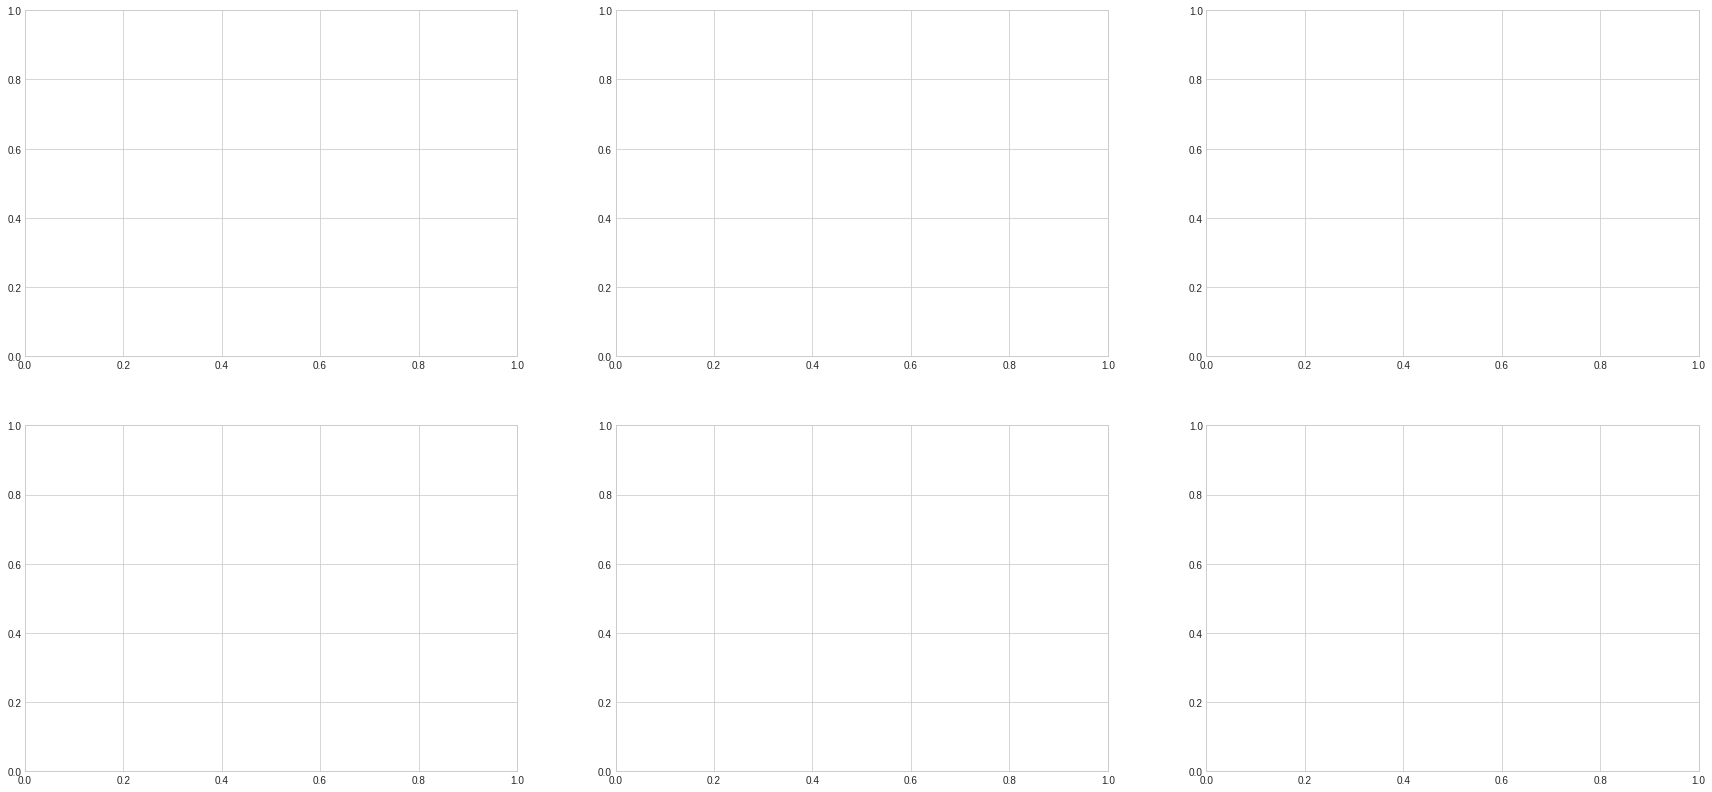

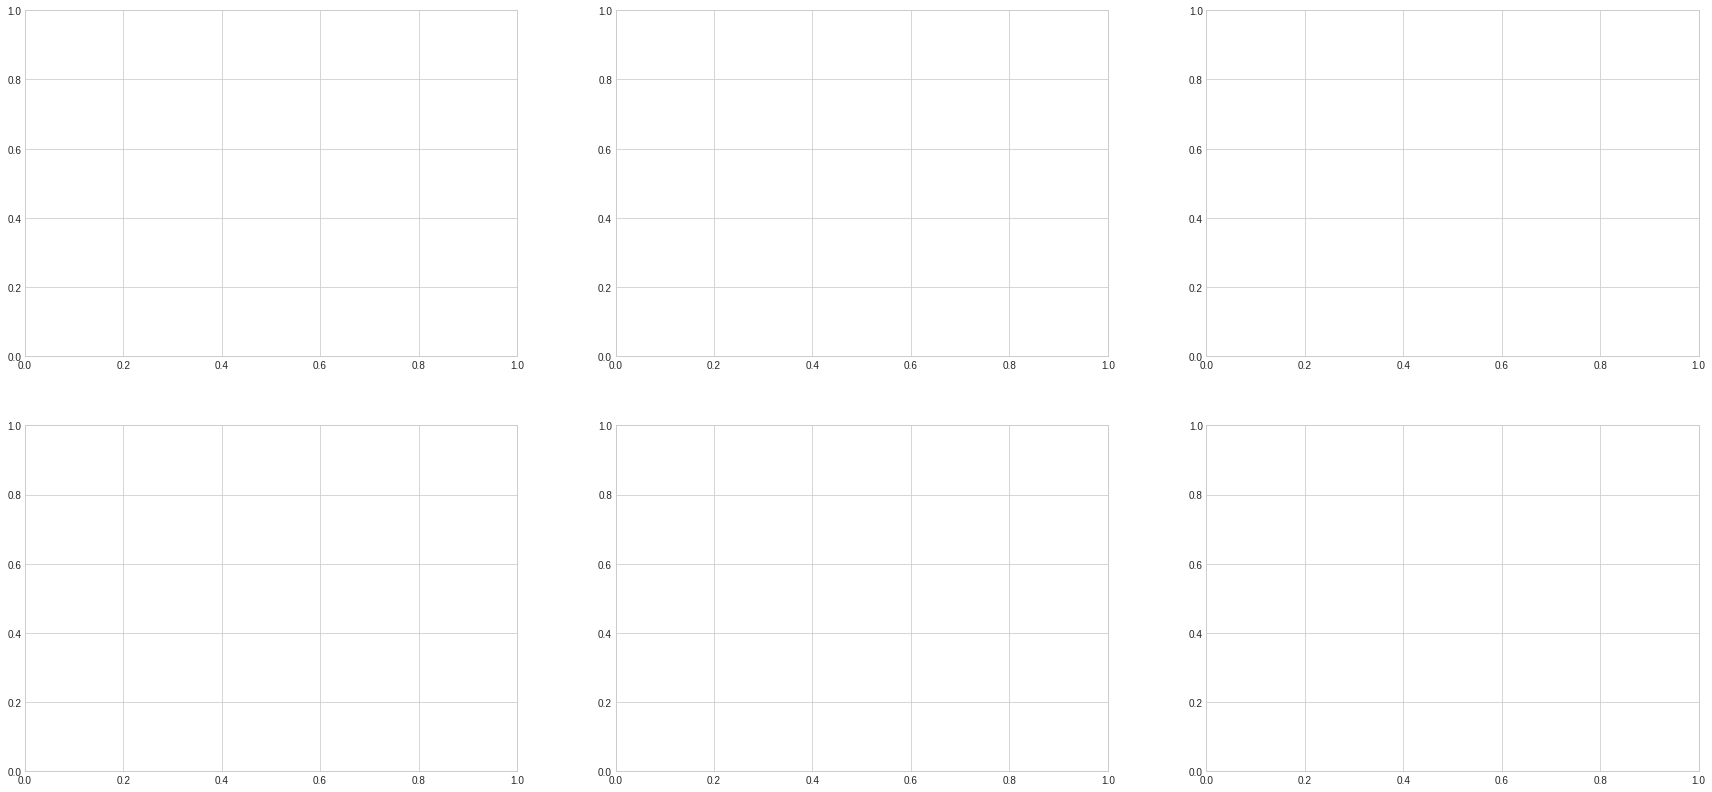

ValueError: Image size of 1631x23186669 pixels is too large. It must be less than 2^16 in each direction.

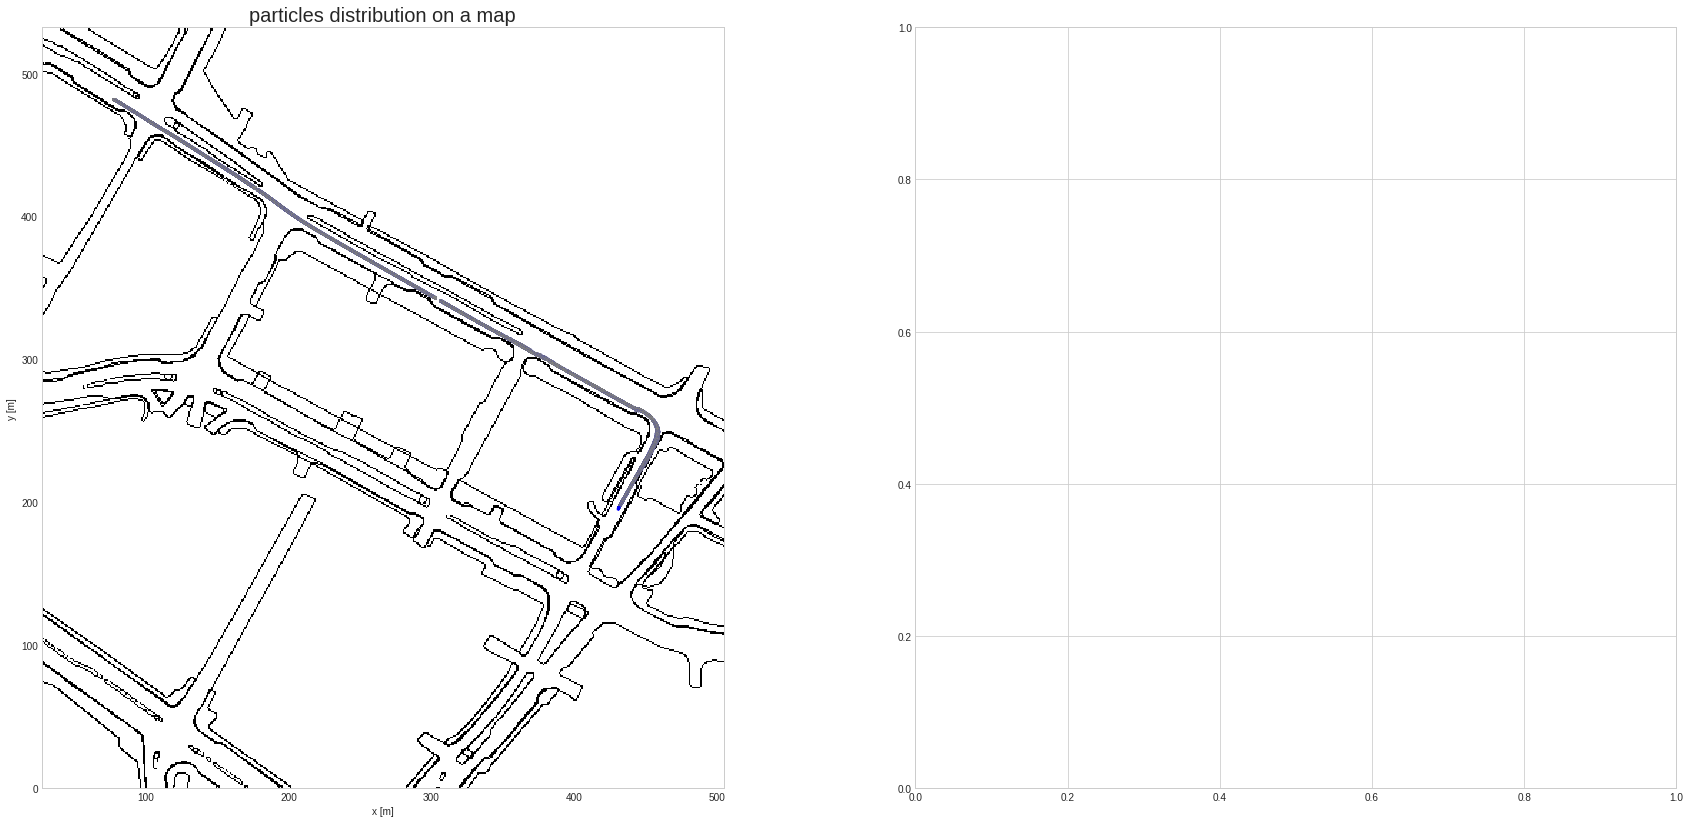

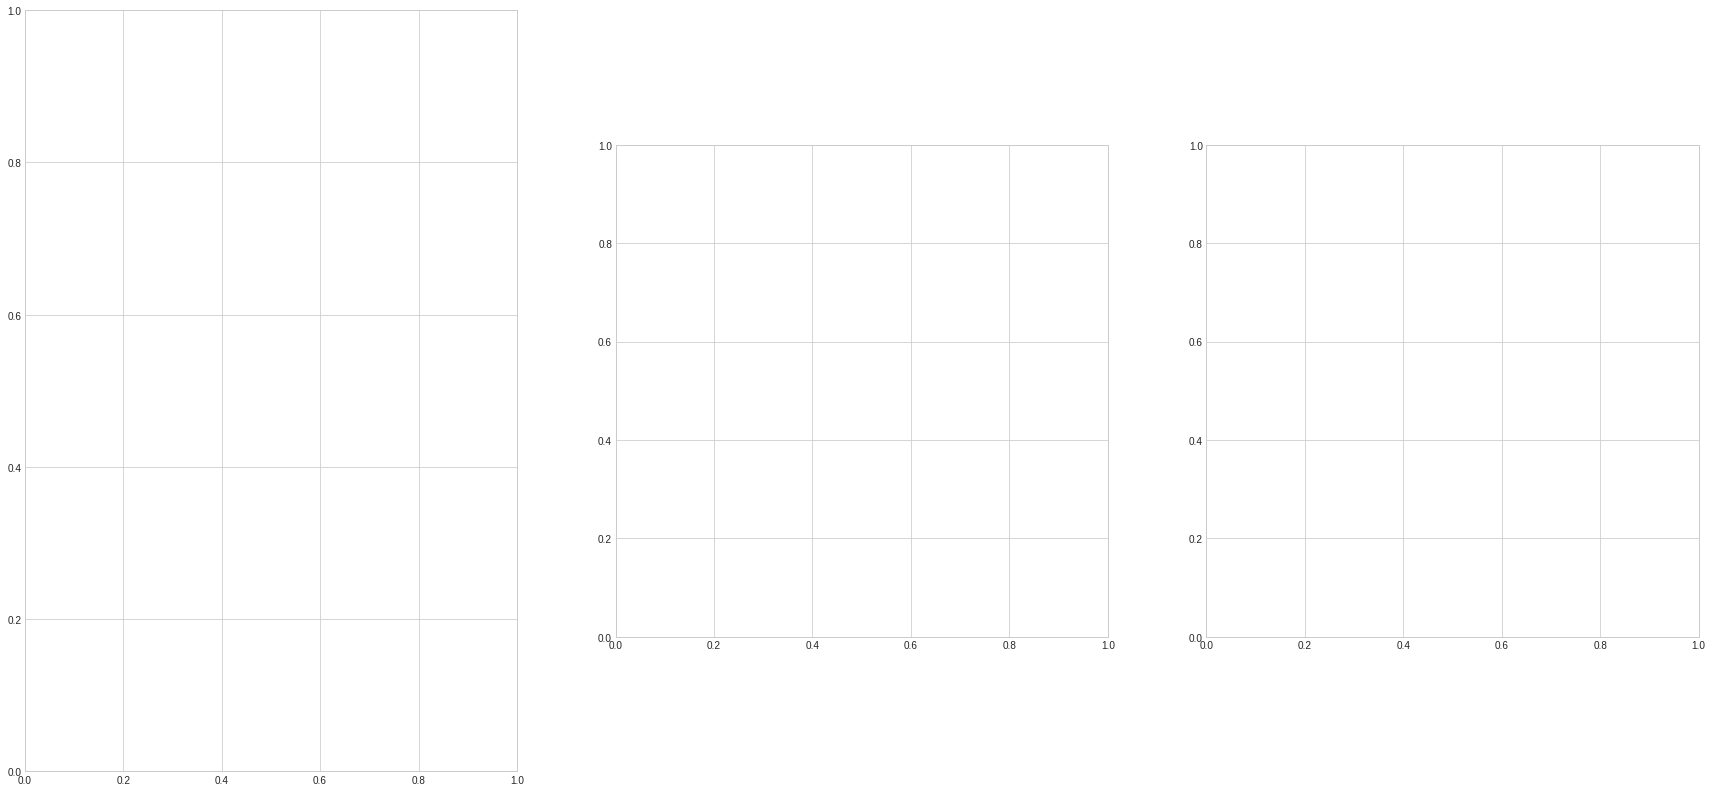

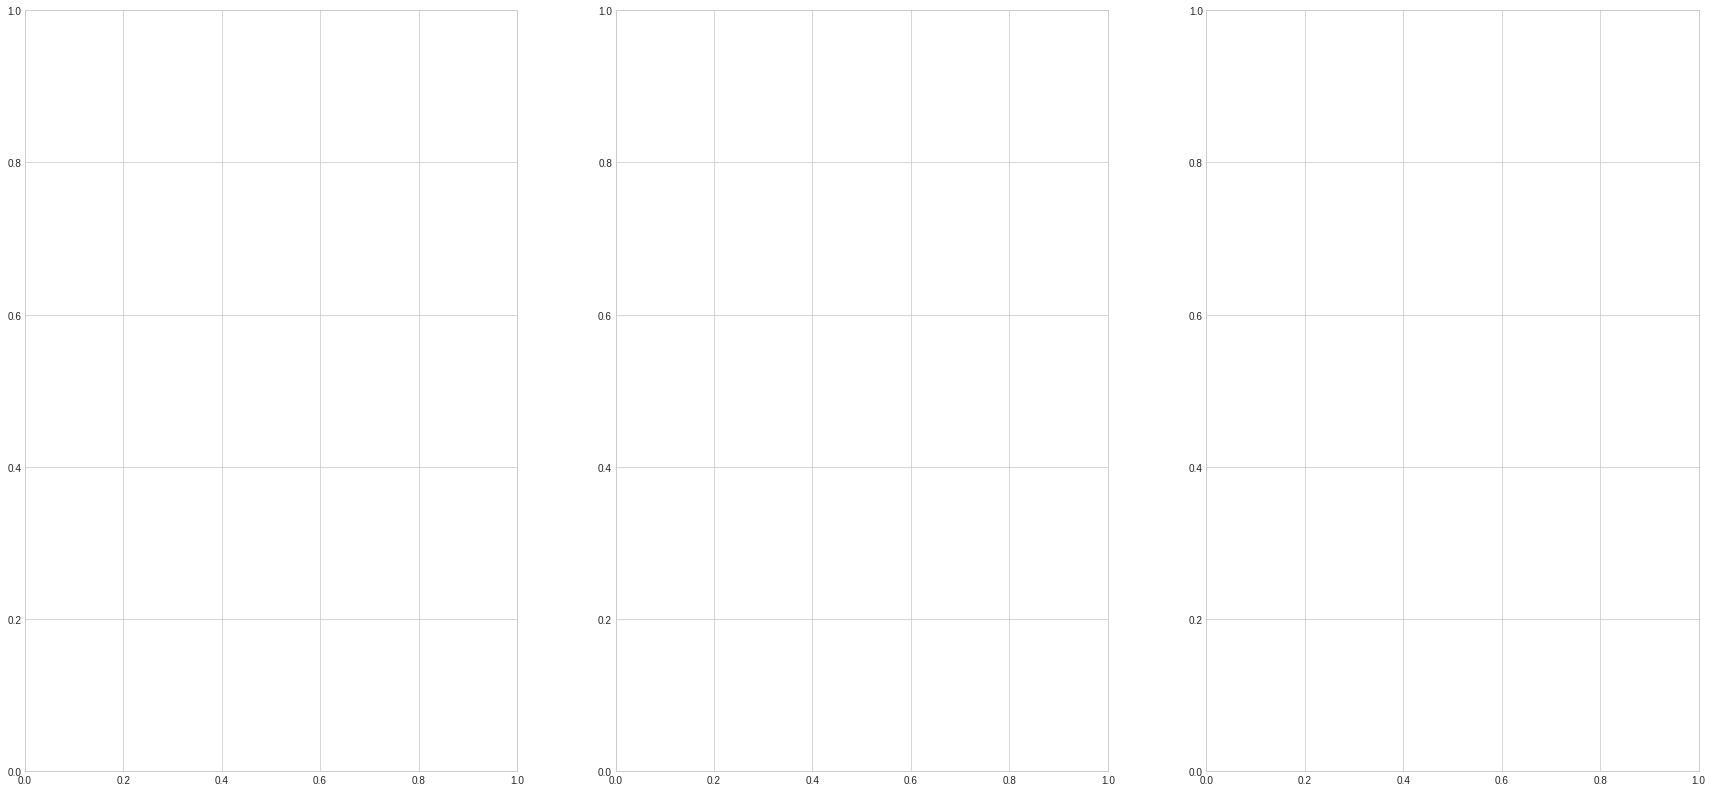

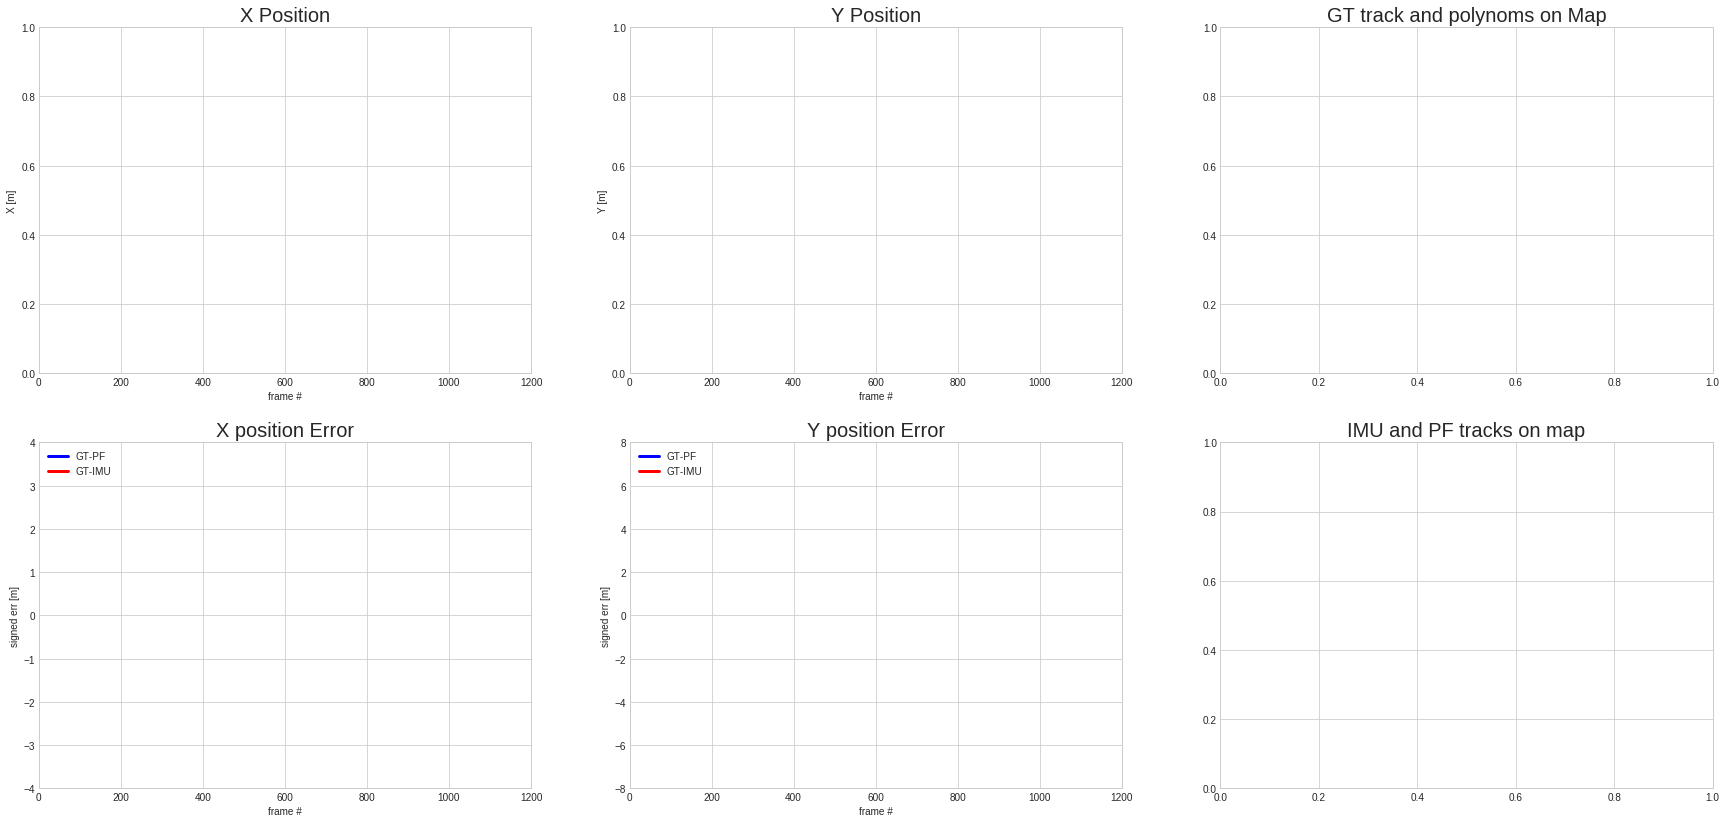

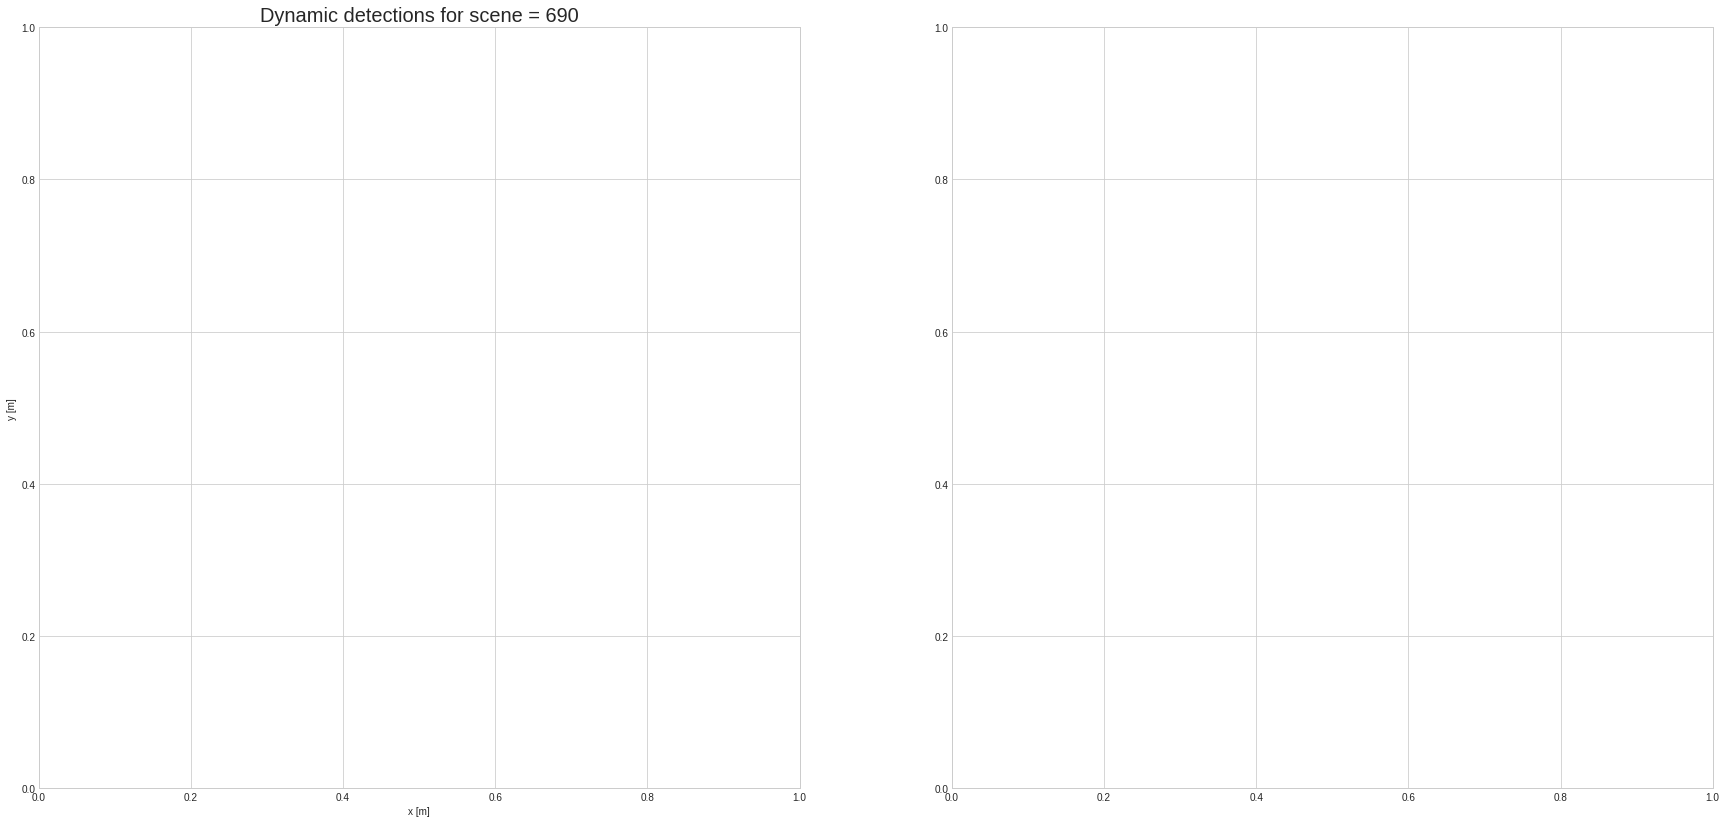

In [756]:
scene = 690 #365
model = RadarLocalizer(scene_id=scene, mm=True)
video_list={'video' : False, 'video_debug': False, 'video_pf': True, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1200, video_list=video_list)
sim.run(start=0, N=800, generate_video=False, video_with_priors=True, debug=False)

In [ ]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]
gt [1872.7430668711531, 1071.9499580039733, 0.0] ins [1872.7430668711531, 1071.9499580039733, 0.0]
gt [1872.9656838675555, 1072.1147770276675, 0.0] ins [1872.98214266 1072.12762265    0.        ]
gt [1873.197021748008, 1072.2744418932002, 0.0] ins [1873.26474338 1072.32249811    0.        ]
gt [1873.441761401517, 1072.4343429220644, 0.0] ins [1873.5228249  1072.48639182    0.        ]
gt [1873.702274610831, 1072.5903339908991, 0.0] ins [1873.82757276 1072.66387166    0.        ]
gt [1874.2541783730942, 1072.8830707104162, 0.0] ins [1874.44362047 1072.96742662    0.        ]
gt [1874.5465496397987, 1073.018591867703, 0.0] ins [1874.73675211 1073.09710368    0.        ]
gt [1874.8365718455975, 1073.1359006706575, 0.0] 

gt [1919.240768721885, 1051.3982299692614, 0.0] ins [1921.05246498 1051.51945754    0.        ]
gt [1920.43550779341, 1050.6401859246007, 0.0] ins [1922.26522586 1050.77306746    0.        ]
gt [1921.0387726742154, 1050.2578009934596, 0.0] ins [1922.83346561 1050.42338073    0.        ]
gt [1921.6525444341269, 1049.868272389079, 0.0] ins [1923.48419476 1050.02292154    0.        ]
gt [1922.263063608517, 1049.4769942121188, 0.0] ins [1924.07083828 1049.6619455     0.        ]
gt [1922.8597750514552, 1049.0991385090683, 0.0] ins [1924.71711875 1049.26454964    0.        ]
gt [1923.462421075392, 1048.7163832005515, 0.0] ins [1925.29258452 1048.9108101     0.        ]
gt [1924.6715978329134, 1047.9457771198702, 0.0] ins [1926.5298465  1048.14940737    0.        ]
gt [1925.2767122516616, 1047.5589263694637, 0.0] ins [1927.18888244 1047.74354935    0.        ]
gt [1925.887104397188, 1047.1713267793093, 0.0] ins [1927.7645791  1047.38867673    0.        ]
gt [1926.4990046782855, 1046.77977023

gt [1984.7812947425846, 1010.1274589418626, 0.0] ins [1987.72468557 1010.64821936    0.        ]
gt [1985.3770450527695, 1009.7492021709702, 0.0] ins [1988.31806852 1010.28647794    0.        ]
gt [1986.0421458036114, 1009.3326497257169, 0.0] ins [1989.00934133 1009.86508002    0.        ]
gt [1986.6813547551, 1008.9350548715986, 0.0] ins [1989.6227099  1009.49110625    0.        ]
gt [1987.3127648803172, 1008.541616152962, 0.0] ins [1990.30012483 1009.0779723     0.        ]
gt [1987.9446914064695, 1008.146465483751, 0.0] ins [1990.89812482 1008.7133        0.        ]
gt [1989.2040412244764, 1007.3608406166421, 0.0] ins [1992.1838297  1007.93023034    0.        ]
gt [1989.8316612958643, 1006.9692993569337, 0.0] ins [1992.86416101 1007.51585843    0.        ]
gt [1990.4722083851916, 1006.556223459935, 0.0] ins [1993.46268419 1007.15128169    0.        ]
gt [1991.0901633709964, 1006.1716881471534, 0.0] ins [1994.13627415 1006.74117868    0.        ]
gt [1991.7116995443985, 1005.7815883

gt [2051.264122060744, 968.9419179144304, 0.0] ins [2055.31700827  969.7852148     0.        ]
gt [2052.5233602892877, 968.1569606670542, 0.0] ins [2056.59147059  969.00798925    0.        ]
gt [2053.1541172474635, 967.761067344367, 0.0] ins [2057.20492284  968.63391473    0.        ]
gt [2053.7915617979447, 967.360229256698, 0.0] ins [2057.89089723  968.21580428    0.        ]
gt [2054.421627001507, 966.9670874219858, 0.0] ins [2058.48758541  967.85238119    0.        ]
gt [2055.052537702662, 966.5716693199514, 0.0] ins [2059.1770485   967.43269552    0.        ]
gt [2055.6975527512996, 966.1672092492495, 0.0] ins [2059.77995386  967.06598601    0.        ]
gt [2056.9670603489512, 965.365119365383, 0.0] ins [2061.0575252   966.28990103    0.        ]
gt [2057.6015382733904, 964.9700612132848, 0.0] ins [2061.74572052  965.87213845    0.        ]
gt [2058.235527483056, 964.5776241176768, 0.0] ins [2062.34482993  965.50865248    0.        ]
gt [2058.8639462265737, 964.1937440580077, 0.0]

gt [2105.8298358037023, 935.0039626178104, 0.0] ins [2110.69584933  936.165935      0.        ]
gt [2106.2526677692085, 934.7381752529197, 0.0] ins [2111.0884378   935.92504859    0.        ]
gt [2106.661951466421, 934.4819058275039, 0.0] ins [2111.54409149  935.64541736    0.        ]
gt [2107.0780072294115, 934.2195096339517, 0.0] ins [2111.99704368  935.3674516     0.        ]
gt [2107.4846907223337, 933.9662088847593, 0.0] ins [2112.39877     935.12059135    0.        ]
gt [2108.2862358975626, 933.4610788508512, 0.0] ins [2113.22791549  934.61036066    0.        ]
gt [2108.6844974690557, 933.2119856157867, 0.0] ins [2113.67174823  934.33725562    0.        ]
gt [2109.076214074382, 932.9649753111619, 0.0] ins [2114.06130789  934.09732619    0.        ]
gt [2109.4719559102787, 932.7149544329429, 0.0] ins [2114.49457975  933.83025175    0.        ]
gt [2109.8636765578935, 932.4669655384389, 0.0] ins [2114.87421304  933.59615706    0.        ]
gt [2110.2919939385392, 932.1963487182021,

gt [2126.296874696447, 921.9607020048984, 0.0] ins [2131.85920767  923.08172509    0.        ]
gt [2126.4755723577937, 921.8446171964106, 0.0] ins [2132.0243902   922.97614611    0.        ]
gt [2126.645987264742, 921.732740607203, 0.0] ins [2132.19343157  922.866455      0.        ]
gt [2126.833096475495, 921.6083654634793, 0.0] ins [2132.39549702  922.73217837    0.        ]
gt [2127.024170412872, 921.4790987537663, 0.0] ins [2132.57990377  922.60724239    0.        ]
gt [2127.2248221234267, 921.3389413385714, 0.0] ins [2132.7939644   922.45864702    0.        ]
gt [2127.6376692430326, 921.0413791000362, 0.0] ins [2133.20669611  922.15427792    0.        ]
gt [2127.843848771591, 920.8857805949233, 0.0] ins [2133.40745034  922.00136616    0.        ]
gt [2128.0704951481925, 920.7104658939124, 0.0] ins [2133.63760859  921.82056053    0.        ]
gt [2128.2758745170786, 920.5465726111729, 0.0] ins [2133.84064461  921.65802065    0.        ]
gt [2128.5116985444024, 920.3514670126651, 0.0

gt [2123.6255902618013, 892.1561171083977, 0.0] ins [2129.21581494  891.61298712    0.        ]
gt [2123.431316516151, 891.8597128545953, 0.0] ins [2129.02528059  891.31011669    0.        ]
gt [2123.326658452318, 891.7000609543284, 0.0] ins [2128.92832381  891.15606424    0.        ]
gt [2123.24382664237, 891.5705615922652, 0.0] ins [2128.84470498  891.02314164    0.        ]
gt [2123.1514426177177, 891.4281705797891, 0.0] ins [2128.76662745  890.89891955    0.        ]
gt [2123.069785005169, 891.3021813827646, 0.0] ins [2128.68077201  890.76226639    0.        ]
gt [2122.9282215282938, 891.0835393409529, 0.0] ins [2128.53198313  890.52530139    0.        ]
gt [2122.8673924994596, 890.9875887594233, 0.0] ins [2128.47106296  890.42823004    0.        ]
gt [2122.8071747214035, 890.8927502325934, 0.0] ins [2128.40561992  890.32387185    0.        ]
gt [2122.746736714577, 890.7987722737714, 0.0] ins [2128.35293216  890.23976492    0.        ]
gt [2122.6890543088, 890.7105579433428, 0.0] i

gt [2122.4304367263526, 890.4008962981343, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.430341124353, 890.4009554766068, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4302414612393, 890.4010168997295, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4301373514595, 890.4010809171303, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4299497409543, 890.4011975093733, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429865134025, 890.4012511885089, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4297772910377, 890.401307467967, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4296911676056, 890.4013622906396, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429606093625, 890.4014152684771, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4295202188223, 890.4014681944468, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4293634903197, 890.4015653508387, 0

gt [2119.919350699114, 882.9547738499077, 0.0] ins [2125.68146391  882.40246118    0.        ]
gt [2119.9732872933123, 882.6474983187818, 0.0] ins [2125.7428585   882.11189468    0.        ]
gt [2120.035429170739, 882.361524915598, 0.0] ins [2125.82043608  881.81830184    0.        ]
gt [2120.1957771006923, 881.8114001874578, 0.0] ins [2126.00023817  881.30057097    0.        ]
gt [2120.300702974806, 881.5225225194172, 0.0] ins [2126.11774244  881.00608066    0.        ]
gt [2120.425744726576, 881.219280137853, 0.0] ins [2126.25277452  880.71141657    0.        ]
gt [2120.5565920132453, 880.9401914321568, 0.0] ins [2126.38219697  880.45613059    0.        ]
gt [2120.700948074343, 880.6667430723462, 0.0] ins [2126.54456576  880.16528531    0.        ]
gt [2121.0356541026863, 880.1136138125739, 0.0] ins [2126.90337768  879.64184764    0.        ]
gt [2121.227557516346, 879.8383480392782, 0.0] ins [2127.08225712  879.40108619    0.        ]
gt [2121.4326265129066, 879.5707423720257, 0.0] 

gt [2167.55785051683, 875.1257505826826, 0.0] ins [2173.76378313  875.31013101    0.        ]
gt [2168.1907179037466, 875.1373154055002, 0.0] ins [2174.37279086  875.32742628    0.        ]
gt [2169.460065510634, 875.1598513010081, 0.0] ins [2175.66252425  875.3635217     0.        ]
gt [2170.0823113040474, 875.1687396408981, 0.0] ins [2176.3634515   875.38322992    0.        ]
gt [2170.720662537157, 875.1803628545218, 0.0] ins [2177.04017069  875.40226155    0.        ]
gt [2171.3496988648158, 875.188738671927, 0.0] ins [2177.63941129  875.41915666    0.        ]
gt [2172.0236234931112, 875.2006525031728, 0.0] ins [2178.31940886  875.43854163    0.        ]
gt [2172.6356118454737, 875.210212164053, 0.0] ins [2178.91319768  875.45563441    0.        ]
gt [2173.953523509399, 875.2345465111464, 0.0] ins [2180.25912     875.49408611    0.        ]
gt [2174.5857440788623, 875.2442237117139, 0.0] ins [2180.85244039  875.51107437    0.        ]
gt [2175.168495784878, 875.2579985920689, 0.0] 

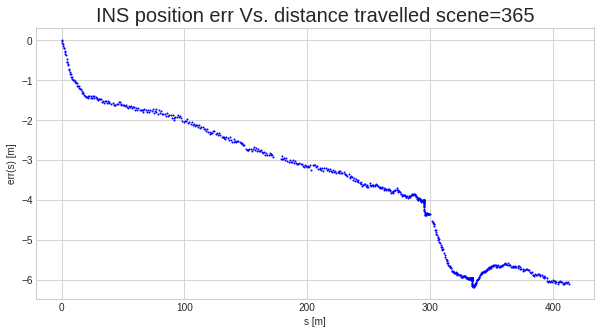

In [131]:
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800
gt = np.zeros(N)
imu = np.zeros(N)
gt_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t] = np.linalg.norm(trns[0:2]-gt_pos[t-1, :]) if t > 0 else 0
    gt_pos[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    print("gt", trns, "ins", trns1)
    imu[t] = np.linalg.norm(trns1[0:2]-imu_pos[t-1, :]) if t > 0 else 0
    imu_pos[t, :] = trns1[0:2]
    timestamp[t] = dataset.odometry['timestamp']
    
gt_int = np.cumsum(gt)
imu_int = np.cumsum(imu)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS position err Vs. distance travelled scene={scene}", fontsize=20)
ax.set(xlabel='s [m]', ylabel='err(s) [m]')
ax.scatter(gt_int,gt_int-imu_int,color='blue',s=1)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


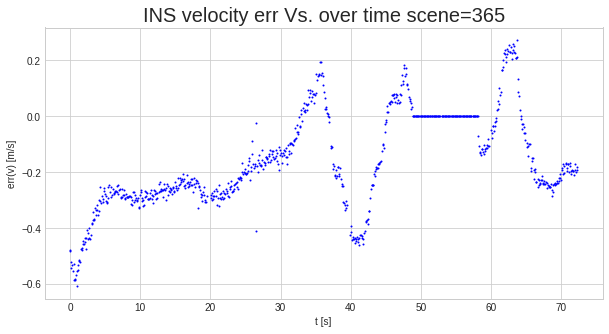

In [134]:
#draw the speed
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800#800
gt_speed = np.zeros(N)
imu_speed = np.zeros(N)
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt_speed[t] = np.linalg.norm(dataset.odometry['speed'])
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu_speed[t] = dataset.odometry['speed']
    timestamp[t] = dataset.odometry['timestamp']
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS velocity err Vs. over time scene={scene}", fontsize=20)
ax.set(xlabel='t [s]', ylabel='err(v) [m/s]')
ax.scatter(timestamp[:]-timestamp[0],gt_speed-imu_speed,color='blue',s=1)

In [ ]:
from pyquaternion import Quaternion

Quaternion.Inverse()

In [ ]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

In [ ]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')

In [ ]:
a = np.array([[1, 2],[3,4],[5,6],[7,8]])
print(a.shape)
b = np.array([[11, 19],[7,28],[15,16]]).T
print(b.shape)
print(a[:,0].shape)
k = a[:,0].reshape(-1,1)-b[0,:].reshape(1,-1)
t = a[:,1].reshape(-1,1)-b[1,:].reshape(1,-1)
norm = np.sqrt(k**2 + t**2)
it = norm.argmin(axis=1)
print("it", it, "norm",norm)
#print(np.amin(norm, axis=1))
print(k.shape, t.shape)
print(k)
print(np.take_along_axis(k, np.expand_dims(it, axis=-1), axis=1))
print(np.take_along_axis(t, np.expand_dims(it, axis=-1), axis=1))

In [30]:
A = np.zeros((3,3))
pnts = [[0,1],[3,3],[6,1]]
dist = np.array([pnt[0]**2 for pnt in pnts])
candidates = np.where(dist>5)[0]
non_candidates = np.where(dist<=5)[0]

A[candidates,0] = 1
print(A)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [144]:
mapa = sim.dataset.getMap()


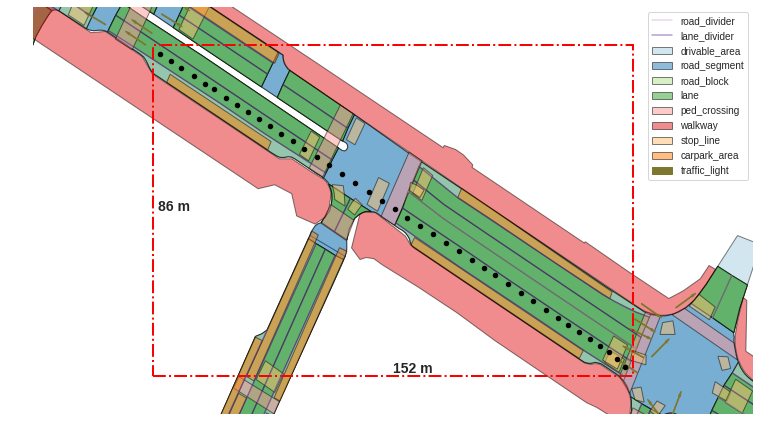

In [148]:
ego_poses = mapa.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[692]['token']], verbose=False)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:310: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.first_imu_rot = Quaternion(rot_imu[ridx,1])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


history []


/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

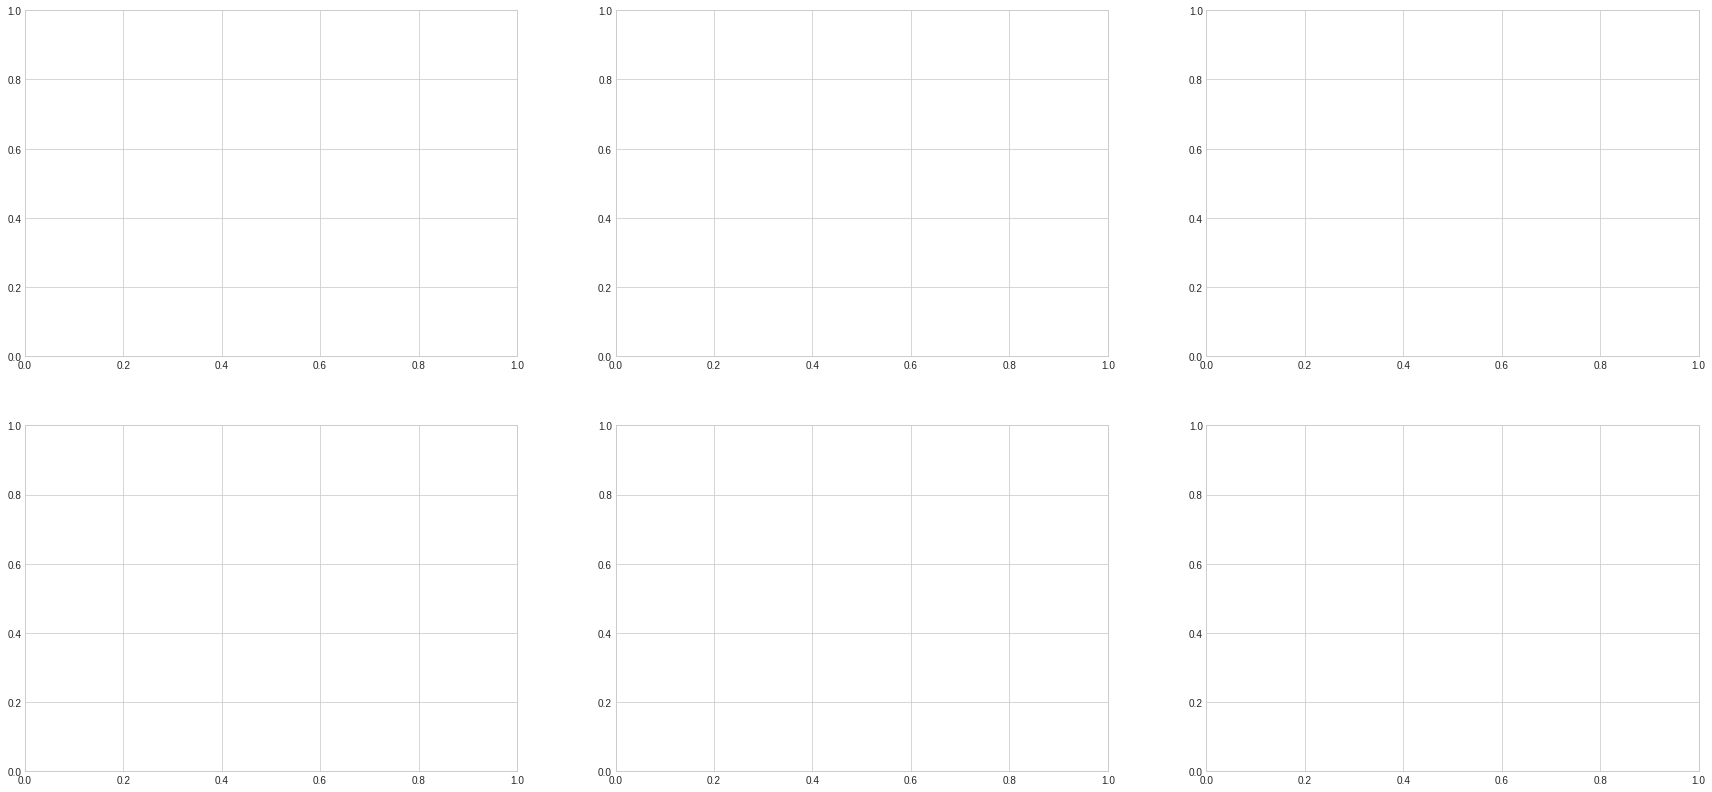

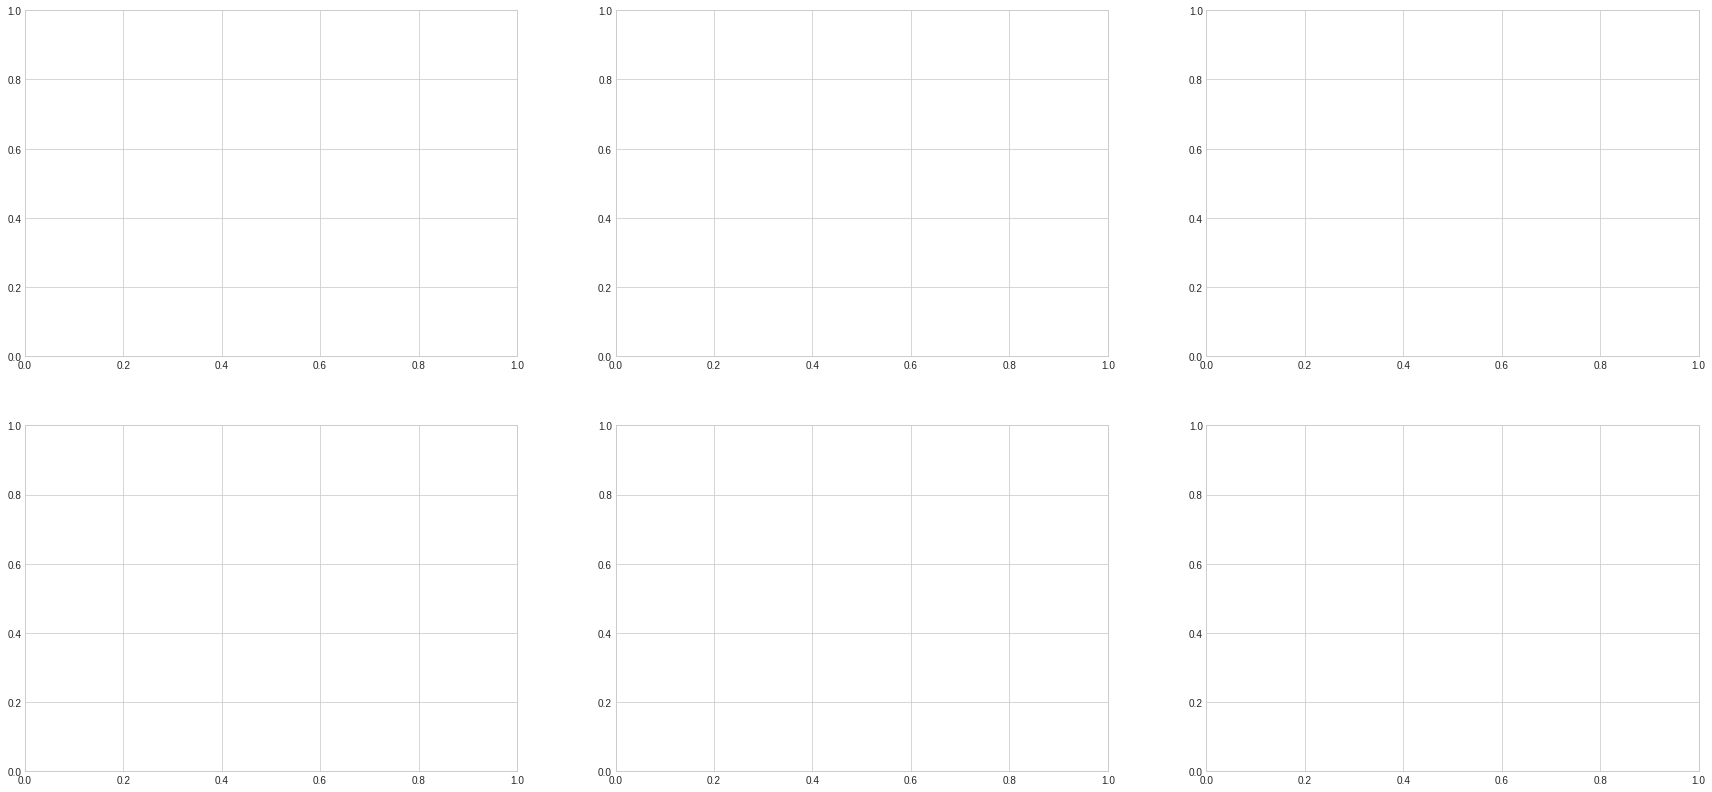

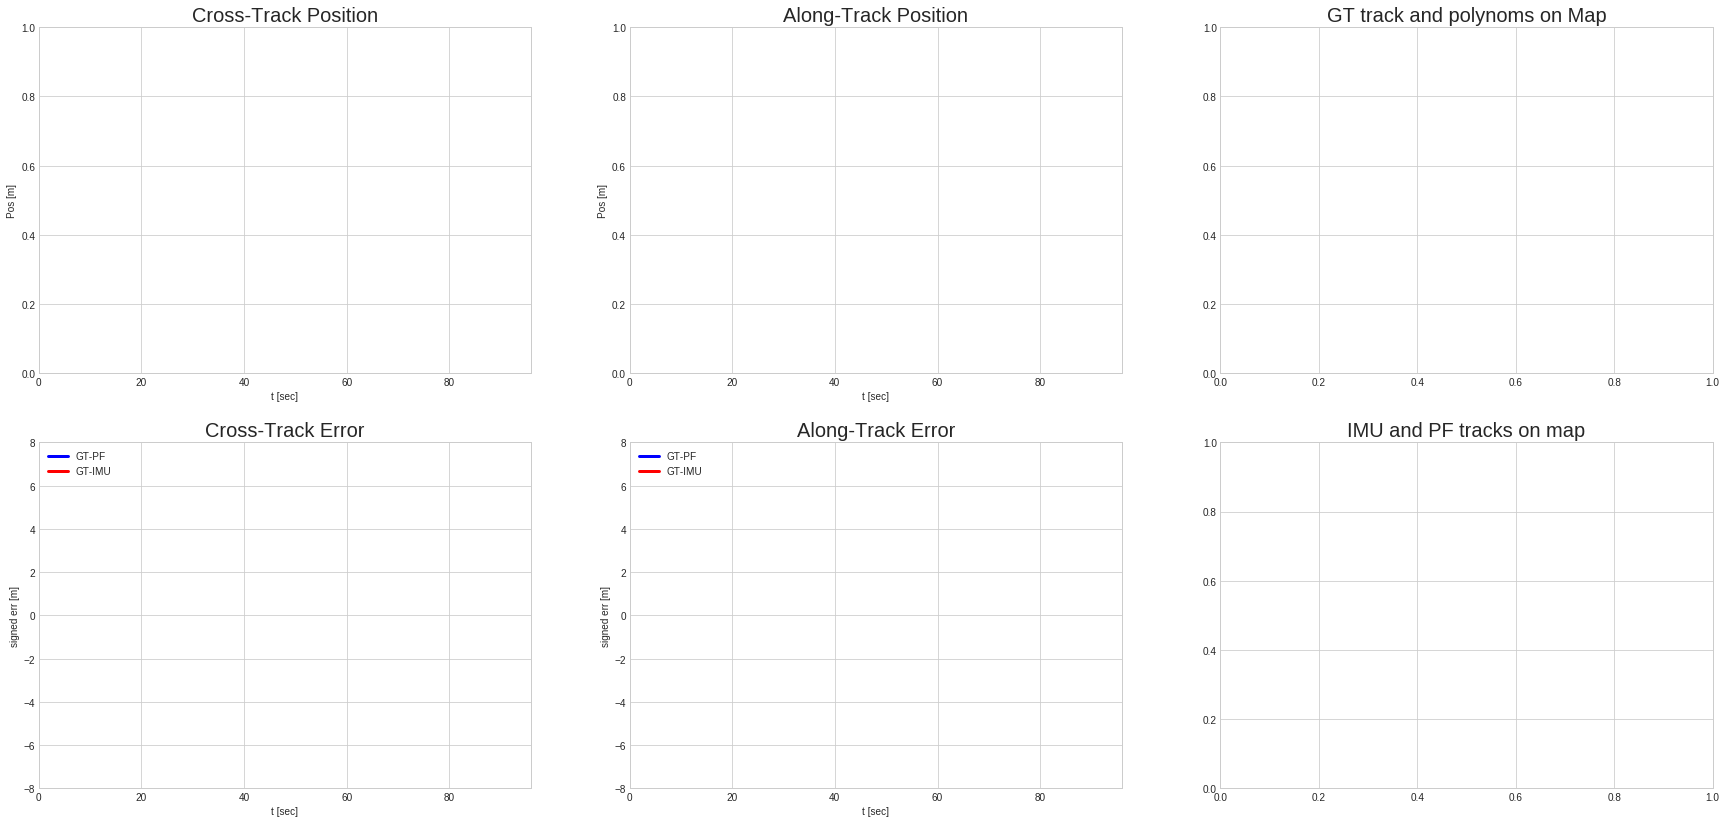

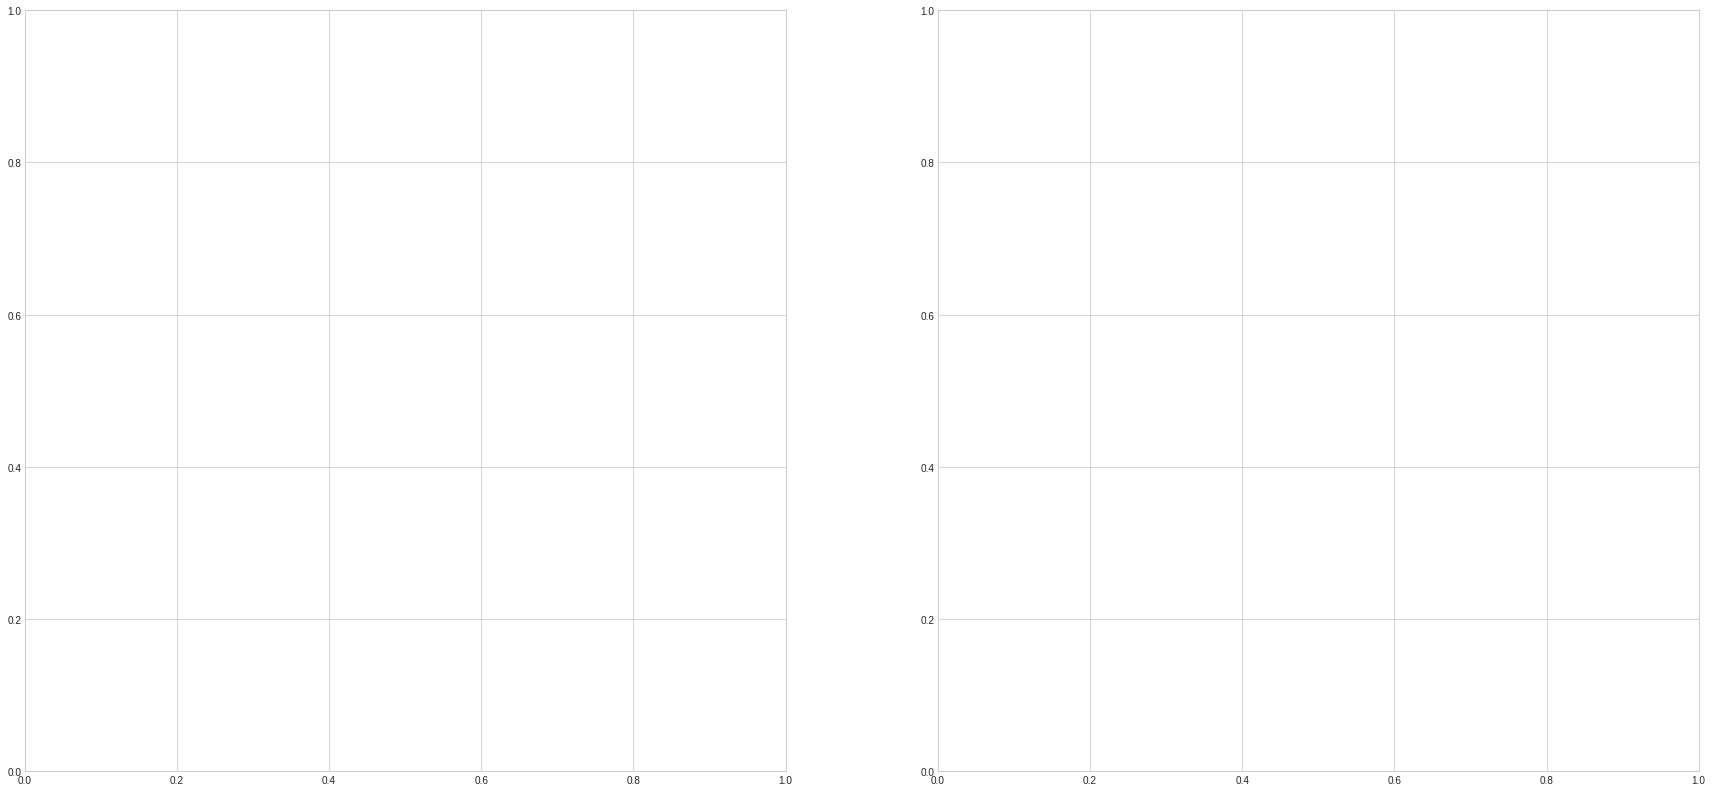

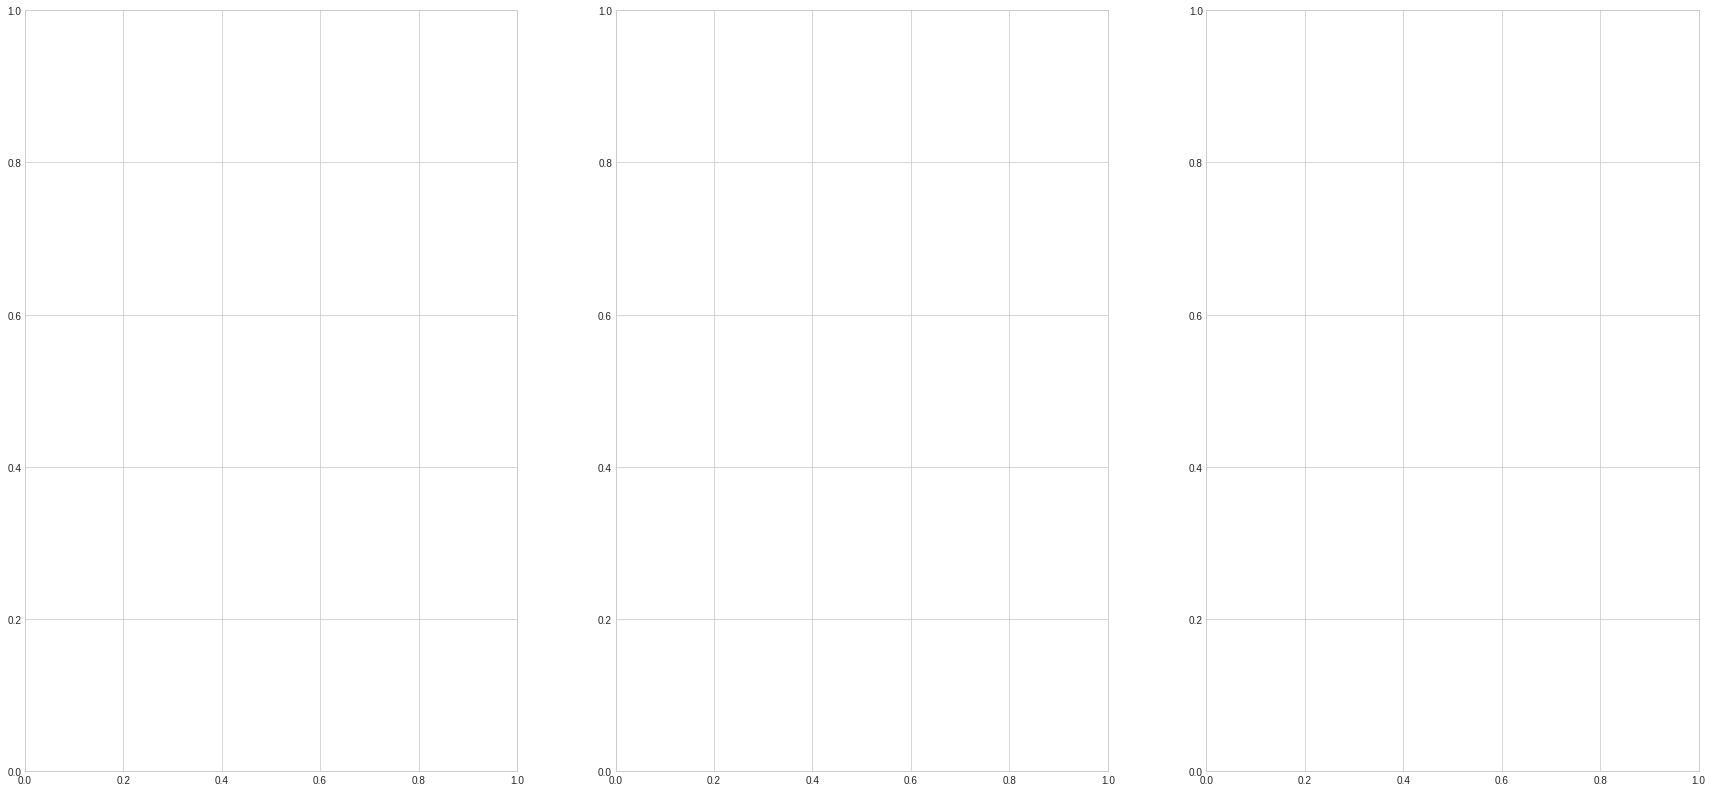

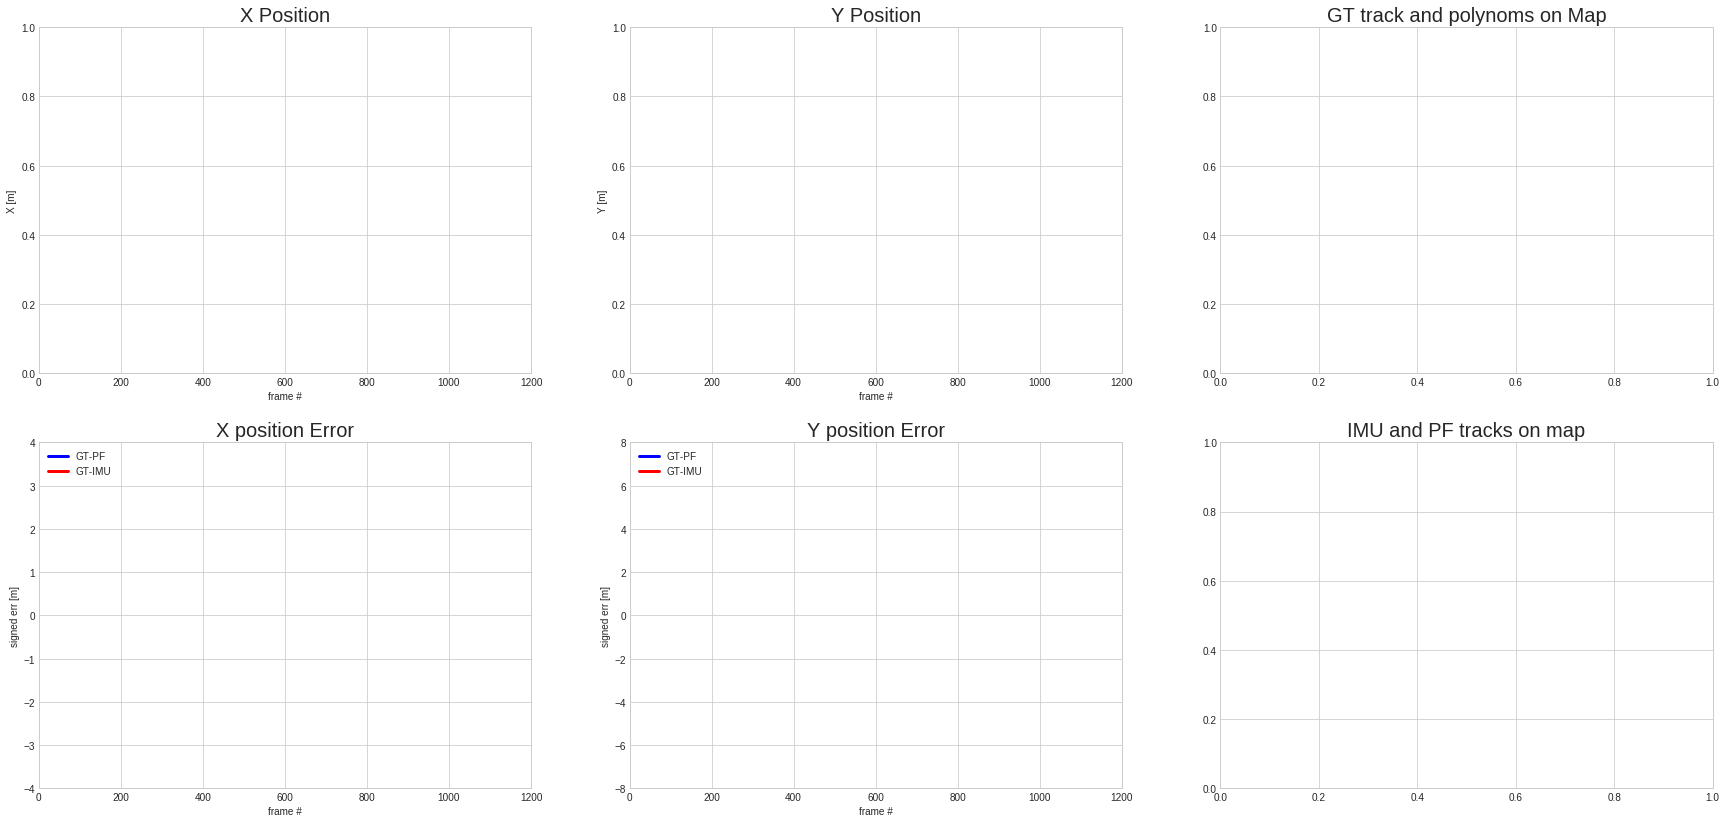

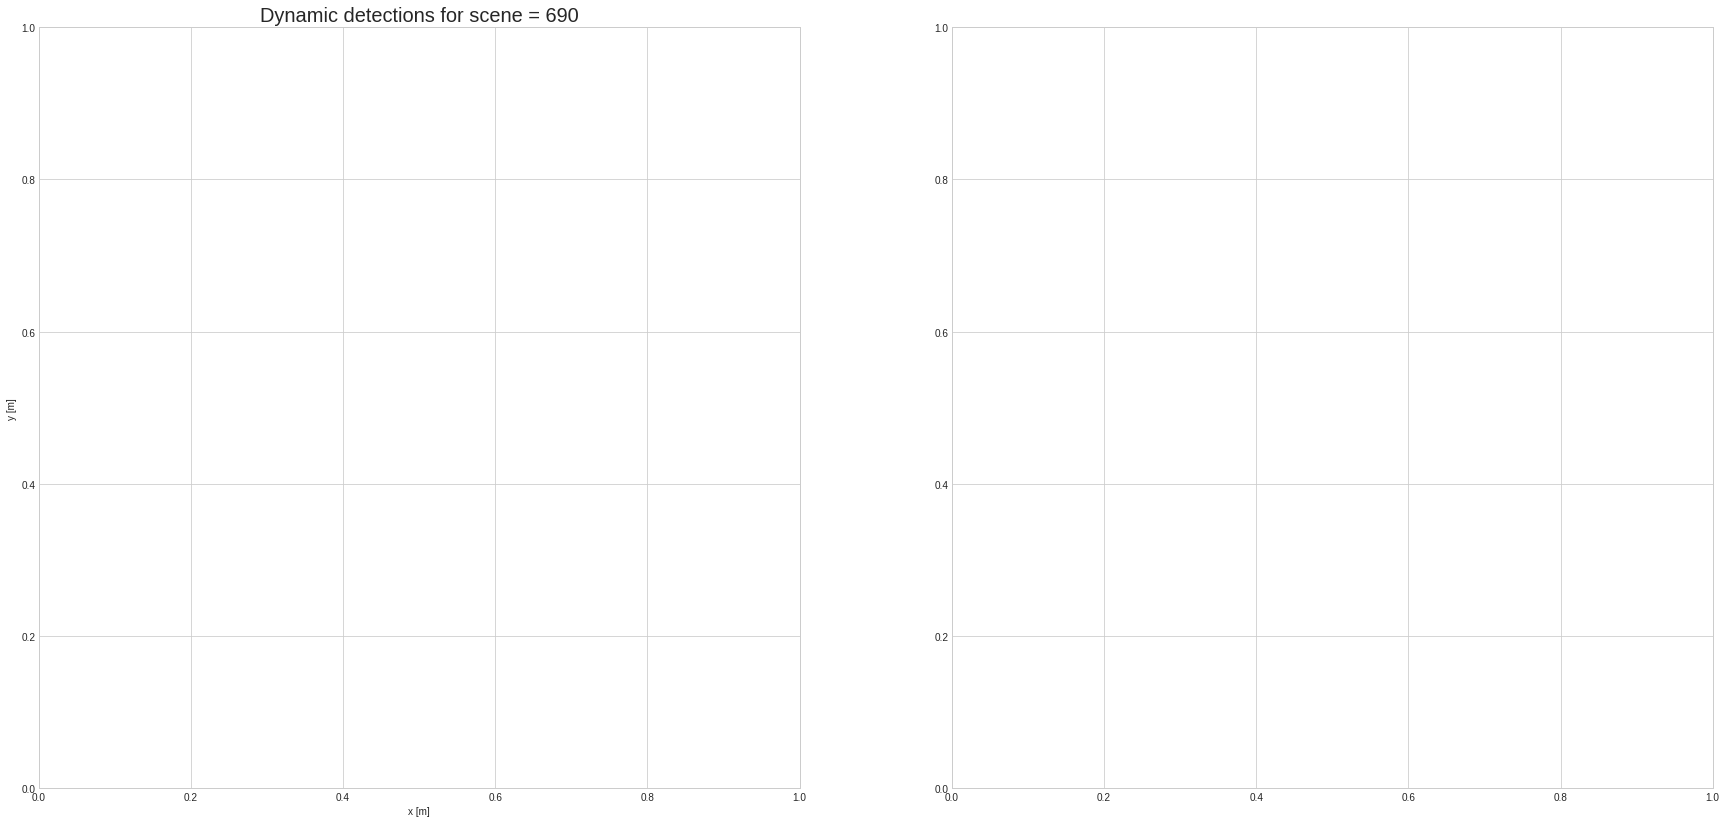

In [274]:
start_frame=0
n_frames = 15
ego_path = sim.dataset.getEgoPath()[:n_frames]
tracker = DynamicTracker()
dbscan_clustering = ClassicDBSCAN()
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1200, video_list=video_list)

print("history",history)
for t in range(start_frame,n_frames):
    _, _, _, pc, video_data, _ = sim.dataset.getData(t,GT=False)
    ts, heading, ego_speed = video_data["timestamp"], np.deg2rad(video_data["heading"]-90), video_data["veh_speed"]
    print("t", t)
    Z, C = dbscan_clustering.run(pc=pc, ego=ego_path[t], heading=np.deg2rad(heading))
    print("C",C)
    tracker.run(Z, ts, {"heading": np.deg2rad(heading), "T": ego_path[t]}, ego_speed)

In [275]:
def drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2):
    if 1:#trk.confirmed:
        hstate, hego, hspeed = trk.getHistory()
        history_len = hstate.shape[0]
        if trk.hits > 5:
        #rotate translate each state according to hego
            tstate = np.zeros((hstate.shape[0], 2, 1))
            tspeed = np.zeros((hstate.shape[0], 2, 1))
            for i, (state, ego, speed) in enumerate(zip(hstate, hego, hspeed)):
                R = np.array([[np.cos(ego["heading"]), -np.sin(ego["heading"])], [np.sin(ego["heading"]), np.cos(ego["heading"])]])
                tstate[i, :, :] = np.dot(R, state[0:2]) + ego["T"][0:2].reshape(-1,1)
                tspeed[i, :, :] = np.dot(R, state[2:4]) + np.dot(R, speed[0:2].reshape(-1,1))
            abs_vel = np.mean(np.linalg.norm(tspeed,axis=1), axis=0)
            print(f"abs_vel ={abs_vel}")
            if abs_vel < velThr:
                return
            
            ax.plot(tstate[:,0]+x_offset, tstate[:,1]+y_offset, color='red',label='track')
            dx = tstate[int(history_len / 2) + 1,0]-tstate[int(history_len / 2) - 1,0]
            dy = tstate[int(history_len / 2) + 1,1]-tstate[int(history_len / 2) - 1,1]
            ax.arrow(np.mean(tstate[:,0]+x_offset), np.mean(tstate[:,1]+y_offset), dx[0], dy[0], shape='full', lw=13, length_includes_head=True, head_width=.05)
            
def drawClusters(ax, cluster, x_offset=0, y_offset=0):
        for c in C:
            print(c)
            x_com = c[0]
            y_com = c[1]
            print("scatter x_com", x_com, y_com)
            ax.scatter(x_com, y_com, s=100, color='green')

lane_record [{'start_pose': [1177.7862727154206, 1672.4999821898566, -0.5482126305436211], 'end_pose': [1198.753070199328, 1659.288089910761, -0.5478653376415797], 'shape': 'RSL', 'radius': 434.9672740042469, 'segment_length': [12.303630098631363, 0.024782725978953556, 12.454691145513522]}]
min_dist = 104.47598166395187
abs_vel =[5.90431763]
[1138.92071731 1576.08262102    2.75          0.        ]
scatter x_com 1138.9207173121658 1576.082621016088


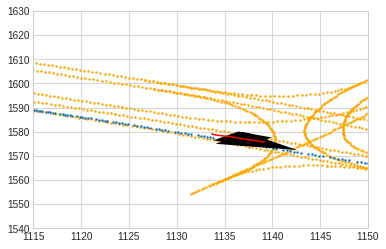

In [276]:
from nuscenes.map_expansion.map_api import NuScenesMap
import nuscenes.map_expansion.arcline_path_utils as path_utils
import numpy as np
import matplotlib.pyplot as plt

ax = plt.gca()
ax.clear()

n = 0
ego_path = sim.dataset.getEgoPath()
lane_ids = mapa.get_records_in_radius(ego_path[n,0], ego_path[n,1], 80, ['lane', 'lane_connector'])
nearby_lanes = lane_ids['lane'] + lane_ids['lane_connector']
for lane_token in nearby_lanes:
    lane_record = mapa.get_arcline_path(lane_token)
    poses = path_utils.discretize_lane(lane_record, resolution_meters=0.5)
    poses = np.array(poses)
    ax.scatter(poses[:,0], poses[:,1],color='orange',s=2)
#lane_token = mapa.get_closest_lane(ego_path[n,0], ego_path[n,1], radius=2)
#fig, ax = mapa.render_layers(['lane'],tokens=lane_token)
    #lane_path = mapa.arcline_path_3.get(lane_token, [])

    #resolution_meters = 0.5
    #discretized = np.array(path_utils.discretize_lane(lane_path, resolution_meters))
#fig, ax = mapa.render_layers(['lane'])


#ax.plot(discretized[:,0], discretized[:,1], 's', color='orange')
ax.scatter(ego_path[:,0], ego_path[:,1],s=2)

ax.set_xlim([1115, 1150])
ax.set_ylim([1540, 1630])

np.min(np.linalg.norm(ego_path[n,:]-poses))
#lane_record = mapa.get_arcline_path(lane_token)
print("lane_record", lane_record)
#poses = path_utils.discretize_lane(lane_record, resolution_meters=0.5)
#poses = np.array(poses)

min_dist = np.min(np.linalg.norm(ego_path[n,:2]-poses[:,0:2],axis=1))
print(f"min_dist = {min_dist}")
#print("poses",poses)
ax.scatter(poses[:,0], poses[:,1],s=2)

tracks = tracker.getHistory()
for idx,trk in enumerate(tracks):
    drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2)
    
drawClusters(ax, C)
#ax.axis('equal')
#plt.show()

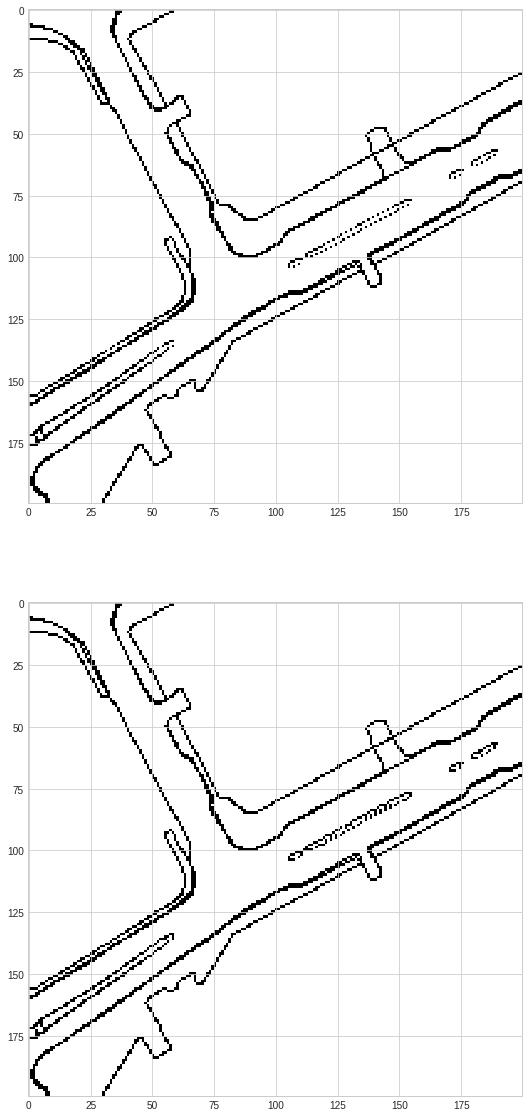

In [440]:
from map_utils import *

#sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=690, Nmax=1200, video_list=video_list)


fig, ax = plt.subplots(2,figsize=(10,20))
mapa = sim.dataset.getMap()
ego_path = sim.dataset.getEgoPath()
orig = getCombinedMap(mapa,ego_path[300,:],smooth=False)#[80:120,100:150]
smoothed = getCombinedMap(mapa,ego_path[300,:],smooth=True)#[80:120,100:150]
ax[0].imshow(orig)
ax[1].imshow(smoothed)
#plt.imsave('690.png', binary_map)

In [705]:
from scipy.interpolate import splrep, splev

def getLineIndication(pos, N=50, thr=0.05):
        x = pos[-N:,0]
        y = pos[-N:,1]

        fit, cov = np.polyfit(x, y, 1, cov=True)
        print("cov",cov,"fit",fit)
        if np.sqrt(cov[0,0]) < thr:
            return True

        return False

def computeIMUAngleBias(imuPos, pfPose, N=50):
    if imuPos.shape[0] >= 5 and getLineIndication(imuPos, N=N):
        ax = imuPos[-N:,0] - imuPos[0,0]
        ay = imuPos[-N:,1] - imuPos[0,1]
        bx = pfPose[-N:,0] - pfPose[0,0]
        by = pfPose[-N:,1] - pfPose[0,1]
        angle_bias = np.arctan2(ax*by - ay*bx, ax*bx + ay*by)
        return angle_bias

    return None

In [709]:
pf_pos = np.array([[0,0],[100,-50],[200,-100],[300,-150],[400,-200]])
imu_pos = np.array([[0,0],[100,-51],[200,-10],[300,-13],[400,-204]])
print(imu_pos.shape)
print(computeIMUAngleBias(imu_pos, pf_pos)[-1])

(5, 2)
[  0 100 200 300 400] [   0  -51  -10  -13 -204]
cov [[ 5.11306667e-02 -1.02261333e+01]
 [-1.02261333e+01  3.06784000e+03]] fit [-0.37 18.4 ]


TypeError: 'NoneType' object is not subscriptable

In [665]:
math.atan2(4,4)

0.7853981633974483

In [ ]:
-0.37 * 400